In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'native','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'native',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_0_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_0_42_n_native_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(716686, 828)
(716686, 8)
validation
(74368, 828)
(74368, 8)
test
(91684, 828)
(91684, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 1538952 (5.87 MB)


Trainable params: 1538952 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/72 [..............................] - ETA: 2:15 - loss: 2.4022 - STD: 0.0996 - MAE: 0.2219

 3/72 [>.............................] - ETA: 1s - loss: 1.9413 - STD: 0.1149 - MAE: 0.1946  

 4/72 [>.............................] - ETA: 2s - loss: 1.8274 - STD: 0.1366 - MAE: 0.1820

 5/72 [=>............................] - ETA: 3s - loss: 1.7442 - STD: 0.1548 - MAE: 0.1720

 6/72 [=>............................] - ETA: 3s - loss: 1.6842 - STD: 0.1683 - MAE: 0.1647

 7/72 [=>............................] - ETA: 4s - loss: 1.6399 - STD: 0.1777 - MAE: 0.1597

 8/72 [==>...........................] - ETA: 4s - loss: 1.6006 - STD: 0.1835 - MAE: 0.1563

 9/72 [==>...........................] - ETA: 4s - loss: 1.5718 - STD: 0.1864 - MAE: 0.1544

10/72 [===>..........................] - ETA: 4s - loss: 1.5462 - STD: 0.1871 - MAE: 0.1535

11/72 [===>..........................] - ETA: 4s - loss: 1.5238 - STD: 0.1864 - MAE: 0.1531

12/72 [====>.........................] - ETA: 4s - loss: 1.5081 - STD: 0.1850 - MAE: 0.1532

13/72 [====>.........................] - ETA: 4s - loss: 1.4935 - STD: 0.1836 - MAE: 0.1533

14/72 [====>.........................] - ETA: 4s - loss: 1.4818 - STD: 0.1826 - MAE: 0.1534

15/72 [=====>........................] - ETA: 4s - loss: 1.4735 - STD: 0.1821 - MAE: 0.1534

16/72 [=====>........................] - ETA: 4s - loss: 1.4641 - STD: 0.1822 - MAE: 0.1531

17/72 [======>.......................] - ETA: 4s - loss: 1.4552 - STD: 0.1828 - MAE: 0.1526

18/72 [======>.......................] - ETA: 4s - loss: 1.4476 - STD: 0.1839 - MAE: 0.1519

19/72 [======>.......................] - ETA: 4s - loss: 1.4404 - STD: 0.1853 - MAE: 0.1511

20/72 [=======>......................] - ETA: 4s - loss: 1.4355 - STD: 0.1869 - MAE: 0.1504

21/72 [=======>......................] - ETA: 3s - loss: 1.4301 - STD: 0.1884 - MAE: 0.1496

22/72 [========>.....................] - ETA: 3s - loss: 1.4264 - STD: 0.1898 - MAE: 0.1489

23/72 [========>.....................] - ETA: 3s - loss: 1.4214 - STD: 0.1910 - MAE: 0.1483

24/72 [=========>....................] - ETA: 3s - loss: 1.4167 - STD: 0.1920 - MAE: 0.1478

25/72 [=========>....................] - ETA: 3s - loss: 1.4139 - STD: 0.1926 - MAE: 0.1474

26/72 [=========>....................] - ETA: 3s - loss: 1.4105 - STD: 0.1930 - MAE: 0.1472

27/72 [==========>...................] - ETA: 3s - loss: 1.4063 - STD: 0.1932 - MAE: 0.1470

28/72 [==========>...................] - ETA: 3s - loss: 1.4023 - STD: 0.1931 - MAE: 0.1469

29/72 [===========>..................] - ETA: 3s - loss: 1.3991 - STD: 0.1929 - MAE: 0.1469

30/72 [===========>..................] - ETA: 3s - loss: 1.3961 - STD: 0.1927 - MAE: 0.1469

31/72 [===========>..................] - ETA: 3s - loss: 1.3930 - STD: 0.1924 - MAE: 0.1469

32/72 [============>.................] - ETA: 3s - loss: 1.3900 - STD: 0.1922 - MAE: 0.1469

33/72 [============>.................] - ETA: 3s - loss: 1.3869 - STD: 0.1921 - MAE: 0.1468

34/72 [=============>................] - ETA: 3s - loss: 1.3841 - STD: 0.1921 - MAE: 0.1467

35/72 [=============>................] - ETA: 2s - loss: 1.3820 - STD: 0.1922 - MAE: 0.1466

36/72 [==============>...............] - ETA: 2s - loss: 1.3794 - STD: 0.1924 - MAE: 0.1465

37/72 [==============>...............] - ETA: 2s - loss: 1.3776 - STD: 0.1927 - MAE: 0.1464

38/72 [==============>...............] - ETA: 2s - loss: 1.3756 - STD: 0.1929 - MAE: 0.1462

39/72 [===============>..............] - ETA: 2s - loss: 1.3738 - STD: 0.1932 - MAE: 0.1461

40/72 [===============>..............] - ETA: 2s - loss: 1.3717 - STD: 0.1934 - MAE: 0.1459

41/72 [================>.............] - ETA: 2s - loss: 1.3700 - STD: 0.1935 - MAE: 0.1458

42/72 [================>.............] - ETA: 2s - loss: 1.3680 - STD: 0.1936 - MAE: 0.1457

43/72 [================>.............] - ETA: 2s - loss: 1.3665 - STD: 0.1936 - MAE: 0.1457

44/72 [=================>............] - ETA: 2s - loss: 1.3650 - STD: 0.1935 - MAE: 0.1457

45/72 [=================>............] - ETA: 2s - loss: 1.3631 - STD: 0.1934 - MAE: 0.1457

46/72 [==================>...........] - ETA: 2s - loss: 1.3619 - STD: 0.1933 - MAE: 0.1457

47/72 [==================>...........] - ETA: 1s - loss: 1.3606 - STD: 0.1931 - MAE: 0.1457

48/72 [===================>..........] - ETA: 1s - loss: 1.3595 - STD: 0.1930 - MAE: 0.1457

49/72 [===================>..........] - ETA: 1s - loss: 1.3585 - STD: 0.1928 - MAE: 0.1458

50/72 [===================>..........] - ETA: 1s - loss: 1.3575 - STD: 0.1927 - MAE: 0.1458

51/72 [====================>.........] - ETA: 1s - loss: 1.3567 - STD: 0.1927 - MAE: 0.1458

52/72 [====================>.........] - ETA: 1s - loss: 1.3554 - STD: 0.1926 - MAE: 0.1458

53/72 [=====================>........] - ETA: 1s - loss: 1.3544 - STD: 0.1926 - MAE: 0.1457

54/72 [=====================>........] - ETA: 1s - loss: 1.3530 - STD: 0.1926 - MAE: 0.1457

55/72 [=====================>........] - ETA: 1s - loss: 1.3521 - STD: 0.1927 - MAE: 0.1456

56/72 [======================>.......] - ETA: 1s - loss: 1.3513 - STD: 0.1927 - MAE: 0.1456

57/72 [======================>.......] - ETA: 1s - loss: 1.3504 - STD: 0.1928 - MAE: 0.1456

58/72 [=======================>......] - ETA: 1s - loss: 1.3493 - STD: 0.1929 - MAE: 0.1455

59/72 [=======================>......] - ETA: 1s - loss: 1.3484 - STD: 0.1929 - MAE: 0.1455

60/72 [========================>.....] - ETA: 0s - loss: 1.3476 - STD: 0.1929 - MAE: 0.1454

61/72 [========================>.....] - ETA: 0s - loss: 1.3467 - STD: 0.1929 - MAE: 0.1454

62/72 [========================>.....] - ETA: 0s - loss: 1.3459 - STD: 0.1929 - MAE: 0.1454

63/72 [=========================>....] - ETA: 0s - loss: 1.3449 - STD: 0.1929 - MAE: 0.1454

64/72 [=========================>....] - ETA: 0s - loss: 1.3443 - STD: 0.1929 - MAE: 0.1453

66/72 [==========================>...] - ETA: 0s - loss: 1.3431 - STD: 0.1929 - MAE: 0.1453

68/72 [===========================>..] - ETA: 0s - loss: 1.3420 - STD: 0.1929 - MAE: 0.1453

69/72 [===========================>..] - ETA: 0s - loss: 1.3416 - STD: 0.1929 - MAE: 0.1453

70/72 [============================>.] - ETA: 0s - loss: 1.3410 - STD: 0.1929 - MAE: 0.1453

71/72 [============================>.] - ETA: 0s - loss: 1.3402 - STD: 0.1929 - MAE: 0.1452

72/72 [==============================] - ETA: 0s - loss: 1.3397 - STD: 0.1929 - MAE: 0.1452

72/72 [==============================] - 9s 104ms/step - loss: 1.3397 - STD: 0.1929 - MAE: 0.1452 - val_loss: 1.2419 - val_STD: 0.1935 - val_MAE: 0.1411


Epoch 2/10000


 1/72 [..............................] - ETA: 8s - loss: 1.2788 - STD: 0.1935 - MAE: 0.1428

 2/72 [..............................] - ETA: 4s - loss: 1.2875 - STD: 0.1936 - MAE: 0.1433

 3/72 [>.............................] - ETA: 4s - loss: 1.2931 - STD: 0.1938 - MAE: 0.1435

 4/72 [>.............................] - ETA: 5s - loss: 1.2956 - STD: 0.1938 - MAE: 0.1437

 5/72 [=>............................] - ETA: 5s - loss: 1.2979 - STD: 0.1937 - MAE: 0.1438

 6/72 [=>............................] - ETA: 5s - loss: 1.2962 - STD: 0.1936 - MAE: 0.1437

 7/72 [=>............................] - ETA: 5s - loss: 1.2997 - STD: 0.1934 - MAE: 0.1440

 8/72 [==>...........................] - ETA: 5s - loss: 1.2987 - STD: 0.1932 - MAE: 0.1440

 9/72 [==>...........................] - ETA: 5s - loss: 1.2986 - STD: 0.1931 - MAE: 0.1441

10/72 [===>..........................] - ETA: 5s - loss: 1.2983 - STD: 0.1929 - MAE: 0.1441

11/72 [===>..........................] - ETA: 5s - loss: 1.2968 - STD: 0.1929 - MAE: 0.1440

12/72 [====>.........................] - ETA: 4s - loss: 1.2969 - STD: 0.1929 - MAE: 0.1440

13/72 [====>.........................] - ETA: 4s - loss: 1.2964 - STD: 0.1930 - MAE: 0.1440

14/72 [====>.........................] - ETA: 4s - loss: 1.2971 - STD: 0.1931 - MAE: 0.1440

15/72 [=====>........................] - ETA: 4s - loss: 1.2960 - STD: 0.1931 - MAE: 0.1439

16/72 [=====>........................] - ETA: 4s - loss: 1.2964 - STD: 0.1932 - MAE: 0.1439

17/72 [======>.......................] - ETA: 4s - loss: 1.2979 - STD: 0.1932 - MAE: 0.1440

18/72 [======>.......................] - ETA: 4s - loss: 1.2975 - STD: 0.1931 - MAE: 0.1440

19/72 [======>.......................] - ETA: 4s - loss: 1.2962 - STD: 0.1930 - MAE: 0.1439

20/72 [=======>......................] - ETA: 4s - loss: 1.2944 - STD: 0.1929 - MAE: 0.1439

21/72 [=======>......................] - ETA: 4s - loss: 1.2946 - STD: 0.1929 - MAE: 0.1439

22/72 [========>.....................] - ETA: 4s - loss: 1.2949 - STD: 0.1929 - MAE: 0.1439

23/72 [========>.....................] - ETA: 4s - loss: 1.2954 - STD: 0.1930 - MAE: 0.1439

24/72 [=========>....................] - ETA: 4s - loss: 1.2950 - STD: 0.1930 - MAE: 0.1438

25/72 [=========>....................] - ETA: 3s - loss: 1.2947 - STD: 0.1930 - MAE: 0.1438

26/72 [=========>....................] - ETA: 3s - loss: 1.2945 - STD: 0.1930 - MAE: 0.1438

27/72 [==========>...................] - ETA: 3s - loss: 1.2939 - STD: 0.1929 - MAE: 0.1438

28/72 [==========>...................] - ETA: 3s - loss: 1.2936 - STD: 0.1929 - MAE: 0.1438

29/72 [===========>..................] - ETA: 3s - loss: 1.2932 - STD: 0.1928 - MAE: 0.1438

30/72 [===========>..................] - ETA: 3s - loss: 1.2929 - STD: 0.1928 - MAE: 0.1438

31/72 [===========>..................] - ETA: 3s - loss: 1.2926 - STD: 0.1928 - MAE: 0.1438

32/72 [============>.................] - ETA: 3s - loss: 1.2922 - STD: 0.1928 - MAE: 0.1437

33/72 [============>.................] - ETA: 3s - loss: 1.2917 - STD: 0.1928 - MAE: 0.1437

34/72 [=============>................] - ETA: 3s - loss: 1.2904 - STD: 0.1928 - MAE: 0.1436

35/72 [=============>................] - ETA: 3s - loss: 1.2898 - STD: 0.1928 - MAE: 0.1436

36/72 [==============>...............] - ETA: 2s - loss: 1.2896 - STD: 0.1929 - MAE: 0.1436

37/72 [==============>...............] - ETA: 2s - loss: 1.2891 - STD: 0.1930 - MAE: 0.1435

38/72 [==============>...............] - ETA: 2s - loss: 1.2889 - STD: 0.1930 - MAE: 0.1435

39/72 [===============>..............] - ETA: 2s - loss: 1.2880 - STD: 0.1930 - MAE: 0.1434

40/72 [===============>..............] - ETA: 2s - loss: 1.2869 - STD: 0.1930 - MAE: 0.1433

41/72 [================>.............] - ETA: 2s - loss: 1.2868 - STD: 0.1930 - MAE: 0.1433

42/72 [================>.............] - ETA: 2s - loss: 1.2861 - STD: 0.1931 - MAE: 0.1433

43/72 [================>.............] - ETA: 2s - loss: 1.2852 - STD: 0.1931 - MAE: 0.1432

44/72 [=================>............] - ETA: 2s - loss: 1.2845 - STD: 0.1932 - MAE: 0.1431

45/72 [=================>............] - ETA: 2s - loss: 1.2840 - STD: 0.1932 - MAE: 0.1431

46/72 [==================>...........] - ETA: 2s - loss: 1.2836 - STD: 0.1933 - MAE: 0.1430

47/72 [==================>...........] - ETA: 2s - loss: 1.2829 - STD: 0.1934 - MAE: 0.1430

48/72 [===================>..........] - ETA: 1s - loss: 1.2824 - STD: 0.1934 - MAE: 0.1429

49/72 [===================>..........] - ETA: 1s - loss: 1.2818 - STD: 0.1934 - MAE: 0.1429

50/72 [===================>..........] - ETA: 1s - loss: 1.2812 - STD: 0.1934 - MAE: 0.1428

51/72 [====================>.........] - ETA: 1s - loss: 1.2807 - STD: 0.1934 - MAE: 0.1428

52/72 [====================>.........] - ETA: 1s - loss: 1.2801 - STD: 0.1934 - MAE: 0.1428

53/72 [=====================>........] - ETA: 1s - loss: 1.2796 - STD: 0.1935 - MAE: 0.1427

54/72 [=====================>........] - ETA: 1s - loss: 1.2790 - STD: 0.1936 - MAE: 0.1426

55/72 [=====================>........] - ETA: 1s - loss: 1.2787 - STD: 0.1937 - MAE: 0.1426

56/72 [======================>.......] - ETA: 1s - loss: 1.2783 - STD: 0.1938 - MAE: 0.1425

57/72 [======================>.......] - ETA: 1s - loss: 1.2776 - STD: 0.1938 - MAE: 0.1425

58/72 [=======================>......] - ETA: 1s - loss: 1.2772 - STD: 0.1938 - MAE: 0.1425

59/72 [=======================>......] - ETA: 1s - loss: 1.2763 - STD: 0.1939 - MAE: 0.1424

60/72 [========================>.....] - ETA: 0s - loss: 1.2756 - STD: 0.1940 - MAE: 0.1423

61/72 [========================>.....] - ETA: 0s - loss: 1.2748 - STD: 0.1942 - MAE: 0.1422

62/72 [========================>.....] - ETA: 0s - loss: 1.2742 - STD: 0.1943 - MAE: 0.1421

63/72 [=========================>....] - ETA: 0s - loss: 1.2738 - STD: 0.1943 - MAE: 0.1421

64/72 [=========================>....] - ETA: 0s - loss: 1.2735 - STD: 0.1943 - MAE: 0.1421

65/72 [==========================>...] - ETA: 0s - loss: 1.2732 - STD: 0.1943 - MAE: 0.1421

66/72 [==========================>...] - ETA: 0s - loss: 1.2725 - STD: 0.1944 - MAE: 0.1420

67/72 [==========================>...] - ETA: 0s - loss: 1.2718 - STD: 0.1945 - MAE: 0.1419

68/72 [===========================>..] - ETA: 0s - loss: 1.2712 - STD: 0.1946 - MAE: 0.1418

69/72 [===========================>..] - ETA: 0s - loss: 1.2707 - STD: 0.1948 - MAE: 0.1418

70/72 [============================>.] - ETA: 0s - loss: 1.2701 - STD: 0.1949 - MAE: 0.1417

71/72 [============================>.] - ETA: 0s - loss: 1.2697 - STD: 0.1949 - MAE: 0.1417

72/72 [==============================] - ETA: 0s - loss: 1.2692 - STD: 0.1949 - MAE: 0.1416

72/72 [==============================] - 6s 82ms/step - loss: 1.2692 - STD: 0.1949 - MAE: 0.1416 - val_loss: 1.1704 - val_STD: 0.2059 - val_MAE: 0.1315


Epoch 3/10000


 1/72 [..............................] - ETA: 6s - loss: 1.2401 - STD: 0.2024 - MAE: 0.1370

 2/72 [..............................] - ETA: 4s - loss: 1.2336 - STD: 0.2031 - MAE: 0.1365

 3/72 [>.............................] - ETA: 4s - loss: 1.2331 - STD: 0.2031 - MAE: 0.1366

 4/72 [>.............................] - ETA: 4s - loss: 1.2346 - STD: 0.2023 - MAE: 0.1371

 5/72 [=>............................] - ETA: 4s - loss: 1.2355 - STD: 0.2010 - MAE: 0.1376

 6/72 [=>............................] - ETA: 4s - loss: 1.2329 - STD: 0.2006 - MAE: 0.1376

 7/72 [=>............................] - ETA: 3s - loss: 1.2329 - STD: 0.2009 - MAE: 0.1375

 8/72 [==>...........................] - ETA: 3s - loss: 1.2326 - STD: 0.2014 - MAE: 0.1373

 9/72 [==>...........................] - ETA: 3s - loss: 1.2317 - STD: 0.2013 - MAE: 0.1373

10/72 [===>..........................] - ETA: 3s - loss: 1.2313 - STD: 0.2009 - MAE: 0.1375

11/72 [===>..........................] - ETA: 3s - loss: 1.2299 - STD: 0.2007 - MAE: 0.1375

12/72 [====>.........................] - ETA: 3s - loss: 1.2307 - STD: 0.2010 - MAE: 0.1374

13/72 [====>.........................] - ETA: 3s - loss: 1.2312 - STD: 0.2012 - MAE: 0.1374

14/72 [====>.........................] - ETA: 3s - loss: 1.2294 - STD: 0.2009 - MAE: 0.1374

15/72 [=====>........................] - ETA: 3s - loss: 1.2284 - STD: 0.2010 - MAE: 0.1374

16/72 [=====>........................] - ETA: 3s - loss: 1.2269 - STD: 0.2014 - MAE: 0.1371

18/72 [======>.......................] - ETA: 3s - loss: 1.2269 - STD: 0.2013 - MAE: 0.1372

19/72 [======>.......................] - ETA: 3s - loss: 1.2263 - STD: 0.2009 - MAE: 0.1373

20/72 [=======>......................] - ETA: 3s - loss: 1.2247 - STD: 0.2013 - MAE: 0.1371

21/72 [=======>......................] - ETA: 3s - loss: 1.2238 - STD: 0.2017 - MAE: 0.1369

22/72 [========>.....................] - ETA: 2s - loss: 1.2242 - STD: 0.2013 - MAE: 0.1371

23/72 [========>.....................] - ETA: 2s - loss: 1.2235 - STD: 0.2011 - MAE: 0.1372

24/72 [=========>....................] - ETA: 2s - loss: 1.2226 - STD: 0.2015 - MAE: 0.1370

25/72 [=========>....................] - ETA: 2s - loss: 1.2215 - STD: 0.2017 - MAE: 0.1368

26/72 [=========>....................] - ETA: 2s - loss: 1.2204 - STD: 0.2015 - MAE: 0.1368

27/72 [==========>...................] - ETA: 2s - loss: 1.2198 - STD: 0.2015 - MAE: 0.1369

28/72 [==========>...................] - ETA: 2s - loss: 1.2190 - STD: 0.2017 - MAE: 0.1367

29/72 [===========>..................] - ETA: 2s - loss: 1.2176 - STD: 0.2016 - MAE: 0.1367

30/72 [===========>..................] - ETA: 2s - loss: 1.2166 - STD: 0.2016 - MAE: 0.1367

31/72 [===========>..................] - ETA: 2s - loss: 1.2157 - STD: 0.2018 - MAE: 0.1366

32/72 [============>.................] - ETA: 2s - loss: 1.2148 - STD: 0.2018 - MAE: 0.1366

33/72 [============>.................] - ETA: 2s - loss: 1.2135 - STD: 0.2018 - MAE: 0.1365

34/72 [=============>................] - ETA: 2s - loss: 1.2124 - STD: 0.2021 - MAE: 0.1363

35/72 [=============>................] - ETA: 2s - loss: 1.2117 - STD: 0.2020 - MAE: 0.1364

36/72 [==============>...............] - ETA: 2s - loss: 1.2108 - STD: 0.2022 - MAE: 0.1362

37/72 [==============>...............] - ETA: 2s - loss: 1.2098 - STD: 0.2021 - MAE: 0.1362

38/72 [==============>...............] - ETA: 2s - loss: 1.2088 - STD: 0.2022 - MAE: 0.1362

39/72 [===============>..............] - ETA: 1s - loss: 1.2074 - STD: 0.2024 - MAE: 0.1360

40/72 [===============>..............] - ETA: 1s - loss: 1.2069 - STD: 0.2024 - MAE: 0.1360

41/72 [================>.............] - ETA: 1s - loss: 1.2056 - STD: 0.2024 - MAE: 0.1360

42/72 [================>.............] - ETA: 1s - loss: 1.2044 - STD: 0.2028 - MAE: 0.1358

43/72 [================>.............] - ETA: 1s - loss: 1.2032 - STD: 0.2026 - MAE: 0.1358

44/72 [=================>............] - ETA: 1s - loss: 1.2018 - STD: 0.2028 - MAE: 0.1357

45/72 [=================>............] - ETA: 1s - loss: 1.2007 - STD: 0.2030 - MAE: 0.1355

46/72 [==================>...........] - ETA: 1s - loss: 1.1997 - STD: 0.2029 - MAE: 0.1355

47/72 [==================>...........] - ETA: 1s - loss: 1.1993 - STD: 0.2029 - MAE: 0.1356

48/72 [===================>..........] - ETA: 1s - loss: 1.1987 - STD: 0.2030 - MAE: 0.1355

49/72 [===================>..........] - ETA: 1s - loss: 1.1977 - STD: 0.2030 - MAE: 0.1355

50/72 [===================>..........] - ETA: 1s - loss: 1.1972 - STD: 0.2030 - MAE: 0.1355

51/72 [====================>.........] - ETA: 1s - loss: 1.1962 - STD: 0.2030 - MAE: 0.1354

52/72 [====================>.........] - ETA: 1s - loss: 1.1949 - STD: 0.2032 - MAE: 0.1353

53/72 [=====================>........] - ETA: 1s - loss: 1.1941 - STD: 0.2032 - MAE: 0.1353

54/72 [=====================>........] - ETA: 1s - loss: 1.1931 - STD: 0.2033 - MAE: 0.1352

55/72 [=====================>........] - ETA: 1s - loss: 1.1923 - STD: 0.2034 - MAE: 0.1351

56/72 [======================>.......] - ETA: 0s - loss: 1.1916 - STD: 0.2035 - MAE: 0.1351

57/72 [======================>.......] - ETA: 0s - loss: 1.1907 - STD: 0.2034 - MAE: 0.1351

58/72 [=======================>......] - ETA: 0s - loss: 1.1896 - STD: 0.2034 - MAE: 0.1351

59/72 [=======================>......] - ETA: 0s - loss: 1.1888 - STD: 0.2035 - MAE: 0.1350

60/72 [========================>.....] - ETA: 0s - loss: 1.1878 - STD: 0.2034 - MAE: 0.1350

61/72 [========================>.....] - ETA: 0s - loss: 1.1869 - STD: 0.2035 - MAE: 0.1350

62/72 [========================>.....] - ETA: 0s - loss: 1.1861 - STD: 0.2037 - MAE: 0.1348

63/72 [=========================>....] - ETA: 0s - loss: 1.1850 - STD: 0.2038 - MAE: 0.1348

64/72 [=========================>....] - ETA: 0s - loss: 1.1840 - STD: 0.2037 - MAE: 0.1348

65/72 [==========================>...] - ETA: 0s - loss: 1.1831 - STD: 0.2038 - MAE: 0.1347

66/72 [==========================>...] - ETA: 0s - loss: 1.1820 - STD: 0.2039 - MAE: 0.1347

67/72 [==========================>...] - ETA: 0s - loss: 1.1812 - STD: 0.2038 - MAE: 0.1347

68/72 [===========================>..] - ETA: 0s - loss: 1.1804 - STD: 0.2039 - MAE: 0.1346

69/72 [===========================>..] - ETA: 0s - loss: 1.1797 - STD: 0.2040 - MAE: 0.1346

70/72 [============================>.] - ETA: 0s - loss: 1.1787 - STD: 0.2040 - MAE: 0.1345

71/72 [============================>.] - ETA: 0s - loss: 1.1777 - STD: 0.2040 - MAE: 0.1345

72/72 [==============================] - ETA: 0s - loss: 1.1769 - STD: 0.2041 - MAE: 0.1345

72/72 [==============================] - 5s 63ms/step - loss: 1.1769 - STD: 0.2041 - MAE: 0.1345 - val_loss: 1.0603 - val_STD: 0.2132 - val_MAE: 0.1255


Epoch 4/10000


 1/72 [..............................] - ETA: 6s - loss: 1.1256 - STD: 0.2092 - MAE: 0.1312

 2/72 [..............................] - ETA: 4s - loss: 1.1212 - STD: 0.2058 - MAE: 0.1326

 3/72 [>.............................] - ETA: 4s - loss: 1.1109 - STD: 0.2046 - MAE: 0.1326

 4/72 [>.............................] - ETA: 4s - loss: 1.1084 - STD: 0.2078 - MAE: 0.1311

 5/72 [=>............................] - ETA: 3s - loss: 1.1098 - STD: 0.2073 - MAE: 0.1314

 6/72 [=>............................] - ETA: 4s - loss: 1.1112 - STD: 0.2062 - MAE: 0.1320

 7/72 [=>............................] - ETA: 3s - loss: 1.1078 - STD: 0.2061 - MAE: 0.1318

 8/72 [==>...........................] - ETA: 3s - loss: 1.1044 - STD: 0.2070 - MAE: 0.1313

 9/72 [==>...........................] - ETA: 3s - loss: 1.1020 - STD: 0.2070 - MAE: 0.1312

10/72 [===>..........................] - ETA: 3s - loss: 1.1026 - STD: 0.2069 - MAE: 0.1313

11/72 [===>..........................] - ETA: 3s - loss: 1.1006 - STD: 0.2069 - MAE: 0.1312

12/72 [====>.........................] - ETA: 3s - loss: 1.1011 - STD: 0.2070 - MAE: 0.1312

13/72 [====>.........................] - ETA: 3s - loss: 1.1006 - STD: 0.2064 - MAE: 0.1314

14/72 [====>.........................] - ETA: 3s - loss: 1.0978 - STD: 0.2067 - MAE: 0.1312

15/72 [=====>........................] - ETA: 3s - loss: 1.0966 - STD: 0.2075 - MAE: 0.1308

16/72 [=====>........................] - ETA: 3s - loss: 1.0963 - STD: 0.2071 - MAE: 0.1309

17/72 [======>.......................] - ETA: 3s - loss: 1.0940 - STD: 0.2069 - MAE: 0.1309

18/72 [======>.......................] - ETA: 3s - loss: 1.0927 - STD: 0.2077 - MAE: 0.1305

19/72 [======>.......................] - ETA: 3s - loss: 1.0915 - STD: 0.2078 - MAE: 0.1304

20/72 [=======>......................] - ETA: 3s - loss: 1.0909 - STD: 0.2073 - MAE: 0.1306

21/72 [=======>......................] - ETA: 3s - loss: 1.0890 - STD: 0.2078 - MAE: 0.1303

22/72 [========>.....................] - ETA: 3s - loss: 1.0874 - STD: 0.2082 - MAE: 0.1301

23/72 [========>.....................] - ETA: 2s - loss: 1.0863 - STD: 0.2079 - MAE: 0.1301

24/72 [=========>....................] - ETA: 2s - loss: 1.0853 - STD: 0.2080 - MAE: 0.1301

25/72 [=========>....................] - ETA: 2s - loss: 1.0838 - STD: 0.2085 - MAE: 0.1298

26/72 [=========>....................] - ETA: 2s - loss: 1.0829 - STD: 0.2084 - MAE: 0.1298

27/72 [==========>...................] - ETA: 2s - loss: 1.0816 - STD: 0.2083 - MAE: 0.1298

28/72 [==========>...................] - ETA: 2s - loss: 1.0808 - STD: 0.2088 - MAE: 0.1295

29/72 [===========>..................] - ETA: 2s - loss: 1.0798 - STD: 0.2088 - MAE: 0.1295

30/72 [===========>..................] - ETA: 2s - loss: 1.0793 - STD: 0.2086 - MAE: 0.1296

31/72 [===========>..................] - ETA: 2s - loss: 1.0778 - STD: 0.2088 - MAE: 0.1295

32/72 [============>.................] - ETA: 2s - loss: 1.0773 - STD: 0.2091 - MAE: 0.1293

33/72 [============>.................] - ETA: 2s - loss: 1.0763 - STD: 0.2088 - MAE: 0.1294

34/72 [=============>................] - ETA: 2s - loss: 1.0752 - STD: 0.2090 - MAE: 0.1293

35/72 [=============>................] - ETA: 2s - loss: 1.0741 - STD: 0.2091 - MAE: 0.1292

36/72 [==============>...............] - ETA: 2s - loss: 1.0729 - STD: 0.2092 - MAE: 0.1291

37/72 [==============>...............] - ETA: 2s - loss: 1.0722 - STD: 0.2092 - MAE: 0.1291

38/72 [==============>...............] - ETA: 2s - loss: 1.0712 - STD: 0.2093 - MAE: 0.1290

39/72 [===============>..............] - ETA: 1s - loss: 1.0703 - STD: 0.2095 - MAE: 0.1289

40/72 [===============>..............] - ETA: 1s - loss: 1.0696 - STD: 0.2093 - MAE: 0.1290

41/72 [================>.............] - ETA: 1s - loss: 1.0685 - STD: 0.2096 - MAE: 0.1288

42/72 [================>.............] - ETA: 1s - loss: 1.0676 - STD: 0.2099 - MAE: 0.1286

43/72 [================>.............] - ETA: 1s - loss: 1.0663 - STD: 0.2097 - MAE: 0.1287

44/72 [=================>............] - ETA: 1s - loss: 1.0652 - STD: 0.2099 - MAE: 0.1285

45/72 [=================>............] - ETA: 1s - loss: 1.0641 - STD: 0.2103 - MAE: 0.1283

46/72 [==================>...........] - ETA: 1s - loss: 1.0633 - STD: 0.2101 - MAE: 0.1284

47/72 [==================>...........] - ETA: 1s - loss: 1.0620 - STD: 0.2102 - MAE: 0.1283

48/72 [===================>..........] - ETA: 1s - loss: 1.0612 - STD: 0.2106 - MAE: 0.1281

49/72 [===================>..........] - ETA: 1s - loss: 1.0599 - STD: 0.2106 - MAE: 0.1280

50/72 [===================>..........] - ETA: 1s - loss: 1.0591 - STD: 0.2105 - MAE: 0.1280

51/72 [====================>.........] - ETA: 1s - loss: 1.0581 - STD: 0.2108 - MAE: 0.1279

52/72 [====================>.........] - ETA: 1s - loss: 1.0575 - STD: 0.2109 - MAE: 0.1278

54/72 [=====================>........] - ETA: 1s - loss: 1.0563 - STD: 0.2111 - MAE: 0.1277

55/72 [=====================>........] - ETA: 1s - loss: 1.0555 - STD: 0.2111 - MAE: 0.1276

56/72 [======================>.......] - ETA: 0s - loss: 1.0548 - STD: 0.2111 - MAE: 0.1276

57/72 [======================>.......] - ETA: 0s - loss: 1.0539 - STD: 0.2113 - MAE: 0.1275

58/72 [=======================>......] - ETA: 0s - loss: 1.0534 - STD: 0.2115 - MAE: 0.1274

59/72 [=======================>......] - ETA: 0s - loss: 1.0526 - STD: 0.2114 - MAE: 0.1274

60/72 [========================>.....] - ETA: 0s - loss: 1.0518 - STD: 0.2116 - MAE: 0.1273

61/72 [========================>.....] - ETA: 0s - loss: 1.0510 - STD: 0.2117 - MAE: 0.1272

62/72 [========================>.....] - ETA: 0s - loss: 1.0504 - STD: 0.2117 - MAE: 0.1272

63/72 [=========================>....] - ETA: 0s - loss: 1.0498 - STD: 0.2118 - MAE: 0.1271

64/72 [=========================>....] - ETA: 0s - loss: 1.0489 - STD: 0.2120 - MAE: 0.1270

65/72 [==========================>...] - ETA: 0s - loss: 1.0482 - STD: 0.2120 - MAE: 0.1269

66/72 [==========================>...] - ETA: 0s - loss: 1.0472 - STD: 0.2120 - MAE: 0.1269

67/72 [==========================>...] - ETA: 0s - loss: 1.0468 - STD: 0.2123 - MAE: 0.1268

68/72 [===========================>..] - ETA: 0s - loss: 1.0460 - STD: 0.2123 - MAE: 0.1267

69/72 [===========================>..] - ETA: 0s - loss: 1.0453 - STD: 0.2123 - MAE: 0.1267

70/72 [============================>.] - ETA: 0s - loss: 1.0444 - STD: 0.2125 - MAE: 0.1266

71/72 [============================>.] - ETA: 0s - loss: 1.0439 - STD: 0.2126 - MAE: 0.1265

72/72 [==============================] - ETA: 0s - loss: 1.0432 - STD: 0.2126 - MAE: 0.1265

72/72 [==============================] - 5s 63ms/step - loss: 1.0432 - STD: 0.2126 - MAE: 0.1265 - val_loss: 0.9643 - val_STD: 0.2186 - val_MAE: 0.1182


Epoch 5/10000


 1/72 [..............................] - ETA: 6s - loss: 1.0019 - STD: 0.2190 - MAE: 0.1217

 2/72 [..............................] - ETA: 4s - loss: 0.9895 - STD: 0.2184 - MAE: 0.1215

 3/72 [>.............................] - ETA: 4s - loss: 0.9888 - STD: 0.2189 - MAE: 0.1212

 4/72 [>.............................] - ETA: 4s - loss: 0.9903 - STD: 0.2204 - MAE: 0.1207

 5/72 [=>............................] - ETA: 4s - loss: 0.9871 - STD: 0.2189 - MAE: 0.1212

 6/72 [=>............................] - ETA: 3s - loss: 0.9841 - STD: 0.2191 - MAE: 0.1209

 7/72 [=>............................] - ETA: 3s - loss: 0.9857 - STD: 0.2206 - MAE: 0.1204

 8/72 [==>...........................] - ETA: 3s - loss: 0.9857 - STD: 0.2197 - MAE: 0.1208

 9/72 [==>...........................] - ETA: 3s - loss: 0.9854 - STD: 0.2191 - MAE: 0.1211

10/72 [===>..........................] - ETA: 3s - loss: 0.9840 - STD: 0.2199 - MAE: 0.1207

11/72 [===>..........................] - ETA: 3s - loss: 0.9846 - STD: 0.2197 - MAE: 0.1208

12/72 [====>.........................] - ETA: 3s - loss: 0.9838 - STD: 0.2195 - MAE: 0.1209

13/72 [====>.........................] - ETA: 3s - loss: 0.9842 - STD: 0.2201 - MAE: 0.1206

14/72 [====>.........................] - ETA: 3s - loss: 0.9843 - STD: 0.2196 - MAE: 0.1209

15/72 [=====>........................] - ETA: 3s - loss: 0.9844 - STD: 0.2192 - MAE: 0.1210

16/72 [=====>........................] - ETA: 3s - loss: 0.9848 - STD: 0.2200 - MAE: 0.1207

17/72 [======>.......................] - ETA: 3s - loss: 0.9849 - STD: 0.2197 - MAE: 0.1209

18/72 [======>.......................] - ETA: 3s - loss: 0.9849 - STD: 0.2190 - MAE: 0.1212

19/72 [======>.......................] - ETA: 3s - loss: 0.9854 - STD: 0.2195 - MAE: 0.1210

20/72 [=======>......................] - ETA: 3s - loss: 0.9842 - STD: 0.2197 - MAE: 0.1208

21/72 [=======>......................] - ETA: 3s - loss: 0.9836 - STD: 0.2193 - MAE: 0.1210

22/72 [========>.....................] - ETA: 2s - loss: 0.9830 - STD: 0.2194 - MAE: 0.1209

23/72 [========>.....................] - ETA: 2s - loss: 0.9822 - STD: 0.2198 - MAE: 0.1207

24/72 [=========>....................] - ETA: 2s - loss: 0.9820 - STD: 0.2195 - MAE: 0.1208

25/72 [=========>....................] - ETA: 2s - loss: 0.9812 - STD: 0.2196 - MAE: 0.1208

26/72 [=========>....................] - ETA: 2s - loss: 0.9809 - STD: 0.2199 - MAE: 0.1206

27/72 [==========>...................] - ETA: 2s - loss: 0.9806 - STD: 0.2195 - MAE: 0.1208

28/72 [==========>...................] - ETA: 2s - loss: 0.9798 - STD: 0.2195 - MAE: 0.1207

29/72 [===========>..................] - ETA: 2s - loss: 0.9797 - STD: 0.2199 - MAE: 0.1206

30/72 [===========>..................] - ETA: 2s - loss: 0.9794 - STD: 0.2196 - MAE: 0.1207

31/72 [===========>..................] - ETA: 2s - loss: 0.9781 - STD: 0.2196 - MAE: 0.1206

32/72 [============>.................] - ETA: 2s - loss: 0.9776 - STD: 0.2201 - MAE: 0.1204

33/72 [============>.................] - ETA: 2s - loss: 0.9770 - STD: 0.2200 - MAE: 0.1204

34/72 [=============>................] - ETA: 2s - loss: 0.9768 - STD: 0.2199 - MAE: 0.1204

35/72 [=============>................] - ETA: 2s - loss: 0.9766 - STD: 0.2201 - MAE: 0.1204

36/72 [==============>...............] - ETA: 2s - loss: 0.9761 - STD: 0.2201 - MAE: 0.1203

37/72 [==============>...............] - ETA: 2s - loss: 0.9755 - STD: 0.2200 - MAE: 0.1203

38/72 [==============>...............] - ETA: 2s - loss: 0.9748 - STD: 0.2202 - MAE: 0.1202

39/72 [===============>..............] - ETA: 1s - loss: 0.9745 - STD: 0.2203 - MAE: 0.1202

40/72 [===============>..............] - ETA: 1s - loss: 0.9738 - STD: 0.2202 - MAE: 0.1202

41/72 [================>.............] - ETA: 1s - loss: 0.9733 - STD: 0.2203 - MAE: 0.1201

42/72 [================>.............] - ETA: 1s - loss: 0.9734 - STD: 0.2203 - MAE: 0.1201

43/72 [================>.............] - ETA: 1s - loss: 0.9726 - STD: 0.2202 - MAE: 0.1201

44/72 [=================>............] - ETA: 1s - loss: 0.9727 - STD: 0.2205 - MAE: 0.1200

45/72 [=================>............] - ETA: 1s - loss: 0.9722 - STD: 0.2203 - MAE: 0.1200

46/72 [==================>...........] - ETA: 1s - loss: 0.9717 - STD: 0.2203 - MAE: 0.1200

47/72 [==================>...........] - ETA: 1s - loss: 0.9718 - STD: 0.2207 - MAE: 0.1198

48/72 [===================>..........] - ETA: 1s - loss: 0.9713 - STD: 0.2206 - MAE: 0.1199

49/72 [===================>..........] - ETA: 1s - loss: 0.9707 - STD: 0.2204 - MAE: 0.1199

50/72 [===================>..........] - ETA: 1s - loss: 0.9705 - STD: 0.2208 - MAE: 0.1197

51/72 [====================>.........] - ETA: 1s - loss: 0.9699 - STD: 0.2209 - MAE: 0.1197

52/72 [====================>.........] - ETA: 1s - loss: 0.9698 - STD: 0.2205 - MAE: 0.1198

53/72 [=====================>........] - ETA: 1s - loss: 0.9693 - STD: 0.2206 - MAE: 0.1198

54/72 [=====================>........] - ETA: 1s - loss: 0.9689 - STD: 0.2210 - MAE: 0.1196

55/72 [=====================>........] - ETA: 1s - loss: 0.9682 - STD: 0.2209 - MAE: 0.1196

56/72 [======================>.......] - ETA: 0s - loss: 0.9679 - STD: 0.2207 - MAE: 0.1197

58/72 [=======================>......] - ETA: 0s - loss: 0.9675 - STD: 0.2210 - MAE: 0.1195

59/72 [=======================>......] - ETA: 0s - loss: 0.9672 - STD: 0.2209 - MAE: 0.1195

60/72 [========================>.....] - ETA: 0s - loss: 0.9662 - STD: 0.2208 - MAE: 0.1196

61/72 [========================>.....] - ETA: 0s - loss: 0.9658 - STD: 0.2211 - MAE: 0.1194

62/72 [========================>.....] - ETA: 0s - loss: 0.9653 - STD: 0.2212 - MAE: 0.1193

63/72 [=========================>....] - ETA: 0s - loss: 0.9651 - STD: 0.2210 - MAE: 0.1194

64/72 [=========================>....] - ETA: 0s - loss: 0.9647 - STD: 0.2210 - MAE: 0.1194

65/72 [==========================>...] - ETA: 0s - loss: 0.9645 - STD: 0.2212 - MAE: 0.1193

66/72 [==========================>...] - ETA: 0s - loss: 0.9639 - STD: 0.2213 - MAE: 0.1192

67/72 [==========================>...] - ETA: 0s - loss: 0.9633 - STD: 0.2212 - MAE: 0.1192

68/72 [===========================>..] - ETA: 0s - loss: 0.9627 - STD: 0.2212 - MAE: 0.1192

69/72 [===========================>..] - ETA: 0s - loss: 0.9622 - STD: 0.2214 - MAE: 0.1191

70/72 [============================>.] - ETA: 0s - loss: 0.9615 - STD: 0.2214 - MAE: 0.1191

71/72 [============================>.] - ETA: 0s - loss: 0.9610 - STD: 0.2214 - MAE: 0.1190

72/72 [==============================] - ETA: 0s - loss: 0.9604 - STD: 0.2214 - MAE: 0.1190

72/72 [==============================] - 4s 62ms/step - loss: 0.9604 - STD: 0.2214 - MAE: 0.1190 - val_loss: 0.8902 - val_STD: 0.2338 - val_MAE: 0.1085


Epoch 6/10000


 1/72 [..............................] - ETA: 6s - loss: 0.9277 - STD: 0.2323 - MAE: 0.1130

 2/72 [..............................] - ETA: 3s - loss: 0.9252 - STD: 0.2307 - MAE: 0.1135

 3/72 [>.............................] - ETA: 4s - loss: 0.9318 - STD: 0.2261 - MAE: 0.1159

 4/72 [>.............................] - ETA: 4s - loss: 0.9334 - STD: 0.2239 - MAE: 0.1170

 5/72 [=>............................] - ETA: 4s - loss: 0.9329 - STD: 0.2252 - MAE: 0.1164

 6/72 [=>............................] - ETA: 3s - loss: 0.9293 - STD: 0.2259 - MAE: 0.1158

 7/72 [=>............................] - ETA: 3s - loss: 0.9257 - STD: 0.2249 - MAE: 0.1160

 8/72 [==>...........................] - ETA: 3s - loss: 0.9198 - STD: 0.2250 - MAE: 0.1157

 9/72 [==>...........................] - ETA: 3s - loss: 0.9194 - STD: 0.2265 - MAE: 0.1150

10/72 [===>..........................] - ETA: 3s - loss: 0.9181 - STD: 0.2260 - MAE: 0.1152

11/72 [===>..........................] - ETA: 3s - loss: 0.9162 - STD: 0.2252 - MAE: 0.1154

12/72 [====>.........................] - ETA: 3s - loss: 0.9165 - STD: 0.2258 - MAE: 0.1152

13/72 [====>.........................] - ETA: 3s - loss: 0.9153 - STD: 0.2263 - MAE: 0.1149

14/72 [====>.........................] - ETA: 3s - loss: 0.9160 - STD: 0.2259 - MAE: 0.1151

15/72 [=====>........................] - ETA: 3s - loss: 0.9146 - STD: 0.2256 - MAE: 0.1152

16/72 [=====>........................] - ETA: 3s - loss: 0.9142 - STD: 0.2262 - MAE: 0.1149

17/72 [======>.......................] - ETA: 3s - loss: 0.9139 - STD: 0.2263 - MAE: 0.1149

18/72 [======>.......................] - ETA: 3s - loss: 0.9138 - STD: 0.2259 - MAE: 0.1150

19/72 [======>.......................] - ETA: 3s - loss: 0.9128 - STD: 0.2260 - MAE: 0.1150

20/72 [=======>......................] - ETA: 3s - loss: 0.9122 - STD: 0.2264 - MAE: 0.1148

21/72 [=======>......................] - ETA: 3s - loss: 0.9110 - STD: 0.2264 - MAE: 0.1147

22/72 [========>.....................] - ETA: 2s - loss: 0.9102 - STD: 0.2262 - MAE: 0.1147

24/72 [=========>....................] - ETA: 2s - loss: 0.9098 - STD: 0.2264 - MAE: 0.1146

25/72 [=========>....................] - ETA: 2s - loss: 0.9098 - STD: 0.2262 - MAE: 0.1147

26/72 [=========>....................] - ETA: 2s - loss: 0.9092 - STD: 0.2261 - MAE: 0.1147

27/72 [==========>...................] - ETA: 2s - loss: 0.9087 - STD: 0.2263 - MAE: 0.1146

28/72 [==========>...................] - ETA: 2s - loss: 0.9079 - STD: 0.2265 - MAE: 0.1146

29/72 [===========>..................] - ETA: 2s - loss: 0.9069 - STD: 0.2264 - MAE: 0.1146

30/72 [===========>..................] - ETA: 2s - loss: 0.9064 - STD: 0.2264 - MAE: 0.1145

31/72 [===========>..................] - ETA: 2s - loss: 0.9053 - STD: 0.2266 - MAE: 0.1144

32/72 [============>.................] - ETA: 2s - loss: 0.9049 - STD: 0.2266 - MAE: 0.1144

33/72 [============>.................] - ETA: 2s - loss: 0.9047 - STD: 0.2265 - MAE: 0.1144

34/72 [=============>................] - ETA: 2s - loss: 0.9038 - STD: 0.2266 - MAE: 0.1144

35/72 [=============>................] - ETA: 2s - loss: 0.9039 - STD: 0.2267 - MAE: 0.1143

36/72 [==============>...............] - ETA: 2s - loss: 0.9035 - STD: 0.2265 - MAE: 0.1144

37/72 [==============>...............] - ETA: 2s - loss: 0.9029 - STD: 0.2266 - MAE: 0.1143

38/72 [==============>...............] - ETA: 2s - loss: 0.9027 - STD: 0.2267 - MAE: 0.1143

39/72 [===============>..............] - ETA: 1s - loss: 0.9027 - STD: 0.2267 - MAE: 0.1143

40/72 [===============>..............] - ETA: 1s - loss: 0.9023 - STD: 0.2267 - MAE: 0.1143

41/72 [================>.............] - ETA: 1s - loss: 0.9016 - STD: 0.2268 - MAE: 0.1142

42/72 [================>.............] - ETA: 1s - loss: 0.9011 - STD: 0.2269 - MAE: 0.1142

43/72 [================>.............] - ETA: 1s - loss: 0.9007 - STD: 0.2268 - MAE: 0.1142

44/72 [=================>............] - ETA: 1s - loss: 0.9002 - STD: 0.2268 - MAE: 0.1142

45/72 [=================>............] - ETA: 1s - loss: 0.8998 - STD: 0.2270 - MAE: 0.1141

46/72 [==================>...........] - ETA: 1s - loss: 0.8992 - STD: 0.2269 - MAE: 0.1141

47/72 [==================>...........] - ETA: 1s - loss: 0.8988 - STD: 0.2270 - MAE: 0.1140

48/72 [===================>..........] - ETA: 1s - loss: 0.8980 - STD: 0.2270 - MAE: 0.1140

49/72 [===================>..........] - ETA: 1s - loss: 0.8979 - STD: 0.2271 - MAE: 0.1139

50/72 [===================>..........] - ETA: 1s - loss: 0.8976 - STD: 0.2271 - MAE: 0.1139

51/72 [====================>.........] - ETA: 1s - loss: 0.8971 - STD: 0.2271 - MAE: 0.1139

52/72 [====================>.........] - ETA: 1s - loss: 0.8966 - STD: 0.2273 - MAE: 0.1138

53/72 [=====================>........] - ETA: 1s - loss: 0.8962 - STD: 0.2274 - MAE: 0.1137

54/72 [=====================>........] - ETA: 1s - loss: 0.8957 - STD: 0.2273 - MAE: 0.1137

55/72 [=====================>........] - ETA: 1s - loss: 0.8953 - STD: 0.2273 - MAE: 0.1137

56/72 [======================>.......] - ETA: 0s - loss: 0.8948 - STD: 0.2274 - MAE: 0.1137

57/72 [======================>.......] - ETA: 0s - loss: 0.8943 - STD: 0.2274 - MAE: 0.1136

58/72 [=======================>......] - ETA: 0s - loss: 0.8939 - STD: 0.2275 - MAE: 0.1136

59/72 [=======================>......] - ETA: 0s - loss: 0.8936 - STD: 0.2275 - MAE: 0.1136

60/72 [========================>.....] - ETA: 0s - loss: 0.8931 - STD: 0.2276 - MAE: 0.1135

61/72 [========================>.....] - ETA: 0s - loss: 0.8928 - STD: 0.2276 - MAE: 0.1135

62/72 [========================>.....] - ETA: 0s - loss: 0.8924 - STD: 0.2276 - MAE: 0.1135

63/72 [=========================>....] - ETA: 0s - loss: 0.8921 - STD: 0.2276 - MAE: 0.1135

64/72 [=========================>....] - ETA: 0s - loss: 0.8920 - STD: 0.2277 - MAE: 0.1134

65/72 [==========================>...] - ETA: 0s - loss: 0.8915 - STD: 0.2277 - MAE: 0.1134

66/72 [==========================>...] - ETA: 0s - loss: 0.8910 - STD: 0.2277 - MAE: 0.1134

67/72 [==========================>...] - ETA: 0s - loss: 0.8906 - STD: 0.2279 - MAE: 0.1133

68/72 [===========================>..] - ETA: 0s - loss: 0.8902 - STD: 0.2279 - MAE: 0.1133

69/72 [===========================>..] - ETA: 0s - loss: 0.8898 - STD: 0.2278 - MAE: 0.1133

70/72 [============================>.] - ETA: 0s - loss: 0.8894 - STD: 0.2280 - MAE: 0.1132

71/72 [============================>.] - ETA: 0s - loss: 0.8892 - STD: 0.2280 - MAE: 0.1132

72/72 [==============================] - ETA: 0s - loss: 0.8890 - STD: 0.2279 - MAE: 0.1132

72/72 [==============================] - 5s 63ms/step - loss: 0.8890 - STD: 0.2279 - MAE: 0.1132 - val_loss: 0.8545 - val_STD: 0.2353 - val_MAE: 0.1062


Epoch 7/10000


 1/72 [..............................] - ETA: 6s - loss: 0.8730 - STD: 0.2342 - MAE: 0.1096

 2/72 [..............................] - ETA: 4s - loss: 0.8819 - STD: 0.2331 - MAE: 0.1106

 3/72 [>.............................] - ETA: 4s - loss: 0.8799 - STD: 0.2292 - MAE: 0.1125

 4/72 [>.............................] - ETA: 4s - loss: 0.8742 - STD: 0.2305 - MAE: 0.1116

 5/72 [=>............................] - ETA: 4s - loss: 0.8726 - STD: 0.2318 - MAE: 0.1109

 6/72 [=>............................] - ETA: 4s - loss: 0.8721 - STD: 0.2311 - MAE: 0.1112

 7/72 [=>............................] - ETA: 3s - loss: 0.8711 - STD: 0.2304 - MAE: 0.1114

 8/72 [==>...........................] - ETA: 3s - loss: 0.8707 - STD: 0.2314 - MAE: 0.1110

 9/72 [==>...........................] - ETA: 3s - loss: 0.8688 - STD: 0.2317 - MAE: 0.1107

10/72 [===>..........................] - ETA: 3s - loss: 0.8693 - STD: 0.2306 - MAE: 0.1113

11/72 [===>..........................] - ETA: 3s - loss: 0.8676 - STD: 0.2311 - MAE: 0.1110

12/72 [====>.........................] - ETA: 3s - loss: 0.8671 - STD: 0.2317 - MAE: 0.1107

14/72 [====>.........................] - ETA: 3s - loss: 0.8651 - STD: 0.2308 - MAE: 0.1111

15/72 [=====>........................] - ETA: 3s - loss: 0.8657 - STD: 0.2318 - MAE: 0.1107

16/72 [=====>........................] - ETA: 3s - loss: 0.8657 - STD: 0.2315 - MAE: 0.1108

17/72 [======>.......................] - ETA: 3s - loss: 0.8662 - STD: 0.2308 - MAE: 0.1111

18/72 [======>.......................] - ETA: 3s - loss: 0.8653 - STD: 0.2312 - MAE: 0.1109

19/72 [======>.......................] - ETA: 3s - loss: 0.8657 - STD: 0.2319 - MAE: 0.1106

20/72 [=======>......................] - ETA: 3s - loss: 0.8656 - STD: 0.2313 - MAE: 0.1109

21/72 [=======>......................] - ETA: 3s - loss: 0.8658 - STD: 0.2310 - MAE: 0.1110

22/72 [========>.....................] - ETA: 2s - loss: 0.8656 - STD: 0.2313 - MAE: 0.1109

23/72 [========>.....................] - ETA: 2s - loss: 0.8661 - STD: 0.2315 - MAE: 0.1109

24/72 [=========>....................] - ETA: 2s - loss: 0.8651 - STD: 0.2311 - MAE: 0.1110

25/72 [=========>....................] - ETA: 2s - loss: 0.8644 - STD: 0.2311 - MAE: 0.1109

26/72 [=========>....................] - ETA: 2s - loss: 0.8653 - STD: 0.2314 - MAE: 0.1108

27/72 [==========>...................] - ETA: 2s - loss: 0.8645 - STD: 0.2313 - MAE: 0.1108

28/72 [==========>...................] - ETA: 2s - loss: 0.8646 - STD: 0.2311 - MAE: 0.1109

29/72 [===========>..................] - ETA: 2s - loss: 0.8645 - STD: 0.2311 - MAE: 0.1109

30/72 [===========>..................] - ETA: 2s - loss: 0.8639 - STD: 0.2315 - MAE: 0.1107

31/72 [===========>..................] - ETA: 2s - loss: 0.8636 - STD: 0.2314 - MAE: 0.1107

32/72 [============>.................] - ETA: 2s - loss: 0.8633 - STD: 0.2311 - MAE: 0.1108

33/72 [============>.................] - ETA: 2s - loss: 0.8630 - STD: 0.2314 - MAE: 0.1107

34/72 [=============>................] - ETA: 2s - loss: 0.8630 - STD: 0.2316 - MAE: 0.1106

35/72 [=============>................] - ETA: 2s - loss: 0.8635 - STD: 0.2312 - MAE: 0.1108

36/72 [==============>...............] - ETA: 2s - loss: 0.8632 - STD: 0.2312 - MAE: 0.1109

37/72 [==============>...............] - ETA: 2s - loss: 0.8636 - STD: 0.2314 - MAE: 0.1108

38/72 [==============>...............] - ETA: 2s - loss: 0.8634 - STD: 0.2314 - MAE: 0.1108

39/72 [===============>..............] - ETA: 1s - loss: 0.8634 - STD: 0.2312 - MAE: 0.1108

40/72 [===============>..............] - ETA: 1s - loss: 0.8626 - STD: 0.2313 - MAE: 0.1108

41/72 [================>.............] - ETA: 1s - loss: 0.8628 - STD: 0.2315 - MAE: 0.1107

42/72 [================>.............] - ETA: 1s - loss: 0.8623 - STD: 0.2315 - MAE: 0.1107

43/72 [================>.............] - ETA: 1s - loss: 0.8622 - STD: 0.2313 - MAE: 0.1107

44/72 [=================>............] - ETA: 1s - loss: 0.8617 - STD: 0.2314 - MAE: 0.1107

45/72 [=================>............] - ETA: 1s - loss: 0.8620 - STD: 0.2315 - MAE: 0.1107

46/72 [==================>...........] - ETA: 1s - loss: 0.8621 - STD: 0.2313 - MAE: 0.1107

47/72 [==================>...........] - ETA: 1s - loss: 0.8618 - STD: 0.2312 - MAE: 0.1108

48/72 [===================>..........] - ETA: 1s - loss: 0.8619 - STD: 0.2315 - MAE: 0.1107

49/72 [===================>..........] - ETA: 1s - loss: 0.8614 - STD: 0.2314 - MAE: 0.1107

50/72 [===================>..........] - ETA: 1s - loss: 0.8615 - STD: 0.2313 - MAE: 0.1107

51/72 [====================>.........] - ETA: 1s - loss: 0.8608 - STD: 0.2313 - MAE: 0.1107

52/72 [====================>.........] - ETA: 1s - loss: 0.8607 - STD: 0.2315 - MAE: 0.1106

53/72 [=====================>........] - ETA: 1s - loss: 0.8604 - STD: 0.2315 - MAE: 0.1106

54/72 [=====================>........] - ETA: 1s - loss: 0.8604 - STD: 0.2313 - MAE: 0.1107

55/72 [=====================>........] - ETA: 1s - loss: 0.8599 - STD: 0.2314 - MAE: 0.1106

56/72 [======================>.......] - ETA: 0s - loss: 0.8599 - STD: 0.2316 - MAE: 0.1105

57/72 [======================>.......] - ETA: 0s - loss: 0.8596 - STD: 0.2315 - MAE: 0.1106

58/72 [=======================>......] - ETA: 0s - loss: 0.8594 - STD: 0.2314 - MAE: 0.1106

59/72 [=======================>......] - ETA: 0s - loss: 0.8593 - STD: 0.2315 - MAE: 0.1105

60/72 [========================>.....] - ETA: 0s - loss: 0.8591 - STD: 0.2316 - MAE: 0.1105

61/72 [========================>.....] - ETA: 0s - loss: 0.8590 - STD: 0.2315 - MAE: 0.1105

62/72 [========================>.....] - ETA: 0s - loss: 0.8586 - STD: 0.2315 - MAE: 0.1105

63/72 [=========================>....] - ETA: 0s - loss: 0.8585 - STD: 0.2317 - MAE: 0.1104

64/72 [=========================>....] - ETA: 0s - loss: 0.8583 - STD: 0.2317 - MAE: 0.1104

65/72 [==========================>...] - ETA: 0s - loss: 0.8585 - STD: 0.2315 - MAE: 0.1105

66/72 [==========================>...] - ETA: 0s - loss: 0.8585 - STD: 0.2315 - MAE: 0.1105

67/72 [==========================>...] - ETA: 0s - loss: 0.8582 - STD: 0.2317 - MAE: 0.1104

68/72 [===========================>..] - ETA: 0s - loss: 0.8579 - STD: 0.2317 - MAE: 0.1104

69/72 [===========================>..] - ETA: 0s - loss: 0.8577 - STD: 0.2317 - MAE: 0.1104

70/72 [============================>.] - ETA: 0s - loss: 0.8573 - STD: 0.2317 - MAE: 0.1104

71/72 [============================>.] - ETA: 0s - loss: 0.8572 - STD: 0.2317 - MAE: 0.1103

72/72 [==============================] - ETA: 0s - loss: 0.8569 - STD: 0.2318 - MAE: 0.1103

72/72 [==============================] - 5s 63ms/step - loss: 0.8569 - STD: 0.2318 - MAE: 0.1103 - val_loss: 0.8272 - val_STD: 0.2287 - val_MAE: 0.1084


Epoch 8/10000


 1/72 [..............................] - ETA: 6s - loss: 0.8601 - STD: 0.2290 - MAE: 0.1118

 2/72 [..............................] - ETA: 4s - loss: 0.8498 - STD: 0.2310 - MAE: 0.1101

 3/72 [>.............................] - ETA: 4s - loss: 0.8462 - STD: 0.2337 - MAE: 0.1087

 4/72 [>.............................] - ETA: 4s - loss: 0.8451 - STD: 0.2336 - MAE: 0.1088

 5/72 [=>............................] - ETA: 4s - loss: 0.8504 - STD: 0.2321 - MAE: 0.1098

 6/72 [=>............................] - ETA: 3s - loss: 0.8475 - STD: 0.2322 - MAE: 0.1096

 7/72 [=>............................] - ETA: 3s - loss: 0.8495 - STD: 0.2334 - MAE: 0.1092

 8/72 [==>...........................] - ETA: 3s - loss: 0.8491 - STD: 0.2330 - MAE: 0.1093

 9/72 [==>...........................] - ETA: 3s - loss: 0.8477 - STD: 0.2324 - MAE: 0.1095

11/72 [===>..........................] - ETA: 3s - loss: 0.8479 - STD: 0.2339 - MAE: 0.1088

12/72 [====>.........................] - ETA: 3s - loss: 0.8486 - STD: 0.2327 - MAE: 0.1094

13/72 [====>.........................] - ETA: 3s - loss: 0.8481 - STD: 0.2324 - MAE: 0.1096

14/72 [====>.........................] - ETA: 3s - loss: 0.8490 - STD: 0.2334 - MAE: 0.1092

15/72 [=====>........................] - ETA: 3s - loss: 0.8478 - STD: 0.2333 - MAE: 0.1092

16/72 [=====>........................] - ETA: 3s - loss: 0.8476 - STD: 0.2329 - MAE: 0.1093

17/72 [======>.......................] - ETA: 3s - loss: 0.8464 - STD: 0.2328 - MAE: 0.1093

18/72 [======>.......................] - ETA: 3s - loss: 0.8457 - STD: 0.2333 - MAE: 0.1091

19/72 [======>.......................] - ETA: 3s - loss: 0.8456 - STD: 0.2334 - MAE: 0.1090

20/72 [=======>......................] - ETA: 3s - loss: 0.8450 - STD: 0.2330 - MAE: 0.1092

21/72 [=======>......................] - ETA: 2s - loss: 0.8441 - STD: 0.2330 - MAE: 0.1091

22/72 [========>.....................] - ETA: 2s - loss: 0.8439 - STD: 0.2334 - MAE: 0.1090

23/72 [========>.....................] - ETA: 2s - loss: 0.8433 - STD: 0.2334 - MAE: 0.1090

24/72 [=========>....................] - ETA: 2s - loss: 0.8431 - STD: 0.2331 - MAE: 0.1091

25/72 [=========>....................] - ETA: 2s - loss: 0.8425 - STD: 0.2333 - MAE: 0.1089

26/72 [=========>....................] - ETA: 2s - loss: 0.8427 - STD: 0.2337 - MAE: 0.1088

27/72 [==========>...................] - ETA: 2s - loss: 0.8428 - STD: 0.2334 - MAE: 0.1090

28/72 [==========>...................] - ETA: 2s - loss: 0.8425 - STD: 0.2332 - MAE: 0.1090

29/72 [===========>..................] - ETA: 2s - loss: 0.8433 - STD: 0.2336 - MAE: 0.1089

30/72 [===========>..................] - ETA: 2s - loss: 0.8431 - STD: 0.2336 - MAE: 0.1088

31/72 [===========>..................] - ETA: 2s - loss: 0.8429 - STD: 0.2333 - MAE: 0.1090

32/72 [============>.................] - ETA: 2s - loss: 0.8425 - STD: 0.2334 - MAE: 0.1089

33/72 [============>.................] - ETA: 2s - loss: 0.8425 - STD: 0.2336 - MAE: 0.1088

34/72 [=============>................] - ETA: 2s - loss: 0.8425 - STD: 0.2336 - MAE: 0.1088

35/72 [=============>................] - ETA: 2s - loss: 0.8430 - STD: 0.2335 - MAE: 0.1089

36/72 [==============>...............] - ETA: 2s - loss: 0.8431 - STD: 0.2334 - MAE: 0.1089

37/72 [==============>...............] - ETA: 2s - loss: 0.8424 - STD: 0.2336 - MAE: 0.1088

38/72 [==============>...............] - ETA: 2s - loss: 0.8420 - STD: 0.2337 - MAE: 0.1087

39/72 [===============>..............] - ETA: 1s - loss: 0.8424 - STD: 0.2335 - MAE: 0.1088

40/72 [===============>..............] - ETA: 1s - loss: 0.8423 - STD: 0.2335 - MAE: 0.1089

41/72 [================>.............] - ETA: 1s - loss: 0.8426 - STD: 0.2336 - MAE: 0.1088

42/72 [================>.............] - ETA: 1s - loss: 0.8426 - STD: 0.2335 - MAE: 0.1088

43/72 [================>.............] - ETA: 1s - loss: 0.8427 - STD: 0.2334 - MAE: 0.1089

44/72 [=================>............] - ETA: 1s - loss: 0.8426 - STD: 0.2335 - MAE: 0.1089

45/72 [=================>............] - ETA: 1s - loss: 0.8420 - STD: 0.2336 - MAE: 0.1088

46/72 [==================>...........] - ETA: 1s - loss: 0.8417 - STD: 0.2336 - MAE: 0.1088

47/72 [==================>...........] - ETA: 1s - loss: 0.8419 - STD: 0.2335 - MAE: 0.1088

48/72 [===================>..........] - ETA: 1s - loss: 0.8415 - STD: 0.2335 - MAE: 0.1088

49/72 [===================>..........] - ETA: 1s - loss: 0.8414 - STD: 0.2335 - MAE: 0.1088

50/72 [===================>..........] - ETA: 1s - loss: 0.8417 - STD: 0.2335 - MAE: 0.1088

51/72 [====================>.........] - ETA: 1s - loss: 0.8413 - STD: 0.2334 - MAE: 0.1088

52/72 [====================>.........] - ETA: 1s - loss: 0.8410 - STD: 0.2335 - MAE: 0.1088

53/72 [=====================>........] - ETA: 1s - loss: 0.8408 - STD: 0.2336 - MAE: 0.1087

54/72 [=====================>........] - ETA: 1s - loss: 0.8405 - STD: 0.2336 - MAE: 0.1087

55/72 [=====================>........] - ETA: 1s - loss: 0.8402 - STD: 0.2335 - MAE: 0.1088

56/72 [======================>.......] - ETA: 0s - loss: 0.8400 - STD: 0.2336 - MAE: 0.1087

57/72 [======================>.......] - ETA: 0s - loss: 0.8397 - STD: 0.2337 - MAE: 0.1086

58/72 [=======================>......] - ETA: 0s - loss: 0.8394 - STD: 0.2336 - MAE: 0.1087

59/72 [=======================>......] - ETA: 0s - loss: 0.8392 - STD: 0.2336 - MAE: 0.1087

60/72 [========================>.....] - ETA: 0s - loss: 0.8392 - STD: 0.2337 - MAE: 0.1086

61/72 [========================>.....] - ETA: 0s - loss: 0.8392 - STD: 0.2337 - MAE: 0.1086

62/72 [========================>.....] - ETA: 0s - loss: 0.8393 - STD: 0.2336 - MAE: 0.1086

63/72 [=========================>....] - ETA: 0s - loss: 0.8391 - STD: 0.2336 - MAE: 0.1086

64/72 [=========================>....] - ETA: 0s - loss: 0.8394 - STD: 0.2338 - MAE: 0.1086

65/72 [==========================>...] - ETA: 0s - loss: 0.8394 - STD: 0.2337 - MAE: 0.1086

66/72 [==========================>...] - ETA: 0s - loss: 0.8394 - STD: 0.2336 - MAE: 0.1087

67/72 [==========================>...] - ETA: 0s - loss: 0.8391 - STD: 0.2337 - MAE: 0.1086

68/72 [===========================>..] - ETA: 0s - loss: 0.8390 - STD: 0.2339 - MAE: 0.1085

69/72 [===========================>..] - ETA: 0s - loss: 0.8391 - STD: 0.2337 - MAE: 0.1086

70/72 [============================>.] - ETA: 0s - loss: 0.8390 - STD: 0.2337 - MAE: 0.1086

71/72 [============================>.] - ETA: 0s - loss: 0.8386 - STD: 0.2338 - MAE: 0.1085

72/72 [==============================] - ETA: 0s - loss: 0.8387 - STD: 0.2338 - MAE: 0.1085

72/72 [==============================] - 4s 62ms/step - loss: 0.8387 - STD: 0.2338 - MAE: 0.1085 - val_loss: 0.8301 - val_STD: 0.2252 - val_MAE: 0.1103


Epoch 9/10000


 1/72 [..............................] - ETA: 6s - loss: 0.8355 - STD: 0.2254 - MAE: 0.1126

 2/72 [..............................] - ETA: 4s - loss: 0.8290 - STD: 0.2293 - MAE: 0.1102

 3/72 [>.............................] - ETA: 4s - loss: 0.8303 - STD: 0.2332 - MAE: 0.1087

 4/72 [>.............................] - ETA: 4s - loss: 0.8278 - STD: 0.2331 - MAE: 0.1085

 5/72 [=>............................] - ETA: 4s - loss: 0.8315 - STD: 0.2319 - MAE: 0.1092

 6/72 [=>............................] - ETA: 3s - loss: 0.8299 - STD: 0.2328 - MAE: 0.1086

 7/72 [=>............................] - ETA: 3s - loss: 0.8275 - STD: 0.2340 - MAE: 0.1080

 8/72 [==>...........................] - ETA: 3s - loss: 0.8288 - STD: 0.2338 - MAE: 0.1081

 9/72 [==>...........................] - ETA: 3s - loss: 0.8278 - STD: 0.2333 - MAE: 0.1083

10/72 [===>..........................] - ETA: 3s - loss: 0.8274 - STD: 0.2339 - MAE: 0.1080

11/72 [===>..........................] - ETA: 3s - loss: 0.8281 - STD: 0.2342 - MAE: 0.1079

12/72 [====>.........................] - ETA: 3s - loss: 0.8265 - STD: 0.2338 - MAE: 0.1080

13/72 [====>.........................] - ETA: 3s - loss: 0.8265 - STD: 0.2339 - MAE: 0.1080

14/72 [====>.........................] - ETA: 3s - loss: 0.8261 - STD: 0.2345 - MAE: 0.1076

15/72 [=====>........................] - ETA: 3s - loss: 0.8262 - STD: 0.2344 - MAE: 0.1077

16/72 [=====>........................] - ETA: 3s - loss: 0.8259 - STD: 0.2339 - MAE: 0.1079

17/72 [======>.......................] - ETA: 3s - loss: 0.8259 - STD: 0.2342 - MAE: 0.1078

18/72 [======>.......................] - ETA: 3s - loss: 0.8269 - STD: 0.2348 - MAE: 0.1076

19/72 [======>.......................] - ETA: 3s - loss: 0.8273 - STD: 0.2344 - MAE: 0.1078

20/72 [=======>......................] - ETA: 3s - loss: 0.8270 - STD: 0.2341 - MAE: 0.1079

21/72 [=======>......................] - ETA: 3s - loss: 0.8287 - STD: 0.2345 - MAE: 0.1079

22/72 [========>.....................] - ETA: 3s - loss: 0.8280 - STD: 0.2346 - MAE: 0.1078

23/72 [========>.....................] - ETA: 2s - loss: 0.8282 - STD: 0.2341 - MAE: 0.1080

24/72 [=========>....................] - ETA: 2s - loss: 0.8283 - STD: 0.2342 - MAE: 0.1080

25/72 [=========>....................] - ETA: 2s - loss: 0.8274 - STD: 0.2346 - MAE: 0.1078

26/72 [=========>....................] - ETA: 2s - loss: 0.8268 - STD: 0.2346 - MAE: 0.1077

27/72 [==========>...................] - ETA: 2s - loss: 0.8278 - STD: 0.2343 - MAE: 0.1079

28/72 [==========>...................] - ETA: 2s - loss: 0.8274 - STD: 0.2345 - MAE: 0.1078

29/72 [===========>..................] - ETA: 2s - loss: 0.8274 - STD: 0.2347 - MAE: 0.1077

30/72 [===========>..................] - ETA: 2s - loss: 0.8271 - STD: 0.2344 - MAE: 0.1078

31/72 [===========>..................] - ETA: 2s - loss: 0.8266 - STD: 0.2343 - MAE: 0.1078

32/72 [============>.................] - ETA: 2s - loss: 0.8266 - STD: 0.2345 - MAE: 0.1078

33/72 [============>.................] - ETA: 2s - loss: 0.8264 - STD: 0.2347 - MAE: 0.1077

34/72 [=============>................] - ETA: 2s - loss: 0.8263 - STD: 0.2345 - MAE: 0.1077

35/72 [=============>................] - ETA: 2s - loss: 0.8264 - STD: 0.2344 - MAE: 0.1078

36/72 [==============>...............] - ETA: 2s - loss: 0.8260 - STD: 0.2345 - MAE: 0.1077

37/72 [==============>...............] - ETA: 2s - loss: 0.8254 - STD: 0.2348 - MAE: 0.1075

38/72 [==============>...............] - ETA: 2s - loss: 0.8256 - STD: 0.2347 - MAE: 0.1076

39/72 [===============>..............] - ETA: 1s - loss: 0.8251 - STD: 0.2346 - MAE: 0.1076

40/72 [===============>..............] - ETA: 1s - loss: 0.8247 - STD: 0.2348 - MAE: 0.1075

41/72 [================>.............] - ETA: 1s - loss: 0.8246 - STD: 0.2350 - MAE: 0.1074

42/72 [================>.............] - ETA: 1s - loss: 0.8245 - STD: 0.2349 - MAE: 0.1074

43/72 [================>.............] - ETA: 1s - loss: 0.8242 - STD: 0.2348 - MAE: 0.1075

44/72 [=================>............] - ETA: 1s - loss: 0.8241 - STD: 0.2349 - MAE: 0.1074

45/72 [=================>............] - ETA: 1s - loss: 0.8242 - STD: 0.2349 - MAE: 0.1074

46/72 [==================>...........] - ETA: 1s - loss: 0.8241 - STD: 0.2348 - MAE: 0.1075

47/72 [==================>...........] - ETA: 1s - loss: 0.8242 - STD: 0.2349 - MAE: 0.1074

48/72 [===================>..........] - ETA: 1s - loss: 0.8243 - STD: 0.2350 - MAE: 0.1074

49/72 [===================>..........] - ETA: 1s - loss: 0.8240 - STD: 0.2349 - MAE: 0.1074

50/72 [===================>..........] - ETA: 1s - loss: 0.8239 - STD: 0.2349 - MAE: 0.1074

51/72 [====================>.........] - ETA: 1s - loss: 0.8237 - STD: 0.2350 - MAE: 0.1074

52/72 [====================>.........] - ETA: 1s - loss: 0.8234 - STD: 0.2350 - MAE: 0.1074

53/72 [=====================>........] - ETA: 1s - loss: 0.8236 - STD: 0.2349 - MAE: 0.1074

54/72 [=====================>........] - ETA: 1s - loss: 0.8231 - STD: 0.2349 - MAE: 0.1074

55/72 [=====================>........] - ETA: 1s - loss: 0.8230 - STD: 0.2350 - MAE: 0.1073

56/72 [======================>.......] - ETA: 0s - loss: 0.8226 - STD: 0.2350 - MAE: 0.1073

57/72 [======================>.......] - ETA: 0s - loss: 0.8224 - STD: 0.2350 - MAE: 0.1073

58/72 [=======================>......] - ETA: 0s - loss: 0.8222 - STD: 0.2350 - MAE: 0.1073

59/72 [=======================>......] - ETA: 0s - loss: 0.8219 - STD: 0.2351 - MAE: 0.1072

60/72 [========================>.....] - ETA: 0s - loss: 0.8218 - STD: 0.2350 - MAE: 0.1072

61/72 [========================>.....] - ETA: 0s - loss: 0.8217 - STD: 0.2351 - MAE: 0.1072

62/72 [========================>.....] - ETA: 0s - loss: 0.8216 - STD: 0.2352 - MAE: 0.1072

63/72 [=========================>....] - ETA: 0s - loss: 0.8215 - STD: 0.2351 - MAE: 0.1072

64/72 [=========================>....] - ETA: 0s - loss: 0.8216 - STD: 0.2351 - MAE: 0.1072

65/72 [==========================>...] - ETA: 0s - loss: 0.8217 - STD: 0.2352 - MAE: 0.1071

67/72 [==========================>...] - ETA: 0s - loss: 0.8214 - STD: 0.2352 - MAE: 0.1071

68/72 [===========================>..] - ETA: 0s - loss: 0.8215 - STD: 0.2352 - MAE: 0.1071

69/72 [===========================>..] - ETA: 0s - loss: 0.8215 - STD: 0.2353 - MAE: 0.1071

70/72 [============================>.] - ETA: 0s - loss: 0.8213 - STD: 0.2353 - MAE: 0.1071

71/72 [============================>.] - ETA: 0s - loss: 0.8211 - STD: 0.2353 - MAE: 0.1071

72/72 [==============================] - ETA: 0s - loss: 0.8216 - STD: 0.2353 - MAE: 0.1071

72/72 [==============================] - 4s 62ms/step - loss: 0.8216 - STD: 0.2353 - MAE: 0.1071 - val_loss: 0.8026 - val_STD: 0.2311 - val_MAE: 0.1069


Epoch 10/10000


 1/72 [..............................] - ETA: 6s - loss: 0.8218 - STD: 0.2317 - MAE: 0.1089

 2/72 [..............................] - ETA: 4s - loss: 0.8135 - STD: 0.2352 - MAE: 0.1068

 3/72 [>.............................] - ETA: 4s - loss: 0.8089 - STD: 0.2373 - MAE: 0.1052

 4/72 [>.............................] - ETA: 4s - loss: 0.8084 - STD: 0.2371 - MAE: 0.1054

 5/72 [=>............................] - ETA: 4s - loss: 0.8087 - STD: 0.2364 - MAE: 0.1057

 6/72 [=>............................] - ETA: 4s - loss: 0.8080 - STD: 0.2367 - MAE: 0.1055

 7/72 [=>............................] - ETA: 3s - loss: 0.8100 - STD: 0.2371 - MAE: 0.1055

 8/72 [==>...........................] - ETA: 3s - loss: 0.8094 - STD: 0.2366 - MAE: 0.1057

 9/72 [==>...........................] - ETA: 3s - loss: 0.8079 - STD: 0.2366 - MAE: 0.1057

10/72 [===>..........................] - ETA: 3s - loss: 0.8065 - STD: 0.2371 - MAE: 0.1053

11/72 [===>..........................] - ETA: 3s - loss: 0.8072 - STD: 0.2367 - MAE: 0.1056

12/72 [====>.........................] - ETA: 3s - loss: 0.8076 - STD: 0.2365 - MAE: 0.1057

13/72 [====>.........................] - ETA: 3s - loss: 0.8082 - STD: 0.2369 - MAE: 0.1056

14/72 [====>.........................] - ETA: 3s - loss: 0.8075 - STD: 0.2367 - MAE: 0.1056

15/72 [=====>........................] - ETA: 3s - loss: 0.8070 - STD: 0.2366 - MAE: 0.1056

16/72 [=====>........................] - ETA: 3s - loss: 0.8070 - STD: 0.2368 - MAE: 0.1055

17/72 [======>.......................] - ETA: 3s - loss: 0.8075 - STD: 0.2367 - MAE: 0.1056

18/72 [======>.......................] - ETA: 3s - loss: 0.8070 - STD: 0.2365 - MAE: 0.1057

19/72 [======>.......................] - ETA: 3s - loss: 0.8067 - STD: 0.2366 - MAE: 0.1056

20/72 [=======>......................] - ETA: 3s - loss: 0.8067 - STD: 0.2367 - MAE: 0.1056

22/72 [========>.....................] - ETA: 2s - loss: 0.8065 - STD: 0.2368 - MAE: 0.1056

23/72 [========>.....................] - ETA: 2s - loss: 0.8065 - STD: 0.2368 - MAE: 0.1056

24/72 [=========>....................] - ETA: 2s - loss: 0.8069 - STD: 0.2365 - MAE: 0.1057

25/72 [=========>....................] - ETA: 2s - loss: 0.8076 - STD: 0.2367 - MAE: 0.1057

26/72 [=========>....................] - ETA: 2s - loss: 0.8076 - STD: 0.2367 - MAE: 0.1057

27/72 [==========>...................] - ETA: 2s - loss: 0.8082 - STD: 0.2365 - MAE: 0.1058

28/72 [==========>...................] - ETA: 2s - loss: 0.8081 - STD: 0.2366 - MAE: 0.1058

29/72 [===========>..................] - ETA: 2s - loss: 0.8080 - STD: 0.2367 - MAE: 0.1057

30/72 [===========>..................] - ETA: 2s - loss: 0.8081 - STD: 0.2365 - MAE: 0.1058

31/72 [===========>..................] - ETA: 2s - loss: 0.8083 - STD: 0.2366 - MAE: 0.1058

32/72 [============>.................] - ETA: 2s - loss: 0.8085 - STD: 0.2366 - MAE: 0.1058

33/72 [============>.................] - ETA: 2s - loss: 0.8084 - STD: 0.2365 - MAE: 0.1059

34/72 [=============>................] - ETA: 2s - loss: 0.8080 - STD: 0.2366 - MAE: 0.1058

35/72 [=============>................] - ETA: 2s - loss: 0.8081 - STD: 0.2367 - MAE: 0.1057

36/72 [==============>...............] - ETA: 2s - loss: 0.8076 - STD: 0.2366 - MAE: 0.1058

37/72 [==============>...............] - ETA: 2s - loss: 0.8071 - STD: 0.2366 - MAE: 0.1057

38/72 [==============>...............] - ETA: 1s - loss: 0.8071 - STD: 0.2368 - MAE: 0.1056

39/72 [===============>..............] - ETA: 1s - loss: 0.8076 - STD: 0.2366 - MAE: 0.1058

40/72 [===============>..............] - ETA: 1s - loss: 0.8075 - STD: 0.2367 - MAE: 0.1057

41/72 [================>.............] - ETA: 1s - loss: 0.8077 - STD: 0.2368 - MAE: 0.1057

42/72 [================>.............] - ETA: 1s - loss: 0.8078 - STD: 0.2368 - MAE: 0.1057

43/72 [================>.............] - ETA: 1s - loss: 0.8078 - STD: 0.2368 - MAE: 0.1057

44/72 [=================>............] - ETA: 1s - loss: 0.8077 - STD: 0.2369 - MAE: 0.1056

45/72 [=================>............] - ETA: 1s - loss: 0.8081 - STD: 0.2368 - MAE: 0.1057

46/72 [==================>...........] - ETA: 1s - loss: 0.8081 - STD: 0.2368 - MAE: 0.1057

47/72 [==================>...........] - ETA: 1s - loss: 0.8081 - STD: 0.2369 - MAE: 0.1057

48/72 [===================>..........] - ETA: 1s - loss: 0.8082 - STD: 0.2368 - MAE: 0.1057

49/72 [===================>..........] - ETA: 1s - loss: 0.8084 - STD: 0.2367 - MAE: 0.1057

50/72 [===================>..........] - ETA: 1s - loss: 0.8088 - STD: 0.2369 - MAE: 0.1057

51/72 [====================>.........] - ETA: 1s - loss: 0.8087 - STD: 0.2368 - MAE: 0.1057

52/72 [====================>.........] - ETA: 1s - loss: 0.8086 - STD: 0.2369 - MAE: 0.1057

53/72 [=====================>........] - ETA: 1s - loss: 0.8086 - STD: 0.2369 - MAE: 0.1057

54/72 [=====================>........] - ETA: 1s - loss: 0.8089 - STD: 0.2368 - MAE: 0.1058

55/72 [=====================>........] - ETA: 1s - loss: 0.8092 - STD: 0.2369 - MAE: 0.1057

56/72 [======================>.......] - ETA: 0s - loss: 0.8089 - STD: 0.2369 - MAE: 0.1057

57/72 [======================>.......] - ETA: 0s - loss: 0.8088 - STD: 0.2368 - MAE: 0.1057

58/72 [=======================>......] - ETA: 0s - loss: 0.8089 - STD: 0.2370 - MAE: 0.1057

59/72 [=======================>......] - ETA: 0s - loss: 0.8089 - STD: 0.2370 - MAE: 0.1057

60/72 [========================>.....] - ETA: 0s - loss: 0.8089 - STD: 0.2369 - MAE: 0.1057

61/72 [========================>.....] - ETA: 0s - loss: 0.8088 - STD: 0.2370 - MAE: 0.1057

62/72 [========================>.....] - ETA: 0s - loss: 0.8085 - STD: 0.2370 - MAE: 0.1056

63/72 [=========================>....] - ETA: 0s - loss: 0.8084 - STD: 0.2369 - MAE: 0.1057

64/72 [=========================>....] - ETA: 0s - loss: 0.8083 - STD: 0.2369 - MAE: 0.1057

65/72 [==========================>...] - ETA: 0s - loss: 0.8083 - STD: 0.2370 - MAE: 0.1056

66/72 [==========================>...] - ETA: 0s - loss: 0.8079 - STD: 0.2370 - MAE: 0.1056

67/72 [==========================>...] - ETA: 0s - loss: 0.8077 - STD: 0.2369 - MAE: 0.1057

68/72 [===========================>..] - ETA: 0s - loss: 0.8075 - STD: 0.2370 - MAE: 0.1056

69/72 [===========================>..] - ETA: 0s - loss: 0.8072 - STD: 0.2370 - MAE: 0.1056

70/72 [============================>.] - ETA: 0s - loss: 0.8072 - STD: 0.2369 - MAE: 0.1056

71/72 [============================>.] - ETA: 0s - loss: 0.8072 - STD: 0.2370 - MAE: 0.1056

72/72 [==============================] - ETA: 0s - loss: 0.8069 - STD: 0.2370 - MAE: 0.1056

72/72 [==============================] - 4s 62ms/step - loss: 0.8069 - STD: 0.2370 - MAE: 0.1056 - val_loss: 0.7846 - val_STD: 0.2314 - val_MAE: 0.1059


Epoch 11/10000


 1/72 [..............................] - ETA: 6s - loss: 0.7970 - STD: 0.2320 - MAE: 0.1077

 2/72 [..............................] - ETA: 4s - loss: 0.8028 - STD: 0.2374 - MAE: 0.1055

 3/72 [>.............................] - ETA: 4s - loss: 0.7955 - STD: 0.2374 - MAE: 0.1049

 4/72 [>.............................] - ETA: 4s - loss: 0.7953 - STD: 0.2364 - MAE: 0.1054

 5/72 [=>............................] - ETA: 4s - loss: 0.7967 - STD: 0.2371 - MAE: 0.1051

 6/72 [=>............................] - ETA: 4s - loss: 0.7971 - STD: 0.2378 - MAE: 0.1048

 7/72 [=>............................] - ETA: 3s - loss: 0.7959 - STD: 0.2373 - MAE: 0.1049

 8/72 [==>...........................] - ETA: 3s - loss: 0.7968 - STD: 0.2373 - MAE: 0.1050

 9/72 [==>...........................] - ETA: 3s - loss: 0.7971 - STD: 0.2372 - MAE: 0.1051

10/72 [===>..........................] - ETA: 3s - loss: 0.7970 - STD: 0.2373 - MAE: 0.1050

11/72 [===>..........................] - ETA: 3s - loss: 0.7974 - STD: 0.2372 - MAE: 0.1050

12/72 [====>.........................] - ETA: 3s - loss: 0.7970 - STD: 0.2375 - MAE: 0.1049

13/72 [====>.........................] - ETA: 3s - loss: 0.7970 - STD: 0.2373 - MAE: 0.1050

14/72 [====>.........................] - ETA: 3s - loss: 0.7957 - STD: 0.2374 - MAE: 0.1049

15/72 [=====>........................] - ETA: 3s - loss: 0.7959 - STD: 0.2377 - MAE: 0.1048

16/72 [=====>........................] - ETA: 3s - loss: 0.7967 - STD: 0.2374 - MAE: 0.1050

17/72 [======>.......................] - ETA: 3s - loss: 0.7968 - STD: 0.2374 - MAE: 0.1049

18/72 [======>.......................] - ETA: 3s - loss: 0.7971 - STD: 0.2376 - MAE: 0.1048

19/72 [======>.......................] - ETA: 3s - loss: 0.7966 - STD: 0.2377 - MAE: 0.1048

20/72 [=======>......................] - ETA: 3s - loss: 0.7967 - STD: 0.2378 - MAE: 0.1048

21/72 [=======>......................] - ETA: 3s - loss: 0.7969 - STD: 0.2376 - MAE: 0.1049

22/72 [========>.....................] - ETA: 3s - loss: 0.7983 - STD: 0.2376 - MAE: 0.1049

23/72 [========>.....................] - ETA: 2s - loss: 0.7987 - STD: 0.2378 - MAE: 0.1049

24/72 [=========>....................] - ETA: 2s - loss: 0.7982 - STD: 0.2378 - MAE: 0.1048

25/72 [=========>....................] - ETA: 2s - loss: 0.7978 - STD: 0.2380 - MAE: 0.1047

27/72 [==========>...................] - ETA: 2s - loss: 0.7978 - STD: 0.2380 - MAE: 0.1047

28/72 [==========>...................] - ETA: 2s - loss: 0.7968 - STD: 0.2380 - MAE: 0.1046

29/72 [===========>..................] - ETA: 2s - loss: 0.7971 - STD: 0.2382 - MAE: 0.1046

30/72 [===========>..................] - ETA: 2s - loss: 0.7975 - STD: 0.2379 - MAE: 0.1047

31/72 [===========>..................] - ETA: 2s - loss: 0.7973 - STD: 0.2380 - MAE: 0.1047

32/72 [============>.................] - ETA: 2s - loss: 0.7971 - STD: 0.2381 - MAE: 0.1046

33/72 [============>.................] - ETA: 2s - loss: 0.7971 - STD: 0.2380 - MAE: 0.1046

34/72 [=============>................] - ETA: 2s - loss: 0.7976 - STD: 0.2381 - MAE: 0.1046

35/72 [=============>................] - ETA: 2s - loss: 0.7975 - STD: 0.2380 - MAE: 0.1047

36/72 [==============>...............] - ETA: 2s - loss: 0.7978 - STD: 0.2380 - MAE: 0.1047

37/72 [==============>...............] - ETA: 2s - loss: 0.7980 - STD: 0.2380 - MAE: 0.1047

38/72 [==============>...............] - ETA: 2s - loss: 0.7980 - STD: 0.2381 - MAE: 0.1047

39/72 [===============>..............] - ETA: 1s - loss: 0.7976 - STD: 0.2381 - MAE: 0.1047

40/72 [===============>..............] - ETA: 1s - loss: 0.7977 - STD: 0.2380 - MAE: 0.1047

41/72 [================>.............] - ETA: 1s - loss: 0.7974 - STD: 0.2380 - MAE: 0.1047

42/72 [================>.............] - ETA: 1s - loss: 0.7971 - STD: 0.2381 - MAE: 0.1046

43/72 [================>.............] - ETA: 1s - loss: 0.7971 - STD: 0.2381 - MAE: 0.1046

44/72 [=================>............] - ETA: 1s - loss: 0.7970 - STD: 0.2379 - MAE: 0.1047

45/72 [=================>............] - ETA: 1s - loss: 0.7968 - STD: 0.2379 - MAE: 0.1047

46/72 [==================>...........] - ETA: 1s - loss: 0.7965 - STD: 0.2381 - MAE: 0.1046

47/72 [==================>...........] - ETA: 1s - loss: 0.7967 - STD: 0.2380 - MAE: 0.1047

48/72 [===================>..........] - ETA: 1s - loss: 0.7963 - STD: 0.2380 - MAE: 0.1046

49/72 [===================>..........] - ETA: 1s - loss: 0.7964 - STD: 0.2381 - MAE: 0.1046

50/72 [===================>..........] - ETA: 1s - loss: 0.7964 - STD: 0.2380 - MAE: 0.1047

51/72 [====================>.........] - ETA: 1s - loss: 0.7964 - STD: 0.2381 - MAE: 0.1046

52/72 [====================>.........] - ETA: 1s - loss: 0.7961 - STD: 0.2381 - MAE: 0.1046

53/72 [=====================>........] - ETA: 1s - loss: 0.7956 - STD: 0.2381 - MAE: 0.1046

54/72 [=====================>........] - ETA: 1s - loss: 0.7957 - STD: 0.2382 - MAE: 0.1045

55/72 [=====================>........] - ETA: 1s - loss: 0.7951 - STD: 0.2381 - MAE: 0.1045

56/72 [======================>.......] - ETA: 0s - loss: 0.7950 - STD: 0.2381 - MAE: 0.1045

57/72 [======================>.......] - ETA: 0s - loss: 0.7947 - STD: 0.2382 - MAE: 0.1045

58/72 [=======================>......] - ETA: 0s - loss: 0.7944 - STD: 0.2381 - MAE: 0.1045

59/72 [=======================>......] - ETA: 0s - loss: 0.7939 - STD: 0.2382 - MAE: 0.1045

60/72 [========================>.....] - ETA: 0s - loss: 0.7937 - STD: 0.2383 - MAE: 0.1044

61/72 [========================>.....] - ETA: 0s - loss: 0.7942 - STD: 0.2381 - MAE: 0.1045

62/72 [========================>.....] - ETA: 0s - loss: 0.7941 - STD: 0.2382 - MAE: 0.1045

63/72 [=========================>....] - ETA: 0s - loss: 0.7941 - STD: 0.2383 - MAE: 0.1044

64/72 [=========================>....] - ETA: 0s - loss: 0.7944 - STD: 0.2381 - MAE: 0.1045

65/72 [==========================>...] - ETA: 0s - loss: 0.7943 - STD: 0.2382 - MAE: 0.1045

66/72 [==========================>...] - ETA: 0s - loss: 0.7943 - STD: 0.2383 - MAE: 0.1044

67/72 [==========================>...] - ETA: 0s - loss: 0.7945 - STD: 0.2381 - MAE: 0.1045

68/72 [===========================>..] - ETA: 0s - loss: 0.7945 - STD: 0.2382 - MAE: 0.1045

69/72 [===========================>..] - ETA: 0s - loss: 0.7943 - STD: 0.2384 - MAE: 0.1044

70/72 [============================>.] - ETA: 0s - loss: 0.7945 - STD: 0.2382 - MAE: 0.1045

71/72 [============================>.] - ETA: 0s - loss: 0.7944 - STD: 0.2383 - MAE: 0.1045

72/72 [==============================] - ETA: 0s - loss: 0.7943 - STD: 0.2383 - MAE: 0.1044

72/72 [==============================] - 5s 63ms/step - loss: 0.7943 - STD: 0.2383 - MAE: 0.1044 - val_loss: 0.7716 - val_STD: 0.2292 - val_MAE: 0.1064


Epoch 12/10000


 1/72 [..............................] - ETA: 6s - loss: 0.7804 - STD: 0.2297 - MAE: 0.1083

 2/72 [..............................] - ETA: 4s - loss: 0.7729 - STD: 0.2348 - MAE: 0.1052

 3/72 [>.............................] - ETA: 4s - loss: 0.7798 - STD: 0.2390 - MAE: 0.1035

 4/72 [>.............................] - ETA: 4s - loss: 0.7832 - STD: 0.2369 - MAE: 0.1047

 5/72 [=>............................] - ETA: 3s - loss: 0.7833 - STD: 0.2357 - MAE: 0.1052

 6/72 [=>............................] - ETA: 3s - loss: 0.7860 - STD: 0.2380 - MAE: 0.1043

 7/72 [=>............................] - ETA: 3s - loss: 0.7867 - STD: 0.2371 - MAE: 0.1047

 8/72 [==>...........................] - ETA: 3s - loss: 0.7844 - STD: 0.2373 - MAE: 0.1045

 9/72 [==>...........................] - ETA: 3s - loss: 0.7854 - STD: 0.2379 - MAE: 0.1042

10/72 [===>..........................] - ETA: 3s - loss: 0.7855 - STD: 0.2380 - MAE: 0.1041

11/72 [===>..........................] - ETA: 3s - loss: 0.7854 - STD: 0.2376 - MAE: 0.1044

12/72 [====>.........................] - ETA: 3s - loss: 0.7865 - STD: 0.2382 - MAE: 0.1042

13/72 [====>.........................] - ETA: 3s - loss: 0.7856 - STD: 0.2381 - MAE: 0.1041

14/72 [====>.........................] - ETA: 3s - loss: 0.7853 - STD: 0.2379 - MAE: 0.1043

15/72 [=====>........................] - ETA: 3s - loss: 0.7848 - STD: 0.2384 - MAE: 0.1040

16/72 [=====>........................] - ETA: 3s - loss: 0.7841 - STD: 0.2385 - MAE: 0.1039

17/72 [======>.......................] - ETA: 3s - loss: 0.7834 - STD: 0.2383 - MAE: 0.1039

18/72 [======>.......................] - ETA: 3s - loss: 0.7834 - STD: 0.2387 - MAE: 0.1038

19/72 [======>.......................] - ETA: 3s - loss: 0.7830 - STD: 0.2387 - MAE: 0.1037

20/72 [=======>......................] - ETA: 3s - loss: 0.7826 - STD: 0.2384 - MAE: 0.1038

21/72 [=======>......................] - ETA: 3s - loss: 0.7835 - STD: 0.2390 - MAE: 0.1036

22/72 [========>.....................] - ETA: 2s - loss: 0.7842 - STD: 0.2387 - MAE: 0.1038

23/72 [========>.....................] - ETA: 2s - loss: 0.7848 - STD: 0.2384 - MAE: 0.1040

24/72 [=========>....................] - ETA: 2s - loss: 0.7858 - STD: 0.2387 - MAE: 0.1039

25/72 [=========>....................] - ETA: 2s - loss: 0.7862 - STD: 0.2391 - MAE: 0.1037

26/72 [=========>....................] - ETA: 2s - loss: 0.7869 - STD: 0.2387 - MAE: 0.1040

27/72 [==========>...................] - ETA: 2s - loss: 0.7870 - STD: 0.2386 - MAE: 0.1040

28/72 [==========>...................] - ETA: 2s - loss: 0.7866 - STD: 0.2389 - MAE: 0.1038

29/72 [===========>..................] - ETA: 2s - loss: 0.7861 - STD: 0.2389 - MAE: 0.1038

30/72 [===========>..................] - ETA: 2s - loss: 0.7856 - STD: 0.2388 - MAE: 0.1038

31/72 [===========>..................] - ETA: 2s - loss: 0.7855 - STD: 0.2390 - MAE: 0.1037

32/72 [============>.................] - ETA: 2s - loss: 0.7850 - STD: 0.2390 - MAE: 0.1037

33/72 [============>.................] - ETA: 2s - loss: 0.7854 - STD: 0.2389 - MAE: 0.1038

34/72 [=============>................] - ETA: 2s - loss: 0.7852 - STD: 0.2390 - MAE: 0.1037

35/72 [=============>................] - ETA: 2s - loss: 0.7850 - STD: 0.2390 - MAE: 0.1037

36/72 [==============>...............] - ETA: 2s - loss: 0.7853 - STD: 0.2389 - MAE: 0.1038

37/72 [==============>...............] - ETA: 2s - loss: 0.7848 - STD: 0.2389 - MAE: 0.1038

38/72 [==============>...............] - ETA: 2s - loss: 0.7845 - STD: 0.2392 - MAE: 0.1036

39/72 [===============>..............] - ETA: 1s - loss: 0.7846 - STD: 0.2390 - MAE: 0.1037

40/72 [===============>..............] - ETA: 1s - loss: 0.7847 - STD: 0.2388 - MAE: 0.1038

41/72 [================>.............] - ETA: 1s - loss: 0.7849 - STD: 0.2390 - MAE: 0.1037

42/72 [================>.............] - ETA: 1s - loss: 0.7850 - STD: 0.2391 - MAE: 0.1037

43/72 [================>.............] - ETA: 1s - loss: 0.7849 - STD: 0.2390 - MAE: 0.1037

44/72 [=================>............] - ETA: 1s - loss: 0.7847 - STD: 0.2390 - MAE: 0.1037

45/72 [=================>............] - ETA: 1s - loss: 0.7856 - STD: 0.2390 - MAE: 0.1038

46/72 [==================>...........] - ETA: 1s - loss: 0.7874 - STD: 0.2391 - MAE: 0.1038

47/72 [==================>...........] - ETA: 1s - loss: 0.7876 - STD: 0.2390 - MAE: 0.1038

48/72 [===================>..........] - ETA: 1s - loss: 0.7876 - STD: 0.2391 - MAE: 0.1038

49/72 [===================>..........] - ETA: 1s - loss: 0.7892 - STD: 0.2391 - MAE: 0.1039

50/72 [===================>..........] - ETA: 1s - loss: 0.7899 - STD: 0.2390 - MAE: 0.1040

51/72 [====================>.........] - ETA: 1s - loss: 0.7899 - STD: 0.2392 - MAE: 0.1039

52/72 [====================>.........] - ETA: 1s - loss: 0.7904 - STD: 0.2393 - MAE: 0.1038

53/72 [=====================>........] - ETA: 1s - loss: 0.7904 - STD: 0.2392 - MAE: 0.1039

54/72 [=====================>........] - ETA: 1s - loss: 0.7902 - STD: 0.2391 - MAE: 0.1039

55/72 [=====================>........] - ETA: 1s - loss: 0.7903 - STD: 0.2393 - MAE: 0.1039

56/72 [======================>.......] - ETA: 0s - loss: 0.7900 - STD: 0.2394 - MAE: 0.1038

57/72 [======================>.......] - ETA: 0s - loss: 0.7905 - STD: 0.2393 - MAE: 0.1039

58/72 [=======================>......] - ETA: 0s - loss: 0.7905 - STD: 0.2392 - MAE: 0.1039

59/72 [=======================>......] - ETA: 0s - loss: 0.7904 - STD: 0.2393 - MAE: 0.1039

60/72 [========================>.....] - ETA: 0s - loss: 0.7900 - STD: 0.2394 - MAE: 0.1038

61/72 [========================>.....] - ETA: 0s - loss: 0.7900 - STD: 0.2393 - MAE: 0.1039

62/72 [========================>.....] - ETA: 0s - loss: 0.7899 - STD: 0.2392 - MAE: 0.1039

63/72 [=========================>....] - ETA: 0s - loss: 0.7897 - STD: 0.2393 - MAE: 0.1039

64/72 [=========================>....] - ETA: 0s - loss: 0.7896 - STD: 0.2392 - MAE: 0.1039

65/72 [==========================>...] - ETA: 0s - loss: 0.7895 - STD: 0.2392 - MAE: 0.1039

66/72 [==========================>...] - ETA: 0s - loss: 0.7892 - STD: 0.2392 - MAE: 0.1038

67/72 [==========================>...] - ETA: 0s - loss: 0.7888 - STD: 0.2392 - MAE: 0.1038

68/72 [===========================>..] - ETA: 0s - loss: 0.7887 - STD: 0.2391 - MAE: 0.1039

69/72 [===========================>..] - ETA: 0s - loss: 0.7886 - STD: 0.2391 - MAE: 0.1039

71/72 [============================>.] - ETA: 0s - loss: 0.7883 - STD: 0.2392 - MAE: 0.1038

72/72 [==============================] - ETA: 0s - loss: 0.7880 - STD: 0.2391 - MAE: 0.1038

72/72 [==============================] - 5s 63ms/step - loss: 0.7880 - STD: 0.2391 - MAE: 0.1038 - val_loss: 0.7574 - val_STD: 0.2437 - val_MAE: 0.0992


Epoch 13/10000


 1/72 [..............................] - ETA: 6s - loss: 0.7675 - STD: 0.2431 - MAE: 0.1011

 2/72 [..............................] - ETA: 4s - loss: 0.7652 - STD: 0.2452 - MAE: 0.0999

 3/72 [>.............................] - ETA: 4s - loss: 0.7777 - STD: 0.2413 - MAE: 0.1025

 4/72 [>.............................] - ETA: 4s - loss: 0.7765 - STD: 0.2401 - MAE: 0.1030

 5/72 [=>............................] - ETA: 4s - loss: 0.7750 - STD: 0.2414 - MAE: 0.1022

 6/72 [=>............................] - ETA: 4s - loss: 0.7750 - STD: 0.2414 - MAE: 0.1022

 7/72 [=>............................] - ETA: 3s - loss: 0.7744 - STD: 0.2408 - MAE: 0.1025

 8/72 [==>...........................] - ETA: 3s - loss: 0.7748 - STD: 0.2410 - MAE: 0.1024

 9/72 [==>...........................] - ETA: 3s - loss: 0.7749 - STD: 0.2408 - MAE: 0.1025

10/72 [===>..........................] - ETA: 3s - loss: 0.7755 - STD: 0.2404 - MAE: 0.1027

11/72 [===>..........................] - ETA: 3s - loss: 0.7757 - STD: 0.2405 - MAE: 0.1026

12/72 [====>.........................] - ETA: 3s - loss: 0.7748 - STD: 0.2402 - MAE: 0.1028

13/72 [====>.........................] - ETA: 3s - loss: 0.7746 - STD: 0.2404 - MAE: 0.1026

14/72 [====>.........................] - ETA: 3s - loss: 0.7739 - STD: 0.2404 - MAE: 0.1026

15/72 [=====>........................] - ETA: 3s - loss: 0.7736 - STD: 0.2404 - MAE: 0.1026

16/72 [=====>........................] - ETA: 3s - loss: 0.7747 - STD: 0.2403 - MAE: 0.1026

17/72 [======>.......................] - ETA: 3s - loss: 0.7746 - STD: 0.2403 - MAE: 0.1026

18/72 [======>.......................] - ETA: 3s - loss: 0.7731 - STD: 0.2402 - MAE: 0.1025

19/72 [======>.......................] - ETA: 3s - loss: 0.7727 - STD: 0.2403 - MAE: 0.1025

20/72 [=======>......................] - ETA: 3s - loss: 0.7724 - STD: 0.2405 - MAE: 0.1024

21/72 [=======>......................] - ETA: 3s - loss: 0.7726 - STD: 0.2403 - MAE: 0.1025

22/72 [========>.....................] - ETA: 3s - loss: 0.7725 - STD: 0.2401 - MAE: 0.1026

23/72 [========>.....................] - ETA: 2s - loss: 0.7725 - STD: 0.2405 - MAE: 0.1024

24/72 [=========>....................] - ETA: 2s - loss: 0.7726 - STD: 0.2403 - MAE: 0.1025

25/72 [=========>....................] - ETA: 2s - loss: 0.7725 - STD: 0.2404 - MAE: 0.1025

26/72 [=========>....................] - ETA: 2s - loss: 0.7732 - STD: 0.2404 - MAE: 0.1025

27/72 [==========>...................] - ETA: 2s - loss: 0.7736 - STD: 0.2401 - MAE: 0.1027

28/72 [==========>...................] - ETA: 2s - loss: 0.7729 - STD: 0.2404 - MAE: 0.1025

29/72 [===========>..................] - ETA: 2s - loss: 0.7728 - STD: 0.2406 - MAE: 0.1024

30/72 [===========>..................] - ETA: 2s - loss: 0.7729 - STD: 0.2402 - MAE: 0.1026

31/72 [===========>..................] - ETA: 2s - loss: 0.7731 - STD: 0.2403 - MAE: 0.1025

32/72 [============>.................] - ETA: 2s - loss: 0.7728 - STD: 0.2406 - MAE: 0.1024

33/72 [============>.................] - ETA: 2s - loss: 0.7733 - STD: 0.2404 - MAE: 0.1025

34/72 [=============>................] - ETA: 2s - loss: 0.7737 - STD: 0.2403 - MAE: 0.1026

35/72 [=============>................] - ETA: 2s - loss: 0.7738 - STD: 0.2404 - MAE: 0.1025

36/72 [==============>...............] - ETA: 2s - loss: 0.7732 - STD: 0.2403 - MAE: 0.1026

37/72 [==============>...............] - ETA: 2s - loss: 0.7729 - STD: 0.2403 - MAE: 0.1025

38/72 [==============>...............] - ETA: 2s - loss: 0.7729 - STD: 0.2404 - MAE: 0.1025

39/72 [===============>..............] - ETA: 1s - loss: 0.7727 - STD: 0.2404 - MAE: 0.1025

40/72 [===============>..............] - ETA: 1s - loss: 0.7723 - STD: 0.2402 - MAE: 0.1025

41/72 [================>.............] - ETA: 1s - loss: 0.7721 - STD: 0.2405 - MAE: 0.1024

42/72 [================>.............] - ETA: 1s - loss: 0.7715 - STD: 0.2406 - MAE: 0.1023

43/72 [================>.............] - ETA: 1s - loss: 0.7715 - STD: 0.2404 - MAE: 0.1024

44/72 [=================>............] - ETA: 1s - loss: 0.7717 - STD: 0.2405 - MAE: 0.1024

45/72 [=================>............] - ETA: 1s - loss: 0.7718 - STD: 0.2405 - MAE: 0.1024

46/72 [==================>...........] - ETA: 1s - loss: 0.7722 - STD: 0.2404 - MAE: 0.1025

47/72 [==================>...........] - ETA: 1s - loss: 0.7718 - STD: 0.2404 - MAE: 0.1024

49/72 [===================>..........] - ETA: 1s - loss: 0.7715 - STD: 0.2404 - MAE: 0.1024

50/72 [===================>..........] - ETA: 1s - loss: 0.7715 - STD: 0.2405 - MAE: 0.1024

51/72 [====================>.........] - ETA: 1s - loss: 0.7714 - STD: 0.2405 - MAE: 0.1023

52/72 [====================>.........] - ETA: 1s - loss: 0.7712 - STD: 0.2405 - MAE: 0.1024

53/72 [=====================>........] - ETA: 1s - loss: 0.7712 - STD: 0.2404 - MAE: 0.1024

54/72 [=====================>........] - ETA: 1s - loss: 0.7713 - STD: 0.2405 - MAE: 0.1024

55/72 [=====================>........] - ETA: 1s - loss: 0.7713 - STD: 0.2405 - MAE: 0.1024

56/72 [======================>.......] - ETA: 0s - loss: 0.7714 - STD: 0.2404 - MAE: 0.1024

57/72 [======================>.......] - ETA: 0s - loss: 0.7716 - STD: 0.2404 - MAE: 0.1025

58/72 [=======================>......] - ETA: 0s - loss: 0.7715 - STD: 0.2404 - MAE: 0.1025

59/72 [=======================>......] - ETA: 0s - loss: 0.7714 - STD: 0.2403 - MAE: 0.1025

60/72 [========================>.....] - ETA: 0s - loss: 0.7715 - STD: 0.2404 - MAE: 0.1024

61/72 [========================>.....] - ETA: 0s - loss: 0.7713 - STD: 0.2404 - MAE: 0.1024

62/72 [========================>.....] - ETA: 0s - loss: 0.7713 - STD: 0.2403 - MAE: 0.1025

63/72 [=========================>....] - ETA: 0s - loss: 0.7715 - STD: 0.2404 - MAE: 0.1025

64/72 [=========================>....] - ETA: 0s - loss: 0.7716 - STD: 0.2404 - MAE: 0.1024

65/72 [==========================>...] - ETA: 0s - loss: 0.7713 - STD: 0.2404 - MAE: 0.1025

66/72 [==========================>...] - ETA: 0s - loss: 0.7712 - STD: 0.2404 - MAE: 0.1024

67/72 [==========================>...] - ETA: 0s - loss: 0.7712 - STD: 0.2404 - MAE: 0.1024

68/72 [===========================>..] - ETA: 0s - loss: 0.7713 - STD: 0.2404 - MAE: 0.1025

69/72 [===========================>..] - ETA: 0s - loss: 0.7712 - STD: 0.2404 - MAE: 0.1024

70/72 [============================>.] - ETA: 0s - loss: 0.7711 - STD: 0.2404 - MAE: 0.1024

71/72 [============================>.] - ETA: 0s - loss: 0.7712 - STD: 0.2404 - MAE: 0.1025

72/72 [==============================] - ETA: 0s - loss: 0.7707 - STD: 0.2404 - MAE: 0.1024

72/72 [==============================] - 4s 62ms/step - loss: 0.7707 - STD: 0.2404 - MAE: 0.1024 - val_loss: 0.7602 - val_STD: 0.2506 - val_MAE: 0.0957


Epoch 14/10000


 1/72 [..............................] - ETA: 7s - loss: 0.7760 - STD: 0.2499 - MAE: 0.0985

 2/72 [..............................] - ETA: 4s - loss: 0.7701 - STD: 0.2417 - MAE: 0.1019

 3/72 [>.............................] - ETA: 4s - loss: 0.7716 - STD: 0.2411 - MAE: 0.1022

 4/72 [>.............................] - ETA: 3s - loss: 0.7720 - STD: 0.2430 - MAE: 0.1013

 5/72 [=>............................] - ETA: 4s - loss: 0.7753 - STD: 0.2414 - MAE: 0.1023

 6/72 [=>............................] - ETA: 4s - loss: 0.7727 - STD: 0.2414 - MAE: 0.1021

 7/72 [=>............................] - ETA: 3s - loss: 0.7722 - STD: 0.2416 - MAE: 0.1020

 8/72 [==>...........................] - ETA: 3s - loss: 0.7688 - STD: 0.2414 - MAE: 0.1019

 9/72 [==>...........................] - ETA: 3s - loss: 0.7680 - STD: 0.2417 - MAE: 0.1017

10/72 [===>..........................] - ETA: 3s - loss: 0.7674 - STD: 0.2417 - MAE: 0.1016

11/72 [===>..........................] - ETA: 3s - loss: 0.7673 - STD: 0.2416 - MAE: 0.1017

12/72 [====>.........................] - ETA: 3s - loss: 0.7687 - STD: 0.2409 - MAE: 0.1021

14/72 [====>.........................] - ETA: 3s - loss: 0.7671 - STD: 0.2417 - MAE: 0.1017

15/72 [=====>........................] - ETA: 3s - loss: 0.7691 - STD: 0.2412 - MAE: 0.1020

16/72 [=====>........................] - ETA: 3s - loss: 0.7689 - STD: 0.2412 - MAE: 0.1020

17/72 [======>.......................] - ETA: 3s - loss: 0.7680 - STD: 0.2415 - MAE: 0.1018

18/72 [======>.......................] - ETA: 3s - loss: 0.7676 - STD: 0.2415 - MAE: 0.1018

19/72 [======>.......................] - ETA: 3s - loss: 0.7685 - STD: 0.2412 - MAE: 0.1020

20/72 [=======>......................] - ETA: 3s - loss: 0.7687 - STD: 0.2413 - MAE: 0.1019

21/72 [=======>......................] - ETA: 3s - loss: 0.7686 - STD: 0.2415 - MAE: 0.1018

22/72 [========>.....................] - ETA: 2s - loss: 0.7691 - STD: 0.2413 - MAE: 0.1019

23/72 [========>.....................] - ETA: 2s - loss: 0.7687 - STD: 0.2413 - MAE: 0.1019

24/72 [=========>....................] - ETA: 2s - loss: 0.7687 - STD: 0.2415 - MAE: 0.1018

25/72 [=========>....................] - ETA: 2s - loss: 0.7676 - STD: 0.2413 - MAE: 0.1019

26/72 [=========>....................] - ETA: 2s - loss: 0.7673 - STD: 0.2414 - MAE: 0.1018

27/72 [==========>...................] - ETA: 2s - loss: 0.7664 - STD: 0.2416 - MAE: 0.1017

28/72 [==========>...................] - ETA: 2s - loss: 0.7662 - STD: 0.2415 - MAE: 0.1017

29/72 [===========>..................] - ETA: 2s - loss: 0.7662 - STD: 0.2412 - MAE: 0.1018

30/72 [===========>..................] - ETA: 2s - loss: 0.7659 - STD: 0.2414 - MAE: 0.1017

31/72 [===========>..................] - ETA: 2s - loss: 0.7656 - STD: 0.2415 - MAE: 0.1016

32/72 [============>.................] - ETA: 2s - loss: 0.7649 - STD: 0.2414 - MAE: 0.1017

33/72 [============>.................] - ETA: 2s - loss: 0.7646 - STD: 0.2414 - MAE: 0.1017

34/72 [=============>................] - ETA: 2s - loss: 0.7648 - STD: 0.2414 - MAE: 0.1017

35/72 [=============>................] - ETA: 2s - loss: 0.7647 - STD: 0.2415 - MAE: 0.1016

36/72 [==============>...............] - ETA: 2s - loss: 0.7646 - STD: 0.2414 - MAE: 0.1016

37/72 [==============>...............] - ETA: 2s - loss: 0.7651 - STD: 0.2413 - MAE: 0.1017

38/72 [==============>...............] - ETA: 2s - loss: 0.7653 - STD: 0.2413 - MAE: 0.1017

39/72 [===============>..............] - ETA: 1s - loss: 0.7655 - STD: 0.2413 - MAE: 0.1017

40/72 [===============>..............] - ETA: 1s - loss: 0.7653 - STD: 0.2414 - MAE: 0.1017

41/72 [================>.............] - ETA: 1s - loss: 0.7650 - STD: 0.2413 - MAE: 0.1017

42/72 [================>.............] - ETA: 1s - loss: 0.7648 - STD: 0.2413 - MAE: 0.1017

43/72 [================>.............] - ETA: 1s - loss: 0.7648 - STD: 0.2415 - MAE: 0.1016

44/72 [=================>............] - ETA: 1s - loss: 0.7647 - STD: 0.2414 - MAE: 0.1017

45/72 [=================>............] - ETA: 1s - loss: 0.7642 - STD: 0.2414 - MAE: 0.1017

46/72 [==================>...........] - ETA: 1s - loss: 0.7640 - STD: 0.2415 - MAE: 0.1016

47/72 [==================>...........] - ETA: 1s - loss: 0.7637 - STD: 0.2414 - MAE: 0.1016

48/72 [===================>..........] - ETA: 1s - loss: 0.7633 - STD: 0.2415 - MAE: 0.1016

49/72 [===================>..........] - ETA: 1s - loss: 0.7630 - STD: 0.2415 - MAE: 0.1015

50/72 [===================>..........] - ETA: 1s - loss: 0.7630 - STD: 0.2414 - MAE: 0.1016

51/72 [====================>.........] - ETA: 1s - loss: 0.7628 - STD: 0.2415 - MAE: 0.1015

52/72 [====================>.........] - ETA: 1s - loss: 0.7627 - STD: 0.2415 - MAE: 0.1015

53/72 [=====================>........] - ETA: 1s - loss: 0.7625 - STD: 0.2415 - MAE: 0.1015

54/72 [=====================>........] - ETA: 1s - loss: 0.7623 - STD: 0.2415 - MAE: 0.1015

55/72 [=====================>........] - ETA: 1s - loss: 0.7623 - STD: 0.2415 - MAE: 0.1015

56/72 [======================>.......] - ETA: 0s - loss: 0.7624 - STD: 0.2416 - MAE: 0.1015

57/72 [======================>.......] - ETA: 0s - loss: 0.7623 - STD: 0.2415 - MAE: 0.1015

58/72 [=======================>......] - ETA: 0s - loss: 0.7622 - STD: 0.2415 - MAE: 0.1015

59/72 [=======================>......] - ETA: 0s - loss: 0.7618 - STD: 0.2416 - MAE: 0.1015

60/72 [========================>.....] - ETA: 0s - loss: 0.7617 - STD: 0.2415 - MAE: 0.1015

61/72 [========================>.....] - ETA: 0s - loss: 0.7613 - STD: 0.2416 - MAE: 0.1014

62/72 [========================>.....] - ETA: 0s - loss: 0.7610 - STD: 0.2416 - MAE: 0.1014

63/72 [=========================>....] - ETA: 0s - loss: 0.7609 - STD: 0.2415 - MAE: 0.1014

64/72 [=========================>....] - ETA: 0s - loss: 0.7607 - STD: 0.2415 - MAE: 0.1014

65/72 [==========================>...] - ETA: 0s - loss: 0.7605 - STD: 0.2416 - MAE: 0.1014

66/72 [==========================>...] - ETA: 0s - loss: 0.7603 - STD: 0.2416 - MAE: 0.1014

67/72 [==========================>...] - ETA: 0s - loss: 0.7604 - STD: 0.2416 - MAE: 0.1014

68/72 [===========================>..] - ETA: 0s - loss: 0.7605 - STD: 0.2416 - MAE: 0.1014

69/72 [===========================>..] - ETA: 0s - loss: 0.7605 - STD: 0.2415 - MAE: 0.1014

70/72 [============================>.] - ETA: 0s - loss: 0.7604 - STD: 0.2416 - MAE: 0.1014

71/72 [============================>.] - ETA: 0s - loss: 0.7606 - STD: 0.2416 - MAE: 0.1014

72/72 [==============================] - ETA: 0s - loss: 0.7608 - STD: 0.2416 - MAE: 0.1014

72/72 [==============================] - 4s 62ms/step - loss: 0.7608 - STD: 0.2416 - MAE: 0.1014 - val_loss: 0.7583 - val_STD: 0.2516 - val_MAE: 0.0959


Epoch 15/10000


 1/72 [..............................] - ETA: 7s - loss: 0.7951 - STD: 0.2510 - MAE: 0.0990

 2/72 [..............................] - ETA: 4s - loss: 0.7711 - STD: 0.2439 - MAE: 0.1010

 3/72 [>.............................] - ETA: 4s - loss: 0.7664 - STD: 0.2445 - MAE: 0.1004

 4/72 [>.............................] - ETA: 4s - loss: 0.7654 - STD: 0.2447 - MAE: 0.1003

 5/72 [=>............................] - ETA: 4s - loss: 0.7672 - STD: 0.2427 - MAE: 0.1013

 6/72 [=>............................] - ETA: 4s - loss: 0.7684 - STD: 0.2439 - MAE: 0.1008

 7/72 [=>............................] - ETA: 3s - loss: 0.7669 - STD: 0.2433 - MAE: 0.1010

 8/72 [==>...........................] - ETA: 3s - loss: 0.7665 - STD: 0.2422 - MAE: 0.1015

 9/72 [==>...........................] - ETA: 3s - loss: 0.7654 - STD: 0.2430 - MAE: 0.1010

10/72 [===>..........................] - ETA: 3s - loss: 0.7643 - STD: 0.2434 - MAE: 0.1008

11/72 [===>..........................] - ETA: 3s - loss: 0.7662 - STD: 0.2425 - MAE: 0.1014

12/72 [====>.........................] - ETA: 3s - loss: 0.7665 - STD: 0.2426 - MAE: 0.1014

13/72 [====>.........................] - ETA: 3s - loss: 0.7655 - STD: 0.2427 - MAE: 0.1012

14/72 [====>.........................] - ETA: 3s - loss: 0.7657 - STD: 0.2425 - MAE: 0.1013

15/72 [=====>........................] - ETA: 3s - loss: 0.7653 - STD: 0.2424 - MAE: 0.1013

16/72 [=====>........................] - ETA: 3s - loss: 0.7643 - STD: 0.2423 - MAE: 0.1013

17/72 [======>.......................] - ETA: 3s - loss: 0.7643 - STD: 0.2420 - MAE: 0.1015

18/72 [======>.......................] - ETA: 3s - loss: 0.7653 - STD: 0.2422 - MAE: 0.1015

19/72 [======>.......................] - ETA: 3s - loss: 0.7649 - STD: 0.2424 - MAE: 0.1013

20/72 [=======>......................] - ETA: 3s - loss: 0.7647 - STD: 0.2422 - MAE: 0.1014

21/72 [=======>......................] - ETA: 2s - loss: 0.7639 - STD: 0.2420 - MAE: 0.1015

22/72 [========>.....................] - ETA: 2s - loss: 0.7642 - STD: 0.2424 - MAE: 0.1013

23/72 [========>.....................] - ETA: 2s - loss: 0.7634 - STD: 0.2424 - MAE: 0.1012

24/72 [=========>....................] - ETA: 2s - loss: 0.7629 - STD: 0.2421 - MAE: 0.1013

25/72 [=========>....................] - ETA: 2s - loss: 0.7621 - STD: 0.2422 - MAE: 0.1013

26/72 [=========>....................] - ETA: 2s - loss: 0.7617 - STD: 0.2424 - MAE: 0.1011

27/72 [==========>...................] - ETA: 2s - loss: 0.7619 - STD: 0.2422 - MAE: 0.1012

28/72 [==========>...................] - ETA: 2s - loss: 0.7617 - STD: 0.2422 - MAE: 0.1012

29/72 [===========>..................] - ETA: 2s - loss: 0.7611 - STD: 0.2422 - MAE: 0.1012

30/72 [===========>..................] - ETA: 2s - loss: 0.7611 - STD: 0.2420 - MAE: 0.1013

31/72 [===========>..................] - ETA: 2s - loss: 0.7612 - STD: 0.2422 - MAE: 0.1012

33/72 [============>.................] - ETA: 2s - loss: 0.7600 - STD: 0.2419 - MAE: 0.1013

34/72 [=============>................] - ETA: 2s - loss: 0.7600 - STD: 0.2421 - MAE: 0.1012

35/72 [=============>................] - ETA: 2s - loss: 0.7595 - STD: 0.2421 - MAE: 0.1012

36/72 [==============>...............] - ETA: 2s - loss: 0.7597 - STD: 0.2420 - MAE: 0.1012

37/72 [==============>...............] - ETA: 2s - loss: 0.7591 - STD: 0.2421 - MAE: 0.1011

38/72 [==============>...............] - ETA: 1s - loss: 0.7590 - STD: 0.2421 - MAE: 0.1011

39/72 [===============>..............] - ETA: 1s - loss: 0.7587 - STD: 0.2420 - MAE: 0.1012

40/72 [===============>..............] - ETA: 1s - loss: 0.7582 - STD: 0.2421 - MAE: 0.1011

41/72 [================>.............] - ETA: 1s - loss: 0.7579 - STD: 0.2421 - MAE: 0.1011

42/72 [================>.............] - ETA: 1s - loss: 0.7577 - STD: 0.2421 - MAE: 0.1011

43/72 [================>.............] - ETA: 1s - loss: 0.7570 - STD: 0.2422 - MAE: 0.1010

44/72 [=================>............] - ETA: 1s - loss: 0.7571 - STD: 0.2422 - MAE: 0.1010

45/72 [=================>............] - ETA: 1s - loss: 0.7570 - STD: 0.2421 - MAE: 0.1010

46/72 [==================>...........] - ETA: 1s - loss: 0.7572 - STD: 0.2423 - MAE: 0.1009

47/72 [==================>...........] - ETA: 1s - loss: 0.7572 - STD: 0.2423 - MAE: 0.1010

48/72 [===================>..........] - ETA: 1s - loss: 0.7570 - STD: 0.2422 - MAE: 0.1010

49/72 [===================>..........] - ETA: 1s - loss: 0.7574 - STD: 0.2423 - MAE: 0.1010

50/72 [===================>..........] - ETA: 1s - loss: 0.7571 - STD: 0.2423 - MAE: 0.1010

51/72 [====================>.........] - ETA: 1s - loss: 0.7569 - STD: 0.2422 - MAE: 0.1010

52/72 [====================>.........] - ETA: 1s - loss: 0.7566 - STD: 0.2423 - MAE: 0.1009

53/72 [=====================>........] - ETA: 1s - loss: 0.7565 - STD: 0.2422 - MAE: 0.1010

54/72 [=====================>........] - ETA: 1s - loss: 0.7561 - STD: 0.2422 - MAE: 0.1009

55/72 [=====================>........] - ETA: 0s - loss: 0.7558 - STD: 0.2424 - MAE: 0.1009

56/72 [======================>.......] - ETA: 0s - loss: 0.7555 - STD: 0.2423 - MAE: 0.1009

57/72 [======================>.......] - ETA: 0s - loss: 0.7553 - STD: 0.2423 - MAE: 0.1009

58/72 [=======================>......] - ETA: 0s - loss: 0.7553 - STD: 0.2424 - MAE: 0.1008

59/72 [=======================>......] - ETA: 0s - loss: 0.7552 - STD: 0.2423 - MAE: 0.1009

60/72 [========================>.....] - ETA: 0s - loss: 0.7551 - STD: 0.2423 - MAE: 0.1009

61/72 [========================>.....] - ETA: 0s - loss: 0.7552 - STD: 0.2423 - MAE: 0.1009

62/72 [========================>.....] - ETA: 0s - loss: 0.7551 - STD: 0.2423 - MAE: 0.1009

63/72 [=========================>....] - ETA: 0s - loss: 0.7546 - STD: 0.2423 - MAE: 0.1008

64/72 [=========================>....] - ETA: 0s - loss: 0.7543 - STD: 0.2424 - MAE: 0.1008

65/72 [==========================>...] - ETA: 0s - loss: 0.7541 - STD: 0.2423 - MAE: 0.1008

66/72 [==========================>...] - ETA: 0s - loss: 0.7541 - STD: 0.2423 - MAE: 0.1008

67/72 [==========================>...] - ETA: 0s - loss: 0.7541 - STD: 0.2423 - MAE: 0.1008

68/72 [===========================>..] - ETA: 0s - loss: 0.7538 - STD: 0.2423 - MAE: 0.1008

69/72 [===========================>..] - ETA: 0s - loss: 0.7539 - STD: 0.2423 - MAE: 0.1008

70/72 [============================>.] - ETA: 0s - loss: 0.7541 - STD: 0.2423 - MAE: 0.1008

71/72 [============================>.] - ETA: 0s - loss: 0.7542 - STD: 0.2424 - MAE: 0.1008

72/72 [==============================] - ETA: 0s - loss: 0.7541 - STD: 0.2423 - MAE: 0.1008

72/72 [==============================] - 4s 61ms/step - loss: 0.7541 - STD: 0.2423 - MAE: 0.1008 - val_loss: 0.7597 - val_STD: 0.2471 - val_MAE: 0.0970


Epoch 16/10000


 1/72 [..............................] - ETA: 6s - loss: 0.7692 - STD: 0.2470 - MAE: 0.0994

 2/72 [..............................] - ETA: 4s - loss: 0.7691 - STD: 0.2469 - MAE: 0.0994

 3/72 [>.............................] - ETA: 4s - loss: 0.7703 - STD: 0.2431 - MAE: 0.1014

 4/72 [>.............................] - ETA: 4s - loss: 0.7633 - STD: 0.2439 - MAE: 0.1006

 5/72 [=>............................] - ETA: 4s - loss: 0.7602 - STD: 0.2445 - MAE: 0.1002

 6/72 [=>............................] - ETA: 3s - loss: 0.7603 - STD: 0.2431 - MAE: 0.1009

 7/72 [=>............................] - ETA: 3s - loss: 0.7574 - STD: 0.2440 - MAE: 0.1003

 8/72 [==>...........................] - ETA: 3s - loss: 0.7565 - STD: 0.2444 - MAE: 0.1001

 9/72 [==>...........................] - ETA: 3s - loss: 0.7574 - STD: 0.2431 - MAE: 0.1008

10/72 [===>..........................] - ETA: 3s - loss: 0.7584 - STD: 0.2435 - MAE: 0.1007

11/72 [===>..........................] - ETA: 3s - loss: 0.7577 - STD: 0.2439 - MAE: 0.1004

12/72 [====>.........................] - ETA: 3s - loss: 0.7582 - STD: 0.2432 - MAE: 0.1008

13/72 [====>.........................] - ETA: 3s - loss: 0.7577 - STD: 0.2431 - MAE: 0.1008

14/72 [====>.........................] - ETA: 3s - loss: 0.7578 - STD: 0.2436 - MAE: 0.1006

15/72 [=====>........................] - ETA: 3s - loss: 0.7574 - STD: 0.2432 - MAE: 0.1007

16/72 [=====>........................] - ETA: 3s - loss: 0.7574 - STD: 0.2430 - MAE: 0.1008

17/72 [======>.......................] - ETA: 3s - loss: 0.7583 - STD: 0.2434 - MAE: 0.1007

18/72 [======>.......................] - ETA: 3s - loss: 0.7574 - STD: 0.2432 - MAE: 0.1007

19/72 [======>.......................] - ETA: 3s - loss: 0.7566 - STD: 0.2429 - MAE: 0.1008

20/72 [=======>......................] - ETA: 3s - loss: 0.7571 - STD: 0.2431 - MAE: 0.1007

21/72 [=======>......................] - ETA: 3s - loss: 0.7569 - STD: 0.2430 - MAE: 0.1007

22/72 [========>.....................] - ETA: 2s - loss: 0.7563 - STD: 0.2429 - MAE: 0.1008

23/72 [========>.....................] - ETA: 2s - loss: 0.7566 - STD: 0.2430 - MAE: 0.1007

24/72 [=========>....................] - ETA: 2s - loss: 0.7558 - STD: 0.2430 - MAE: 0.1006

25/72 [=========>....................] - ETA: 2s - loss: 0.7561 - STD: 0.2429 - MAE: 0.1007

26/72 [=========>....................] - ETA: 2s - loss: 0.7563 - STD: 0.2429 - MAE: 0.1007

27/72 [==========>...................] - ETA: 2s - loss: 0.7560 - STD: 0.2432 - MAE: 0.1006

28/72 [==========>...................] - ETA: 2s - loss: 0.7554 - STD: 0.2430 - MAE: 0.1006

29/72 [===========>..................] - ETA: 2s - loss: 0.7565 - STD: 0.2428 - MAE: 0.1007

30/72 [===========>..................] - ETA: 2s - loss: 0.7571 - STD: 0.2430 - MAE: 0.1007

31/72 [===========>..................] - ETA: 2s - loss: 0.7568 - STD: 0.2429 - MAE: 0.1008

32/72 [============>.................] - ETA: 2s - loss: 0.7572 - STD: 0.2427 - MAE: 0.1008

33/72 [============>.................] - ETA: 2s - loss: 0.7571 - STD: 0.2428 - MAE: 0.1008

34/72 [=============>................] - ETA: 2s - loss: 0.7566 - STD: 0.2429 - MAE: 0.1008

35/72 [=============>................] - ETA: 2s - loss: 0.7566 - STD: 0.2428 - MAE: 0.1008

36/72 [==============>...............] - ETA: 2s - loss: 0.7565 - STD: 0.2428 - MAE: 0.1008

37/72 [==============>...............] - ETA: 2s - loss: 0.7562 - STD: 0.2428 - MAE: 0.1008

38/72 [==============>...............] - ETA: 2s - loss: 0.7560 - STD: 0.2428 - MAE: 0.1008

39/72 [===============>..............] - ETA: 1s - loss: 0.7553 - STD: 0.2428 - MAE: 0.1007

40/72 [===============>..............] - ETA: 1s - loss: 0.7548 - STD: 0.2428 - MAE: 0.1007

41/72 [================>.............] - ETA: 1s - loss: 0.7547 - STD: 0.2428 - MAE: 0.1007

42/72 [================>.............] - ETA: 1s - loss: 0.7543 - STD: 0.2428 - MAE: 0.1007

43/72 [================>.............] - ETA: 1s - loss: 0.7543 - STD: 0.2428 - MAE: 0.1007

44/72 [=================>............] - ETA: 1s - loss: 0.7541 - STD: 0.2428 - MAE: 0.1007

45/72 [=================>............] - ETA: 1s - loss: 0.7539 - STD: 0.2428 - MAE: 0.1006

46/72 [==================>...........] - ETA: 1s - loss: 0.7536 - STD: 0.2427 - MAE: 0.1007

48/72 [===================>..........] - ETA: 1s - loss: 0.7532 - STD: 0.2427 - MAE: 0.1006

49/72 [===================>..........] - ETA: 1s - loss: 0.7529 - STD: 0.2427 - MAE: 0.1006

50/72 [===================>..........] - ETA: 1s - loss: 0.7526 - STD: 0.2427 - MAE: 0.1006

51/72 [====================>.........] - ETA: 1s - loss: 0.7524 - STD: 0.2427 - MAE: 0.1006

52/72 [====================>.........] - ETA: 1s - loss: 0.7524 - STD: 0.2427 - MAE: 0.1006

53/72 [=====================>........] - ETA: 1s - loss: 0.7519 - STD: 0.2427 - MAE: 0.1006

54/72 [=====================>........] - ETA: 1s - loss: 0.7517 - STD: 0.2427 - MAE: 0.1006

55/72 [=====================>........] - ETA: 1s - loss: 0.7511 - STD: 0.2427 - MAE: 0.1005

56/72 [======================>.......] - ETA: 0s - loss: 0.7510 - STD: 0.2427 - MAE: 0.1005

57/72 [======================>.......] - ETA: 0s - loss: 0.7508 - STD: 0.2427 - MAE: 0.1005

58/72 [=======================>......] - ETA: 0s - loss: 0.7506 - STD: 0.2428 - MAE: 0.1005

59/72 [=======================>......] - ETA: 0s - loss: 0.7510 - STD: 0.2427 - MAE: 0.1005

60/72 [========================>.....] - ETA: 0s - loss: 0.7510 - STD: 0.2428 - MAE: 0.1005

61/72 [========================>.....] - ETA: 0s - loss: 0.7508 - STD: 0.2428 - MAE: 0.1004

62/72 [========================>.....] - ETA: 0s - loss: 0.7506 - STD: 0.2428 - MAE: 0.1005

63/72 [=========================>....] - ETA: 0s - loss: 0.7505 - STD: 0.2428 - MAE: 0.1004

64/72 [=========================>....] - ETA: 0s - loss: 0.7505 - STD: 0.2429 - MAE: 0.1004

65/72 [==========================>...] - ETA: 0s - loss: 0.7505 - STD: 0.2428 - MAE: 0.1004

66/72 [==========================>...] - ETA: 0s - loss: 0.7502 - STD: 0.2428 - MAE: 0.1004

67/72 [==========================>...] - ETA: 0s - loss: 0.7502 - STD: 0.2430 - MAE: 0.1003

68/72 [===========================>..] - ETA: 0s - loss: 0.7502 - STD: 0.2429 - MAE: 0.1004

69/72 [===========================>..] - ETA: 0s - loss: 0.7499 - STD: 0.2429 - MAE: 0.1003

70/72 [============================>.] - ETA: 0s - loss: 0.7499 - STD: 0.2430 - MAE: 0.1003

71/72 [============================>.] - ETA: 0s - loss: 0.7497 - STD: 0.2429 - MAE: 0.1003

72/72 [==============================] - ETA: 0s - loss: 0.7494 - STD: 0.2430 - MAE: 0.1003

72/72 [==============================] - 4s 62ms/step - loss: 0.7494 - STD: 0.2430 - MAE: 0.1003 - val_loss: 0.7568 - val_STD: 0.2448 - val_MAE: 0.0981


Epoch 17/10000


 1/72 [..............................] - ETA: 6s - loss: 0.7752 - STD: 0.2446 - MAE: 0.1008

 2/72 [..............................] - ETA: 4s - loss: 0.7637 - STD: 0.2425 - MAE: 0.1012

 3/72 [>.............................] - ETA: 4s - loss: 0.7627 - STD: 0.2425 - MAE: 0.1012

 4/72 [>.............................] - ETA: 4s - loss: 0.7669 - STD: 0.2420 - MAE: 0.1016

 5/72 [=>............................] - ETA: 4s - loss: 0.7611 - STD: 0.2440 - MAE: 0.1004

 6/72 [=>............................] - ETA: 3s - loss: 0.7590 - STD: 0.2433 - MAE: 0.1006

 7/72 [=>............................] - ETA: 3s - loss: 0.7591 - STD: 0.2430 - MAE: 0.1007

 8/72 [==>...........................] - ETA: 3s - loss: 0.7583 - STD: 0.2440 - MAE: 0.1003

 9/72 [==>...........................] - ETA: 3s - loss: 0.7567 - STD: 0.2434 - MAE: 0.1005

10/72 [===>..........................] - ETA: 3s - loss: 0.7567 - STD: 0.2433 - MAE: 0.1006

11/72 [===>..........................] - ETA: 3s - loss: 0.7555 - STD: 0.2442 - MAE: 0.1001

12/72 [====>.........................] - ETA: 3s - loss: 0.7552 - STD: 0.2437 - MAE: 0.1003

13/72 [====>.........................] - ETA: 3s - loss: 0.7544 - STD: 0.2433 - MAE: 0.1005

14/72 [====>.........................] - ETA: 3s - loss: 0.7542 - STD: 0.2442 - MAE: 0.1001

15/72 [=====>........................] - ETA: 3s - loss: 0.7530 - STD: 0.2440 - MAE: 0.1001

16/72 [=====>........................] - ETA: 3s - loss: 0.7525 - STD: 0.2435 - MAE: 0.1003

17/72 [======>.......................] - ETA: 3s - loss: 0.7523 - STD: 0.2440 - MAE: 0.1001

18/72 [======>.......................] - ETA: 3s - loss: 0.7513 - STD: 0.2439 - MAE: 0.1001

19/72 [======>.......................] - ETA: 3s - loss: 0.7510 - STD: 0.2435 - MAE: 0.1003

20/72 [=======>......................] - ETA: 3s - loss: 0.7513 - STD: 0.2437 - MAE: 0.1002

21/72 [=======>......................] - ETA: 3s - loss: 0.7497 - STD: 0.2438 - MAE: 0.1000

22/72 [========>.....................] - ETA: 3s - loss: 0.7493 - STD: 0.2434 - MAE: 0.1002

23/72 [========>.....................] - ETA: 2s - loss: 0.7486 - STD: 0.2435 - MAE: 0.1001

24/72 [=========>....................] - ETA: 2s - loss: 0.7483 - STD: 0.2437 - MAE: 0.1000

25/72 [=========>....................] - ETA: 2s - loss: 0.7481 - STD: 0.2434 - MAE: 0.1002

26/72 [=========>....................] - ETA: 2s - loss: 0.7475 - STD: 0.2433 - MAE: 0.1001

27/72 [==========>...................] - ETA: 2s - loss: 0.7472 - STD: 0.2436 - MAE: 0.1000

28/72 [==========>...................] - ETA: 2s - loss: 0.7466 - STD: 0.2435 - MAE: 0.1000

29/72 [===========>..................] - ETA: 2s - loss: 0.7463 - STD: 0.2432 - MAE: 0.1001

30/72 [===========>..................] - ETA: 2s - loss: 0.7459 - STD: 0.2435 - MAE: 0.1000

31/72 [===========>..................] - ETA: 2s - loss: 0.7455 - STD: 0.2436 - MAE: 0.0999

32/72 [============>.................] - ETA: 2s - loss: 0.7457 - STD: 0.2433 - MAE: 0.1000

33/72 [============>.................] - ETA: 2s - loss: 0.7455 - STD: 0.2433 - MAE: 0.1000

34/72 [=============>................] - ETA: 2s - loss: 0.7453 - STD: 0.2435 - MAE: 0.0999

35/72 [=============>................] - ETA: 2s - loss: 0.7456 - STD: 0.2434 - MAE: 0.1000

36/72 [==============>...............] - ETA: 2s - loss: 0.7452 - STD: 0.2433 - MAE: 0.1000

37/72 [==============>...............] - ETA: 2s - loss: 0.7448 - STD: 0.2434 - MAE: 0.0999

38/72 [==============>...............] - ETA: 2s - loss: 0.7448 - STD: 0.2433 - MAE: 0.0999

39/72 [===============>..............] - ETA: 1s - loss: 0.7446 - STD: 0.2433 - MAE: 0.1000

40/72 [===============>..............] - ETA: 1s - loss: 0.7440 - STD: 0.2433 - MAE: 0.0999

41/72 [================>.............] - ETA: 1s - loss: 0.7437 - STD: 0.2434 - MAE: 0.0998

42/72 [================>.............] - ETA: 1s - loss: 0.7436 - STD: 0.2434 - MAE: 0.0999

43/72 [================>.............] - ETA: 1s - loss: 0.7435 - STD: 0.2433 - MAE: 0.0999

44/72 [=================>............] - ETA: 1s - loss: 0.7434 - STD: 0.2433 - MAE: 0.0999

45/72 [=================>............] - ETA: 1s - loss: 0.7432 - STD: 0.2434 - MAE: 0.0998

46/72 [==================>...........] - ETA: 1s - loss: 0.7429 - STD: 0.2433 - MAE: 0.0998

47/72 [==================>...........] - ETA: 1s - loss: 0.7424 - STD: 0.2433 - MAE: 0.0998

48/72 [===================>..........] - ETA: 1s - loss: 0.7425 - STD: 0.2434 - MAE: 0.0998

49/72 [===================>..........] - ETA: 1s - loss: 0.7423 - STD: 0.2434 - MAE: 0.0998

50/72 [===================>..........] - ETA: 1s - loss: 0.7425 - STD: 0.2433 - MAE: 0.0998

51/72 [====================>.........] - ETA: 1s - loss: 0.7423 - STD: 0.2433 - MAE: 0.0998

52/72 [====================>.........] - ETA: 1s - loss: 0.7420 - STD: 0.2434 - MAE: 0.0998

53/72 [=====================>........] - ETA: 1s - loss: 0.7418 - STD: 0.2434 - MAE: 0.0998

55/72 [=====================>........] - ETA: 1s - loss: 0.7417 - STD: 0.2434 - MAE: 0.0997

56/72 [======================>.......] - ETA: 0s - loss: 0.7416 - STD: 0.2433 - MAE: 0.0998

57/72 [======================>.......] - ETA: 0s - loss: 0.7412 - STD: 0.2434 - MAE: 0.0997

58/72 [=======================>......] - ETA: 0s - loss: 0.7411 - STD: 0.2435 - MAE: 0.0997

59/72 [=======================>......] - ETA: 0s - loss: 0.7407 - STD: 0.2434 - MAE: 0.0997

60/72 [========================>.....] - ETA: 0s - loss: 0.7405 - STD: 0.2435 - MAE: 0.0996

61/72 [========================>.....] - ETA: 0s - loss: 0.7405 - STD: 0.2436 - MAE: 0.0996

62/72 [========================>.....] - ETA: 0s - loss: 0.7405 - STD: 0.2435 - MAE: 0.0996

63/72 [=========================>....] - ETA: 0s - loss: 0.7404 - STD: 0.2436 - MAE: 0.0996

64/72 [=========================>....] - ETA: 0s - loss: 0.7402 - STD: 0.2435 - MAE: 0.0996

65/72 [==========================>...] - ETA: 0s - loss: 0.7401 - STD: 0.2436 - MAE: 0.0995

66/72 [==========================>...] - ETA: 0s - loss: 0.7400 - STD: 0.2437 - MAE: 0.0995

67/72 [==========================>...] - ETA: 0s - loss: 0.7400 - STD: 0.2436 - MAE: 0.0995

68/72 [===========================>..] - ETA: 0s - loss: 0.7399 - STD: 0.2436 - MAE: 0.0995

69/72 [===========================>..] - ETA: 0s - loss: 0.7401 - STD: 0.2436 - MAE: 0.0995

70/72 [============================>.] - ETA: 0s - loss: 0.7400 - STD: 0.2437 - MAE: 0.0995

71/72 [============================>.] - ETA: 0s - loss: 0.7398 - STD: 0.2436 - MAE: 0.0995

72/72 [==============================] - ETA: 0s - loss: 0.7397 - STD: 0.2437 - MAE: 0.0995

72/72 [==============================] - 5s 62ms/step - loss: 0.7397 - STD: 0.2437 - MAE: 0.0995 - val_loss: 0.7244 - val_STD: 0.2467 - val_MAE: 0.0962


Epoch 18/10000


 1/72 [..............................] - ETA: 6s - loss: 0.7192 - STD: 0.2466 - MAE: 0.0970

 2/72 [..............................] - ETA: 4s - loss: 0.7262 - STD: 0.2440 - MAE: 0.0984

 3/72 [>.............................] - ETA: 4s - loss: 0.7269 - STD: 0.2446 - MAE: 0.0981

 4/72 [>.............................] - ETA: 4s - loss: 0.7291 - STD: 0.2449 - MAE: 0.0981

 5/72 [=>............................] - ETA: 4s - loss: 0.7305 - STD: 0.2447 - MAE: 0.0984

 6/72 [=>............................] - ETA: 4s - loss: 0.7302 - STD: 0.2444 - MAE: 0.0985

 7/72 [=>............................] - ETA: 3s - loss: 0.7280 - STD: 0.2443 - MAE: 0.0984

 8/72 [==>...........................] - ETA: 3s - loss: 0.7275 - STD: 0.2450 - MAE: 0.0981

 9/72 [==>...........................] - ETA: 3s - loss: 0.7277 - STD: 0.2449 - MAE: 0.0982

10/72 [===>..........................] - ETA: 3s - loss: 0.7275 - STD: 0.2443 - MAE: 0.0984

11/72 [===>..........................] - ETA: 3s - loss: 0.7278 - STD: 0.2446 - MAE: 0.0983

12/72 [====>.........................] - ETA: 3s - loss: 0.7292 - STD: 0.2446 - MAE: 0.0984

13/72 [====>.........................] - ETA: 3s - loss: 0.7292 - STD: 0.2445 - MAE: 0.0985

14/72 [====>.........................] - ETA: 3s - loss: 0.7291 - STD: 0.2443 - MAE: 0.0986

15/72 [=====>........................] - ETA: 3s - loss: 0.7291 - STD: 0.2446 - MAE: 0.0984

16/72 [=====>........................] - ETA: 3s - loss: 0.7287 - STD: 0.2446 - MAE: 0.0984

17/72 [======>.......................] - ETA: 3s - loss: 0.7294 - STD: 0.2443 - MAE: 0.0986

18/72 [======>.......................] - ETA: 3s - loss: 0.7292 - STD: 0.2443 - MAE: 0.0986

19/72 [======>.......................] - ETA: 3s - loss: 0.7294 - STD: 0.2446 - MAE: 0.0985

20/72 [=======>......................] - ETA: 3s - loss: 0.7302 - STD: 0.2445 - MAE: 0.0985

21/72 [=======>......................] - ETA: 3s - loss: 0.7306 - STD: 0.2445 - MAE: 0.0985

22/72 [========>.....................] - ETA: 3s - loss: 0.7309 - STD: 0.2444 - MAE: 0.0986

23/72 [========>.....................] - ETA: 2s - loss: 0.7313 - STD: 0.2445 - MAE: 0.0986

24/72 [=========>....................] - ETA: 2s - loss: 0.7314 - STD: 0.2446 - MAE: 0.0986

25/72 [=========>....................] - ETA: 2s - loss: 0.7312 - STD: 0.2444 - MAE: 0.0987

26/72 [=========>....................] - ETA: 2s - loss: 0.7312 - STD: 0.2444 - MAE: 0.0987

27/72 [==========>...................] - ETA: 2s - loss: 0.7314 - STD: 0.2445 - MAE: 0.0986

28/72 [==========>...................] - ETA: 2s - loss: 0.7314 - STD: 0.2446 - MAE: 0.0986

29/72 [===========>..................] - ETA: 2s - loss: 0.7318 - STD: 0.2444 - MAE: 0.0987

30/72 [===========>..................] - ETA: 2s - loss: 0.7323 - STD: 0.2445 - MAE: 0.0987

31/72 [===========>..................] - ETA: 2s - loss: 0.7327 - STD: 0.2445 - MAE: 0.0987

32/72 [============>.................] - ETA: 2s - loss: 0.7326 - STD: 0.2444 - MAE: 0.0987

33/72 [============>.................] - ETA: 2s - loss: 0.7326 - STD: 0.2446 - MAE: 0.0986

34/72 [=============>................] - ETA: 2s - loss: 0.7325 - STD: 0.2444 - MAE: 0.0987

35/72 [=============>................] - ETA: 2s - loss: 0.7324 - STD: 0.2444 - MAE: 0.0987

36/72 [==============>...............] - ETA: 2s - loss: 0.7327 - STD: 0.2447 - MAE: 0.0986

37/72 [==============>...............] - ETA: 2s - loss: 0.7332 - STD: 0.2444 - MAE: 0.0988

38/72 [==============>...............] - ETA: 2s - loss: 0.7330 - STD: 0.2444 - MAE: 0.0988

39/72 [===============>..............] - ETA: 1s - loss: 0.7328 - STD: 0.2445 - MAE: 0.0987

40/72 [===============>..............] - ETA: 1s - loss: 0.7332 - STD: 0.2445 - MAE: 0.0988

41/72 [================>.............] - ETA: 1s - loss: 0.7337 - STD: 0.2445 - MAE: 0.0988

42/72 [================>.............] - ETA: 1s - loss: 0.7338 - STD: 0.2445 - MAE: 0.0988

43/72 [================>.............] - ETA: 1s - loss: 0.7339 - STD: 0.2444 - MAE: 0.0988

44/72 [=================>............] - ETA: 1s - loss: 0.7339 - STD: 0.2445 - MAE: 0.0988

45/72 [=================>............] - ETA: 1s - loss: 0.7339 - STD: 0.2445 - MAE: 0.0988

46/72 [==================>...........] - ETA: 1s - loss: 0.7339 - STD: 0.2444 - MAE: 0.0989

47/72 [==================>...........] - ETA: 1s - loss: 0.7338 - STD: 0.2445 - MAE: 0.0988

48/72 [===================>..........] - ETA: 1s - loss: 0.7339 - STD: 0.2446 - MAE: 0.0988

49/72 [===================>..........] - ETA: 1s - loss: 0.7337 - STD: 0.2444 - MAE: 0.0988

50/72 [===================>..........] - ETA: 1s - loss: 0.7334 - STD: 0.2445 - MAE: 0.0988

51/72 [====================>.........] - ETA: 1s - loss: 0.7332 - STD: 0.2446 - MAE: 0.0987

52/72 [====================>.........] - ETA: 1s - loss: 0.7331 - STD: 0.2445 - MAE: 0.0988

54/72 [=====================>........] - ETA: 1s - loss: 0.7329 - STD: 0.2445 - MAE: 0.0987

55/72 [=====================>........] - ETA: 1s - loss: 0.7329 - STD: 0.2445 - MAE: 0.0987

56/72 [======================>.......] - ETA: 0s - loss: 0.7328 - STD: 0.2445 - MAE: 0.0987

57/72 [======================>.......] - ETA: 0s - loss: 0.7331 - STD: 0.2445 - MAE: 0.0988

58/72 [=======================>......] - ETA: 0s - loss: 0.7329 - STD: 0.2445 - MAE: 0.0987

59/72 [=======================>......] - ETA: 0s - loss: 0.7331 - STD: 0.2445 - MAE: 0.0987

60/72 [========================>.....] - ETA: 0s - loss: 0.7331 - STD: 0.2445 - MAE: 0.0987

61/72 [========================>.....] - ETA: 0s - loss: 0.7333 - STD: 0.2445 - MAE: 0.0987

62/72 [========================>.....] - ETA: 0s - loss: 0.7336 - STD: 0.2444 - MAE: 0.0988

63/72 [=========================>....] - ETA: 0s - loss: 0.7336 - STD: 0.2445 - MAE: 0.0988

64/72 [=========================>....] - ETA: 0s - loss: 0.7335 - STD: 0.2446 - MAE: 0.0988

65/72 [==========================>...] - ETA: 0s - loss: 0.7338 - STD: 0.2444 - MAE: 0.0988

66/72 [==========================>...] - ETA: 0s - loss: 0.7341 - STD: 0.2445 - MAE: 0.0988

67/72 [==========================>...] - ETA: 0s - loss: 0.7345 - STD: 0.2445 - MAE: 0.0988

68/72 [===========================>..] - ETA: 0s - loss: 0.7343 - STD: 0.2445 - MAE: 0.0988

69/72 [===========================>..] - ETA: 0s - loss: 0.7343 - STD: 0.2445 - MAE: 0.0988

70/72 [============================>.] - ETA: 0s - loss: 0.7345 - STD: 0.2445 - MAE: 0.0989

71/72 [============================>.] - ETA: 0s - loss: 0.7344 - STD: 0.2445 - MAE: 0.0988

72/72 [==============================] - ETA: 0s - loss: 0.7345 - STD: 0.2446 - MAE: 0.0988

72/72 [==============================] - 4s 62ms/step - loss: 0.7345 - STD: 0.2446 - MAE: 0.0988 - val_loss: 0.7592 - val_STD: 0.2349 - val_MAE: 0.1039


Epoch 19/10000


 1/72 [..............................] - ETA: 6s - loss: 0.7447 - STD: 0.2370 - MAE: 0.1034

 2/72 [..............................] - ETA: 4s - loss: 0.7361 - STD: 0.2413 - MAE: 0.1006

 3/72 [>.............................] - ETA: 3s - loss: 0.7352 - STD: 0.2441 - MAE: 0.0994

 4/72 [>.............................] - ETA: 3s - loss: 0.7321 - STD: 0.2429 - MAE: 0.0997

 5/72 [=>............................] - ETA: 3s - loss: 0.7323 - STD: 0.2436 - MAE: 0.0994

 6/72 [=>............................] - ETA: 3s - loss: 0.7285 - STD: 0.2442 - MAE: 0.0989

 7/72 [=>............................] - ETA: 3s - loss: 0.7291 - STD: 0.2436 - MAE: 0.0992

 8/72 [==>...........................] - ETA: 3s - loss: 0.7289 - STD: 0.2444 - MAE: 0.0988

 9/72 [==>...........................] - ETA: 3s - loss: 0.7275 - STD: 0.2446 - MAE: 0.0986

10/72 [===>..........................] - ETA: 3s - loss: 0.7276 - STD: 0.2440 - MAE: 0.0989

11/72 [===>..........................] - ETA: 3s - loss: 0.7267 - STD: 0.2443 - MAE: 0.0986

12/72 [====>.........................] - ETA: 3s - loss: 0.7271 - STD: 0.2445 - MAE: 0.0986

13/72 [====>.........................] - ETA: 3s - loss: 0.7275 - STD: 0.2443 - MAE: 0.0987

14/72 [====>.........................] - ETA: 3s - loss: 0.7278 - STD: 0.2443 - MAE: 0.0987

15/72 [=====>........................] - ETA: 3s - loss: 0.7282 - STD: 0.2443 - MAE: 0.0987

16/72 [=====>........................] - ETA: 3s - loss: 0.7278 - STD: 0.2443 - MAE: 0.0987

17/72 [======>.......................] - ETA: 3s - loss: 0.7271 - STD: 0.2444 - MAE: 0.0986

18/72 [======>.......................] - ETA: 3s - loss: 0.7266 - STD: 0.2443 - MAE: 0.0986

19/72 [======>.......................] - ETA: 3s - loss: 0.7258 - STD: 0.2444 - MAE: 0.0985

20/72 [=======>......................] - ETA: 3s - loss: 0.7255 - STD: 0.2445 - MAE: 0.0985

21/72 [=======>......................] - ETA: 3s - loss: 0.7259 - STD: 0.2443 - MAE: 0.0986

22/72 [========>.....................] - ETA: 2s - loss: 0.7258 - STD: 0.2442 - MAE: 0.0986

23/72 [========>.....................] - ETA: 2s - loss: 0.7263 - STD: 0.2444 - MAE: 0.0985

24/72 [=========>....................] - ETA: 2s - loss: 0.7264 - STD: 0.2442 - MAE: 0.0986

25/72 [=========>....................] - ETA: 2s - loss: 0.7266 - STD: 0.2443 - MAE: 0.0986

26/72 [=========>....................] - ETA: 2s - loss: 0.7267 - STD: 0.2445 - MAE: 0.0985

27/72 [==========>...................] - ETA: 2s - loss: 0.7281 - STD: 0.2442 - MAE: 0.0987

28/72 [==========>...................] - ETA: 2s - loss: 0.7295 - STD: 0.2442 - MAE: 0.0988

29/72 [===========>..................] - ETA: 2s - loss: 0.7293 - STD: 0.2444 - MAE: 0.0987

30/72 [===========>..................] - ETA: 2s - loss: 0.7290 - STD: 0.2444 - MAE: 0.0987

31/72 [===========>..................] - ETA: 2s - loss: 0.7298 - STD: 0.2443 - MAE: 0.0988

32/72 [============>.................] - ETA: 2s - loss: 0.7298 - STD: 0.2445 - MAE: 0.0987

33/72 [============>.................] - ETA: 2s - loss: 0.7298 - STD: 0.2445 - MAE: 0.0987

34/72 [=============>................] - ETA: 2s - loss: 0.7304 - STD: 0.2443 - MAE: 0.0988

35/72 [=============>................] - ETA: 2s - loss: 0.7310 - STD: 0.2445 - MAE: 0.0987

36/72 [==============>...............] - ETA: 2s - loss: 0.7306 - STD: 0.2446 - MAE: 0.0987

37/72 [==============>...............] - ETA: 2s - loss: 0.7308 - STD: 0.2445 - MAE: 0.0987

38/72 [==============>...............] - ETA: 1s - loss: 0.7310 - STD: 0.2447 - MAE: 0.0986

39/72 [===============>..............] - ETA: 1s - loss: 0.7314 - STD: 0.2446 - MAE: 0.0987

40/72 [===============>..............] - ETA: 1s - loss: 0.7314 - STD: 0.2445 - MAE: 0.0987

42/72 [================>.............] - ETA: 1s - loss: 0.7314 - STD: 0.2448 - MAE: 0.0986

43/72 [================>.............] - ETA: 1s - loss: 0.7322 - STD: 0.2446 - MAE: 0.0988

44/72 [=================>............] - ETA: 1s - loss: 0.7324 - STD: 0.2447 - MAE: 0.0987

45/72 [=================>............] - ETA: 1s - loss: 0.7324 - STD: 0.2448 - MAE: 0.0987

46/72 [==================>...........] - ETA: 1s - loss: 0.7331 - STD: 0.2446 - MAE: 0.0988

47/72 [==================>...........] - ETA: 1s - loss: 0.7330 - STD: 0.2446 - MAE: 0.0988

48/72 [===================>..........] - ETA: 1s - loss: 0.7327 - STD: 0.2447 - MAE: 0.0987

49/72 [===================>..........] - ETA: 1s - loss: 0.7325 - STD: 0.2446 - MAE: 0.0987

50/72 [===================>..........] - ETA: 1s - loss: 0.7328 - STD: 0.2447 - MAE: 0.0987

51/72 [====================>.........] - ETA: 1s - loss: 0.7328 - STD: 0.2447 - MAE: 0.0987

52/72 [====================>.........] - ETA: 1s - loss: 0.7325 - STD: 0.2446 - MAE: 0.0987

53/72 [=====================>........] - ETA: 1s - loss: 0.7324 - STD: 0.2446 - MAE: 0.0987

54/72 [=====================>........] - ETA: 1s - loss: 0.7324 - STD: 0.2446 - MAE: 0.0987

55/72 [=====================>........] - ETA: 0s - loss: 0.7322 - STD: 0.2446 - MAE: 0.0987

56/72 [======================>.......] - ETA: 0s - loss: 0.7325 - STD: 0.2445 - MAE: 0.0988

57/72 [======================>.......] - ETA: 0s - loss: 0.7326 - STD: 0.2446 - MAE: 0.0988

58/72 [=======================>......] - ETA: 0s - loss: 0.7324 - STD: 0.2445 - MAE: 0.0988

59/72 [=======================>......] - ETA: 0s - loss: 0.7322 - STD: 0.2445 - MAE: 0.0988

60/72 [========================>.....] - ETA: 0s - loss: 0.7319 - STD: 0.2445 - MAE: 0.0987

61/72 [========================>.....] - ETA: 0s - loss: 0.7316 - STD: 0.2446 - MAE: 0.0987

62/72 [========================>.....] - ETA: 0s - loss: 0.7314 - STD: 0.2446 - MAE: 0.0987

63/72 [=========================>....] - ETA: 0s - loss: 0.7316 - STD: 0.2445 - MAE: 0.0987

64/72 [=========================>....] - ETA: 0s - loss: 0.7315 - STD: 0.2446 - MAE: 0.0987

65/72 [==========================>...] - ETA: 0s - loss: 0.7311 - STD: 0.2446 - MAE: 0.0987

66/72 [==========================>...] - ETA: 0s - loss: 0.7310 - STD: 0.2445 - MAE: 0.0987

67/72 [==========================>...] - ETA: 0s - loss: 0.7311 - STD: 0.2446 - MAE: 0.0986

68/72 [===========================>..] - ETA: 0s - loss: 0.7311 - STD: 0.2446 - MAE: 0.0986

69/72 [===========================>..] - ETA: 0s - loss: 0.7313 - STD: 0.2446 - MAE: 0.0987

70/72 [============================>.] - ETA: 0s - loss: 0.7310 - STD: 0.2446 - MAE: 0.0986

71/72 [============================>.] - ETA: 0s - loss: 0.7309 - STD: 0.2447 - MAE: 0.0986

72/72 [==============================] - ETA: 0s - loss: 0.7310 - STD: 0.2446 - MAE: 0.0987

72/72 [==============================] - 4s 61ms/step - loss: 0.7310 - STD: 0.2446 - MAE: 0.0987 - val_loss: 0.7181 - val_STD: 0.2472 - val_MAE: 0.0958


Epoch 20/10000


 1/72 [..............................] - ETA: 6s - loss: 0.7167 - STD: 0.2480 - MAE: 0.0960

 2/72 [..............................] - ETA: 4s - loss: 0.7179 - STD: 0.2488 - MAE: 0.0958

 3/72 [>.............................] - ETA: 4s - loss: 0.7097 - STD: 0.2464 - MAE: 0.0965

 5/72 [=>............................] - ETA: 3s - loss: 0.7163 - STD: 0.2462 - MAE: 0.0971

 6/72 [=>............................] - ETA: 3s - loss: 0.7164 - STD: 0.2453 - MAE: 0.0976

 7/72 [=>............................] - ETA: 3s - loss: 0.7164 - STD: 0.2455 - MAE: 0.0976

 8/72 [==>...........................] - ETA: 3s - loss: 0.7170 - STD: 0.2454 - MAE: 0.0976

 9/72 [==>...........................] - ETA: 3s - loss: 0.7151 - STD: 0.2453 - MAE: 0.0976

10/72 [===>..........................] - ETA: 3s - loss: 0.7147 - STD: 0.2452 - MAE: 0.0976

11/72 [===>..........................] - ETA: 3s - loss: 0.7156 - STD: 0.2456 - MAE: 0.0974

12/72 [====>.........................] - ETA: 3s - loss: 0.7171 - STD: 0.2451 - MAE: 0.0978

13/72 [====>.........................] - ETA: 3s - loss: 0.7180 - STD: 0.2452 - MAE: 0.0977

14/72 [====>.........................] - ETA: 3s - loss: 0.7187 - STD: 0.2454 - MAE: 0.0977

15/72 [=====>........................] - ETA: 3s - loss: 0.7197 - STD: 0.2450 - MAE: 0.0980

16/72 [=====>........................] - ETA: 3s - loss: 0.7210 - STD: 0.2451 - MAE: 0.0980

17/72 [======>.......................] - ETA: 3s - loss: 0.7220 - STD: 0.2450 - MAE: 0.0981

18/72 [======>.......................] - ETA: 3s - loss: 0.7213 - STD: 0.2451 - MAE: 0.0980

19/72 [======>.......................] - ETA: 3s - loss: 0.7211 - STD: 0.2451 - MAE: 0.0980

20/72 [=======>......................] - ETA: 3s - loss: 0.7203 - STD: 0.2450 - MAE: 0.0980

21/72 [=======>......................] - ETA: 2s - loss: 0.7198 - STD: 0.2452 - MAE: 0.0978

22/72 [========>.....................] - ETA: 2s - loss: 0.7205 - STD: 0.2451 - MAE: 0.0979

23/72 [========>.....................] - ETA: 2s - loss: 0.7206 - STD: 0.2451 - MAE: 0.0979

24/72 [=========>....................] - ETA: 2s - loss: 0.7207 - STD: 0.2452 - MAE: 0.0979

25/72 [=========>....................] - ETA: 2s - loss: 0.7202 - STD: 0.2452 - MAE: 0.0978

26/72 [=========>....................] - ETA: 2s - loss: 0.7199 - STD: 0.2451 - MAE: 0.0979

27/72 [==========>...................] - ETA: 2s - loss: 0.7203 - STD: 0.2454 - MAE: 0.0978

28/72 [==========>...................] - ETA: 2s - loss: 0.7204 - STD: 0.2452 - MAE: 0.0978

29/72 [===========>..................] - ETA: 2s - loss: 0.7206 - STD: 0.2451 - MAE: 0.0979

30/72 [===========>..................] - ETA: 2s - loss: 0.7211 - STD: 0.2453 - MAE: 0.0978

31/72 [===========>..................] - ETA: 2s - loss: 0.7209 - STD: 0.2453 - MAE: 0.0978

32/72 [============>.................] - ETA: 2s - loss: 0.7211 - STD: 0.2451 - MAE: 0.0979

33/72 [============>.................] - ETA: 2s - loss: 0.7210 - STD: 0.2452 - MAE: 0.0979

34/72 [=============>................] - ETA: 2s - loss: 0.7209 - STD: 0.2453 - MAE: 0.0978

35/72 [=============>................] - ETA: 2s - loss: 0.7211 - STD: 0.2453 - MAE: 0.0979

36/72 [==============>...............] - ETA: 2s - loss: 0.7214 - STD: 0.2452 - MAE: 0.0979

37/72 [==============>...............] - ETA: 2s - loss: 0.7212 - STD: 0.2453 - MAE: 0.0978

38/72 [==============>...............] - ETA: 1s - loss: 0.7212 - STD: 0.2453 - MAE: 0.0978

39/72 [===============>..............] - ETA: 1s - loss: 0.7210 - STD: 0.2453 - MAE: 0.0978

40/72 [===============>..............] - ETA: 1s - loss: 0.7211 - STD: 0.2453 - MAE: 0.0978

41/72 [================>.............] - ETA: 1s - loss: 0.7209 - STD: 0.2453 - MAE: 0.0978

42/72 [================>.............] - ETA: 1s - loss: 0.7209 - STD: 0.2453 - MAE: 0.0978

43/72 [================>.............] - ETA: 1s - loss: 0.7210 - STD: 0.2454 - MAE: 0.0978

44/72 [=================>............] - ETA: 1s - loss: 0.7210 - STD: 0.2453 - MAE: 0.0978

45/72 [=================>............] - ETA: 1s - loss: 0.7213 - STD: 0.2453 - MAE: 0.0979

46/72 [==================>...........] - ETA: 1s - loss: 0.7211 - STD: 0.2454 - MAE: 0.0978

47/72 [==================>...........] - ETA: 1s - loss: 0.7210 - STD: 0.2453 - MAE: 0.0978

48/72 [===================>..........] - ETA: 1s - loss: 0.7208 - STD: 0.2453 - MAE: 0.0978

49/72 [===================>..........] - ETA: 1s - loss: 0.7206 - STD: 0.2454 - MAE: 0.0977

50/72 [===================>..........] - ETA: 1s - loss: 0.7205 - STD: 0.2454 - MAE: 0.0977

51/72 [====================>.........] - ETA: 1s - loss: 0.7202 - STD: 0.2454 - MAE: 0.0977

52/72 [====================>.........] - ETA: 1s - loss: 0.7202 - STD: 0.2455 - MAE: 0.0977

53/72 [=====================>........] - ETA: 1s - loss: 0.7201 - STD: 0.2455 - MAE: 0.0977

54/72 [=====================>........] - ETA: 1s - loss: 0.7202 - STD: 0.2455 - MAE: 0.0977

55/72 [=====================>........] - ETA: 0s - loss: 0.7200 - STD: 0.2455 - MAE: 0.0977

56/72 [======================>.......] - ETA: 0s - loss: 0.7200 - STD: 0.2455 - MAE: 0.0977

57/72 [======================>.......] - ETA: 0s - loss: 0.7198 - STD: 0.2454 - MAE: 0.0977

58/72 [=======================>......] - ETA: 0s - loss: 0.7199 - STD: 0.2454 - MAE: 0.0977

59/72 [=======================>......] - ETA: 0s - loss: 0.7198 - STD: 0.2455 - MAE: 0.0977

60/72 [========================>.....] - ETA: 0s - loss: 0.7198 - STD: 0.2454 - MAE: 0.0977

61/72 [========================>.....] - ETA: 0s - loss: 0.7196 - STD: 0.2455 - MAE: 0.0977

62/72 [========================>.....] - ETA: 0s - loss: 0.7196 - STD: 0.2455 - MAE: 0.0977

63/72 [=========================>....] - ETA: 0s - loss: 0.7197 - STD: 0.2455 - MAE: 0.0977

64/72 [=========================>....] - ETA: 0s - loss: 0.7195 - STD: 0.2455 - MAE: 0.0976

65/72 [==========================>...] - ETA: 0s - loss: 0.7193 - STD: 0.2454 - MAE: 0.0977

66/72 [==========================>...] - ETA: 0s - loss: 0.7192 - STD: 0.2455 - MAE: 0.0976

67/72 [==========================>...] - ETA: 0s - loss: 0.7191 - STD: 0.2455 - MAE: 0.0976

68/72 [===========================>..] - ETA: 0s - loss: 0.7192 - STD: 0.2455 - MAE: 0.0976

69/72 [===========================>..] - ETA: 0s - loss: 0.7189 - STD: 0.2455 - MAE: 0.0976

70/72 [============================>.] - ETA: 0s - loss: 0.7188 - STD: 0.2456 - MAE: 0.0976

71/72 [============================>.] - ETA: 0s - loss: 0.7191 - STD: 0.2456 - MAE: 0.0976

72/72 [==============================] - ETA: 0s - loss: 0.7199 - STD: 0.2455 - MAE: 0.0977

72/72 [==============================] - 4s 61ms/step - loss: 0.7199 - STD: 0.2455 - MAE: 0.0977 - val_loss: 0.7723 - val_STD: 0.2566 - val_MAE: 0.0942


Epoch 21/10000


 1/72 [..............................] - ETA: 6s - loss: 0.7775 - STD: 0.2556 - MAE: 0.0958

 2/72 [..............................] - ETA: 4s - loss: 0.7556 - STD: 0.2512 - MAE: 0.0967

 3/72 [>.............................] - ETA: 4s - loss: 0.7500 - STD: 0.2480 - MAE: 0.0981

 4/72 [>.............................] - ETA: 4s - loss: 0.7459 - STD: 0.2485 - MAE: 0.0976

 5/72 [=>............................] - ETA: 4s - loss: 0.7451 - STD: 0.2475 - MAE: 0.0981

 6/72 [=>............................] - ETA: 3s - loss: 0.7442 - STD: 0.2468 - MAE: 0.0983

 7/72 [=>............................] - ETA: 3s - loss: 0.7406 - STD: 0.2477 - MAE: 0.0977

 8/72 [==>...........................] - ETA: 3s - loss: 0.7391 - STD: 0.2470 - MAE: 0.0979

 9/72 [==>...........................] - ETA: 3s - loss: 0.7391 - STD: 0.2464 - MAE: 0.0982

10/72 [===>..........................] - ETA: 3s - loss: 0.7382 - STD: 0.2471 - MAE: 0.0979

11/72 [===>..........................] - ETA: 3s - loss: 0.7349 - STD: 0.2471 - MAE: 0.0977

12/72 [====>.........................] - ETA: 3s - loss: 0.7352 - STD: 0.2463 - MAE: 0.0980

13/72 [====>.........................] - ETA: 3s - loss: 0.7351 - STD: 0.2463 - MAE: 0.0980

14/72 [====>.........................] - ETA: 3s - loss: 0.7349 - STD: 0.2471 - MAE: 0.0977

15/72 [=====>........................] - ETA: 3s - loss: 0.7341 - STD: 0.2464 - MAE: 0.0979

16/72 [=====>........................] - ETA: 3s - loss: 0.7343 - STD: 0.2461 - MAE: 0.0981

17/72 [======>.......................] - ETA: 3s - loss: 0.7361 - STD: 0.2468 - MAE: 0.0979

18/72 [======>.......................] - ETA: 3s - loss: 0.7362 - STD: 0.2464 - MAE: 0.0982

19/72 [======>.......................] - ETA: 3s - loss: 0.7356 - STD: 0.2462 - MAE: 0.0983

20/72 [=======>......................] - ETA: 3s - loss: 0.7362 - STD: 0.2465 - MAE: 0.0981

21/72 [=======>......................] - ETA: 3s - loss: 0.7347 - STD: 0.2463 - MAE: 0.0981

22/72 [========>.....................] - ETA: 3s - loss: 0.7344 - STD: 0.2462 - MAE: 0.0981

23/72 [========>.....................] - ETA: 2s - loss: 0.7344 - STD: 0.2464 - MAE: 0.0981

24/72 [=========>....................] - ETA: 2s - loss: 0.7336 - STD: 0.2462 - MAE: 0.0981

25/72 [=========>....................] - ETA: 2s - loss: 0.7332 - STD: 0.2461 - MAE: 0.0981

26/72 [=========>....................] - ETA: 2s - loss: 0.7328 - STD: 0.2463 - MAE: 0.0980

27/72 [==========>...................] - ETA: 2s - loss: 0.7319 - STD: 0.2463 - MAE: 0.0980

29/72 [===========>..................] - ETA: 2s - loss: 0.7320 - STD: 0.2461 - MAE: 0.0981

30/72 [===========>..................] - ETA: 2s - loss: 0.7316 - STD: 0.2463 - MAE: 0.0980

31/72 [===========>..................] - ETA: 2s - loss: 0.7313 - STD: 0.2461 - MAE: 0.0981

32/72 [============>.................] - ETA: 2s - loss: 0.7313 - STD: 0.2460 - MAE: 0.0981

33/72 [============>.................] - ETA: 2s - loss: 0.7311 - STD: 0.2461 - MAE: 0.0980

34/72 [=============>................] - ETA: 2s - loss: 0.7310 - STD: 0.2460 - MAE: 0.0981

35/72 [=============>................] - ETA: 2s - loss: 0.7313 - STD: 0.2458 - MAE: 0.0982

36/72 [==============>...............] - ETA: 2s - loss: 0.7307 - STD: 0.2459 - MAE: 0.0981

37/72 [==============>...............] - ETA: 2s - loss: 0.7303 - STD: 0.2459 - MAE: 0.0981

38/72 [==============>...............] - ETA: 2s - loss: 0.7298 - STD: 0.2459 - MAE: 0.0981

39/72 [===============>..............] - ETA: 1s - loss: 0.7293 - STD: 0.2458 - MAE: 0.0980

40/72 [===============>..............] - ETA: 1s - loss: 0.7293 - STD: 0.2458 - MAE: 0.0980

41/72 [================>.............] - ETA: 1s - loss: 0.7289 - STD: 0.2458 - MAE: 0.0980

42/72 [================>.............] - ETA: 1s - loss: 0.7285 - STD: 0.2458 - MAE: 0.0980

43/72 [================>.............] - ETA: 1s - loss: 0.7281 - STD: 0.2458 - MAE: 0.0980

44/72 [=================>............] - ETA: 1s - loss: 0.7280 - STD: 0.2458 - MAE: 0.0980

45/72 [=================>............] - ETA: 1s - loss: 0.7277 - STD: 0.2457 - MAE: 0.0980

46/72 [==================>...........] - ETA: 1s - loss: 0.7273 - STD: 0.2457 - MAE: 0.0980

47/72 [==================>...........] - ETA: 1s - loss: 0.7269 - STD: 0.2458 - MAE: 0.0979

48/72 [===================>..........] - ETA: 1s - loss: 0.7267 - STD: 0.2457 - MAE: 0.0980

49/72 [===================>..........] - ETA: 1s - loss: 0.7263 - STD: 0.2457 - MAE: 0.0980

50/72 [===================>..........] - ETA: 1s - loss: 0.7261 - STD: 0.2458 - MAE: 0.0979

51/72 [====================>.........] - ETA: 1s - loss: 0.7259 - STD: 0.2457 - MAE: 0.0979

52/72 [====================>.........] - ETA: 1s - loss: 0.7257 - STD: 0.2457 - MAE: 0.0979

53/72 [=====================>........] - ETA: 1s - loss: 0.7258 - STD: 0.2457 - MAE: 0.0979

54/72 [=====================>........] - ETA: 1s - loss: 0.7255 - STD: 0.2457 - MAE: 0.0979

55/72 [=====================>........] - ETA: 1s - loss: 0.7255 - STD: 0.2456 - MAE: 0.0979

56/72 [======================>.......] - ETA: 0s - loss: 0.7254 - STD: 0.2457 - MAE: 0.0979

57/72 [======================>.......] - ETA: 0s - loss: 0.7253 - STD: 0.2456 - MAE: 0.0979

58/72 [=======================>......] - ETA: 0s - loss: 0.7249 - STD: 0.2457 - MAE: 0.0979

59/72 [=======================>......] - ETA: 0s - loss: 0.7246 - STD: 0.2457 - MAE: 0.0978

60/72 [========================>.....] - ETA: 0s - loss: 0.7245 - STD: 0.2457 - MAE: 0.0979

61/72 [========================>.....] - ETA: 0s - loss: 0.7244 - STD: 0.2457 - MAE: 0.0979

62/72 [========================>.....] - ETA: 0s - loss: 0.7244 - STD: 0.2457 - MAE: 0.0978

63/72 [=========================>....] - ETA: 0s - loss: 0.7245 - STD: 0.2457 - MAE: 0.0978

64/72 [=========================>....] - ETA: 0s - loss: 0.7248 - STD: 0.2457 - MAE: 0.0979

65/72 [==========================>...] - ETA: 0s - loss: 0.7249 - STD: 0.2456 - MAE: 0.0979

66/72 [==========================>...] - ETA: 0s - loss: 0.7247 - STD: 0.2457 - MAE: 0.0979

67/72 [==========================>...] - ETA: 0s - loss: 0.7251 - STD: 0.2458 - MAE: 0.0978

68/72 [===========================>..] - ETA: 0s - loss: 0.7252 - STD: 0.2457 - MAE: 0.0979

69/72 [===========================>..] - ETA: 0s - loss: 0.7249 - STD: 0.2457 - MAE: 0.0979

70/72 [============================>.] - ETA: 0s - loss: 0.7250 - STD: 0.2458 - MAE: 0.0978

71/72 [============================>.] - ETA: 0s - loss: 0.7251 - STD: 0.2458 - MAE: 0.0979

72/72 [==============================] - ETA: 0s - loss: 0.7250 - STD: 0.2457 - MAE: 0.0979

72/72 [==============================] - 4s 62ms/step - loss: 0.7250 - STD: 0.2457 - MAE: 0.0979 - val_loss: 0.7283 - val_STD: 0.2503 - val_MAE: 0.0949


Epoch 22/10000


 1/72 [..............................] - ETA: 6s - loss: 0.7336 - STD: 0.2490 - MAE: 0.0969

 2/72 [..............................] - ETA: 4s - loss: 0.7226 - STD: 0.2465 - MAE: 0.0974

 3/72 [>.............................] - ETA: 3s - loss: 0.7244 - STD: 0.2467 - MAE: 0.0974

 4/72 [>.............................] - ETA: 3s - loss: 0.7284 - STD: 0.2465 - MAE: 0.0977

 5/72 [=>............................] - ETA: 4s - loss: 0.7270 - STD: 0.2456 - MAE: 0.0980

 6/72 [=>............................] - ETA: 3s - loss: 0.7241 - STD: 0.2459 - MAE: 0.0977

 7/72 [=>............................] - ETA: 3s - loss: 0.7243 - STD: 0.2465 - MAE: 0.0974

 8/72 [==>...........................] - ETA: 3s - loss: 0.7248 - STD: 0.2461 - MAE: 0.0977

 9/72 [==>...........................] - ETA: 3s - loss: 0.7233 - STD: 0.2457 - MAE: 0.0978

10/72 [===>..........................] - ETA: 3s - loss: 0.7227 - STD: 0.2460 - MAE: 0.0976

11/72 [===>..........................] - ETA: 3s - loss: 0.7226 - STD: 0.2461 - MAE: 0.0976

12/72 [====>.........................] - ETA: 3s - loss: 0.7225 - STD: 0.2455 - MAE: 0.0979

13/72 [====>.........................] - ETA: 3s - loss: 0.7218 - STD: 0.2461 - MAE: 0.0975

14/72 [====>.........................] - ETA: 3s - loss: 0.7219 - STD: 0.2461 - MAE: 0.0975

15/72 [=====>........................] - ETA: 3s - loss: 0.7212 - STD: 0.2457 - MAE: 0.0977

16/72 [=====>........................] - ETA: 3s - loss: 0.7206 - STD: 0.2462 - MAE: 0.0974

17/72 [======>.......................] - ETA: 3s - loss: 0.7201 - STD: 0.2463 - MAE: 0.0974

18/72 [======>.......................] - ETA: 3s - loss: 0.7196 - STD: 0.2460 - MAE: 0.0975

19/72 [======>.......................] - ETA: 3s - loss: 0.7181 - STD: 0.2460 - MAE: 0.0974

20/72 [=======>......................] - ETA: 3s - loss: 0.7180 - STD: 0.2463 - MAE: 0.0972

21/72 [=======>......................] - ETA: 3s - loss: 0.7172 - STD: 0.2461 - MAE: 0.0973

22/72 [========>.....................] - ETA: 3s - loss: 0.7173 - STD: 0.2460 - MAE: 0.0973

23/72 [========>.....................] - ETA: 2s - loss: 0.7167 - STD: 0.2461 - MAE: 0.0972

24/72 [=========>....................] - ETA: 2s - loss: 0.7168 - STD: 0.2460 - MAE: 0.0973

25/72 [=========>....................] - ETA: 2s - loss: 0.7169 - STD: 0.2460 - MAE: 0.0973

26/72 [=========>....................] - ETA: 2s - loss: 0.7169 - STD: 0.2461 - MAE: 0.0973

27/72 [==========>...................] - ETA: 2s - loss: 0.7168 - STD: 0.2460 - MAE: 0.0973

28/72 [==========>...................] - ETA: 2s - loss: 0.7167 - STD: 0.2460 - MAE: 0.0973

29/72 [===========>..................] - ETA: 2s - loss: 0.7168 - STD: 0.2462 - MAE: 0.0973

30/72 [===========>..................] - ETA: 2s - loss: 0.7162 - STD: 0.2460 - MAE: 0.0973

31/72 [===========>..................] - ETA: 2s - loss: 0.7162 - STD: 0.2460 - MAE: 0.0973

32/72 [============>.................] - ETA: 2s - loss: 0.7161 - STD: 0.2461 - MAE: 0.0972

33/72 [============>.................] - ETA: 2s - loss: 0.7156 - STD: 0.2460 - MAE: 0.0972

34/72 [=============>................] - ETA: 2s - loss: 0.7149 - STD: 0.2460 - MAE: 0.0972

35/72 [=============>................] - ETA: 2s - loss: 0.7149 - STD: 0.2462 - MAE: 0.0971

36/72 [==============>...............] - ETA: 2s - loss: 0.7148 - STD: 0.2460 - MAE: 0.0972

37/72 [==============>...............] - ETA: 2s - loss: 0.7147 - STD: 0.2461 - MAE: 0.0971

38/72 [==============>...............] - ETA: 2s - loss: 0.7145 - STD: 0.2461 - MAE: 0.0971

39/72 [===============>..............] - ETA: 1s - loss: 0.7143 - STD: 0.2461 - MAE: 0.0971

40/72 [===============>..............] - ETA: 1s - loss: 0.7143 - STD: 0.2461 - MAE: 0.0971

42/72 [================>.............] - ETA: 1s - loss: 0.7139 - STD: 0.2462 - MAE: 0.0971

43/72 [================>.............] - ETA: 1s - loss: 0.7136 - STD: 0.2461 - MAE: 0.0971

44/72 [=================>............] - ETA: 1s - loss: 0.7138 - STD: 0.2462 - MAE: 0.0971

45/72 [=================>............] - ETA: 1s - loss: 0.7138 - STD: 0.2461 - MAE: 0.0971

46/72 [==================>...........] - ETA: 1s - loss: 0.7138 - STD: 0.2461 - MAE: 0.0971

47/72 [==================>...........] - ETA: 1s - loss: 0.7140 - STD: 0.2462 - MAE: 0.0971

48/72 [===================>..........] - ETA: 1s - loss: 0.7135 - STD: 0.2461 - MAE: 0.0971

49/72 [===================>..........] - ETA: 1s - loss: 0.7144 - STD: 0.2461 - MAE: 0.0971

50/72 [===================>..........] - ETA: 1s - loss: 0.7152 - STD: 0.2461 - MAE: 0.0972

51/72 [====================>.........] - ETA: 1s - loss: 0.7156 - STD: 0.2461 - MAE: 0.0972

52/72 [====================>.........] - ETA: 1s - loss: 0.7154 - STD: 0.2461 - MAE: 0.0972

53/72 [=====================>........] - ETA: 1s - loss: 0.7159 - STD: 0.2461 - MAE: 0.0972

54/72 [=====================>........] - ETA: 1s - loss: 0.7159 - STD: 0.2462 - MAE: 0.0972

55/72 [=====================>........] - ETA: 1s - loss: 0.7158 - STD: 0.2462 - MAE: 0.0972

56/72 [======================>.......] - ETA: 0s - loss: 0.7164 - STD: 0.2461 - MAE: 0.0972

57/72 [======================>.......] - ETA: 0s - loss: 0.7165 - STD: 0.2461 - MAE: 0.0972

58/72 [=======================>......] - ETA: 0s - loss: 0.7164 - STD: 0.2462 - MAE: 0.0972

59/72 [=======================>......] - ETA: 0s - loss: 0.7163 - STD: 0.2462 - MAE: 0.0972

60/72 [========================>.....] - ETA: 0s - loss: 0.7162 - STD: 0.2462 - MAE: 0.0971

61/72 [========================>.....] - ETA: 0s - loss: 0.7162 - STD: 0.2463 - MAE: 0.0971

62/72 [========================>.....] - ETA: 0s - loss: 0.7161 - STD: 0.2463 - MAE: 0.0971

63/72 [=========================>....] - ETA: 0s - loss: 0.7160 - STD: 0.2463 - MAE: 0.0971

64/72 [=========================>....] - ETA: 0s - loss: 0.7162 - STD: 0.2462 - MAE: 0.0971

65/72 [==========================>...] - ETA: 0s - loss: 0.7161 - STD: 0.2463 - MAE: 0.0971

66/72 [==========================>...] - ETA: 0s - loss: 0.7158 - STD: 0.2463 - MAE: 0.0971

67/72 [==========================>...] - ETA: 0s - loss: 0.7156 - STD: 0.2463 - MAE: 0.0971

68/72 [===========================>..] - ETA: 0s - loss: 0.7154 - STD: 0.2463 - MAE: 0.0971

69/72 [===========================>..] - ETA: 0s - loss: 0.7154 - STD: 0.2463 - MAE: 0.0971

70/72 [============================>.] - ETA: 0s - loss: 0.7153 - STD: 0.2463 - MAE: 0.0971

71/72 [============================>.] - ETA: 0s - loss: 0.7153 - STD: 0.2463 - MAE: 0.0971

72/72 [==============================] - ETA: 0s - loss: 0.7151 - STD: 0.2462 - MAE: 0.0971

72/72 [==============================] - 4s 62ms/step - loss: 0.7151 - STD: 0.2462 - MAE: 0.0971 - val_loss: 0.7231 - val_STD: 0.2471 - val_MAE: 0.0959


Epoch 23/10000


 1/72 [..............................] - ETA: 6s - loss: 0.7036 - STD: 0.2475 - MAE: 0.0956

 2/72 [..............................] - ETA: 4s - loss: 0.7058 - STD: 0.2469 - MAE: 0.0962

 3/72 [>.............................] - ETA: 4s - loss: 0.7069 - STD: 0.2466 - MAE: 0.0964

 4/72 [>.............................] - ETA: 3s - loss: 0.7053 - STD: 0.2461 - MAE: 0.0965

 5/72 [=>............................] - ETA: 3s - loss: 0.7059 - STD: 0.2463 - MAE: 0.0965

 6/72 [=>............................] - ETA: 3s - loss: 0.7042 - STD: 0.2467 - MAE: 0.0962

 7/72 [=>............................] - ETA: 3s - loss: 0.7057 - STD: 0.2466 - MAE: 0.0964

 8/72 [==>...........................] - ETA: 3s - loss: 0.7056 - STD: 0.2463 - MAE: 0.0965

 9/72 [==>...........................] - ETA: 3s - loss: 0.7083 - STD: 0.2462 - MAE: 0.0967

10/72 [===>..........................] - ETA: 3s - loss: 0.7085 - STD: 0.2462 - MAE: 0.0967

11/72 [===>..........................] - ETA: 3s - loss: 0.7076 - STD: 0.2464 - MAE: 0.0966

12/72 [====>.........................] - ETA: 3s - loss: 0.7097 - STD: 0.2460 - MAE: 0.0969

13/72 [====>.........................] - ETA: 3s - loss: 0.7100 - STD: 0.2463 - MAE: 0.0968

14/72 [====>.........................] - ETA: 3s - loss: 0.7107 - STD: 0.2465 - MAE: 0.0967

15/72 [=====>........................] - ETA: 3s - loss: 0.7114 - STD: 0.2462 - MAE: 0.0969

16/72 [=====>........................] - ETA: 3s - loss: 0.7115 - STD: 0.2465 - MAE: 0.0967

17/72 [======>.......................] - ETA: 3s - loss: 0.7113 - STD: 0.2466 - MAE: 0.0967

18/72 [======>.......................] - ETA: 3s - loss: 0.7119 - STD: 0.2464 - MAE: 0.0968

19/72 [======>.......................] - ETA: 3s - loss: 0.7124 - STD: 0.2465 - MAE: 0.0968

20/72 [=======>......................] - ETA: 3s - loss: 0.7120 - STD: 0.2464 - MAE: 0.0968

21/72 [=======>......................] - ETA: 3s - loss: 0.7125 - STD: 0.2463 - MAE: 0.0969

22/72 [========>.....................] - ETA: 3s - loss: 0.7123 - STD: 0.2466 - MAE: 0.0967

23/72 [========>.....................] - ETA: 3s - loss: 0.7124 - STD: 0.2466 - MAE: 0.0967

24/72 [=========>....................] - ETA: 2s - loss: 0.7131 - STD: 0.2464 - MAE: 0.0969

25/72 [=========>....................] - ETA: 2s - loss: 0.7123 - STD: 0.2466 - MAE: 0.0968

26/72 [=========>....................] - ETA: 2s - loss: 0.7131 - STD: 0.2467 - MAE: 0.0967

27/72 [==========>...................] - ETA: 2s - loss: 0.7146 - STD: 0.2464 - MAE: 0.0970

28/72 [==========>...................] - ETA: 2s - loss: 0.7139 - STD: 0.2465 - MAE: 0.0969

29/72 [===========>..................] - ETA: 2s - loss: 0.7144 - STD: 0.2467 - MAE: 0.0968

30/72 [===========>..................] - ETA: 2s - loss: 0.7147 - STD: 0.2466 - MAE: 0.0968

32/72 [============>.................] - ETA: 2s - loss: 0.7150 - STD: 0.2467 - MAE: 0.0968

33/72 [============>.................] - ETA: 2s - loss: 0.7149 - STD: 0.2467 - MAE: 0.0968

34/72 [=============>................] - ETA: 2s - loss: 0.7149 - STD: 0.2467 - MAE: 0.0968

35/72 [=============>................] - ETA: 2s - loss: 0.7152 - STD: 0.2468 - MAE: 0.0968

36/72 [==============>...............] - ETA: 2s - loss: 0.7152 - STD: 0.2468 - MAE: 0.0968

37/72 [==============>...............] - ETA: 2s - loss: 0.7154 - STD: 0.2466 - MAE: 0.0969

38/72 [==============>...............] - ETA: 2s - loss: 0.7154 - STD: 0.2469 - MAE: 0.0968

39/72 [===============>..............] - ETA: 1s - loss: 0.7151 - STD: 0.2468 - MAE: 0.0968

40/72 [===============>..............] - ETA: 1s - loss: 0.7151 - STD: 0.2467 - MAE: 0.0969

41/72 [================>.............] - ETA: 1s - loss: 0.7149 - STD: 0.2469 - MAE: 0.0968

42/72 [================>.............] - ETA: 1s - loss: 0.7152 - STD: 0.2469 - MAE: 0.0968

43/72 [================>.............] - ETA: 1s - loss: 0.7152 - STD: 0.2468 - MAE: 0.0968

44/72 [=================>............] - ETA: 1s - loss: 0.7147 - STD: 0.2468 - MAE: 0.0968

45/72 [=================>............] - ETA: 1s - loss: 0.7147 - STD: 0.2469 - MAE: 0.0967

46/72 [==================>...........] - ETA: 1s - loss: 0.7147 - STD: 0.2469 - MAE: 0.0967

47/72 [==================>...........] - ETA: 1s - loss: 0.7149 - STD: 0.2468 - MAE: 0.0968

48/72 [===================>..........] - ETA: 1s - loss: 0.7148 - STD: 0.2468 - MAE: 0.0968

49/72 [===================>..........] - ETA: 1s - loss: 0.7147 - STD: 0.2468 - MAE: 0.0968

50/72 [===================>..........] - ETA: 1s - loss: 0.7147 - STD: 0.2468 - MAE: 0.0968

51/72 [====================>.........] - ETA: 1s - loss: 0.7145 - STD: 0.2467 - MAE: 0.0968

52/72 [====================>.........] - ETA: 1s - loss: 0.7147 - STD: 0.2468 - MAE: 0.0968

53/72 [=====================>........] - ETA: 1s - loss: 0.7149 - STD: 0.2467 - MAE: 0.0969

54/72 [=====================>........] - ETA: 1s - loss: 0.7149 - STD: 0.2467 - MAE: 0.0968

55/72 [=====================>........] - ETA: 1s - loss: 0.7149 - STD: 0.2467 - MAE: 0.0968

56/72 [======================>.......] - ETA: 0s - loss: 0.7147 - STD: 0.2466 - MAE: 0.0969

57/72 [======================>.......] - ETA: 0s - loss: 0.7147 - STD: 0.2466 - MAE: 0.0969

58/72 [=======================>......] - ETA: 0s - loss: 0.7142 - STD: 0.2467 - MAE: 0.0968

59/72 [=======================>......] - ETA: 0s - loss: 0.7144 - STD: 0.2466 - MAE: 0.0969

60/72 [========================>.....] - ETA: 0s - loss: 0.7142 - STD: 0.2466 - MAE: 0.0969

61/72 [========================>.....] - ETA: 0s - loss: 0.7139 - STD: 0.2467 - MAE: 0.0968

62/72 [========================>.....] - ETA: 0s - loss: 0.7136 - STD: 0.2466 - MAE: 0.0968

63/72 [=========================>....] - ETA: 0s - loss: 0.7131 - STD: 0.2466 - MAE: 0.0968

64/72 [=========================>....] - ETA: 0s - loss: 0.7131 - STD: 0.2467 - MAE: 0.0968

65/72 [==========================>...] - ETA: 0s - loss: 0.7129 - STD: 0.2466 - MAE: 0.0968

66/72 [==========================>...] - ETA: 0s - loss: 0.7130 - STD: 0.2467 - MAE: 0.0968

67/72 [==========================>...] - ETA: 0s - loss: 0.7127 - STD: 0.2467 - MAE: 0.0967

68/72 [===========================>..] - ETA: 0s - loss: 0.7126 - STD: 0.2467 - MAE: 0.0968

69/72 [===========================>..] - ETA: 0s - loss: 0.7126 - STD: 0.2467 - MAE: 0.0967

70/72 [============================>.] - ETA: 0s - loss: 0.7125 - STD: 0.2467 - MAE: 0.0968

71/72 [============================>.] - ETA: 0s - loss: 0.7123 - STD: 0.2466 - MAE: 0.0967

72/72 [==============================] - ETA: 0s - loss: 0.7121 - STD: 0.2466 - MAE: 0.0967

72/72 [==============================] - 5s 64ms/step - loss: 0.7121 - STD: 0.2466 - MAE: 0.0967 - val_loss: 0.7162 - val_STD: 0.2482 - val_MAE: 0.0953


Epoch 24/10000


 1/72 [..............................] - ETA: 7s - loss: 0.7034 - STD: 0.2488 - MAE: 0.0954

 2/72 [..............................] - ETA: 4s - loss: 0.7006 - STD: 0.2467 - MAE: 0.0962

 3/72 [>.............................] - ETA: 4s - loss: 0.6928 - STD: 0.2470 - MAE: 0.0955

 4/72 [>.............................] - ETA: 4s - loss: 0.6970 - STD: 0.2467 - MAE: 0.0959

 5/72 [=>............................] - ETA: 4s - loss: 0.6987 - STD: 0.2466 - MAE: 0.0961

 6/72 [=>............................] - ETA: 4s - loss: 0.6989 - STD: 0.2466 - MAE: 0.0961

 7/72 [=>............................] - ETA: 4s - loss: 0.7013 - STD: 0.2464 - MAE: 0.0964

 8/72 [==>...........................] - ETA: 4s - loss: 0.7020 - STD: 0.2466 - MAE: 0.0964

 9/72 [==>...........................] - ETA: 3s - loss: 0.7013 - STD: 0.2467 - MAE: 0.0963

10/72 [===>..........................] - ETA: 3s - loss: 0.7013 - STD: 0.2470 - MAE: 0.0961

11/72 [===>..........................] - ETA: 3s - loss: 0.7031 - STD: 0.2467 - MAE: 0.0963

12/72 [====>.........................] - ETA: 3s - loss: 0.7052 - STD: 0.2465 - MAE: 0.0966

13/72 [====>.........................] - ETA: 3s - loss: 0.7049 - STD: 0.2466 - MAE: 0.0965

14/72 [====>.........................] - ETA: 3s - loss: 0.7057 - STD: 0.2472 - MAE: 0.0961

15/72 [=====>........................] - ETA: 3s - loss: 0.7064 - STD: 0.2466 - MAE: 0.0965

16/72 [=====>........................] - ETA: 3s - loss: 0.7058 - STD: 0.2468 - MAE: 0.0964

17/72 [======>.......................] - ETA: 3s - loss: 0.7071 - STD: 0.2474 - MAE: 0.0962

18/72 [======>.......................] - ETA: 3s - loss: 0.7093 - STD: 0.2469 - MAE: 0.0965

19/72 [======>.......................] - ETA: 3s - loss: 0.7090 - STD: 0.2471 - MAE: 0.0964

20/72 [=======>......................] - ETA: 3s - loss: 0.7094 - STD: 0.2474 - MAE: 0.0963

21/72 [=======>......................] - ETA: 3s - loss: 0.7111 - STD: 0.2472 - MAE: 0.0965

22/72 [========>.....................] - ETA: 3s - loss: 0.7113 - STD: 0.2475 - MAE: 0.0963

23/72 [========>.....................] - ETA: 3s - loss: 0.7123 - STD: 0.2474 - MAE: 0.0964

24/72 [=========>....................] - ETA: 3s - loss: 0.7144 - STD: 0.2471 - MAE: 0.0967

25/72 [=========>....................] - ETA: 3s - loss: 0.7147 - STD: 0.2473 - MAE: 0.0966

26/72 [=========>....................] - ETA: 2s - loss: 0.7156 - STD: 0.2474 - MAE: 0.0966

27/72 [==========>...................] - ETA: 2s - loss: 0.7157 - STD: 0.2472 - MAE: 0.0967

28/72 [==========>...................] - ETA: 2s - loss: 0.7154 - STD: 0.2470 - MAE: 0.0968

29/72 [===========>..................] - ETA: 2s - loss: 0.7160 - STD: 0.2473 - MAE: 0.0967

30/72 [===========>..................] - ETA: 2s - loss: 0.7157 - STD: 0.2471 - MAE: 0.0968

31/72 [===========>..................] - ETA: 2s - loss: 0.7160 - STD: 0.2470 - MAE: 0.0968

32/72 [============>.................] - ETA: 2s - loss: 0.7155 - STD: 0.2471 - MAE: 0.0967

33/72 [============>.................] - ETA: 2s - loss: 0.7156 - STD: 0.2472 - MAE: 0.0967

34/72 [=============>................] - ETA: 2s - loss: 0.7156 - STD: 0.2471 - MAE: 0.0968

36/72 [==============>...............] - ETA: 2s - loss: 0.7156 - STD: 0.2471 - MAE: 0.0968

37/72 [==============>...............] - ETA: 2s - loss: 0.7155 - STD: 0.2470 - MAE: 0.0968

38/72 [==============>...............] - ETA: 2s - loss: 0.7153 - STD: 0.2469 - MAE: 0.0968

39/72 [===============>..............] - ETA: 2s - loss: 0.7149 - STD: 0.2470 - MAE: 0.0968

40/72 [===============>..............] - ETA: 1s - loss: 0.7151 - STD: 0.2470 - MAE: 0.0968

41/72 [================>.............] - ETA: 1s - loss: 0.7147 - STD: 0.2469 - MAE: 0.0968

42/72 [================>.............] - ETA: 1s - loss: 0.7147 - STD: 0.2469 - MAE: 0.0968

43/72 [================>.............] - ETA: 1s - loss: 0.7149 - STD: 0.2469 - MAE: 0.0968

44/72 [=================>............] - ETA: 1s - loss: 0.7148 - STD: 0.2469 - MAE: 0.0968

45/72 [=================>............] - ETA: 1s - loss: 0.7149 - STD: 0.2469 - MAE: 0.0968

46/72 [==================>...........] - ETA: 1s - loss: 0.7150 - STD: 0.2468 - MAE: 0.0969

47/72 [==================>...........] - ETA: 1s - loss: 0.7147 - STD: 0.2470 - MAE: 0.0968

48/72 [===================>..........] - ETA: 1s - loss: 0.7144 - STD: 0.2469 - MAE: 0.0968

49/72 [===================>..........] - ETA: 1s - loss: 0.7142 - STD: 0.2468 - MAE: 0.0969

50/72 [===================>..........] - ETA: 1s - loss: 0.7139 - STD: 0.2469 - MAE: 0.0968

51/72 [====================>.........] - ETA: 1s - loss: 0.7135 - STD: 0.2470 - MAE: 0.0967

52/72 [====================>.........] - ETA: 1s - loss: 0.7137 - STD: 0.2468 - MAE: 0.0968

53/72 [=====================>........] - ETA: 1s - loss: 0.7134 - STD: 0.2469 - MAE: 0.0968

54/72 [=====================>........] - ETA: 1s - loss: 0.7133 - STD: 0.2469 - MAE: 0.0967

55/72 [=====================>........] - ETA: 1s - loss: 0.7132 - STD: 0.2468 - MAE: 0.0968

56/72 [======================>.......] - ETA: 0s - loss: 0.7128 - STD: 0.2469 - MAE: 0.0967

57/72 [======================>.......] - ETA: 0s - loss: 0.7127 - STD: 0.2469 - MAE: 0.0967

58/72 [=======================>......] - ETA: 0s - loss: 0.7124 - STD: 0.2468 - MAE: 0.0967

59/72 [=======================>......] - ETA: 0s - loss: 0.7126 - STD: 0.2469 - MAE: 0.0967

60/72 [========================>.....] - ETA: 0s - loss: 0.7125 - STD: 0.2469 - MAE: 0.0967

61/72 [========================>.....] - ETA: 0s - loss: 0.7123 - STD: 0.2469 - MAE: 0.0967

62/72 [========================>.....] - ETA: 0s - loss: 0.7121 - STD: 0.2469 - MAE: 0.0966

63/72 [=========================>....] - ETA: 0s - loss: 0.7119 - STD: 0.2469 - MAE: 0.0966

64/72 [=========================>....] - ETA: 0s - loss: 0.7117 - STD: 0.2470 - MAE: 0.0966

65/72 [==========================>...] - ETA: 0s - loss: 0.7114 - STD: 0.2470 - MAE: 0.0965

66/72 [==========================>...] - ETA: 0s - loss: 0.7113 - STD: 0.2470 - MAE: 0.0966

67/72 [==========================>...] - ETA: 0s - loss: 0.7110 - STD: 0.2470 - MAE: 0.0965

68/72 [===========================>..] - ETA: 0s - loss: 0.7109 - STD: 0.2471 - MAE: 0.0965

69/72 [===========================>..] - ETA: 0s - loss: 0.7111 - STD: 0.2470 - MAE: 0.0965

70/72 [============================>.] - ETA: 0s - loss: 0.7109 - STD: 0.2470 - MAE: 0.0965

71/72 [============================>.] - ETA: 0s - loss: 0.7108 - STD: 0.2470 - MAE: 0.0965

72/72 [==============================] - ETA: 0s - loss: 0.7109 - STD: 0.2470 - MAE: 0.0965

72/72 [==============================] - 5s 64ms/step - loss: 0.7109 - STD: 0.2470 - MAE: 0.0965 - val_loss: 0.7188 - val_STD: 0.2471 - val_MAE: 0.0964


Epoch 25/10000


 1/72 [..............................] - ETA: 7s - loss: 0.6924 - STD: 0.2484 - MAE: 0.0947

 2/72 [..............................] - ETA: 4s - loss: 0.6947 - STD: 0.2474 - MAE: 0.0953

 3/72 [>.............................] - ETA: 4s - loss: 0.7051 - STD: 0.2472 - MAE: 0.0960

 4/72 [>.............................] - ETA: 3s - loss: 0.7064 - STD: 0.2473 - MAE: 0.0961

 5/72 [=>............................] - ETA: 3s - loss: 0.7039 - STD: 0.2467 - MAE: 0.0963

 6/72 [=>............................] - ETA: 3s - loss: 0.7028 - STD: 0.2468 - MAE: 0.0962

 7/72 [=>............................] - ETA: 3s - loss: 0.7047 - STD: 0.2474 - MAE: 0.0960

 8/72 [==>...........................] - ETA: 3s - loss: 0.7057 - STD: 0.2468 - MAE: 0.0964

 9/72 [==>...........................] - ETA: 3s - loss: 0.7053 - STD: 0.2469 - MAE: 0.0963

10/72 [===>..........................] - ETA: 3s - loss: 0.7056 - STD: 0.2468 - MAE: 0.0964

11/72 [===>..........................] - ETA: 3s - loss: 0.7058 - STD: 0.2471 - MAE: 0.0962

12/72 [====>.........................] - ETA: 3s - loss: 0.7046 - STD: 0.2472 - MAE: 0.0961

13/72 [====>.........................] - ETA: 3s - loss: 0.7051 - STD: 0.2471 - MAE: 0.0962

14/72 [====>.........................] - ETA: 3s - loss: 0.7051 - STD: 0.2470 - MAE: 0.0962

15/72 [=====>........................] - ETA: 3s - loss: 0.7035 - STD: 0.2471 - MAE: 0.0960

16/72 [=====>........................] - ETA: 3s - loss: 0.7030 - STD: 0.2475 - MAE: 0.0958

17/72 [======>.......................] - ETA: 3s - loss: 0.7039 - STD: 0.2473 - MAE: 0.0960

18/72 [======>.......................] - ETA: 3s - loss: 0.7044 - STD: 0.2470 - MAE: 0.0962

19/72 [======>.......................] - ETA: 3s - loss: 0.7044 - STD: 0.2472 - MAE: 0.0960

20/72 [=======>......................] - ETA: 3s - loss: 0.7050 - STD: 0.2474 - MAE: 0.0960

21/72 [=======>......................] - ETA: 2s - loss: 0.7061 - STD: 0.2469 - MAE: 0.0963

22/72 [========>.....................] - ETA: 2s - loss: 0.7061 - STD: 0.2472 - MAE: 0.0962

23/72 [========>.....................] - ETA: 2s - loss: 0.7058 - STD: 0.2474 - MAE: 0.0961

24/72 [=========>....................] - ETA: 2s - loss: 0.7058 - STD: 0.2471 - MAE: 0.0962

25/72 [=========>....................] - ETA: 2s - loss: 0.7065 - STD: 0.2472 - MAE: 0.0962

26/72 [=========>....................] - ETA: 2s - loss: 0.7072 - STD: 0.2471 - MAE: 0.0963

27/72 [==========>...................] - ETA: 2s - loss: 0.7081 - STD: 0.2471 - MAE: 0.0964

28/72 [==========>...................] - ETA: 2s - loss: 0.7077 - STD: 0.2472 - MAE: 0.0963

29/72 [===========>..................] - ETA: 2s - loss: 0.7072 - STD: 0.2472 - MAE: 0.0963

30/72 [===========>..................] - ETA: 2s - loss: 0.7072 - STD: 0.2471 - MAE: 0.0963

32/72 [============>.................] - ETA: 2s - loss: 0.7071 - STD: 0.2472 - MAE: 0.0963

33/72 [============>.................] - ETA: 2s - loss: 0.7063 - STD: 0.2473 - MAE: 0.0962

34/72 [=============>................] - ETA: 2s - loss: 0.7064 - STD: 0.2471 - MAE: 0.0963

35/72 [=============>................] - ETA: 2s - loss: 0.7061 - STD: 0.2471 - MAE: 0.0962

36/72 [==============>...............] - ETA: 2s - loss: 0.7062 - STD: 0.2472 - MAE: 0.0962

37/72 [==============>...............] - ETA: 2s - loss: 0.7057 - STD: 0.2472 - MAE: 0.0962

38/72 [==============>...............] - ETA: 2s - loss: 0.7055 - STD: 0.2472 - MAE: 0.0962

39/72 [===============>..............] - ETA: 2s - loss: 0.7051 - STD: 0.2473 - MAE: 0.0961

40/72 [===============>..............] - ETA: 1s - loss: 0.7050 - STD: 0.2472 - MAE: 0.0961

41/72 [================>.............] - ETA: 1s - loss: 0.7048 - STD: 0.2472 - MAE: 0.0961

42/72 [================>.............] - ETA: 1s - loss: 0.7044 - STD: 0.2473 - MAE: 0.0960

43/72 [================>.............] - ETA: 1s - loss: 0.7042 - STD: 0.2473 - MAE: 0.0960

44/72 [=================>............] - ETA: 1s - loss: 0.7040 - STD: 0.2473 - MAE: 0.0960

45/72 [=================>............] - ETA: 1s - loss: 0.7038 - STD: 0.2473 - MAE: 0.0960

46/72 [==================>...........] - ETA: 1s - loss: 0.7035 - STD: 0.2473 - MAE: 0.0960

47/72 [==================>...........] - ETA: 1s - loss: 0.7032 - STD: 0.2474 - MAE: 0.0959

48/72 [===================>..........] - ETA: 1s - loss: 0.7032 - STD: 0.2473 - MAE: 0.0960

49/72 [===================>..........] - ETA: 1s - loss: 0.7029 - STD: 0.2473 - MAE: 0.0959

50/72 [===================>..........] - ETA: 1s - loss: 0.7026 - STD: 0.2474 - MAE: 0.0959

51/72 [====================>.........] - ETA: 1s - loss: 0.7027 - STD: 0.2474 - MAE: 0.0959

52/72 [====================>.........] - ETA: 1s - loss: 0.7027 - STD: 0.2474 - MAE: 0.0959

53/72 [=====================>........] - ETA: 1s - loss: 0.7028 - STD: 0.2474 - MAE: 0.0959

54/72 [=====================>........] - ETA: 1s - loss: 0.7028 - STD: 0.2474 - MAE: 0.0959

55/72 [=====================>........] - ETA: 1s - loss: 0.7026 - STD: 0.2474 - MAE: 0.0959

56/72 [======================>.......] - ETA: 1s - loss: 0.7026 - STD: 0.2474 - MAE: 0.0959

57/72 [======================>.......] - ETA: 0s - loss: 0.7025 - STD: 0.2475 - MAE: 0.0959

58/72 [=======================>......] - ETA: 0s - loss: 0.7024 - STD: 0.2474 - MAE: 0.0959

59/72 [=======================>......] - ETA: 0s - loss: 0.7026 - STD: 0.2475 - MAE: 0.0959

60/72 [========================>.....] - ETA: 0s - loss: 0.7026 - STD: 0.2475 - MAE: 0.0959

61/72 [========================>.....] - ETA: 0s - loss: 0.7025 - STD: 0.2475 - MAE: 0.0959

62/72 [========================>.....] - ETA: 0s - loss: 0.7025 - STD: 0.2475 - MAE: 0.0958

63/72 [=========================>....] - ETA: 0s - loss: 0.7024 - STD: 0.2475 - MAE: 0.0958

64/72 [=========================>....] - ETA: 0s - loss: 0.7024 - STD: 0.2475 - MAE: 0.0958

65/72 [==========================>...] - ETA: 0s - loss: 0.7024 - STD: 0.2475 - MAE: 0.0958

66/72 [==========================>...] - ETA: 0s - loss: 0.7022 - STD: 0.2475 - MAE: 0.0958

67/72 [==========================>...] - ETA: 0s - loss: 0.7022 - STD: 0.2475 - MAE: 0.0958

68/72 [===========================>..] - ETA: 0s - loss: 0.7021 - STD: 0.2475 - MAE: 0.0958

69/72 [===========================>..] - ETA: 0s - loss: 0.7021 - STD: 0.2474 - MAE: 0.0958

70/72 [============================>.] - ETA: 0s - loss: 0.7023 - STD: 0.2475 - MAE: 0.0958

71/72 [============================>.] - ETA: 0s - loss: 0.7024 - STD: 0.2475 - MAE: 0.0958

72/72 [==============================] - ETA: 0s - loss: 0.7024 - STD: 0.2475 - MAE: 0.0958

72/72 [==============================] - 5s 68ms/step - loss: 0.7024 - STD: 0.2475 - MAE: 0.0958 - val_loss: 0.7226 - val_STD: 0.2475 - val_MAE: 0.0959


Epoch 26/10000


 1/72 [..............................] - ETA: 6s - loss: 0.7137 - STD: 0.2471 - MAE: 0.0968

 2/72 [..............................] - ETA: 4s - loss: 0.7008 - STD: 0.2460 - MAE: 0.0965

 3/72 [>.............................] - ETA: 4s - loss: 0.7045 - STD: 0.2471 - MAE: 0.0962

 4/72 [>.............................] - ETA: 4s - loss: 0.7030 - STD: 0.2476 - MAE: 0.0959

 5/72 [=>............................] - ETA: 4s - loss: 0.7009 - STD: 0.2466 - MAE: 0.0962

 6/72 [=>............................] - ETA: 4s - loss: 0.7012 - STD: 0.2482 - MAE: 0.0954

 7/72 [=>............................] - ETA: 4s - loss: 0.6974 - STD: 0.2482 - MAE: 0.0952

 8/72 [==>...........................] - ETA: 4s - loss: 0.6961 - STD: 0.2474 - MAE: 0.0955

 9/72 [==>...........................] - ETA: 4s - loss: 0.6958 - STD: 0.2483 - MAE: 0.0951

10/72 [===>..........................] - ETA: 4s - loss: 0.6967 - STD: 0.2484 - MAE: 0.0951

11/72 [===>..........................] - ETA: 4s - loss: 0.6974 - STD: 0.2480 - MAE: 0.0954

12/72 [====>.........................] - ETA: 4s - loss: 0.6994 - STD: 0.2480 - MAE: 0.0955

13/72 [====>.........................] - ETA: 4s - loss: 0.6995 - STD: 0.2479 - MAE: 0.0955

14/72 [====>.........................] - ETA: 4s - loss: 0.6998 - STD: 0.2480 - MAE: 0.0955

15/72 [=====>........................] - ETA: 4s - loss: 0.7025 - STD: 0.2481 - MAE: 0.0956

16/72 [=====>........................] - ETA: 4s - loss: 0.7037 - STD: 0.2474 - MAE: 0.0961

17/72 [======>.......................] - ETA: 4s - loss: 0.7049 - STD: 0.2479 - MAE: 0.0959

18/72 [======>.......................] - ETA: 4s - loss: 0.7044 - STD: 0.2480 - MAE: 0.0958

19/72 [======>.......................] - ETA: 3s - loss: 0.7046 - STD: 0.2475 - MAE: 0.0961

20/72 [=======>......................] - ETA: 3s - loss: 0.7054 - STD: 0.2476 - MAE: 0.0961

21/72 [=======>......................] - ETA: 3s - loss: 0.7055 - STD: 0.2477 - MAE: 0.0960

22/72 [========>.....................] - ETA: 3s - loss: 0.7052 - STD: 0.2478 - MAE: 0.0959

23/72 [========>.....................] - ETA: 3s - loss: 0.7049 - STD: 0.2477 - MAE: 0.0960

24/72 [=========>....................] - ETA: 3s - loss: 0.7049 - STD: 0.2476 - MAE: 0.0960

25/72 [=========>....................] - ETA: 3s - loss: 0.7044 - STD: 0.2478 - MAE: 0.0959

26/72 [=========>....................] - ETA: 3s - loss: 0.7042 - STD: 0.2478 - MAE: 0.0958

27/72 [==========>...................] - ETA: 3s - loss: 0.7051 - STD: 0.2477 - MAE: 0.0959

28/72 [==========>...................] - ETA: 3s - loss: 0.7044 - STD: 0.2478 - MAE: 0.0959

29/72 [===========>..................] - ETA: 3s - loss: 0.7042 - STD: 0.2478 - MAE: 0.0958

30/72 [===========>..................] - ETA: 3s - loss: 0.7046 - STD: 0.2478 - MAE: 0.0959

31/72 [===========>..................] - ETA: 2s - loss: 0.7049 - STD: 0.2477 - MAE: 0.0959

32/72 [============>.................] - ETA: 2s - loss: 0.7046 - STD: 0.2477 - MAE: 0.0959

33/72 [============>.................] - ETA: 2s - loss: 0.7051 - STD: 0.2477 - MAE: 0.0959

34/72 [=============>................] - ETA: 2s - loss: 0.7055 - STD: 0.2479 - MAE: 0.0959

35/72 [=============>................] - ETA: 2s - loss: 0.7052 - STD: 0.2477 - MAE: 0.0959

36/72 [==============>...............] - ETA: 2s - loss: 0.7047 - STD: 0.2477 - MAE: 0.0959

37/72 [==============>...............] - ETA: 2s - loss: 0.7053 - STD: 0.2479 - MAE: 0.0959

38/72 [==============>...............] - ETA: 2s - loss: 0.7052 - STD: 0.2479 - MAE: 0.0959

39/72 [===============>..............] - ETA: 2s - loss: 0.7060 - STD: 0.2478 - MAE: 0.0960

40/72 [===============>..............] - ETA: 2s - loss: 0.7061 - STD: 0.2477 - MAE: 0.0960

41/72 [================>.............] - ETA: 2s - loss: 0.7063 - STD: 0.2478 - MAE: 0.0959

42/72 [================>.............] - ETA: 2s - loss: 0.7065 - STD: 0.2479 - MAE: 0.0959

43/72 [================>.............] - ETA: 1s - loss: 0.7064 - STD: 0.2477 - MAE: 0.0960

44/72 [=================>............] - ETA: 1s - loss: 0.7062 - STD: 0.2477 - MAE: 0.0960

45/72 [=================>............] - ETA: 1s - loss: 0.7058 - STD: 0.2478 - MAE: 0.0959

46/72 [==================>...........] - ETA: 1s - loss: 0.7055 - STD: 0.2478 - MAE: 0.0959

47/72 [==================>...........] - ETA: 1s - loss: 0.7055 - STD: 0.2476 - MAE: 0.0960

48/72 [===================>..........] - ETA: 1s - loss: 0.7055 - STD: 0.2477 - MAE: 0.0960

49/72 [===================>..........] - ETA: 1s - loss: 0.7056 - STD: 0.2478 - MAE: 0.0959

50/72 [===================>..........] - ETA: 1s - loss: 0.7058 - STD: 0.2477 - MAE: 0.0960

51/72 [====================>.........] - ETA: 1s - loss: 0.7060 - STD: 0.2477 - MAE: 0.0960

52/72 [====================>.........] - ETA: 1s - loss: 0.7056 - STD: 0.2477 - MAE: 0.0959

53/72 [=====================>........] - ETA: 1s - loss: 0.7060 - STD: 0.2476 - MAE: 0.0960

54/72 [=====================>........] - ETA: 1s - loss: 0.7057 - STD: 0.2478 - MAE: 0.0959

55/72 [=====================>........] - ETA: 1s - loss: 0.7057 - STD: 0.2477 - MAE: 0.0960

56/72 [======================>.......] - ETA: 1s - loss: 0.7057 - STD: 0.2476 - MAE: 0.0960

57/72 [======================>.......] - ETA: 0s - loss: 0.7059 - STD: 0.2478 - MAE: 0.0960

58/72 [=======================>......] - ETA: 0s - loss: 0.7057 - STD: 0.2478 - MAE: 0.0959

59/72 [=======================>......] - ETA: 0s - loss: 0.7056 - STD: 0.2476 - MAE: 0.0960

60/72 [========================>.....] - ETA: 0s - loss: 0.7057 - STD: 0.2477 - MAE: 0.0960

61/72 [========================>.....] - ETA: 0s - loss: 0.7056 - STD: 0.2477 - MAE: 0.0960

62/72 [========================>.....] - ETA: 0s - loss: 0.7058 - STD: 0.2476 - MAE: 0.0960

64/72 [=========================>....] - ETA: 0s - loss: 0.7055 - STD: 0.2476 - MAE: 0.0960

65/72 [==========================>...] - ETA: 0s - loss: 0.7053 - STD: 0.2476 - MAE: 0.0960

66/72 [==========================>...] - ETA: 0s - loss: 0.7050 - STD: 0.2476 - MAE: 0.0959

67/72 [==========================>...] - ETA: 0s - loss: 0.7049 - STD: 0.2476 - MAE: 0.0959

68/72 [===========================>..] - ETA: 0s - loss: 0.7046 - STD: 0.2476 - MAE: 0.0959

69/72 [===========================>..] - ETA: 0s - loss: 0.7045 - STD: 0.2476 - MAE: 0.0959

70/72 [============================>.] - ETA: 0s - loss: 0.7044 - STD: 0.2477 - MAE: 0.0959

71/72 [============================>.] - ETA: 0s - loss: 0.7042 - STD: 0.2477 - MAE: 0.0959

72/72 [==============================] - ETA: 0s - loss: 0.7039 - STD: 0.2477 - MAE: 0.0959

72/72 [==============================] - 5s 67ms/step - loss: 0.7039 - STD: 0.2477 - MAE: 0.0959 - val_loss: 0.7255 - val_STD: 0.2516 - val_MAE: 0.0938


Epoch 27/10000


 1/72 [..............................] - ETA: 8s - loss: 0.6985 - STD: 0.2519 - MAE: 0.0935

 2/72 [..............................] - ETA: 6s - loss: 0.6968 - STD: 0.2488 - MAE: 0.0948

 3/72 [>.............................] - ETA: 5s - loss: 0.6962 - STD: 0.2478 - MAE: 0.0952

 4/72 [>.............................] - ETA: 5s - loss: 0.6951 - STD: 0.2487 - MAE: 0.0947

 5/72 [=>............................] - ETA: 5s - loss: 0.6931 - STD: 0.2487 - MAE: 0.0946

 6/72 [=>............................] - ETA: 5s - loss: 0.6922 - STD: 0.2484 - MAE: 0.0947

 7/72 [=>............................] - ETA: 5s - loss: 0.6922 - STD: 0.2488 - MAE: 0.0945

 8/72 [==>...........................] - ETA: 5s - loss: 0.6927 - STD: 0.2486 - MAE: 0.0946

 9/72 [==>...........................] - ETA: 5s - loss: 0.6902 - STD: 0.2484 - MAE: 0.0946

10/72 [===>..........................] - ETA: 5s - loss: 0.6909 - STD: 0.2486 - MAE: 0.0945

11/72 [===>..........................] - ETA: 5s - loss: 0.6907 - STD: 0.2484 - MAE: 0.0946

12/72 [====>.........................] - ETA: 5s - loss: 0.6911 - STD: 0.2483 - MAE: 0.0947

13/72 [====>.........................] - ETA: 5s - loss: 0.6908 - STD: 0.2484 - MAE: 0.0947

14/72 [====>.........................] - ETA: 4s - loss: 0.6900 - STD: 0.2483 - MAE: 0.0947

15/72 [=====>........................] - ETA: 4s - loss: 0.6906 - STD: 0.2482 - MAE: 0.0948

16/72 [=====>........................] - ETA: 4s - loss: 0.6904 - STD: 0.2483 - MAE: 0.0947

17/72 [======>.......................] - ETA: 4s - loss: 0.6899 - STD: 0.2482 - MAE: 0.0948

18/72 [======>.......................] - ETA: 4s - loss: 0.6910 - STD: 0.2484 - MAE: 0.0947

19/72 [======>.......................] - ETA: 4s - loss: 0.6920 - STD: 0.2481 - MAE: 0.0949

20/72 [=======>......................] - ETA: 4s - loss: 0.6927 - STD: 0.2483 - MAE: 0.0949

21/72 [=======>......................] - ETA: 4s - loss: 0.6924 - STD: 0.2482 - MAE: 0.0949

22/72 [========>.....................] - ETA: 4s - loss: 0.6927 - STD: 0.2481 - MAE: 0.0949

23/72 [========>.....................] - ETA: 4s - loss: 0.6940 - STD: 0.2484 - MAE: 0.0949

24/72 [=========>....................] - ETA: 4s - loss: 0.6941 - STD: 0.2482 - MAE: 0.0950

25/72 [=========>....................] - ETA: 3s - loss: 0.6940 - STD: 0.2482 - MAE: 0.0950

26/72 [=========>....................] - ETA: 3s - loss: 0.6939 - STD: 0.2483 - MAE: 0.0950

27/72 [==========>...................] - ETA: 3s - loss: 0.6944 - STD: 0.2483 - MAE: 0.0950

28/72 [==========>...................] - ETA: 3s - loss: 0.6944 - STD: 0.2483 - MAE: 0.0950

29/72 [===========>..................] - ETA: 3s - loss: 0.6940 - STD: 0.2482 - MAE: 0.0950

30/72 [===========>..................] - ETA: 3s - loss: 0.6941 - STD: 0.2483 - MAE: 0.0950

31/72 [===========>..................] - ETA: 3s - loss: 0.6938 - STD: 0.2484 - MAE: 0.0949

32/72 [============>.................] - ETA: 3s - loss: 0.6934 - STD: 0.2483 - MAE: 0.0949

33/72 [============>.................] - ETA: 2s - loss: 0.6933 - STD: 0.2483 - MAE: 0.0950

34/72 [=============>................] - ETA: 2s - loss: 0.6933 - STD: 0.2484 - MAE: 0.0949

35/72 [=============>................] - ETA: 2s - loss: 0.6934 - STD: 0.2483 - MAE: 0.0949

36/72 [==============>...............] - ETA: 2s - loss: 0.6938 - STD: 0.2483 - MAE: 0.0950

37/72 [==============>...............] - ETA: 2s - loss: 0.6939 - STD: 0.2484 - MAE: 0.0949

38/72 [==============>...............] - ETA: 2s - loss: 0.6943 - STD: 0.2483 - MAE: 0.0950

39/72 [===============>..............] - ETA: 2s - loss: 0.6946 - STD: 0.2484 - MAE: 0.0950

40/72 [===============>..............] - ETA: 2s - loss: 0.6946 - STD: 0.2485 - MAE: 0.0949

41/72 [================>.............] - ETA: 2s - loss: 0.6952 - STD: 0.2483 - MAE: 0.0951

42/72 [================>.............] - ETA: 2s - loss: 0.6955 - STD: 0.2484 - MAE: 0.0950

43/72 [================>.............] - ETA: 2s - loss: 0.6957 - STD: 0.2485 - MAE: 0.0950

44/72 [=================>............] - ETA: 2s - loss: 0.6960 - STD: 0.2483 - MAE: 0.0952

45/72 [=================>............] - ETA: 2s - loss: 0.6961 - STD: 0.2484 - MAE: 0.0951

46/72 [==================>...........] - ETA: 2s - loss: 0.6958 - STD: 0.2485 - MAE: 0.0951

47/72 [==================>...........] - ETA: 1s - loss: 0.6959 - STD: 0.2483 - MAE: 0.0951

48/72 [===================>..........] - ETA: 1s - loss: 0.6961 - STD: 0.2483 - MAE: 0.0952

49/72 [===================>..........] - ETA: 1s - loss: 0.6960 - STD: 0.2483 - MAE: 0.0951

50/72 [===================>..........] - ETA: 1s - loss: 0.6959 - STD: 0.2483 - MAE: 0.0951

51/72 [====================>.........] - ETA: 1s - loss: 0.6958 - STD: 0.2483 - MAE: 0.0951

52/72 [====================>.........] - ETA: 1s - loss: 0.6958 - STD: 0.2483 - MAE: 0.0951

53/72 [=====================>........] - ETA: 1s - loss: 0.6959 - STD: 0.2483 - MAE: 0.0951

54/72 [=====================>........] - ETA: 1s - loss: 0.6960 - STD: 0.2483 - MAE: 0.0951

55/72 [=====================>........] - ETA: 1s - loss: 0.6959 - STD: 0.2483 - MAE: 0.0951

56/72 [======================>.......] - ETA: 1s - loss: 0.6957 - STD: 0.2483 - MAE: 0.0951

57/72 [======================>.......] - ETA: 1s - loss: 0.6957 - STD: 0.2483 - MAE: 0.0951

58/72 [=======================>......] - ETA: 1s - loss: 0.6957 - STD: 0.2483 - MAE: 0.0951

59/72 [=======================>......] - ETA: 1s - loss: 0.6956 - STD: 0.2483 - MAE: 0.0951

60/72 [========================>.....] - ETA: 0s - loss: 0.6956 - STD: 0.2483 - MAE: 0.0951

61/72 [========================>.....] - ETA: 0s - loss: 0.6956 - STD: 0.2483 - MAE: 0.0951

62/72 [========================>.....] - ETA: 0s - loss: 0.6955 - STD: 0.2483 - MAE: 0.0951

63/72 [=========================>....] - ETA: 0s - loss: 0.6957 - STD: 0.2483 - MAE: 0.0951

64/72 [=========================>....] - ETA: 0s - loss: 0.6958 - STD: 0.2483 - MAE: 0.0951

65/72 [==========================>...] - ETA: 0s - loss: 0.6956 - STD: 0.2483 - MAE: 0.0951

66/72 [==========================>...] - ETA: 0s - loss: 0.6954 - STD: 0.2483 - MAE: 0.0951

67/72 [==========================>...] - ETA: 0s - loss: 0.6954 - STD: 0.2483 - MAE: 0.0951

68/72 [===========================>..] - ETA: 0s - loss: 0.6954 - STD: 0.2483 - MAE: 0.0951

69/72 [===========================>..] - ETA: 0s - loss: 0.6956 - STD: 0.2483 - MAE: 0.0951

70/72 [============================>.] - ETA: 0s - loss: 0.6958 - STD: 0.2483 - MAE: 0.0951

71/72 [============================>.] - ETA: 0s - loss: 0.6956 - STD: 0.2483 - MAE: 0.0951

72/72 [==============================] - ETA: 0s - loss: 0.6957 - STD: 0.2483 - MAE: 0.0951

72/72 [==============================] - 6s 84ms/step - loss: 0.6957 - STD: 0.2483 - MAE: 0.0951 - val_loss: 0.7134 - val_STD: 0.2501 - val_MAE: 0.0945


Epoch 28/10000


 1/72 [..............................] - ETA: 7s - loss: 0.6927 - STD: 0.2499 - MAE: 0.0942

 2/72 [..............................] - ETA: 3s - loss: 0.6945 - STD: 0.2479 - MAE: 0.0953

 3/72 [>.............................] - ETA: 4s - loss: 0.7001 - STD: 0.2483 - MAE: 0.0953

 4/72 [>.............................] - ETA: 4s - loss: 0.6999 - STD: 0.2476 - MAE: 0.0957

 5/72 [=>............................] - ETA: 3s - loss: 0.6998 - STD: 0.2475 - MAE: 0.0957

 6/72 [=>............................] - ETA: 3s - loss: 0.6994 - STD: 0.2480 - MAE: 0.0955

 7/72 [=>............................] - ETA: 4s - loss: 0.6985 - STD: 0.2474 - MAE: 0.0957

 8/72 [==>...........................] - ETA: 4s - loss: 0.6970 - STD: 0.2479 - MAE: 0.0954

 9/72 [==>...........................] - ETA: 4s - loss: 0.6955 - STD: 0.2480 - MAE: 0.0953

10/72 [===>..........................] - ETA: 4s - loss: 0.6960 - STD: 0.2476 - MAE: 0.0955

11/72 [===>..........................] - ETA: 4s - loss: 0.6952 - STD: 0.2478 - MAE: 0.0953

12/72 [====>.........................] - ETA: 4s - loss: 0.6950 - STD: 0.2481 - MAE: 0.0952

13/72 [====>.........................] - ETA: 4s - loss: 0.6946 - STD: 0.2480 - MAE: 0.0952

14/72 [====>.........................] - ETA: 4s - loss: 0.6948 - STD: 0.2481 - MAE: 0.0952

15/72 [=====>........................] - ETA: 4s - loss: 0.6937 - STD: 0.2480 - MAE: 0.0951

16/72 [=====>........................] - ETA: 4s - loss: 0.6936 - STD: 0.2482 - MAE: 0.0951

17/72 [======>.......................] - ETA: 3s - loss: 0.6930 - STD: 0.2482 - MAE: 0.0950

19/72 [======>.......................] - ETA: 3s - loss: 0.6929 - STD: 0.2484 - MAE: 0.0949

20/72 [=======>......................] - ETA: 3s - loss: 0.6931 - STD: 0.2482 - MAE: 0.0950

21/72 [=======>......................] - ETA: 3s - loss: 0.6931 - STD: 0.2483 - MAE: 0.0950

22/72 [========>.....................] - ETA: 3s - loss: 0.6929 - STD: 0.2484 - MAE: 0.0949

23/72 [========>.....................] - ETA: 3s - loss: 0.6927 - STD: 0.2483 - MAE: 0.0949

24/72 [=========>....................] - ETA: 3s - loss: 0.6934 - STD: 0.2483 - MAE: 0.0950

25/72 [=========>....................] - ETA: 3s - loss: 0.6934 - STD: 0.2484 - MAE: 0.0949

26/72 [=========>....................] - ETA: 3s - loss: 0.6937 - STD: 0.2483 - MAE: 0.0950

27/72 [==========>...................] - ETA: 3s - loss: 0.6938 - STD: 0.2483 - MAE: 0.0950

28/72 [==========>...................] - ETA: 3s - loss: 0.6934 - STD: 0.2484 - MAE: 0.0949

29/72 [===========>..................] - ETA: 3s - loss: 0.6933 - STD: 0.2483 - MAE: 0.0949

30/72 [===========>..................] - ETA: 3s - loss: 0.6937 - STD: 0.2485 - MAE: 0.0949

31/72 [===========>..................] - ETA: 3s - loss: 0.6932 - STD: 0.2484 - MAE: 0.0949

32/72 [============>.................] - ETA: 3s - loss: 0.6930 - STD: 0.2484 - MAE: 0.0949

33/72 [============>.................] - ETA: 2s - loss: 0.6927 - STD: 0.2485 - MAE: 0.0949

34/72 [=============>................] - ETA: 2s - loss: 0.6932 - STD: 0.2484 - MAE: 0.0949

35/72 [=============>................] - ETA: 2s - loss: 0.6929 - STD: 0.2484 - MAE: 0.0949

36/72 [==============>...............] - ETA: 2s - loss: 0.6921 - STD: 0.2484 - MAE: 0.0949

37/72 [==============>...............] - ETA: 2s - loss: 0.6918 - STD: 0.2485 - MAE: 0.0948

38/72 [==============>...............] - ETA: 2s - loss: 0.6918 - STD: 0.2485 - MAE: 0.0948

39/72 [===============>..............] - ETA: 2s - loss: 0.6917 - STD: 0.2485 - MAE: 0.0948

40/72 [===============>..............] - ETA: 2s - loss: 0.6918 - STD: 0.2485 - MAE: 0.0948

41/72 [================>.............] - ETA: 2s - loss: 0.6916 - STD: 0.2486 - MAE: 0.0947

42/72 [================>.............] - ETA: 2s - loss: 0.6919 - STD: 0.2485 - MAE: 0.0948

43/72 [================>.............] - ETA: 2s - loss: 0.6918 - STD: 0.2486 - MAE: 0.0947

44/72 [=================>............] - ETA: 2s - loss: 0.6916 - STD: 0.2486 - MAE: 0.0947

45/72 [=================>............] - ETA: 2s - loss: 0.6916 - STD: 0.2486 - MAE: 0.0947

46/72 [==================>...........] - ETA: 2s - loss: 0.6920 - STD: 0.2486 - MAE: 0.0947

47/72 [==================>...........] - ETA: 1s - loss: 0.6921 - STD: 0.2486 - MAE: 0.0947

48/72 [===================>..........] - ETA: 1s - loss: 0.6919 - STD: 0.2486 - MAE: 0.0947

49/72 [===================>..........] - ETA: 1s - loss: 0.6920 - STD: 0.2487 - MAE: 0.0947

50/72 [===================>..........] - ETA: 1s - loss: 0.6923 - STD: 0.2487 - MAE: 0.0947

51/72 [====================>.........] - ETA: 1s - loss: 0.6921 - STD: 0.2487 - MAE: 0.0947

52/72 [====================>.........] - ETA: 1s - loss: 0.6920 - STD: 0.2486 - MAE: 0.0947

53/72 [=====================>........] - ETA: 1s - loss: 0.6921 - STD: 0.2487 - MAE: 0.0947

54/72 [=====================>........] - ETA: 1s - loss: 0.6923 - STD: 0.2487 - MAE: 0.0947

55/72 [=====================>........] - ETA: 1s - loss: 0.6923 - STD: 0.2487 - MAE: 0.0947

56/72 [======================>.......] - ETA: 1s - loss: 0.6924 - STD: 0.2487 - MAE: 0.0947

57/72 [======================>.......] - ETA: 1s - loss: 0.6925 - STD: 0.2487 - MAE: 0.0947

58/72 [=======================>......] - ETA: 1s - loss: 0.6925 - STD: 0.2487 - MAE: 0.0947

59/72 [=======================>......] - ETA: 1s - loss: 0.6924 - STD: 0.2487 - MAE: 0.0947

60/72 [========================>.....] - ETA: 0s - loss: 0.6925 - STD: 0.2487 - MAE: 0.0947

61/72 [========================>.....] - ETA: 0s - loss: 0.6925 - STD: 0.2487 - MAE: 0.0947

62/72 [========================>.....] - ETA: 0s - loss: 0.6924 - STD: 0.2487 - MAE: 0.0947

63/72 [=========================>....] - ETA: 0s - loss: 0.6921 - STD: 0.2487 - MAE: 0.0947

64/72 [=========================>....] - ETA: 0s - loss: 0.6922 - STD: 0.2486 - MAE: 0.0947

65/72 [==========================>...] - ETA: 0s - loss: 0.6919 - STD: 0.2487 - MAE: 0.0947

66/72 [==========================>...] - ETA: 0s - loss: 0.6919 - STD: 0.2486 - MAE: 0.0947

67/72 [==========================>...] - ETA: 0s - loss: 0.6918 - STD: 0.2487 - MAE: 0.0947

68/72 [===========================>..] - ETA: 0s - loss: 0.6918 - STD: 0.2486 - MAE: 0.0947

69/72 [===========================>..] - ETA: 0s - loss: 0.6917 - STD: 0.2486 - MAE: 0.0947

70/72 [============================>.] - ETA: 0s - loss: 0.6915 - STD: 0.2486 - MAE: 0.0947

71/72 [============================>.] - ETA: 0s - loss: 0.6915 - STD: 0.2487 - MAE: 0.0947

72/72 [==============================] - ETA: 0s - loss: 0.6915 - STD: 0.2486 - MAE: 0.0947

72/72 [==============================] - 6s 85ms/step - loss: 0.6915 - STD: 0.2486 - MAE: 0.0947 - val_loss: 0.7176 - val_STD: 0.2518 - val_MAE: 0.0936


Epoch 29/10000


 1/72 [..............................] - ETA: 8s - loss: 0.6874 - STD: 0.2502 - MAE: 0.0937

 2/72 [..............................] - ETA: 5s - loss: 0.6889 - STD: 0.2501 - MAE: 0.0939

 3/72 [>.............................] - ETA: 5s - loss: 0.6868 - STD: 0.2488 - MAE: 0.0944

 4/72 [>.............................] - ETA: 5s - loss: 0.6850 - STD: 0.2495 - MAE: 0.0939

 5/72 [=>............................] - ETA: 5s - loss: 0.6853 - STD: 0.2494 - MAE: 0.0940

 6/72 [=>............................] - ETA: 5s - loss: 0.6872 - STD: 0.2494 - MAE: 0.0941

 7/72 [=>............................] - ETA: 5s - loss: 0.6874 - STD: 0.2491 - MAE: 0.0942

 8/72 [==>...........................] - ETA: 5s - loss: 0.6859 - STD: 0.2492 - MAE: 0.0941

 9/72 [==>...........................] - ETA: 5s - loss: 0.6850 - STD: 0.2495 - MAE: 0.0939

10/72 [===>..........................] - ETA: 4s - loss: 0.6859 - STD: 0.2492 - MAE: 0.0941

11/72 [===>..........................] - ETA: 4s - loss: 0.6867 - STD: 0.2487 - MAE: 0.0944

12/72 [====>.........................] - ETA: 4s - loss: 0.6890 - STD: 0.2496 - MAE: 0.0942

13/72 [====>.........................] - ETA: 4s - loss: 0.6891 - STD: 0.2490 - MAE: 0.0945

14/72 [====>.........................] - ETA: 4s - loss: 0.6896 - STD: 0.2490 - MAE: 0.0945

15/72 [=====>........................] - ETA: 4s - loss: 0.6891 - STD: 0.2492 - MAE: 0.0943

16/72 [=====>........................] - ETA: 4s - loss: 0.6891 - STD: 0.2489 - MAE: 0.0945

17/72 [======>.......................] - ETA: 4s - loss: 0.6899 - STD: 0.2492 - MAE: 0.0945

18/72 [======>.......................] - ETA: 4s - loss: 0.6892 - STD: 0.2491 - MAE: 0.0944

19/72 [======>.......................] - ETA: 4s - loss: 0.6886 - STD: 0.2491 - MAE: 0.0944

20/72 [=======>......................] - ETA: 4s - loss: 0.6878 - STD: 0.2491 - MAE: 0.0943

21/72 [=======>......................] - ETA: 4s - loss: 0.6873 - STD: 0.2491 - MAE: 0.0943

22/72 [========>.....................] - ETA: 4s - loss: 0.6881 - STD: 0.2491 - MAE: 0.0943

23/72 [========>.....................] - ETA: 4s - loss: 0.6877 - STD: 0.2491 - MAE: 0.0943

24/72 [=========>....................] - ETA: 3s - loss: 0.6871 - STD: 0.2490 - MAE: 0.0943

25/72 [=========>....................] - ETA: 3s - loss: 0.6873 - STD: 0.2491 - MAE: 0.0943

26/72 [=========>....................] - ETA: 3s - loss: 0.6869 - STD: 0.2491 - MAE: 0.0943

27/72 [==========>...................] - ETA: 3s - loss: 0.6872 - STD: 0.2490 - MAE: 0.0943

28/72 [==========>...................] - ETA: 3s - loss: 0.6872 - STD: 0.2491 - MAE: 0.0943

29/72 [===========>..................] - ETA: 3s - loss: 0.6877 - STD: 0.2490 - MAE: 0.0944

30/72 [===========>..................] - ETA: 3s - loss: 0.6878 - STD: 0.2490 - MAE: 0.0944

31/72 [===========>..................] - ETA: 3s - loss: 0.6883 - STD: 0.2492 - MAE: 0.0943

32/72 [============>.................] - ETA: 3s - loss: 0.6881 - STD: 0.2491 - MAE: 0.0943

33/72 [============>.................] - ETA: 3s - loss: 0.6880 - STD: 0.2491 - MAE: 0.0943

34/72 [=============>................] - ETA: 3s - loss: 0.6884 - STD: 0.2493 - MAE: 0.0942

35/72 [=============>................] - ETA: 3s - loss: 0.6885 - STD: 0.2492 - MAE: 0.0943

36/72 [==============>...............] - ETA: 2s - loss: 0.6886 - STD: 0.2492 - MAE: 0.0943

37/72 [==============>...............] - ETA: 2s - loss: 0.6888 - STD: 0.2492 - MAE: 0.0943

38/72 [==============>...............] - ETA: 2s - loss: 0.6892 - STD: 0.2492 - MAE: 0.0943

39/72 [===============>..............] - ETA: 2s - loss: 0.6892 - STD: 0.2492 - MAE: 0.0943

40/72 [===============>..............] - ETA: 2s - loss: 0.6891 - STD: 0.2492 - MAE: 0.0943

41/72 [================>.............] - ETA: 2s - loss: 0.6894 - STD: 0.2491 - MAE: 0.0943

42/72 [================>.............] - ETA: 2s - loss: 0.6899 - STD: 0.2491 - MAE: 0.0944

43/72 [================>.............] - ETA: 2s - loss: 0.6901 - STD: 0.2492 - MAE: 0.0944

44/72 [=================>............] - ETA: 2s - loss: 0.6902 - STD: 0.2491 - MAE: 0.0944

45/72 [=================>............] - ETA: 2s - loss: 0.6903 - STD: 0.2491 - MAE: 0.0944

46/72 [==================>...........] - ETA: 2s - loss: 0.6902 - STD: 0.2492 - MAE: 0.0944

47/72 [==================>...........] - ETA: 2s - loss: 0.6902 - STD: 0.2490 - MAE: 0.0945

48/72 [===================>..........] - ETA: 1s - loss: 0.6900 - STD: 0.2490 - MAE: 0.0944

49/72 [===================>..........] - ETA: 1s - loss: 0.6898 - STD: 0.2491 - MAE: 0.0944

50/72 [===================>..........] - ETA: 1s - loss: 0.6900 - STD: 0.2490 - MAE: 0.0945

51/72 [====================>.........] - ETA: 1s - loss: 0.6899 - STD: 0.2490 - MAE: 0.0945

52/72 [====================>.........] - ETA: 1s - loss: 0.6897 - STD: 0.2491 - MAE: 0.0944

53/72 [=====================>........] - ETA: 1s - loss: 0.6897 - STD: 0.2490 - MAE: 0.0945

54/72 [=====================>........] - ETA: 1s - loss: 0.6898 - STD: 0.2490 - MAE: 0.0945

55/72 [=====================>........] - ETA: 1s - loss: 0.6898 - STD: 0.2490 - MAE: 0.0944

56/72 [======================>.......] - ETA: 1s - loss: 0.6899 - STD: 0.2490 - MAE: 0.0945

57/72 [======================>.......] - ETA: 1s - loss: 0.6898 - STD: 0.2490 - MAE: 0.0945

58/72 [=======================>......] - ETA: 1s - loss: 0.6898 - STD: 0.2489 - MAE: 0.0945

59/72 [=======================>......] - ETA: 1s - loss: 0.6904 - STD: 0.2490 - MAE: 0.0945

61/72 [========================>.....] - ETA: 0s - loss: 0.6902 - STD: 0.2490 - MAE: 0.0945

62/72 [========================>.....] - ETA: 0s - loss: 0.6903 - STD: 0.2490 - MAE: 0.0945

63/72 [=========================>....] - ETA: 0s - loss: 0.6903 - STD: 0.2490 - MAE: 0.0945

64/72 [=========================>....] - ETA: 0s - loss: 0.6903 - STD: 0.2490 - MAE: 0.0945

65/72 [==========================>...] - ETA: 0s - loss: 0.6903 - STD: 0.2490 - MAE: 0.0945

66/72 [==========================>...] - ETA: 0s - loss: 0.6903 - STD: 0.2491 - MAE: 0.0944

67/72 [==========================>...] - ETA: 0s - loss: 0.6902 - STD: 0.2490 - MAE: 0.0945

68/72 [===========================>..] - ETA: 0s - loss: 0.6901 - STD: 0.2490 - MAE: 0.0945

69/72 [===========================>..] - ETA: 0s - loss: 0.6901 - STD: 0.2491 - MAE: 0.0944

70/72 [============================>.] - ETA: 0s - loss: 0.6901 - STD: 0.2490 - MAE: 0.0945

71/72 [============================>.] - ETA: 0s - loss: 0.6900 - STD: 0.2490 - MAE: 0.0944

72/72 [==============================] - ETA: 0s - loss: 0.6903 - STD: 0.2491 - MAE: 0.0945

72/72 [==============================] - 6s 85ms/step - loss: 0.6903 - STD: 0.2491 - MAE: 0.0945 - val_loss: 0.7146 - val_STD: 0.2486 - val_MAE: 0.0955


Epoch 30/10000


 1/72 [..............................] - ETA: 8s - loss: 0.7103 - STD: 0.2471 - MAE: 0.0967

 2/72 [..............................] - ETA: 5s - loss: 0.6912 - STD: 0.2469 - MAE: 0.0956

 3/72 [>.............................] - ETA: 5s - loss: 0.6952 - STD: 0.2489 - MAE: 0.0949

 4/72 [>.............................] - ETA: 5s - loss: 0.6963 - STD: 0.2487 - MAE: 0.0950

 5/72 [=>............................] - ETA: 5s - loss: 0.6955 - STD: 0.2485 - MAE: 0.0951

 6/72 [=>............................] - ETA: 5s - loss: 0.6964 - STD: 0.2488 - MAE: 0.0950

 7/72 [=>............................] - ETA: 5s - loss: 0.6974 - STD: 0.2487 - MAE: 0.0951

 8/72 [==>...........................] - ETA: 5s - loss: 0.6970 - STD: 0.2491 - MAE: 0.0949

 9/72 [==>...........................] - ETA: 5s - loss: 0.6958 - STD: 0.2485 - MAE: 0.0952

10/72 [===>..........................] - ETA: 5s - loss: 0.6970 - STD: 0.2487 - MAE: 0.0951

11/72 [===>..........................] - ETA: 4s - loss: 0.6973 - STD: 0.2487 - MAE: 0.0951

12/72 [====>.........................] - ETA: 4s - loss: 0.6961 - STD: 0.2487 - MAE: 0.0950

13/72 [====>.........................] - ETA: 4s - loss: 0.6955 - STD: 0.2487 - MAE: 0.0950

14/72 [====>.........................] - ETA: 4s - loss: 0.6961 - STD: 0.2487 - MAE: 0.0950

15/72 [=====>........................] - ETA: 4s - loss: 0.6957 - STD: 0.2488 - MAE: 0.0949

16/72 [=====>........................] - ETA: 4s - loss: 0.6953 - STD: 0.2486 - MAE: 0.0950

17/72 [======>.......................] - ETA: 4s - loss: 0.6944 - STD: 0.2488 - MAE: 0.0949

18/72 [======>.......................] - ETA: 4s - loss: 0.6941 - STD: 0.2489 - MAE: 0.0948

19/72 [======>.......................] - ETA: 4s - loss: 0.6947 - STD: 0.2487 - MAE: 0.0949

20/72 [=======>......................] - ETA: 4s - loss: 0.6957 - STD: 0.2487 - MAE: 0.0949

21/72 [=======>......................] - ETA: 4s - loss: 0.6946 - STD: 0.2489 - MAE: 0.0948

22/72 [========>.....................] - ETA: 4s - loss: 0.6949 - STD: 0.2488 - MAE: 0.0949

23/72 [========>.....................] - ETA: 4s - loss: 0.6951 - STD: 0.2488 - MAE: 0.0949

24/72 [=========>....................] - ETA: 3s - loss: 0.6949 - STD: 0.2489 - MAE: 0.0948

25/72 [=========>....................] - ETA: 3s - loss: 0.6958 - STD: 0.2487 - MAE: 0.0949

26/72 [=========>....................] - ETA: 3s - loss: 0.6964 - STD: 0.2489 - MAE: 0.0948

27/72 [==========>...................] - ETA: 3s - loss: 0.6956 - STD: 0.2489 - MAE: 0.0948

28/72 [==========>...................] - ETA: 3s - loss: 0.6958 - STD: 0.2487 - MAE: 0.0949

29/72 [===========>..................] - ETA: 3s - loss: 0.6955 - STD: 0.2490 - MAE: 0.0948

30/72 [===========>..................] - ETA: 3s - loss: 0.6951 - STD: 0.2489 - MAE: 0.0948

31/72 [===========>..................] - ETA: 3s - loss: 0.6960 - STD: 0.2487 - MAE: 0.0949

32/72 [============>.................] - ETA: 3s - loss: 0.6953 - STD: 0.2488 - MAE: 0.0948

33/72 [============>.................] - ETA: 3s - loss: 0.6957 - STD: 0.2489 - MAE: 0.0949

34/72 [=============>................] - ETA: 3s - loss: 0.6960 - STD: 0.2487 - MAE: 0.0950

35/72 [=============>................] - ETA: 3s - loss: 0.6954 - STD: 0.2488 - MAE: 0.0949

36/72 [==============>...............] - ETA: 2s - loss: 0.6950 - STD: 0.2488 - MAE: 0.0948

37/72 [==============>...............] - ETA: 2s - loss: 0.6946 - STD: 0.2488 - MAE: 0.0948

38/72 [==============>...............] - ETA: 2s - loss: 0.6944 - STD: 0.2488 - MAE: 0.0948

39/72 [===============>..............] - ETA: 2s - loss: 0.6944 - STD: 0.2488 - MAE: 0.0948

40/72 [===============>..............] - ETA: 2s - loss: 0.6944 - STD: 0.2489 - MAE: 0.0947

41/72 [================>.............] - ETA: 2s - loss: 0.6941 - STD: 0.2488 - MAE: 0.0948

42/72 [================>.............] - ETA: 2s - loss: 0.6942 - STD: 0.2488 - MAE: 0.0948

43/72 [================>.............] - ETA: 2s - loss: 0.6941 - STD: 0.2489 - MAE: 0.0947

44/72 [=================>............] - ETA: 2s - loss: 0.6938 - STD: 0.2489 - MAE: 0.0947

45/72 [=================>............] - ETA: 2s - loss: 0.6938 - STD: 0.2489 - MAE: 0.0947

46/72 [==================>...........] - ETA: 2s - loss: 0.6932 - STD: 0.2490 - MAE: 0.0946

47/72 [==================>...........] - ETA: 2s - loss: 0.6930 - STD: 0.2489 - MAE: 0.0946

48/72 [===================>..........] - ETA: 1s - loss: 0.6928 - STD: 0.2490 - MAE: 0.0946

49/72 [===================>..........] - ETA: 1s - loss: 0.6927 - STD: 0.2489 - MAE: 0.0946

50/72 [===================>..........] - ETA: 1s - loss: 0.6922 - STD: 0.2489 - MAE: 0.0946

51/72 [====================>.........] - ETA: 1s - loss: 0.6921 - STD: 0.2490 - MAE: 0.0946

52/72 [====================>.........] - ETA: 1s - loss: 0.6921 - STD: 0.2489 - MAE: 0.0946

53/72 [=====================>........] - ETA: 1s - loss: 0.6921 - STD: 0.2489 - MAE: 0.0946

54/72 [=====================>........] - ETA: 1s - loss: 0.6917 - STD: 0.2489 - MAE: 0.0946

55/72 [=====================>........] - ETA: 1s - loss: 0.6914 - STD: 0.2490 - MAE: 0.0945

56/72 [======================>.......] - ETA: 1s - loss: 0.6912 - STD: 0.2489 - MAE: 0.0945

57/72 [======================>.......] - ETA: 1s - loss: 0.6912 - STD: 0.2489 - MAE: 0.0945

58/72 [=======================>......] - ETA: 1s - loss: 0.6914 - STD: 0.2490 - MAE: 0.0945

59/72 [=======================>......] - ETA: 1s - loss: 0.6914 - STD: 0.2489 - MAE: 0.0945

60/72 [========================>.....] - ETA: 0s - loss: 0.6912 - STD: 0.2489 - MAE: 0.0946

61/72 [========================>.....] - ETA: 0s - loss: 0.6910 - STD: 0.2490 - MAE: 0.0945

62/72 [========================>.....] - ETA: 0s - loss: 0.6909 - STD: 0.2489 - MAE: 0.0945

63/72 [=========================>....] - ETA: 0s - loss: 0.6908 - STD: 0.2489 - MAE: 0.0945

64/72 [=========================>....] - ETA: 0s - loss: 0.6908 - STD: 0.2489 - MAE: 0.0945

65/72 [==========================>...] - ETA: 0s - loss: 0.6908 - STD: 0.2490 - MAE: 0.0945

66/72 [==========================>...] - ETA: 0s - loss: 0.6907 - STD: 0.2489 - MAE: 0.0945

67/72 [==========================>...] - ETA: 0s - loss: 0.6906 - STD: 0.2489 - MAE: 0.0945

68/72 [===========================>..] - ETA: 0s - loss: 0.6906 - STD: 0.2489 - MAE: 0.0945

69/72 [===========================>..] - ETA: 0s - loss: 0.6904 - STD: 0.2489 - MAE: 0.0945

70/72 [============================>.] - ETA: 0s - loss: 0.6903 - STD: 0.2489 - MAE: 0.0945

71/72 [============================>.] - ETA: 0s - loss: 0.6902 - STD: 0.2489 - MAE: 0.0945

72/72 [==============================] - ETA: 0s - loss: 0.6902 - STD: 0.2490 - MAE: 0.0945

72/72 [==============================] - 6s 85ms/step - loss: 0.6902 - STD: 0.2490 - MAE: 0.0945 - val_loss: 0.7249 - val_STD: 0.2481 - val_MAE: 0.0963


Epoch 31/10000


 1/72 [..............................] - ETA: 8s - loss: 0.6836 - STD: 0.2478 - MAE: 0.0949

 2/72 [..............................] - ETA: 5s - loss: 0.6857 - STD: 0.2477 - MAE: 0.0948

 3/72 [>.............................] - ETA: 5s - loss: 0.6850 - STD: 0.2498 - MAE: 0.0938

 4/72 [>.............................] - ETA: 5s - loss: 0.6857 - STD: 0.2493 - MAE: 0.0941

 5/72 [=>............................] - ETA: 5s - loss: 0.6877 - STD: 0.2490 - MAE: 0.0944

 6/72 [=>............................] - ETA: 5s - loss: 0.6847 - STD: 0.2491 - MAE: 0.0942

 7/72 [=>............................] - ETA: 5s - loss: 0.6842 - STD: 0.2493 - MAE: 0.0940

 8/72 [==>...........................] - ETA: 5s - loss: 0.6827 - STD: 0.2495 - MAE: 0.0938

 9/72 [==>...........................] - ETA: 5s - loss: 0.6826 - STD: 0.2490 - MAE: 0.0941

10/72 [===>..........................] - ETA: 5s - loss: 0.6822 - STD: 0.2494 - MAE: 0.0938

11/72 [===>..........................] - ETA: 4s - loss: 0.6819 - STD: 0.2498 - MAE: 0.0936

12/72 [====>.........................] - ETA: 4s - loss: 0.6821 - STD: 0.2491 - MAE: 0.0940

13/72 [====>.........................] - ETA: 4s - loss: 0.6834 - STD: 0.2495 - MAE: 0.0939

14/72 [====>.........................] - ETA: 4s - loss: 0.6858 - STD: 0.2492 - MAE: 0.0941

15/72 [=====>........................] - ETA: 4s - loss: 0.6855 - STD: 0.2493 - MAE: 0.0941

16/72 [=====>........................] - ETA: 4s - loss: 0.6847 - STD: 0.2493 - MAE: 0.0940

17/72 [======>.......................] - ETA: 4s - loss: 0.6849 - STD: 0.2491 - MAE: 0.0941

18/72 [======>.......................] - ETA: 4s - loss: 0.6865 - STD: 0.2496 - MAE: 0.0940

19/72 [======>.......................] - ETA: 4s - loss: 0.6866 - STD: 0.2492 - MAE: 0.0942

20/72 [=======>......................] - ETA: 4s - loss: 0.6871 - STD: 0.2493 - MAE: 0.0942

21/72 [=======>......................] - ETA: 4s - loss: 0.6879 - STD: 0.2496 - MAE: 0.0941

22/72 [========>.....................] - ETA: 4s - loss: 0.6890 - STD: 0.2491 - MAE: 0.0944

23/72 [========>.....................] - ETA: 3s - loss: 0.6897 - STD: 0.2493 - MAE: 0.0944

24/72 [=========>....................] - ETA: 3s - loss: 0.6896 - STD: 0.2495 - MAE: 0.0943

25/72 [=========>....................] - ETA: 3s - loss: 0.6900 - STD: 0.2492 - MAE: 0.0945

26/72 [=========>....................] - ETA: 3s - loss: 0.6904 - STD: 0.2494 - MAE: 0.0944

27/72 [==========>...................] - ETA: 3s - loss: 0.6901 - STD: 0.2493 - MAE: 0.0944

28/72 [==========>...................] - ETA: 3s - loss: 0.6906 - STD: 0.2492 - MAE: 0.0945

29/72 [===========>..................] - ETA: 3s - loss: 0.6909 - STD: 0.2495 - MAE: 0.0944

30/72 [===========>..................] - ETA: 3s - loss: 0.6907 - STD: 0.2493 - MAE: 0.0945

31/72 [===========>..................] - ETA: 3s - loss: 0.6908 - STD: 0.2491 - MAE: 0.0946

32/72 [============>.................] - ETA: 3s - loss: 0.6909 - STD: 0.2494 - MAE: 0.0944

33/72 [============>.................] - ETA: 3s - loss: 0.6905 - STD: 0.2493 - MAE: 0.0944

34/72 [=============>................] - ETA: 3s - loss: 0.6903 - STD: 0.2492 - MAE: 0.0945

35/72 [=============>................] - ETA: 3s - loss: 0.6902 - STD: 0.2492 - MAE: 0.0945

36/72 [==============>...............] - ETA: 2s - loss: 0.6906 - STD: 0.2492 - MAE: 0.0945

37/72 [==============>...............] - ETA: 2s - loss: 0.6904 - STD: 0.2490 - MAE: 0.0946

38/72 [==============>...............] - ETA: 2s - loss: 0.6903 - STD: 0.2491 - MAE: 0.0945

39/72 [===============>..............] - ETA: 2s - loss: 0.6899 - STD: 0.2491 - MAE: 0.0945

40/72 [===============>..............] - ETA: 2s - loss: 0.6898 - STD: 0.2490 - MAE: 0.0945

41/72 [================>.............] - ETA: 2s - loss: 0.6898 - STD: 0.2491 - MAE: 0.0945

42/72 [================>.............] - ETA: 2s - loss: 0.6893 - STD: 0.2490 - MAE: 0.0945

43/72 [================>.............] - ETA: 2s - loss: 0.6890 - STD: 0.2490 - MAE: 0.0945

44/72 [=================>............] - ETA: 2s - loss: 0.6888 - STD: 0.2492 - MAE: 0.0944

45/72 [=================>............] - ETA: 2s - loss: 0.6887 - STD: 0.2491 - MAE: 0.0944

46/72 [==================>...........] - ETA: 2s - loss: 0.6885 - STD: 0.2490 - MAE: 0.0945

47/72 [==================>...........] - ETA: 2s - loss: 0.6882 - STD: 0.2491 - MAE: 0.0944

48/72 [===================>..........] - ETA: 1s - loss: 0.6880 - STD: 0.2492 - MAE: 0.0943

49/72 [===================>..........] - ETA: 1s - loss: 0.6877 - STD: 0.2491 - MAE: 0.0943

50/72 [===================>..........] - ETA: 1s - loss: 0.6875 - STD: 0.2491 - MAE: 0.0943

51/72 [====================>.........] - ETA: 1s - loss: 0.6875 - STD: 0.2492 - MAE: 0.0943

52/72 [====================>.........] - ETA: 1s - loss: 0.6873 - STD: 0.2492 - MAE: 0.0943

53/72 [=====================>........] - ETA: 1s - loss: 0.6871 - STD: 0.2492 - MAE: 0.0942

54/72 [=====================>........] - ETA: 1s - loss: 0.6868 - STD: 0.2492 - MAE: 0.0942

56/72 [======================>.......] - ETA: 1s - loss: 0.6864 - STD: 0.2493 - MAE: 0.0942

57/72 [======================>.......] - ETA: 1s - loss: 0.6862 - STD: 0.2492 - MAE: 0.0942

58/72 [=======================>......] - ETA: 1s - loss: 0.6862 - STD: 0.2492 - MAE: 0.0942

59/72 [=======================>......] - ETA: 1s - loss: 0.6862 - STD: 0.2493 - MAE: 0.0942

60/72 [========================>.....] - ETA: 0s - loss: 0.6862 - STD: 0.2492 - MAE: 0.0942

61/72 [========================>.....] - ETA: 0s - loss: 0.6861 - STD: 0.2492 - MAE: 0.0942

62/72 [========================>.....] - ETA: 0s - loss: 0.6864 - STD: 0.2492 - MAE: 0.0942

63/72 [=========================>....] - ETA: 0s - loss: 0.6869 - STD: 0.2492 - MAE: 0.0942

64/72 [=========================>....] - ETA: 0s - loss: 0.6868 - STD: 0.2492 - MAE: 0.0942

65/72 [==========================>...] - ETA: 0s - loss: 0.6868 - STD: 0.2493 - MAE: 0.0942

66/72 [==========================>...] - ETA: 0s - loss: 0.6868 - STD: 0.2492 - MAE: 0.0942

67/72 [==========================>...] - ETA: 0s - loss: 0.6867 - STD: 0.2493 - MAE: 0.0942

68/72 [===========================>..] - ETA: 0s - loss: 0.6868 - STD: 0.2493 - MAE: 0.0942

69/72 [===========================>..] - ETA: 0s - loss: 0.6869 - STD: 0.2492 - MAE: 0.0942

70/72 [============================>.] - ETA: 0s - loss: 0.6867 - STD: 0.2493 - MAE: 0.0942

71/72 [============================>.] - ETA: 0s - loss: 0.6868 - STD: 0.2493 - MAE: 0.0941

72/72 [==============================] - ETA: 0s - loss: 0.6867 - STD: 0.2492 - MAE: 0.0942

72/72 [==============================] - 6s 85ms/step - loss: 0.6867 - STD: 0.2492 - MAE: 0.0942 - val_loss: 0.7190 - val_STD: 0.2560 - val_MAE: 0.0917


Epoch 32/10000


 1/72 [..............................] - ETA: 8s - loss: 0.6914 - STD: 0.2564 - MAE: 0.0911

 2/72 [..............................] - ETA: 5s - loss: 0.6769 - STD: 0.2538 - MAE: 0.0916

 3/72 [>.............................] - ETA: 5s - loss: 0.6785 - STD: 0.2514 - MAE: 0.0929

 4/72 [>.............................] - ETA: 5s - loss: 0.6779 - STD: 0.2513 - MAE: 0.0928

 5/72 [=>............................] - ETA: 5s - loss: 0.6779 - STD: 0.2517 - MAE: 0.0926

 6/72 [=>............................] - ETA: 5s - loss: 0.6790 - STD: 0.2506 - MAE: 0.0932

 7/72 [=>............................] - ETA: 5s - loss: 0.6811 - STD: 0.2509 - MAE: 0.0931

 8/72 [==>...........................] - ETA: 5s - loss: 0.6815 - STD: 0.2504 - MAE: 0.0934

 9/72 [==>...........................] - ETA: 5s - loss: 0.6806 - STD: 0.2501 - MAE: 0.0935

10/72 [===>..........................] - ETA: 5s - loss: 0.6827 - STD: 0.2505 - MAE: 0.0934

11/72 [===>..........................] - ETA: 5s - loss: 0.6819 - STD: 0.2501 - MAE: 0.0935

12/72 [====>.........................] - ETA: 5s - loss: 0.6806 - STD: 0.2500 - MAE: 0.0935

13/72 [====>.........................] - ETA: 4s - loss: 0.6810 - STD: 0.2502 - MAE: 0.0934

14/72 [====>.........................] - ETA: 4s - loss: 0.6811 - STD: 0.2499 - MAE: 0.0935

15/72 [=====>........................] - ETA: 4s - loss: 0.6805 - STD: 0.2497 - MAE: 0.0936

16/72 [=====>........................] - ETA: 4s - loss: 0.6809 - STD: 0.2502 - MAE: 0.0934

17/72 [======>.......................] - ETA: 4s - loss: 0.6804 - STD: 0.2499 - MAE: 0.0935

18/72 [======>.......................] - ETA: 4s - loss: 0.6796 - STD: 0.2498 - MAE: 0.0935

19/72 [======>.......................] - ETA: 4s - loss: 0.6802 - STD: 0.2501 - MAE: 0.0934

20/72 [=======>......................] - ETA: 4s - loss: 0.6803 - STD: 0.2499 - MAE: 0.0935

21/72 [=======>......................] - ETA: 4s - loss: 0.6804 - STD: 0.2497 - MAE: 0.0936

22/72 [========>.....................] - ETA: 4s - loss: 0.6810 - STD: 0.2499 - MAE: 0.0935

23/72 [========>.....................] - ETA: 4s - loss: 0.6805 - STD: 0.2499 - MAE: 0.0935

24/72 [=========>....................] - ETA: 3s - loss: 0.6807 - STD: 0.2498 - MAE: 0.0936

25/72 [=========>....................] - ETA: 3s - loss: 0.6807 - STD: 0.2497 - MAE: 0.0936

26/72 [=========>....................] - ETA: 3s - loss: 0.6808 - STD: 0.2499 - MAE: 0.0935

27/72 [==========>...................] - ETA: 3s - loss: 0.6807 - STD: 0.2498 - MAE: 0.0935

28/72 [==========>...................] - ETA: 3s - loss: 0.6808 - STD: 0.2497 - MAE: 0.0936

29/72 [===========>..................] - ETA: 3s - loss: 0.6810 - STD: 0.2498 - MAE: 0.0936

30/72 [===========>..................] - ETA: 3s - loss: 0.6806 - STD: 0.2498 - MAE: 0.0936

31/72 [===========>..................] - ETA: 3s - loss: 0.6809 - STD: 0.2497 - MAE: 0.0936

32/72 [============>.................] - ETA: 3s - loss: 0.6808 - STD: 0.2498 - MAE: 0.0936

33/72 [============>.................] - ETA: 3s - loss: 0.6808 - STD: 0.2497 - MAE: 0.0936

34/72 [=============>................] - ETA: 3s - loss: 0.6811 - STD: 0.2498 - MAE: 0.0936

35/72 [=============>................] - ETA: 3s - loss: 0.6808 - STD: 0.2497 - MAE: 0.0936

36/72 [==============>...............] - ETA: 2s - loss: 0.6808 - STD: 0.2497 - MAE: 0.0936

37/72 [==============>...............] - ETA: 2s - loss: 0.6806 - STD: 0.2498 - MAE: 0.0936

38/72 [==============>...............] - ETA: 2s - loss: 0.6804 - STD: 0.2497 - MAE: 0.0936

39/72 [===============>..............] - ETA: 2s - loss: 0.6805 - STD: 0.2497 - MAE: 0.0936

40/72 [===============>..............] - ETA: 2s - loss: 0.6801 - STD: 0.2498 - MAE: 0.0935

41/72 [================>.............] - ETA: 2s - loss: 0.6801 - STD: 0.2497 - MAE: 0.0936

42/72 [================>.............] - ETA: 2s - loss: 0.6803 - STD: 0.2498 - MAE: 0.0936

43/72 [================>.............] - ETA: 2s - loss: 0.6800 - STD: 0.2497 - MAE: 0.0936

44/72 [=================>............] - ETA: 2s - loss: 0.6800 - STD: 0.2497 - MAE: 0.0936

45/72 [=================>............] - ETA: 2s - loss: 0.6800 - STD: 0.2498 - MAE: 0.0935

46/72 [==================>...........] - ETA: 2s - loss: 0.6799 - STD: 0.2498 - MAE: 0.0935

47/72 [==================>...........] - ETA: 2s - loss: 0.6799 - STD: 0.2498 - MAE: 0.0935

48/72 [===================>..........] - ETA: 1s - loss: 0.6799 - STD: 0.2499 - MAE: 0.0935

49/72 [===================>..........] - ETA: 1s - loss: 0.6799 - STD: 0.2498 - MAE: 0.0935

50/72 [===================>..........] - ETA: 1s - loss: 0.6797 - STD: 0.2498 - MAE: 0.0935

51/72 [====================>.........] - ETA: 1s - loss: 0.6796 - STD: 0.2499 - MAE: 0.0935

53/72 [=====================>........] - ETA: 1s - loss: 0.6796 - STD: 0.2499 - MAE: 0.0934

54/72 [=====================>........] - ETA: 1s - loss: 0.6795 - STD: 0.2499 - MAE: 0.0935

55/72 [=====================>........] - ETA: 1s - loss: 0.6795 - STD: 0.2499 - MAE: 0.0934

56/72 [======================>.......] - ETA: 1s - loss: 0.6795 - STD: 0.2499 - MAE: 0.0934

57/72 [======================>.......] - ETA: 1s - loss: 0.6791 - STD: 0.2499 - MAE: 0.0934

58/72 [=======================>......] - ETA: 1s - loss: 0.6794 - STD: 0.2500 - MAE: 0.0934

59/72 [=======================>......] - ETA: 1s - loss: 0.6796 - STD: 0.2499 - MAE: 0.0934

60/72 [========================>.....] - ETA: 0s - loss: 0.6800 - STD: 0.2498 - MAE: 0.0935

61/72 [========================>.....] - ETA: 0s - loss: 0.6802 - STD: 0.2499 - MAE: 0.0935

62/72 [========================>.....] - ETA: 0s - loss: 0.6802 - STD: 0.2499 - MAE: 0.0935

63/72 [=========================>....] - ETA: 0s - loss: 0.6800 - STD: 0.2498 - MAE: 0.0935

64/72 [=========================>....] - ETA: 0s - loss: 0.6803 - STD: 0.2499 - MAE: 0.0935

65/72 [==========================>...] - ETA: 0s - loss: 0.6807 - STD: 0.2499 - MAE: 0.0935

66/72 [==========================>...] - ETA: 0s - loss: 0.6808 - STD: 0.2498 - MAE: 0.0935

67/72 [==========================>...] - ETA: 0s - loss: 0.6808 - STD: 0.2499 - MAE: 0.0935

68/72 [===========================>..] - ETA: 0s - loss: 0.6808 - STD: 0.2498 - MAE: 0.0935

69/72 [===========================>..] - ETA: 0s - loss: 0.6809 - STD: 0.2499 - MAE: 0.0935

70/72 [============================>.] - ETA: 0s - loss: 0.6808 - STD: 0.2499 - MAE: 0.0935

71/72 [============================>.] - ETA: 0s - loss: 0.6807 - STD: 0.2498 - MAE: 0.0935

72/72 [==============================] - ETA: 0s - loss: 0.6806 - STD: 0.2499 - MAE: 0.0935

72/72 [==============================] - 6s 86ms/step - loss: 0.6806 - STD: 0.2499 - MAE: 0.0935 - val_loss: 0.7081 - val_STD: 0.2470 - val_MAE: 0.0960


Epoch 33/10000


 1/72 [..............................] - ETA: 8s - loss: 0.6765 - STD: 0.2470 - MAE: 0.0948

 2/72 [..............................] - ETA: 5s - loss: 0.6793 - STD: 0.2475 - MAE: 0.0946

 3/72 [>.............................] - ETA: 5s - loss: 0.6809 - STD: 0.2509 - MAE: 0.0931

 4/72 [>.............................] - ETA: 5s - loss: 0.6833 - STD: 0.2495 - MAE: 0.0939

 5/72 [=>............................] - ETA: 5s - loss: 0.6823 - STD: 0.2500 - MAE: 0.0936

 6/72 [=>............................] - ETA: 5s - loss: 0.6820 - STD: 0.2502 - MAE: 0.0936

 7/72 [=>............................] - ETA: 5s - loss: 0.6817 - STD: 0.2493 - MAE: 0.0939

 8/72 [==>...........................] - ETA: 5s - loss: 0.6828 - STD: 0.2498 - MAE: 0.0938

 9/72 [==>...........................] - ETA: 5s - loss: 0.6819 - STD: 0.2498 - MAE: 0.0937

10/72 [===>..........................] - ETA: 5s - loss: 0.6811 - STD: 0.2495 - MAE: 0.0938

11/72 [===>..........................] - ETA: 5s - loss: 0.6810 - STD: 0.2495 - MAE: 0.0937

12/72 [====>.........................] - ETA: 4s - loss: 0.6818 - STD: 0.2495 - MAE: 0.0938

13/72 [====>.........................] - ETA: 4s - loss: 0.6828 - STD: 0.2495 - MAE: 0.0939

14/72 [====>.........................] - ETA: 4s - loss: 0.6833 - STD: 0.2495 - MAE: 0.0939

15/72 [=====>........................] - ETA: 4s - loss: 0.6833 - STD: 0.2497 - MAE: 0.0938

16/72 [=====>........................] - ETA: 4s - loss: 0.6830 - STD: 0.2495 - MAE: 0.0939

17/72 [======>.......................] - ETA: 4s - loss: 0.6836 - STD: 0.2495 - MAE: 0.0939

18/72 [======>.......................] - ETA: 4s - loss: 0.6827 - STD: 0.2496 - MAE: 0.0938

19/72 [======>.......................] - ETA: 4s - loss: 0.6818 - STD: 0.2495 - MAE: 0.0938

20/72 [=======>......................] - ETA: 4s - loss: 0.6821 - STD: 0.2497 - MAE: 0.0937

21/72 [=======>......................] - ETA: 4s - loss: 0.6827 - STD: 0.2493 - MAE: 0.0939

22/72 [========>.....................] - ETA: 4s - loss: 0.6826 - STD: 0.2494 - MAE: 0.0939

23/72 [========>.....................] - ETA: 4s - loss: 0.6827 - STD: 0.2496 - MAE: 0.0938

24/72 [=========>....................] - ETA: 3s - loss: 0.6821 - STD: 0.2494 - MAE: 0.0939

25/72 [=========>....................] - ETA: 3s - loss: 0.6817 - STD: 0.2495 - MAE: 0.0938

26/72 [=========>....................] - ETA: 3s - loss: 0.6816 - STD: 0.2497 - MAE: 0.0937

27/72 [==========>...................] - ETA: 3s - loss: 0.6818 - STD: 0.2495 - MAE: 0.0938

28/72 [==========>...................] - ETA: 3s - loss: 0.6817 - STD: 0.2495 - MAE: 0.0938

29/72 [===========>..................] - ETA: 3s - loss: 0.6812 - STD: 0.2497 - MAE: 0.0937

30/72 [===========>..................] - ETA: 3s - loss: 0.6813 - STD: 0.2495 - MAE: 0.0938

31/72 [===========>..................] - ETA: 3s - loss: 0.6812 - STD: 0.2496 - MAE: 0.0937

32/72 [============>.................] - ETA: 3s - loss: 0.6809 - STD: 0.2497 - MAE: 0.0936

33/72 [============>.................] - ETA: 3s - loss: 0.6810 - STD: 0.2496 - MAE: 0.0937

34/72 [=============>................] - ETA: 3s - loss: 0.6814 - STD: 0.2498 - MAE: 0.0936

35/72 [=============>................] - ETA: 3s - loss: 0.6812 - STD: 0.2496 - MAE: 0.0937

36/72 [==============>...............] - ETA: 2s - loss: 0.6810 - STD: 0.2497 - MAE: 0.0936

37/72 [==============>...............] - ETA: 2s - loss: 0.6808 - STD: 0.2498 - MAE: 0.0936

38/72 [==============>...............] - ETA: 2s - loss: 0.6805 - STD: 0.2497 - MAE: 0.0936

39/72 [===============>..............] - ETA: 2s - loss: 0.6802 - STD: 0.2497 - MAE: 0.0936

40/72 [===============>..............] - ETA: 2s - loss: 0.6802 - STD: 0.2499 - MAE: 0.0935

41/72 [================>.............] - ETA: 2s - loss: 0.6804 - STD: 0.2498 - MAE: 0.0935

42/72 [================>.............] - ETA: 2s - loss: 0.6807 - STD: 0.2498 - MAE: 0.0936

43/72 [================>.............] - ETA: 2s - loss: 0.6811 - STD: 0.2499 - MAE: 0.0936

44/72 [=================>............] - ETA: 2s - loss: 0.6810 - STD: 0.2499 - MAE: 0.0936

45/72 [=================>............] - ETA: 2s - loss: 0.6805 - STD: 0.2498 - MAE: 0.0936

46/72 [==================>...........] - ETA: 2s - loss: 0.6803 - STD: 0.2499 - MAE: 0.0935

47/72 [==================>...........] - ETA: 2s - loss: 0.6802 - STD: 0.2499 - MAE: 0.0935

48/72 [===================>..........] - ETA: 1s - loss: 0.6801 - STD: 0.2498 - MAE: 0.0935

49/72 [===================>..........] - ETA: 1s - loss: 0.6801 - STD: 0.2499 - MAE: 0.0935

50/72 [===================>..........] - ETA: 1s - loss: 0.6801 - STD: 0.2499 - MAE: 0.0935

51/72 [====================>.........] - ETA: 1s - loss: 0.6796 - STD: 0.2498 - MAE: 0.0935

52/72 [====================>.........] - ETA: 1s - loss: 0.6794 - STD: 0.2499 - MAE: 0.0934

53/72 [=====================>........] - ETA: 1s - loss: 0.6791 - STD: 0.2499 - MAE: 0.0934

55/72 [=====================>........] - ETA: 1s - loss: 0.6789 - STD: 0.2500 - MAE: 0.0934

56/72 [======================>.......] - ETA: 1s - loss: 0.6788 - STD: 0.2499 - MAE: 0.0934

57/72 [======================>.......] - ETA: 1s - loss: 0.6786 - STD: 0.2499 - MAE: 0.0934

58/72 [=======================>......] - ETA: 1s - loss: 0.6784 - STD: 0.2500 - MAE: 0.0934

59/72 [=======================>......] - ETA: 1s - loss: 0.6783 - STD: 0.2499 - MAE: 0.0934

60/72 [========================>.....] - ETA: 0s - loss: 0.6780 - STD: 0.2499 - MAE: 0.0934

61/72 [========================>.....] - ETA: 0s - loss: 0.6781 - STD: 0.2500 - MAE: 0.0933

62/72 [========================>.....] - ETA: 0s - loss: 0.6780 - STD: 0.2500 - MAE: 0.0933

63/72 [=========================>....] - ETA: 0s - loss: 0.6780 - STD: 0.2499 - MAE: 0.0933

64/72 [=========================>....] - ETA: 0s - loss: 0.6778 - STD: 0.2500 - MAE: 0.0933

65/72 [==========================>...] - ETA: 0s - loss: 0.6778 - STD: 0.2500 - MAE: 0.0933

66/72 [==========================>...] - ETA: 0s - loss: 0.6776 - STD: 0.2500 - MAE: 0.0933

67/72 [==========================>...] - ETA: 0s - loss: 0.6777 - STD: 0.2500 - MAE: 0.0933

68/72 [===========================>..] - ETA: 0s - loss: 0.6774 - STD: 0.2500 - MAE: 0.0933

69/72 [===========================>..] - ETA: 0s - loss: 0.6772 - STD: 0.2500 - MAE: 0.0933

70/72 [============================>.] - ETA: 0s - loss: 0.6773 - STD: 0.2500 - MAE: 0.0933

71/72 [============================>.] - ETA: 0s - loss: 0.6773 - STD: 0.2501 - MAE: 0.0933

72/72 [==============================] - ETA: 0s - loss: 0.6772 - STD: 0.2501 - MAE: 0.0933

72/72 [==============================] - 6s 85ms/step - loss: 0.6772 - STD: 0.2501 - MAE: 0.0933 - val_loss: 0.7236 - val_STD: 0.2523 - val_MAE: 0.0937


Epoch 34/10000


 1/72 [..............................] - ETA: 8s - loss: 0.6766 - STD: 0.2518 - MAE: 0.0927

 2/72 [..............................] - ETA: 5s - loss: 0.6704 - STD: 0.2505 - MAE: 0.0927

 3/72 [>.............................] - ETA: 5s - loss: 0.6758 - STD: 0.2519 - MAE: 0.0923

 4/72 [>.............................] - ETA: 5s - loss: 0.6752 - STD: 0.2506 - MAE: 0.0929

 5/72 [=>............................] - ETA: 5s - loss: 0.6752 - STD: 0.2502 - MAE: 0.0931

 6/72 [=>............................] - ETA: 5s - loss: 0.6749 - STD: 0.2512 - MAE: 0.0927

 7/72 [=>............................] - ETA: 5s - loss: 0.6767 - STD: 0.2499 - MAE: 0.0934

 8/72 [==>...........................] - ETA: 5s - loss: 0.6761 - STD: 0.2508 - MAE: 0.0929

 9/72 [==>...........................] - ETA: 5s - loss: 0.6786 - STD: 0.2507 - MAE: 0.0931

10/72 [===>..........................] - ETA: 5s - loss: 0.6784 - STD: 0.2501 - MAE: 0.0933

11/72 [===>..........................] - ETA: 4s - loss: 0.6789 - STD: 0.2507 - MAE: 0.0931

12/72 [====>.........................] - ETA: 4s - loss: 0.6783 - STD: 0.2504 - MAE: 0.0932

13/72 [====>.........................] - ETA: 4s - loss: 0.6780 - STD: 0.2503 - MAE: 0.0932

14/72 [====>.........................] - ETA: 4s - loss: 0.6791 - STD: 0.2505 - MAE: 0.0932

15/72 [=====>........................] - ETA: 4s - loss: 0.6793 - STD: 0.2503 - MAE: 0.0933

16/72 [=====>........................] - ETA: 4s - loss: 0.6794 - STD: 0.2505 - MAE: 0.0931

17/72 [======>.......................] - ETA: 4s - loss: 0.6809 - STD: 0.2504 - MAE: 0.0933

18/72 [======>.......................] - ETA: 4s - loss: 0.6815 - STD: 0.2503 - MAE: 0.0933

19/72 [======>.......................] - ETA: 4s - loss: 0.6811 - STD: 0.2506 - MAE: 0.0932

20/72 [=======>......................] - ETA: 4s - loss: 0.6810 - STD: 0.2503 - MAE: 0.0933

21/72 [=======>......................] - ETA: 4s - loss: 0.6808 - STD: 0.2504 - MAE: 0.0933

22/72 [========>.....................] - ETA: 3s - loss: 0.6809 - STD: 0.2507 - MAE: 0.0932

23/72 [========>.....................] - ETA: 3s - loss: 0.6808 - STD: 0.2504 - MAE: 0.0933

24/72 [=========>....................] - ETA: 3s - loss: 0.6808 - STD: 0.2506 - MAE: 0.0932

25/72 [=========>....................] - ETA: 3s - loss: 0.6812 - STD: 0.2506 - MAE: 0.0932

26/72 [=========>....................] - ETA: 3s - loss: 0.6816 - STD: 0.2504 - MAE: 0.0934

27/72 [==========>...................] - ETA: 3s - loss: 0.6817 - STD: 0.2505 - MAE: 0.0933

28/72 [==========>...................] - ETA: 3s - loss: 0.6825 - STD: 0.2504 - MAE: 0.0934

29/72 [===========>..................] - ETA: 3s - loss: 0.6825 - STD: 0.2503 - MAE: 0.0935

30/72 [===========>..................] - ETA: 3s - loss: 0.6825 - STD: 0.2505 - MAE: 0.0934

31/72 [===========>..................] - ETA: 3s - loss: 0.6823 - STD: 0.2504 - MAE: 0.0934

32/72 [============>.................] - ETA: 3s - loss: 0.6818 - STD: 0.2503 - MAE: 0.0934

33/72 [============>.................] - ETA: 3s - loss: 0.6820 - STD: 0.2505 - MAE: 0.0934

35/72 [=============>................] - ETA: 2s - loss: 0.6825 - STD: 0.2503 - MAE: 0.0934

36/72 [==============>...............] - ETA: 2s - loss: 0.6823 - STD: 0.2503 - MAE: 0.0934

37/72 [==============>...............] - ETA: 2s - loss: 0.6822 - STD: 0.2502 - MAE: 0.0935

38/72 [==============>...............] - ETA: 2s - loss: 0.6825 - STD: 0.2503 - MAE: 0.0935

39/72 [===============>..............] - ETA: 2s - loss: 0.6825 - STD: 0.2503 - MAE: 0.0935

40/72 [===============>..............] - ETA: 2s - loss: 0.6822 - STD: 0.2502 - MAE: 0.0935

41/72 [================>.............] - ETA: 2s - loss: 0.6823 - STD: 0.2504 - MAE: 0.0934

42/72 [================>.............] - ETA: 2s - loss: 0.6824 - STD: 0.2503 - MAE: 0.0934

43/72 [================>.............] - ETA: 2s - loss: 0.6819 - STD: 0.2502 - MAE: 0.0935

44/72 [=================>............] - ETA: 2s - loss: 0.6823 - STD: 0.2504 - MAE: 0.0934

45/72 [=================>............] - ETA: 2s - loss: 0.6823 - STD: 0.2503 - MAE: 0.0934

46/72 [==================>...........] - ETA: 2s - loss: 0.6823 - STD: 0.2503 - MAE: 0.0934

47/72 [==================>...........] - ETA: 2s - loss: 0.6823 - STD: 0.2504 - MAE: 0.0934

48/72 [===================>..........] - ETA: 1s - loss: 0.6822 - STD: 0.2503 - MAE: 0.0934

49/72 [===================>..........] - ETA: 1s - loss: 0.6819 - STD: 0.2503 - MAE: 0.0934

50/72 [===================>..........] - ETA: 1s - loss: 0.6823 - STD: 0.2504 - MAE: 0.0934

51/72 [====================>.........] - ETA: 1s - loss: 0.6822 - STD: 0.2503 - MAE: 0.0935

52/72 [====================>.........] - ETA: 1s - loss: 0.6820 - STD: 0.2503 - MAE: 0.0935

53/72 [=====================>........] - ETA: 1s - loss: 0.6822 - STD: 0.2503 - MAE: 0.0934

54/72 [=====================>........] - ETA: 1s - loss: 0.6819 - STD: 0.2502 - MAE: 0.0935

55/72 [=====================>........] - ETA: 1s - loss: 0.6816 - STD: 0.2502 - MAE: 0.0934

56/72 [======================>.......] - ETA: 1s - loss: 0.6816 - STD: 0.2503 - MAE: 0.0934

57/72 [======================>.......] - ETA: 1s - loss: 0.6810 - STD: 0.2502 - MAE: 0.0934

58/72 [=======================>......] - ETA: 1s - loss: 0.6809 - STD: 0.2502 - MAE: 0.0934

59/72 [=======================>......] - ETA: 1s - loss: 0.6810 - STD: 0.2502 - MAE: 0.0934

60/72 [========================>.....] - ETA: 0s - loss: 0.6808 - STD: 0.2502 - MAE: 0.0934

61/72 [========================>.....] - ETA: 0s - loss: 0.6807 - STD: 0.2502 - MAE: 0.0934

62/72 [========================>.....] - ETA: 0s - loss: 0.6809 - STD: 0.2502 - MAE: 0.0934

63/72 [=========================>....] - ETA: 0s - loss: 0.6805 - STD: 0.2502 - MAE: 0.0934

64/72 [=========================>....] - ETA: 0s - loss: 0.6802 - STD: 0.2502 - MAE: 0.0934

65/72 [==========================>...] - ETA: 0s - loss: 0.6802 - STD: 0.2502 - MAE: 0.0934

66/72 [==========================>...] - ETA: 0s - loss: 0.6799 - STD: 0.2502 - MAE: 0.0933

67/72 [==========================>...] - ETA: 0s - loss: 0.6796 - STD: 0.2502 - MAE: 0.0933

68/72 [===========================>..] - ETA: 0s - loss: 0.6795 - STD: 0.2502 - MAE: 0.0933

69/72 [===========================>..] - ETA: 0s - loss: 0.6796 - STD: 0.2502 - MAE: 0.0933

70/72 [============================>.] - ETA: 0s - loss: 0.6796 - STD: 0.2502 - MAE: 0.0933

71/72 [============================>.] - ETA: 0s - loss: 0.6796 - STD: 0.2502 - MAE: 0.0933

72/72 [==============================] - ETA: 0s - loss: 0.6792 - STD: 0.2502 - MAE: 0.0933

72/72 [==============================] - 6s 83ms/step - loss: 0.6792 - STD: 0.2502 - MAE: 0.0933 - val_loss: 0.7215 - val_STD: 0.2511 - val_MAE: 0.0942


Epoch 35/10000


 1/72 [..............................] - ETA: 8s - loss: 0.6632 - STD: 0.2513 - MAE: 0.0916

 2/72 [..............................] - ETA: 6s - loss: 0.6693 - STD: 0.2529 - MAE: 0.0913

 3/72 [>.............................] - ETA: 5s - loss: 0.6680 - STD: 0.2509 - MAE: 0.0922

 4/72 [>.............................] - ETA: 5s - loss: 0.6690 - STD: 0.2514 - MAE: 0.0920

 5/72 [=>............................] - ETA: 5s - loss: 0.6704 - STD: 0.2516 - MAE: 0.0919

 6/72 [=>............................] - ETA: 5s - loss: 0.6695 - STD: 0.2511 - MAE: 0.0922

 7/72 [=>............................] - ETA: 5s - loss: 0.6709 - STD: 0.2513 - MAE: 0.0922

 8/72 [==>...........................] - ETA: 5s - loss: 0.6721 - STD: 0.2508 - MAE: 0.0925

 9/72 [==>...........................] - ETA: 5s - loss: 0.6722 - STD: 0.2509 - MAE: 0.0925

10/72 [===>..........................] - ETA: 5s - loss: 0.6733 - STD: 0.2507 - MAE: 0.0927

11/72 [===>..........................] - ETA: 5s - loss: 0.6730 - STD: 0.2504 - MAE: 0.0928

12/72 [====>.........................] - ETA: 4s - loss: 0.6719 - STD: 0.2509 - MAE: 0.0925

13/72 [====>.........................] - ETA: 4s - loss: 0.6728 - STD: 0.2506 - MAE: 0.0927

14/72 [====>.........................] - ETA: 4s - loss: 0.6731 - STD: 0.2506 - MAE: 0.0927

15/72 [=====>........................] - ETA: 4s - loss: 0.6724 - STD: 0.2508 - MAE: 0.0926

16/72 [=====>........................] - ETA: 4s - loss: 0.6731 - STD: 0.2506 - MAE: 0.0927

17/72 [======>.......................] - ETA: 4s - loss: 0.6730 - STD: 0.2507 - MAE: 0.0927

18/72 [======>.......................] - ETA: 4s - loss: 0.6727 - STD: 0.2509 - MAE: 0.0926

19/72 [======>.......................] - ETA: 4s - loss: 0.6719 - STD: 0.2507 - MAE: 0.0926

20/72 [=======>......................] - ETA: 4s - loss: 0.6710 - STD: 0.2508 - MAE: 0.0925

21/72 [=======>......................] - ETA: 4s - loss: 0.6715 - STD: 0.2510 - MAE: 0.0924

22/72 [========>.....................] - ETA: 4s - loss: 0.6713 - STD: 0.2508 - MAE: 0.0925

23/72 [========>.....................] - ETA: 4s - loss: 0.6705 - STD: 0.2509 - MAE: 0.0924

24/72 [=========>....................] - ETA: 3s - loss: 0.6707 - STD: 0.2510 - MAE: 0.0924

25/72 [=========>....................] - ETA: 3s - loss: 0.6710 - STD: 0.2508 - MAE: 0.0925

26/72 [=========>....................] - ETA: 3s - loss: 0.6712 - STD: 0.2508 - MAE: 0.0925

27/72 [==========>...................] - ETA: 3s - loss: 0.6711 - STD: 0.2509 - MAE: 0.0925

28/72 [==========>...................] - ETA: 3s - loss: 0.6713 - STD: 0.2507 - MAE: 0.0926

29/72 [===========>..................] - ETA: 3s - loss: 0.6709 - STD: 0.2509 - MAE: 0.0925

30/72 [===========>..................] - ETA: 3s - loss: 0.6711 - STD: 0.2509 - MAE: 0.0925

31/72 [===========>..................] - ETA: 3s - loss: 0.6712 - STD: 0.2507 - MAE: 0.0926

32/72 [============>.................] - ETA: 3s - loss: 0.6706 - STD: 0.2509 - MAE: 0.0925

33/72 [============>.................] - ETA: 3s - loss: 0.6709 - STD: 0.2509 - MAE: 0.0925

34/72 [=============>................] - ETA: 3s - loss: 0.6713 - STD: 0.2508 - MAE: 0.0925

35/72 [=============>................] - ETA: 3s - loss: 0.6720 - STD: 0.2508 - MAE: 0.0925

36/72 [==============>...............] - ETA: 2s - loss: 0.6719 - STD: 0.2509 - MAE: 0.0925

37/72 [==============>...............] - ETA: 2s - loss: 0.6723 - STD: 0.2508 - MAE: 0.0926

38/72 [==============>...............] - ETA: 2s - loss: 0.6730 - STD: 0.2508 - MAE: 0.0926

39/72 [===============>..............] - ETA: 2s - loss: 0.6732 - STD: 0.2509 - MAE: 0.0926

40/72 [===============>..............] - ETA: 2s - loss: 0.6732 - STD: 0.2508 - MAE: 0.0927

41/72 [================>.............] - ETA: 2s - loss: 0.6734 - STD: 0.2510 - MAE: 0.0926

42/72 [================>.............] - ETA: 2s - loss: 0.6738 - STD: 0.2509 - MAE: 0.0926

43/72 [================>.............] - ETA: 2s - loss: 0.6739 - STD: 0.2507 - MAE: 0.0927

44/72 [=================>............] - ETA: 2s - loss: 0.6741 - STD: 0.2509 - MAE: 0.0927

45/72 [=================>............] - ETA: 2s - loss: 0.6738 - STD: 0.2509 - MAE: 0.0926

46/72 [==================>...........] - ETA: 2s - loss: 0.6737 - STD: 0.2508 - MAE: 0.0927

47/72 [==================>...........] - ETA: 2s - loss: 0.6744 - STD: 0.2509 - MAE: 0.0927

48/72 [===================>..........] - ETA: 1s - loss: 0.6743 - STD: 0.2508 - MAE: 0.0927

49/72 [===================>..........] - ETA: 1s - loss: 0.6745 - STD: 0.2507 - MAE: 0.0928

50/72 [===================>..........] - ETA: 1s - loss: 0.6750 - STD: 0.2509 - MAE: 0.0927

51/72 [====================>.........] - ETA: 1s - loss: 0.6753 - STD: 0.2508 - MAE: 0.0928

53/72 [=====================>........] - ETA: 1s - loss: 0.6763 - STD: 0.2508 - MAE: 0.0928

54/72 [=====================>........] - ETA: 1s - loss: 0.6761 - STD: 0.2508 - MAE: 0.0928

55/72 [=====================>........] - ETA: 1s - loss: 0.6764 - STD: 0.2507 - MAE: 0.0929

56/72 [======================>.......] - ETA: 1s - loss: 0.6766 - STD: 0.2508 - MAE: 0.0929

57/72 [======================>.......] - ETA: 1s - loss: 0.6765 - STD: 0.2508 - MAE: 0.0928

58/72 [=======================>......] - ETA: 1s - loss: 0.6770 - STD: 0.2507 - MAE: 0.0929

59/72 [=======================>......] - ETA: 1s - loss: 0.6770 - STD: 0.2507 - MAE: 0.0929

60/72 [========================>.....] - ETA: 0s - loss: 0.6772 - STD: 0.2509 - MAE: 0.0928

61/72 [========================>.....] - ETA: 0s - loss: 0.6780 - STD: 0.2507 - MAE: 0.0930

62/72 [========================>.....] - ETA: 0s - loss: 0.6778 - STD: 0.2507 - MAE: 0.0930

63/72 [=========================>....] - ETA: 0s - loss: 0.6780 - STD: 0.2508 - MAE: 0.0929

64/72 [=========================>....] - ETA: 0s - loss: 0.6779 - STD: 0.2508 - MAE: 0.0929

65/72 [==========================>...] - ETA: 0s - loss: 0.6778 - STD: 0.2507 - MAE: 0.0930

66/72 [==========================>...] - ETA: 0s - loss: 0.6779 - STD: 0.2508 - MAE: 0.0930

67/72 [==========================>...] - ETA: 0s - loss: 0.6779 - STD: 0.2508 - MAE: 0.0929

68/72 [===========================>..] - ETA: 0s - loss: 0.6783 - STD: 0.2507 - MAE: 0.0930

69/72 [===========================>..] - ETA: 0s - loss: 0.6781 - STD: 0.2507 - MAE: 0.0930

70/72 [============================>.] - ETA: 0s - loss: 0.6785 - STD: 0.2508 - MAE: 0.0930

71/72 [============================>.] - ETA: 0s - loss: 0.6785 - STD: 0.2507 - MAE: 0.0930

72/72 [==============================] - ETA: 0s - loss: 0.6786 - STD: 0.2506 - MAE: 0.0931

72/72 [==============================] - 6s 85ms/step - loss: 0.6786 - STD: 0.2506 - MAE: 0.0931 - val_loss: 0.7369 - val_STD: 0.2588 - val_MAE: 0.0913


Epoch 36/10000


 1/72 [..............................] - ETA: 8s - loss: 0.6757 - STD: 0.2574 - MAE: 0.0896

 2/72 [..............................] - ETA: 5s - loss: 0.6763 - STD: 0.2561 - MAE: 0.0902

 3/72 [>.............................] - ETA: 5s - loss: 0.6881 - STD: 0.2504 - MAE: 0.0939

 4/72 [>.............................] - ETA: 5s - loss: 0.6884 - STD: 0.2507 - MAE: 0.0938

 5/72 [=>............................] - ETA: 5s - loss: 0.6875 - STD: 0.2520 - MAE: 0.0930

 6/72 [=>............................] - ETA: 5s - loss: 0.6835 - STD: 0.2505 - MAE: 0.0935

 7/72 [=>............................] - ETA: 5s - loss: 0.6834 - STD: 0.2501 - MAE: 0.0937

 8/72 [==>...........................] - ETA: 5s - loss: 0.6847 - STD: 0.2509 - MAE: 0.0934

 9/72 [==>...........................] - ETA: 5s - loss: 0.6822 - STD: 0.2506 - MAE: 0.0934

10/72 [===>..........................] - ETA: 5s - loss: 0.6828 - STD: 0.2501 - MAE: 0.0936

11/72 [===>..........................] - ETA: 5s - loss: 0.6823 - STD: 0.2503 - MAE: 0.0935

13/72 [====>.........................] - ETA: 4s - loss: 0.6814 - STD: 0.2505 - MAE: 0.0933

14/72 [====>.........................] - ETA: 4s - loss: 0.6810 - STD: 0.2503 - MAE: 0.0934

15/72 [=====>........................] - ETA: 4s - loss: 0.6812 - STD: 0.2506 - MAE: 0.0933

16/72 [=====>........................] - ETA: 4s - loss: 0.6797 - STD: 0.2506 - MAE: 0.0932

17/72 [======>.......................] - ETA: 4s - loss: 0.6793 - STD: 0.2503 - MAE: 0.0933

18/72 [======>.......................] - ETA: 4s - loss: 0.6786 - STD: 0.2506 - MAE: 0.0931

19/72 [======>.......................] - ETA: 4s - loss: 0.6776 - STD: 0.2507 - MAE: 0.0930

20/72 [=======>......................] - ETA: 4s - loss: 0.6772 - STD: 0.2503 - MAE: 0.0932

21/72 [=======>......................] - ETA: 4s - loss: 0.6774 - STD: 0.2504 - MAE: 0.0931

22/72 [========>.....................] - ETA: 4s - loss: 0.6782 - STD: 0.2504 - MAE: 0.0932

23/72 [========>.....................] - ETA: 4s - loss: 0.6772 - STD: 0.2503 - MAE: 0.0932

24/72 [=========>....................] - ETA: 3s - loss: 0.6766 - STD: 0.2502 - MAE: 0.0932

25/72 [=========>....................] - ETA: 3s - loss: 0.6766 - STD: 0.2503 - MAE: 0.0931

26/72 [=========>....................] - ETA: 3s - loss: 0.6766 - STD: 0.2504 - MAE: 0.0931

27/72 [==========>...................] - ETA: 3s - loss: 0.6759 - STD: 0.2502 - MAE: 0.0931

28/72 [==========>...................] - ETA: 3s - loss: 0.6756 - STD: 0.2502 - MAE: 0.0931

29/72 [===========>..................] - ETA: 3s - loss: 0.6754 - STD: 0.2503 - MAE: 0.0930

30/72 [===========>..................] - ETA: 3s - loss: 0.6755 - STD: 0.2502 - MAE: 0.0931

31/72 [===========>..................] - ETA: 3s - loss: 0.6753 - STD: 0.2502 - MAE: 0.0931

32/72 [============>.................] - ETA: 3s - loss: 0.6748 - STD: 0.2503 - MAE: 0.0930

33/72 [============>.................] - ETA: 3s - loss: 0.6741 - STD: 0.2503 - MAE: 0.0930

34/72 [=============>................] - ETA: 3s - loss: 0.6739 - STD: 0.2503 - MAE: 0.0930

35/72 [=============>................] - ETA: 3s - loss: 0.6733 - STD: 0.2503 - MAE: 0.0929

36/72 [==============>...............] - ETA: 2s - loss: 0.6728 - STD: 0.2504 - MAE: 0.0928

37/72 [==============>...............] - ETA: 2s - loss: 0.6726 - STD: 0.2504 - MAE: 0.0928

38/72 [==============>...............] - ETA: 2s - loss: 0.6727 - STD: 0.2503 - MAE: 0.0929

39/72 [===============>..............] - ETA: 2s - loss: 0.6724 - STD: 0.2503 - MAE: 0.0929

40/72 [===============>..............] - ETA: 2s - loss: 0.6721 - STD: 0.2504 - MAE: 0.0928

41/72 [================>.............] - ETA: 2s - loss: 0.6721 - STD: 0.2503 - MAE: 0.0928

42/72 [================>.............] - ETA: 2s - loss: 0.6719 - STD: 0.2503 - MAE: 0.0928

43/72 [================>.............] - ETA: 2s - loss: 0.6719 - STD: 0.2503 - MAE: 0.0928

44/72 [=================>............] - ETA: 2s - loss: 0.6717 - STD: 0.2503 - MAE: 0.0928

45/72 [=================>............] - ETA: 2s - loss: 0.6720 - STD: 0.2504 - MAE: 0.0928

46/72 [==================>...........] - ETA: 2s - loss: 0.6722 - STD: 0.2504 - MAE: 0.0928

47/72 [==================>...........] - ETA: 2s - loss: 0.6720 - STD: 0.2504 - MAE: 0.0928

48/72 [===================>..........] - ETA: 1s - loss: 0.6715 - STD: 0.2504 - MAE: 0.0928

49/72 [===================>..........] - ETA: 1s - loss: 0.6713 - STD: 0.2504 - MAE: 0.0928

50/72 [===================>..........] - ETA: 1s - loss: 0.6709 - STD: 0.2504 - MAE: 0.0927

51/72 [====================>.........] - ETA: 1s - loss: 0.6706 - STD: 0.2505 - MAE: 0.0927

52/72 [====================>.........] - ETA: 1s - loss: 0.6707 - STD: 0.2505 - MAE: 0.0927

53/72 [=====================>........] - ETA: 1s - loss: 0.6703 - STD: 0.2505 - MAE: 0.0927

54/72 [=====================>........] - ETA: 1s - loss: 0.6700 - STD: 0.2505 - MAE: 0.0926

55/72 [=====================>........] - ETA: 1s - loss: 0.6699 - STD: 0.2506 - MAE: 0.0926

56/72 [======================>.......] - ETA: 1s - loss: 0.6702 - STD: 0.2506 - MAE: 0.0926

57/72 [======================>.......] - ETA: 1s - loss: 0.6703 - STD: 0.2506 - MAE: 0.0926

58/72 [=======================>......] - ETA: 1s - loss: 0.6706 - STD: 0.2505 - MAE: 0.0927

59/72 [=======================>......] - ETA: 1s - loss: 0.6710 - STD: 0.2507 - MAE: 0.0926

60/72 [========================>.....] - ETA: 0s - loss: 0.6710 - STD: 0.2506 - MAE: 0.0926

61/72 [========================>.....] - ETA: 0s - loss: 0.6711 - STD: 0.2506 - MAE: 0.0926

62/72 [========================>.....] - ETA: 0s - loss: 0.6714 - STD: 0.2508 - MAE: 0.0926

63/72 [=========================>....] - ETA: 0s - loss: 0.6718 - STD: 0.2506 - MAE: 0.0927

64/72 [=========================>....] - ETA: 0s - loss: 0.6718 - STD: 0.2507 - MAE: 0.0926

65/72 [==========================>...] - ETA: 0s - loss: 0.6716 - STD: 0.2508 - MAE: 0.0926

66/72 [==========================>...] - ETA: 0s - loss: 0.6716 - STD: 0.2507 - MAE: 0.0926

67/72 [==========================>...] - ETA: 0s - loss: 0.6719 - STD: 0.2507 - MAE: 0.0926

68/72 [===========================>..] - ETA: 0s - loss: 0.6721 - STD: 0.2508 - MAE: 0.0926

69/72 [===========================>..] - ETA: 0s - loss: 0.6720 - STD: 0.2508 - MAE: 0.0926

70/72 [============================>.] - ETA: 0s - loss: 0.6725 - STD: 0.2507 - MAE: 0.0927

71/72 [============================>.] - ETA: 0s - loss: 0.6725 - STD: 0.2508 - MAE: 0.0926

72/72 [==============================] - ETA: 0s - loss: 0.6723 - STD: 0.2508 - MAE: 0.0926

72/72 [==============================] - 6s 86ms/step - loss: 0.6723 - STD: 0.2508 - MAE: 0.0926 - val_loss: 0.7219 - val_STD: 0.2459 - val_MAE: 0.0974


Epoch 37/10000


 1/72 [..............................] - ETA: 8s - loss: 0.6814 - STD: 0.2461 - MAE: 0.0954

 2/72 [..............................] - ETA: 3s - loss: 0.6766 - STD: 0.2472 - MAE: 0.0945

 3/72 [>.............................] - ETA: 4s - loss: 0.6772 - STD: 0.2498 - MAE: 0.0934

 4/72 [>.............................] - ETA: 5s - loss: 0.6759 - STD: 0.2500 - MAE: 0.0933

 5/72 [=>............................] - ETA: 5s - loss: 0.6724 - STD: 0.2494 - MAE: 0.0934

 6/72 [=>............................] - ETA: 5s - loss: 0.6735 - STD: 0.2503 - MAE: 0.0930

 7/72 [=>............................] - ETA: 5s - loss: 0.6738 - STD: 0.2507 - MAE: 0.0928

 8/72 [==>...........................] - ETA: 5s - loss: 0.6721 - STD: 0.2501 - MAE: 0.0929

 9/72 [==>...........................] - ETA: 4s - loss: 0.6717 - STD: 0.2502 - MAE: 0.0928

10/72 [===>..........................] - ETA: 4s - loss: 0.6719 - STD: 0.2506 - MAE: 0.0926

11/72 [===>..........................] - ETA: 4s - loss: 0.6704 - STD: 0.2504 - MAE: 0.0927

12/72 [====>.........................] - ETA: 4s - loss: 0.6716 - STD: 0.2505 - MAE: 0.0927

13/72 [====>.........................] - ETA: 4s - loss: 0.6728 - STD: 0.2503 - MAE: 0.0928

14/72 [====>.........................] - ETA: 4s - loss: 0.6726 - STD: 0.2507 - MAE: 0.0926

15/72 [=====>........................] - ETA: 4s - loss: 0.6729 - STD: 0.2508 - MAE: 0.0926

16/72 [=====>........................] - ETA: 4s - loss: 0.6729 - STD: 0.2503 - MAE: 0.0928

17/72 [======>.......................] - ETA: 4s - loss: 0.6736 - STD: 0.2508 - MAE: 0.0927

18/72 [======>.......................] - ETA: 4s - loss: 0.6732 - STD: 0.2508 - MAE: 0.0927

19/72 [======>.......................] - ETA: 4s - loss: 0.6728 - STD: 0.2504 - MAE: 0.0928

20/72 [=======>......................] - ETA: 4s - loss: 0.6736 - STD: 0.2508 - MAE: 0.0927

21/72 [=======>......................] - ETA: 4s - loss: 0.6734 - STD: 0.2508 - MAE: 0.0927

22/72 [========>.....................] - ETA: 3s - loss: 0.6740 - STD: 0.2505 - MAE: 0.0928

23/72 [========>.....................] - ETA: 3s - loss: 0.6737 - STD: 0.2507 - MAE: 0.0928

24/72 [=========>....................] - ETA: 3s - loss: 0.6736 - STD: 0.2507 - MAE: 0.0927

25/72 [=========>....................] - ETA: 3s - loss: 0.6729 - STD: 0.2506 - MAE: 0.0927

26/72 [=========>....................] - ETA: 3s - loss: 0.6730 - STD: 0.2506 - MAE: 0.0927

27/72 [==========>...................] - ETA: 3s - loss: 0.6724 - STD: 0.2507 - MAE: 0.0927

28/72 [==========>...................] - ETA: 3s - loss: 0.6722 - STD: 0.2506 - MAE: 0.0927

29/72 [===========>..................] - ETA: 3s - loss: 0.6717 - STD: 0.2506 - MAE: 0.0927

30/72 [===========>..................] - ETA: 3s - loss: 0.6714 - STD: 0.2506 - MAE: 0.0926

31/72 [===========>..................] - ETA: 3s - loss: 0.6711 - STD: 0.2507 - MAE: 0.0926

32/72 [============>.................] - ETA: 3s - loss: 0.6707 - STD: 0.2506 - MAE: 0.0926

33/72 [============>.................] - ETA: 3s - loss: 0.6703 - STD: 0.2506 - MAE: 0.0925

34/72 [=============>................] - ETA: 3s - loss: 0.6704 - STD: 0.2508 - MAE: 0.0925

35/72 [=============>................] - ETA: 2s - loss: 0.6706 - STD: 0.2507 - MAE: 0.0925

36/72 [==============>...............] - ETA: 2s - loss: 0.6705 - STD: 0.2506 - MAE: 0.0926

37/72 [==============>...............] - ETA: 2s - loss: 0.6711 - STD: 0.2508 - MAE: 0.0925

38/72 [==============>...............] - ETA: 2s - loss: 0.6714 - STD: 0.2507 - MAE: 0.0926

39/72 [===============>..............] - ETA: 2s - loss: 0.6710 - STD: 0.2506 - MAE: 0.0926

40/72 [===============>..............] - ETA: 2s - loss: 0.6713 - STD: 0.2507 - MAE: 0.0926

41/72 [================>.............] - ETA: 2s - loss: 0.6714 - STD: 0.2507 - MAE: 0.0926

42/72 [================>.............] - ETA: 2s - loss: 0.6714 - STD: 0.2507 - MAE: 0.0926

43/72 [================>.............] - ETA: 2s - loss: 0.6712 - STD: 0.2508 - MAE: 0.0925

44/72 [=================>............] - ETA: 2s - loss: 0.6714 - STD: 0.2507 - MAE: 0.0926

45/72 [=================>............] - ETA: 2s - loss: 0.6717 - STD: 0.2508 - MAE: 0.0926

46/72 [==================>...........] - ETA: 2s - loss: 0.6715 - STD: 0.2507 - MAE: 0.0926

47/72 [==================>...........] - ETA: 2s - loss: 0.6710 - STD: 0.2508 - MAE: 0.0925

48/72 [===================>..........] - ETA: 1s - loss: 0.6712 - STD: 0.2509 - MAE: 0.0925

49/72 [===================>..........] - ETA: 1s - loss: 0.6713 - STD: 0.2508 - MAE: 0.0925

50/72 [===================>..........] - ETA: 1s - loss: 0.6713 - STD: 0.2508 - MAE: 0.0925

51/72 [====================>.........] - ETA: 1s - loss: 0.6715 - STD: 0.2510 - MAE: 0.0925

52/72 [====================>.........] - ETA: 1s - loss: 0.6714 - STD: 0.2509 - MAE: 0.0925

53/72 [=====================>........] - ETA: 1s - loss: 0.6713 - STD: 0.2508 - MAE: 0.0925

54/72 [=====================>........] - ETA: 1s - loss: 0.6711 - STD: 0.2509 - MAE: 0.0925

55/72 [=====================>........] - ETA: 1s - loss: 0.6711 - STD: 0.2509 - MAE: 0.0925

56/72 [======================>.......] - ETA: 1s - loss: 0.6710 - STD: 0.2508 - MAE: 0.0925

57/72 [======================>.......] - ETA: 1s - loss: 0.6708 - STD: 0.2508 - MAE: 0.0925

58/72 [=======================>......] - ETA: 1s - loss: 0.6710 - STD: 0.2508 - MAE: 0.0925

59/72 [=======================>......] - ETA: 1s - loss: 0.6710 - STD: 0.2508 - MAE: 0.0925

60/72 [========================>.....] - ETA: 0s - loss: 0.6708 - STD: 0.2508 - MAE: 0.0925

61/72 [========================>.....] - ETA: 0s - loss: 0.6708 - STD: 0.2508 - MAE: 0.0925

62/72 [========================>.....] - ETA: 0s - loss: 0.6705 - STD: 0.2508 - MAE: 0.0925

63/72 [=========================>....] - ETA: 0s - loss: 0.6701 - STD: 0.2508 - MAE: 0.0924

64/72 [=========================>....] - ETA: 0s - loss: 0.6704 - STD: 0.2508 - MAE: 0.0925

65/72 [==========================>...] - ETA: 0s - loss: 0.6701 - STD: 0.2508 - MAE: 0.0925

66/72 [==========================>...] - ETA: 0s - loss: 0.6700 - STD: 0.2509 - MAE: 0.0924

67/72 [==========================>...] - ETA: 0s - loss: 0.6700 - STD: 0.2509 - MAE: 0.0924

68/72 [===========================>..] - ETA: 0s - loss: 0.6698 - STD: 0.2509 - MAE: 0.0924

69/72 [===========================>..] - ETA: 0s - loss: 0.6697 - STD: 0.2509 - MAE: 0.0924

70/72 [============================>.] - ETA: 0s - loss: 0.6697 - STD: 0.2509 - MAE: 0.0924

71/72 [============================>.] - ETA: 0s - loss: 0.6692 - STD: 0.2509 - MAE: 0.0923

72/72 [==============================] - ETA: 0s - loss: 0.6692 - STD: 0.2509 - MAE: 0.0923

72/72 [==============================] - 6s 84ms/step - loss: 0.6692 - STD: 0.2509 - MAE: 0.0923 - val_loss: 0.7192 - val_STD: 0.2518 - val_MAE: 0.0937


Epoch 38/10000


 1/72 [..............................] - ETA: 9s - loss: 0.6677 - STD: 0.2510 - MAE: 0.0923

 2/72 [..............................] - ETA: 5s - loss: 0.6682 - STD: 0.2515 - MAE: 0.0920

 3/72 [>.............................] - ETA: 5s - loss: 0.6694 - STD: 0.2514 - MAE: 0.0921

 4/72 [>.............................] - ETA: 5s - loss: 0.6663 - STD: 0.2511 - MAE: 0.0920

 5/72 [=>............................] - ETA: 5s - loss: 0.6642 - STD: 0.2518 - MAE: 0.0916

 6/72 [=>............................] - ETA: 5s - loss: 0.6676 - STD: 0.2510 - MAE: 0.0922

 7/72 [=>............................] - ETA: 5s - loss: 0.6679 - STD: 0.2509 - MAE: 0.0923

 8/72 [==>...........................] - ETA: 5s - loss: 0.6657 - STD: 0.2514 - MAE: 0.0919

10/72 [===>..........................] - ETA: 5s - loss: 0.6663 - STD: 0.2512 - MAE: 0.0920

11/72 [===>..........................] - ETA: 5s - loss: 0.6665 - STD: 0.2516 - MAE: 0.0919

12/72 [====>.........................] - ETA: 4s - loss: 0.6667 - STD: 0.2514 - MAE: 0.0920

13/72 [====>.........................] - ETA: 4s - loss: 0.6681 - STD: 0.2512 - MAE: 0.0922

14/72 [====>.........................] - ETA: 4s - loss: 0.6680 - STD: 0.2515 - MAE: 0.0921

15/72 [=====>........................] - ETA: 4s - loss: 0.6680 - STD: 0.2515 - MAE: 0.0920

16/72 [=====>........................] - ETA: 4s - loss: 0.6676 - STD: 0.2514 - MAE: 0.0921

17/72 [======>.......................] - ETA: 4s - loss: 0.6676 - STD: 0.2515 - MAE: 0.0921

18/72 [======>.......................] - ETA: 4s - loss: 0.6676 - STD: 0.2517 - MAE: 0.0919

19/72 [======>.......................] - ETA: 4s - loss: 0.6691 - STD: 0.2514 - MAE: 0.0922

20/72 [=======>......................] - ETA: 4s - loss: 0.6691 - STD: 0.2515 - MAE: 0.0921

21/72 [=======>......................] - ETA: 4s - loss: 0.6685 - STD: 0.2516 - MAE: 0.0920

22/72 [========>.....................] - ETA: 4s - loss: 0.6686 - STD: 0.2514 - MAE: 0.0921

23/72 [========>.....................] - ETA: 3s - loss: 0.6681 - STD: 0.2514 - MAE: 0.0921

24/72 [=========>....................] - ETA: 3s - loss: 0.6678 - STD: 0.2515 - MAE: 0.0920

25/72 [=========>....................] - ETA: 3s - loss: 0.6671 - STD: 0.2515 - MAE: 0.0920

26/72 [=========>....................] - ETA: 3s - loss: 0.6665 - STD: 0.2515 - MAE: 0.0920

27/72 [==========>...................] - ETA: 3s - loss: 0.6672 - STD: 0.2516 - MAE: 0.0920

28/72 [==========>...................] - ETA: 3s - loss: 0.6676 - STD: 0.2514 - MAE: 0.0921

29/72 [===========>..................] - ETA: 3s - loss: 0.6673 - STD: 0.2514 - MAE: 0.0921

30/72 [===========>..................] - ETA: 3s - loss: 0.6674 - STD: 0.2514 - MAE: 0.0920

31/72 [===========>..................] - ETA: 3s - loss: 0.6676 - STD: 0.2513 - MAE: 0.0921

32/72 [============>.................] - ETA: 3s - loss: 0.6676 - STD: 0.2513 - MAE: 0.0921

33/72 [============>.................] - ETA: 3s - loss: 0.6671 - STD: 0.2513 - MAE: 0.0920

34/72 [=============>................] - ETA: 2s - loss: 0.6669 - STD: 0.2513 - MAE: 0.0920

35/72 [=============>................] - ETA: 2s - loss: 0.6666 - STD: 0.2513 - MAE: 0.0920

36/72 [==============>...............] - ETA: 2s - loss: 0.6665 - STD: 0.2514 - MAE: 0.0920

37/72 [==============>...............] - ETA: 2s - loss: 0.6661 - STD: 0.2514 - MAE: 0.0920

38/72 [==============>...............] - ETA: 2s - loss: 0.6658 - STD: 0.2514 - MAE: 0.0919

39/72 [===============>..............] - ETA: 2s - loss: 0.6655 - STD: 0.2514 - MAE: 0.0919

40/72 [===============>..............] - ETA: 2s - loss: 0.6650 - STD: 0.2514 - MAE: 0.0919

41/72 [================>.............] - ETA: 2s - loss: 0.6649 - STD: 0.2514 - MAE: 0.0919

42/72 [================>.............] - ETA: 2s - loss: 0.6649 - STD: 0.2514 - MAE: 0.0919

43/72 [================>.............] - ETA: 2s - loss: 0.6646 - STD: 0.2514 - MAE: 0.0918

44/72 [=================>............] - ETA: 2s - loss: 0.6643 - STD: 0.2514 - MAE: 0.0918

45/72 [=================>............] - ETA: 1s - loss: 0.6641 - STD: 0.2514 - MAE: 0.0918

46/72 [==================>...........] - ETA: 1s - loss: 0.6641 - STD: 0.2514 - MAE: 0.0918

47/72 [==================>...........] - ETA: 1s - loss: 0.6638 - STD: 0.2514 - MAE: 0.0918

48/72 [===================>..........] - ETA: 1s - loss: 0.6635 - STD: 0.2514 - MAE: 0.0918

49/72 [===================>..........] - ETA: 1s - loss: 0.6636 - STD: 0.2513 - MAE: 0.0918

50/72 [===================>..........] - ETA: 1s - loss: 0.6635 - STD: 0.2514 - MAE: 0.0918

51/72 [====================>.........] - ETA: 1s - loss: 0.6633 - STD: 0.2514 - MAE: 0.0918

52/72 [====================>.........] - ETA: 1s - loss: 0.6632 - STD: 0.2514 - MAE: 0.0918

53/72 [=====================>........] - ETA: 1s - loss: 0.6630 - STD: 0.2514 - MAE: 0.0917

54/72 [=====================>........] - ETA: 1s - loss: 0.6630 - STD: 0.2515 - MAE: 0.0917

55/72 [=====================>........] - ETA: 1s - loss: 0.6631 - STD: 0.2515 - MAE: 0.0917

56/72 [======================>.......] - ETA: 1s - loss: 0.6629 - STD: 0.2515 - MAE: 0.0917

57/72 [======================>.......] - ETA: 1s - loss: 0.6632 - STD: 0.2515 - MAE: 0.0917

58/72 [=======================>......] - ETA: 0s - loss: 0.6632 - STD: 0.2514 - MAE: 0.0917

59/72 [=======================>......] - ETA: 0s - loss: 0.6636 - STD: 0.2516 - MAE: 0.0917

60/72 [========================>.....] - ETA: 0s - loss: 0.6640 - STD: 0.2515 - MAE: 0.0918

61/72 [========================>.....] - ETA: 0s - loss: 0.6639 - STD: 0.2516 - MAE: 0.0917

62/72 [========================>.....] - ETA: 0s - loss: 0.6637 - STD: 0.2516 - MAE: 0.0917

63/72 [=========================>....] - ETA: 0s - loss: 0.6637 - STD: 0.2516 - MAE: 0.0917

64/72 [=========================>....] - ETA: 0s - loss: 0.6637 - STD: 0.2516 - MAE: 0.0917

65/72 [==========================>...] - ETA: 0s - loss: 0.6635 - STD: 0.2516 - MAE: 0.0917

66/72 [==========================>...] - ETA: 0s - loss: 0.6634 - STD: 0.2516 - MAE: 0.0917

67/72 [==========================>...] - ETA: 0s - loss: 0.6636 - STD: 0.2515 - MAE: 0.0917

68/72 [===========================>..] - ETA: 0s - loss: 0.6636 - STD: 0.2516 - MAE: 0.0917

69/72 [===========================>..] - ETA: 0s - loss: 0.6636 - STD: 0.2515 - MAE: 0.0917

70/72 [============================>.] - ETA: 0s - loss: 0.6635 - STD: 0.2515 - MAE: 0.0917

71/72 [============================>.] - ETA: 0s - loss: 0.6634 - STD: 0.2516 - MAE: 0.0917

72/72 [==============================] - ETA: 0s - loss: 0.6637 - STD: 0.2516 - MAE: 0.0917

72/72 [==============================] - 5s 70ms/step - loss: 0.6637 - STD: 0.2516 - MAE: 0.0917 - val_loss: 0.7088 - val_STD: 0.2501 - val_MAE: 0.0945


Epoch 39/10000


 1/72 [..............................] - ETA: 6s - loss: 0.6628 - STD: 0.2502 - MAE: 0.0923

 2/72 [..............................] - ETA: 4s - loss: 0.6605 - STD: 0.2516 - MAE: 0.0914

 3/72 [>.............................] - ETA: 4s - loss: 0.6606 - STD: 0.2515 - MAE: 0.0913

 4/72 [>.............................] - ETA: 3s - loss: 0.6609 - STD: 0.2518 - MAE: 0.0913

 5/72 [=>............................] - ETA: 3s - loss: 0.6621 - STD: 0.2515 - MAE: 0.0916

 6/72 [=>............................] - ETA: 3s - loss: 0.6632 - STD: 0.2515 - MAE: 0.0917

 7/72 [=>............................] - ETA: 3s - loss: 0.6621 - STD: 0.2517 - MAE: 0.0915

 8/72 [==>...........................] - ETA: 3s - loss: 0.6595 - STD: 0.2516 - MAE: 0.0914

 9/72 [==>...........................] - ETA: 3s - loss: 0.6600 - STD: 0.2518 - MAE: 0.0913

10/72 [===>..........................] - ETA: 3s - loss: 0.6589 - STD: 0.2520 - MAE: 0.0911

11/72 [===>..........................] - ETA: 3s - loss: 0.6585 - STD: 0.2516 - MAE: 0.0913

12/72 [====>.........................] - ETA: 3s - loss: 0.6578 - STD: 0.2519 - MAE: 0.0911

13/72 [====>.........................] - ETA: 3s - loss: 0.6575 - STD: 0.2522 - MAE: 0.0910

14/72 [====>.........................] - ETA: 3s - loss: 0.6582 - STD: 0.2519 - MAE: 0.0912

15/72 [=====>........................] - ETA: 3s - loss: 0.6575 - STD: 0.2521 - MAE: 0.0910

16/72 [=====>........................] - ETA: 3s - loss: 0.6567 - STD: 0.2522 - MAE: 0.0909

17/72 [======>.......................] - ETA: 3s - loss: 0.6563 - STD: 0.2520 - MAE: 0.0910

18/72 [======>.......................] - ETA: 3s - loss: 0.6562 - STD: 0.2522 - MAE: 0.0909

19/72 [======>.......................] - ETA: 3s - loss: 0.6564 - STD: 0.2521 - MAE: 0.0910

20/72 [=======>......................] - ETA: 3s - loss: 0.6567 - STD: 0.2521 - MAE: 0.0910

21/72 [=======>......................] - ETA: 3s - loss: 0.6566 - STD: 0.2521 - MAE: 0.0910

22/72 [========>.....................] - ETA: 2s - loss: 0.6578 - STD: 0.2520 - MAE: 0.0911

23/72 [========>.....................] - ETA: 2s - loss: 0.6589 - STD: 0.2522 - MAE: 0.0911

24/72 [=========>....................] - ETA: 2s - loss: 0.6594 - STD: 0.2519 - MAE: 0.0913

25/72 [=========>....................] - ETA: 2s - loss: 0.6600 - STD: 0.2521 - MAE: 0.0912

26/72 [=========>....................] - ETA: 2s - loss: 0.6601 - STD: 0.2520 - MAE: 0.0913

27/72 [==========>...................] - ETA: 2s - loss: 0.6597 - STD: 0.2519 - MAE: 0.0913

28/72 [==========>...................] - ETA: 2s - loss: 0.6595 - STD: 0.2521 - MAE: 0.0912

29/72 [===========>..................] - ETA: 2s - loss: 0.6593 - STD: 0.2521 - MAE: 0.0912

31/72 [===========>..................] - ETA: 2s - loss: 0.6596 - STD: 0.2522 - MAE: 0.0912

32/72 [============>.................] - ETA: 2s - loss: 0.6597 - STD: 0.2520 - MAE: 0.0913

33/72 [============>.................] - ETA: 2s - loss: 0.6595 - STD: 0.2520 - MAE: 0.0913

34/72 [=============>................] - ETA: 2s - loss: 0.6596 - STD: 0.2521 - MAE: 0.0912

35/72 [=============>................] - ETA: 2s - loss: 0.6600 - STD: 0.2519 - MAE: 0.0913

36/72 [==============>...............] - ETA: 2s - loss: 0.6606 - STD: 0.2520 - MAE: 0.0913

37/72 [==============>...............] - ETA: 2s - loss: 0.6606 - STD: 0.2520 - MAE: 0.0913

38/72 [==============>...............] - ETA: 2s - loss: 0.6610 - STD: 0.2519 - MAE: 0.0914

39/72 [===============>..............] - ETA: 1s - loss: 0.6611 - STD: 0.2520 - MAE: 0.0914

40/72 [===============>..............] - ETA: 1s - loss: 0.6610 - STD: 0.2520 - MAE: 0.0914

41/72 [================>.............] - ETA: 1s - loss: 0.6612 - STD: 0.2518 - MAE: 0.0915

42/72 [================>.............] - ETA: 1s - loss: 0.6618 - STD: 0.2520 - MAE: 0.0914

43/72 [================>.............] - ETA: 1s - loss: 0.6618 - STD: 0.2519 - MAE: 0.0915

44/72 [=================>............] - ETA: 1s - loss: 0.6618 - STD: 0.2519 - MAE: 0.0915

45/72 [=================>............] - ETA: 1s - loss: 0.6615 - STD: 0.2520 - MAE: 0.0914

46/72 [==================>...........] - ETA: 1s - loss: 0.6618 - STD: 0.2519 - MAE: 0.0914

47/72 [==================>...........] - ETA: 1s - loss: 0.6615 - STD: 0.2519 - MAE: 0.0914

48/72 [===================>..........] - ETA: 1s - loss: 0.6616 - STD: 0.2520 - MAE: 0.0914

49/72 [===================>..........] - ETA: 1s - loss: 0.6622 - STD: 0.2519 - MAE: 0.0915

50/72 [===================>..........] - ETA: 1s - loss: 0.6623 - STD: 0.2519 - MAE: 0.0915

51/72 [====================>.........] - ETA: 1s - loss: 0.6621 - STD: 0.2519 - MAE: 0.0915

52/72 [====================>.........] - ETA: 1s - loss: 0.6626 - STD: 0.2519 - MAE: 0.0915

53/72 [=====================>........] - ETA: 1s - loss: 0.6630 - STD: 0.2519 - MAE: 0.0915

54/72 [=====================>........] - ETA: 1s - loss: 0.6634 - STD: 0.2519 - MAE: 0.0916

55/72 [=====================>........] - ETA: 1s - loss: 0.6644 - STD: 0.2519 - MAE: 0.0916

56/72 [======================>.......] - ETA: 0s - loss: 0.6649 - STD: 0.2519 - MAE: 0.0916

57/72 [======================>.......] - ETA: 0s - loss: 0.6651 - STD: 0.2519 - MAE: 0.0916

58/72 [=======================>......] - ETA: 0s - loss: 0.6654 - STD: 0.2519 - MAE: 0.0916

59/72 [=======================>......] - ETA: 0s - loss: 0.6657 - STD: 0.2520 - MAE: 0.0916

60/72 [========================>.....] - ETA: 0s - loss: 0.6658 - STD: 0.2519 - MAE: 0.0916

61/72 [========================>.....] - ETA: 0s - loss: 0.6658 - STD: 0.2519 - MAE: 0.0917

62/72 [========================>.....] - ETA: 0s - loss: 0.6663 - STD: 0.2520 - MAE: 0.0916

63/72 [=========================>....] - ETA: 0s - loss: 0.6662 - STD: 0.2519 - MAE: 0.0916

64/72 [=========================>....] - ETA: 0s - loss: 0.6665 - STD: 0.2519 - MAE: 0.0917

65/72 [==========================>...] - ETA: 0s - loss: 0.6666 - STD: 0.2519 - MAE: 0.0917

66/72 [==========================>...] - ETA: 0s - loss: 0.6665 - STD: 0.2519 - MAE: 0.0917

67/72 [==========================>...] - ETA: 0s - loss: 0.6667 - STD: 0.2518 - MAE: 0.0917

68/72 [===========================>..] - ETA: 0s - loss: 0.6672 - STD: 0.2518 - MAE: 0.0918

69/72 [===========================>..] - ETA: 0s - loss: 0.6674 - STD: 0.2519 - MAE: 0.0918

70/72 [============================>.] - ETA: 0s - loss: 0.6675 - STD: 0.2519 - MAE: 0.0918

71/72 [============================>.] - ETA: 0s - loss: 0.6679 - STD: 0.2518 - MAE: 0.0918

72/72 [==============================] - ETA: 0s - loss: 0.6678 - STD: 0.2518 - MAE: 0.0918

72/72 [==============================] - 4s 62ms/step - loss: 0.6678 - STD: 0.2518 - MAE: 0.0918 - val_loss: 0.7061 - val_STD: 0.2516 - val_MAE: 0.0939


Epoch 40/10000


 1/72 [..............................] - ETA: 6s - loss: 0.6736 - STD: 0.2509 - MAE: 0.0921

 2/72 [..............................] - ETA: 4s - loss: 0.6813 - STD: 0.2494 - MAE: 0.0935

 3/72 [>.............................] - ETA: 4s - loss: 0.6778 - STD: 0.2501 - MAE: 0.0929

 4/72 [>.............................] - ETA: 3s - loss: 0.6742 - STD: 0.2505 - MAE: 0.0926

 5/72 [=>............................] - ETA: 3s - loss: 0.6719 - STD: 0.2510 - MAE: 0.0923

 6/72 [=>............................] - ETA: 3s - loss: 0.6707 - STD: 0.2508 - MAE: 0.0923

 7/72 [=>............................] - ETA: 3s - loss: 0.6675 - STD: 0.2505 - MAE: 0.0923

 8/72 [==>...........................] - ETA: 3s - loss: 0.6673 - STD: 0.2514 - MAE: 0.0919

10/72 [===>..........................] - ETA: 3s - loss: 0.6664 - STD: 0.2507 - MAE: 0.0923

11/72 [===>..........................] - ETA: 3s - loss: 0.6661 - STD: 0.2512 - MAE: 0.0920

12/72 [====>.........................] - ETA: 3s - loss: 0.6645 - STD: 0.2515 - MAE: 0.0918

13/72 [====>.........................] - ETA: 3s - loss: 0.6641 - STD: 0.2510 - MAE: 0.0920

14/72 [====>.........................] - ETA: 3s - loss: 0.6635 - STD: 0.2512 - MAE: 0.0919

15/72 [=====>........................] - ETA: 3s - loss: 0.6634 - STD: 0.2514 - MAE: 0.0918

16/72 [=====>........................] - ETA: 3s - loss: 0.6646 - STD: 0.2510 - MAE: 0.0921

17/72 [======>.......................] - ETA: 3s - loss: 0.6648 - STD: 0.2511 - MAE: 0.0920

18/72 [======>.......................] - ETA: 3s - loss: 0.6634 - STD: 0.2513 - MAE: 0.0918

19/72 [======>.......................] - ETA: 3s - loss: 0.6637 - STD: 0.2511 - MAE: 0.0919

20/72 [=======>......................] - ETA: 3s - loss: 0.6638 - STD: 0.2513 - MAE: 0.0918

21/72 [=======>......................] - ETA: 2s - loss: 0.6637 - STD: 0.2513 - MAE: 0.0918

22/72 [========>.....................] - ETA: 2s - loss: 0.6639 - STD: 0.2512 - MAE: 0.0919

23/72 [========>.....................] - ETA: 2s - loss: 0.6636 - STD: 0.2513 - MAE: 0.0918

24/72 [=========>....................] - ETA: 2s - loss: 0.6635 - STD: 0.2513 - MAE: 0.0918

25/72 [=========>....................] - ETA: 2s - loss: 0.6638 - STD: 0.2513 - MAE: 0.0919

26/72 [=========>....................] - ETA: 2s - loss: 0.6638 - STD: 0.2513 - MAE: 0.0918

27/72 [==========>...................] - ETA: 2s - loss: 0.6641 - STD: 0.2513 - MAE: 0.0918

28/72 [==========>...................] - ETA: 2s - loss: 0.6634 - STD: 0.2513 - MAE: 0.0918

29/72 [===========>..................] - ETA: 2s - loss: 0.6629 - STD: 0.2513 - MAE: 0.0918

30/72 [===========>..................] - ETA: 2s - loss: 0.6629 - STD: 0.2514 - MAE: 0.0917

31/72 [===========>..................] - ETA: 2s - loss: 0.6628 - STD: 0.2513 - MAE: 0.0918

32/72 [============>.................] - ETA: 2s - loss: 0.6629 - STD: 0.2514 - MAE: 0.0917

33/72 [============>.................] - ETA: 2s - loss: 0.6625 - STD: 0.2514 - MAE: 0.0917

34/72 [=============>................] - ETA: 2s - loss: 0.6622 - STD: 0.2514 - MAE: 0.0917

35/72 [=============>................] - ETA: 2s - loss: 0.6621 - STD: 0.2515 - MAE: 0.0916

36/72 [==============>...............] - ETA: 2s - loss: 0.6619 - STD: 0.2514 - MAE: 0.0917

37/72 [==============>...............] - ETA: 2s - loss: 0.6614 - STD: 0.2514 - MAE: 0.0916

38/72 [==============>...............] - ETA: 1s - loss: 0.6611 - STD: 0.2515 - MAE: 0.0916

39/72 [===============>..............] - ETA: 1s - loss: 0.6607 - STD: 0.2515 - MAE: 0.0916

40/72 [===============>..............] - ETA: 1s - loss: 0.6605 - STD: 0.2516 - MAE: 0.0915

41/72 [================>.............] - ETA: 1s - loss: 0.6604 - STD: 0.2516 - MAE: 0.0915

42/72 [================>.............] - ETA: 1s - loss: 0.6602 - STD: 0.2515 - MAE: 0.0915

43/72 [================>.............] - ETA: 1s - loss: 0.6601 - STD: 0.2516 - MAE: 0.0915

44/72 [=================>............] - ETA: 1s - loss: 0.6599 - STD: 0.2516 - MAE: 0.0915

45/72 [=================>............] - ETA: 1s - loss: 0.6595 - STD: 0.2516 - MAE: 0.0914

46/72 [==================>...........] - ETA: 1s - loss: 0.6591 - STD: 0.2516 - MAE: 0.0914

47/72 [==================>...........] - ETA: 1s - loss: 0.6591 - STD: 0.2516 - MAE: 0.0914

48/72 [===================>..........] - ETA: 1s - loss: 0.6593 - STD: 0.2517 - MAE: 0.0914

49/72 [===================>..........] - ETA: 1s - loss: 0.6594 - STD: 0.2516 - MAE: 0.0914

50/72 [===================>..........] - ETA: 1s - loss: 0.6592 - STD: 0.2517 - MAE: 0.0914

51/72 [====================>.........] - ETA: 1s - loss: 0.6589 - STD: 0.2517 - MAE: 0.0913

52/72 [====================>.........] - ETA: 1s - loss: 0.6590 - STD: 0.2517 - MAE: 0.0914

53/72 [=====================>........] - ETA: 1s - loss: 0.6589 - STD: 0.2517 - MAE: 0.0913

54/72 [=====================>........] - ETA: 1s - loss: 0.6589 - STD: 0.2518 - MAE: 0.0913

55/72 [=====================>........] - ETA: 0s - loss: 0.6587 - STD: 0.2517 - MAE: 0.0913

56/72 [======================>.......] - ETA: 0s - loss: 0.6587 - STD: 0.2518 - MAE: 0.0913

57/72 [======================>.......] - ETA: 0s - loss: 0.6587 - STD: 0.2518 - MAE: 0.0913

58/72 [=======================>......] - ETA: 0s - loss: 0.6588 - STD: 0.2518 - MAE: 0.0913

59/72 [=======================>......] - ETA: 0s - loss: 0.6590 - STD: 0.2518 - MAE: 0.0913

60/72 [========================>.....] - ETA: 0s - loss: 0.6589 - STD: 0.2518 - MAE: 0.0913

61/72 [========================>.....] - ETA: 0s - loss: 0.6592 - STD: 0.2518 - MAE: 0.0913

62/72 [========================>.....] - ETA: 0s - loss: 0.6593 - STD: 0.2518 - MAE: 0.0913

63/72 [=========================>....] - ETA: 0s - loss: 0.6593 - STD: 0.2518 - MAE: 0.0913

64/72 [=========================>....] - ETA: 0s - loss: 0.6593 - STD: 0.2518 - MAE: 0.0913

65/72 [==========================>...] - ETA: 0s - loss: 0.6593 - STD: 0.2518 - MAE: 0.0913

66/72 [==========================>...] - ETA: 0s - loss: 0.6592 - STD: 0.2518 - MAE: 0.0913

67/72 [==========================>...] - ETA: 0s - loss: 0.6593 - STD: 0.2518 - MAE: 0.0913

68/72 [===========================>..] - ETA: 0s - loss: 0.6591 - STD: 0.2518 - MAE: 0.0913

69/72 [===========================>..] - ETA: 0s - loss: 0.6589 - STD: 0.2518 - MAE: 0.0913

70/72 [============================>.] - ETA: 0s - loss: 0.6591 - STD: 0.2518 - MAE: 0.0913

71/72 [============================>.] - ETA: 0s - loss: 0.6594 - STD: 0.2519 - MAE: 0.0913

72/72 [==============================] - ETA: 0s - loss: 0.6594 - STD: 0.2518 - MAE: 0.0913

72/72 [==============================] - 4s 61ms/step - loss: 0.6594 - STD: 0.2518 - MAE: 0.0913 - val_loss: 0.7324 - val_STD: 0.2488 - val_MAE: 0.0964


Epoch 41/10000


 1/72 [..............................] - ETA: 6s - loss: 0.6635 - STD: 0.2489 - MAE: 0.0931

 2/72 [..............................] - ETA: 4s - loss: 0.6673 - STD: 0.2560 - MAE: 0.0899

 3/72 [>.............................] - ETA: 4s - loss: 0.6675 - STD: 0.2529 - MAE: 0.0914

 4/72 [>.............................] - ETA: 4s - loss: 0.6637 - STD: 0.2528 - MAE: 0.0912

 5/72 [=>............................] - ETA: 4s - loss: 0.6626 - STD: 0.2534 - MAE: 0.0907

 6/72 [=>............................] - ETA: 3s - loss: 0.6627 - STD: 0.2528 - MAE: 0.0910

 7/72 [=>............................] - ETA: 3s - loss: 0.6630 - STD: 0.2530 - MAE: 0.0910

 8/72 [==>...........................] - ETA: 3s - loss: 0.6615 - STD: 0.2529 - MAE: 0.0910

 9/72 [==>...........................] - ETA: 3s - loss: 0.6624 - STD: 0.2525 - MAE: 0.0913

10/72 [===>..........................] - ETA: 3s - loss: 0.6608 - STD: 0.2529 - MAE: 0.0909

11/72 [===>..........................] - ETA: 3s - loss: 0.6595 - STD: 0.2529 - MAE: 0.0908

12/72 [====>.........................] - ETA: 3s - loss: 0.6590 - STD: 0.2524 - MAE: 0.0910

13/72 [====>.........................] - ETA: 3s - loss: 0.6596 - STD: 0.2525 - MAE: 0.0910

14/72 [====>.........................] - ETA: 3s - loss: 0.6589 - STD: 0.2526 - MAE: 0.0909

15/72 [=====>........................] - ETA: 3s - loss: 0.6594 - STD: 0.2522 - MAE: 0.0912

16/72 [=====>........................] - ETA: 3s - loss: 0.6589 - STD: 0.2526 - MAE: 0.0909

17/72 [======>.......................] - ETA: 3s - loss: 0.6594 - STD: 0.2526 - MAE: 0.0909

18/72 [======>.......................] - ETA: 3s - loss: 0.6600 - STD: 0.2523 - MAE: 0.0912

19/72 [======>.......................] - ETA: 3s - loss: 0.6604 - STD: 0.2525 - MAE: 0.0911

20/72 [=======>......................] - ETA: 3s - loss: 0.6607 - STD: 0.2525 - MAE: 0.0911

21/72 [=======>......................] - ETA: 3s - loss: 0.6607 - STD: 0.2523 - MAE: 0.0911

22/72 [========>.....................] - ETA: 3s - loss: 0.6598 - STD: 0.2524 - MAE: 0.0911

23/72 [========>.....................] - ETA: 2s - loss: 0.6601 - STD: 0.2526 - MAE: 0.0910

24/72 [=========>....................] - ETA: 2s - loss: 0.6598 - STD: 0.2524 - MAE: 0.0910

25/72 [=========>....................] - ETA: 2s - loss: 0.6590 - STD: 0.2525 - MAE: 0.0910

26/72 [=========>....................] - ETA: 2s - loss: 0.6595 - STD: 0.2525 - MAE: 0.0910

27/72 [==========>...................] - ETA: 2s - loss: 0.6594 - STD: 0.2525 - MAE: 0.0910

28/72 [==========>...................] - ETA: 2s - loss: 0.6594 - STD: 0.2526 - MAE: 0.0910

29/72 [===========>..................] - ETA: 2s - loss: 0.6594 - STD: 0.2525 - MAE: 0.0910

30/72 [===========>..................] - ETA: 2s - loss: 0.6593 - STD: 0.2525 - MAE: 0.0910

31/72 [===========>..................] - ETA: 2s - loss: 0.6595 - STD: 0.2525 - MAE: 0.0910

32/72 [============>.................] - ETA: 2s - loss: 0.6594 - STD: 0.2524 - MAE: 0.0911

33/72 [============>.................] - ETA: 2s - loss: 0.6594 - STD: 0.2524 - MAE: 0.0910

34/72 [=============>................] - ETA: 2s - loss: 0.6592 - STD: 0.2524 - MAE: 0.0910

35/72 [=============>................] - ETA: 2s - loss: 0.6589 - STD: 0.2524 - MAE: 0.0910

36/72 [==============>...............] - ETA: 2s - loss: 0.6587 - STD: 0.2525 - MAE: 0.0910

37/72 [==============>...............] - ETA: 2s - loss: 0.6586 - STD: 0.2524 - MAE: 0.0910

38/72 [==============>...............] - ETA: 2s - loss: 0.6582 - STD: 0.2524 - MAE: 0.0910

39/72 [===============>..............] - ETA: 1s - loss: 0.6582 - STD: 0.2523 - MAE: 0.0910

40/72 [===============>..............] - ETA: 1s - loss: 0.6580 - STD: 0.2523 - MAE: 0.0910

41/72 [================>.............] - ETA: 1s - loss: 0.6579 - STD: 0.2524 - MAE: 0.0910

42/72 [================>.............] - ETA: 1s - loss: 0.6584 - STD: 0.2523 - MAE: 0.0910

43/72 [================>.............] - ETA: 1s - loss: 0.6583 - STD: 0.2523 - MAE: 0.0910

44/72 [=================>............] - ETA: 1s - loss: 0.6584 - STD: 0.2524 - MAE: 0.0910

45/72 [=================>............] - ETA: 1s - loss: 0.6581 - STD: 0.2523 - MAE: 0.0910

46/72 [==================>...........] - ETA: 1s - loss: 0.6584 - STD: 0.2524 - MAE: 0.0910

47/72 [==================>...........] - ETA: 1s - loss: 0.6582 - STD: 0.2524 - MAE: 0.0910

48/72 [===================>..........] - ETA: 1s - loss: 0.6582 - STD: 0.2523 - MAE: 0.0910

49/72 [===================>..........] - ETA: 1s - loss: 0.6581 - STD: 0.2523 - MAE: 0.0910

50/72 [===================>..........] - ETA: 1s - loss: 0.6585 - STD: 0.2524 - MAE: 0.0910

51/72 [====================>.........] - ETA: 1s - loss: 0.6584 - STD: 0.2523 - MAE: 0.0910

52/72 [====================>.........] - ETA: 1s - loss: 0.6584 - STD: 0.2524 - MAE: 0.0910

53/72 [=====================>........] - ETA: 1s - loss: 0.6584 - STD: 0.2524 - MAE: 0.0910

54/72 [=====================>........] - ETA: 1s - loss: 0.6584 - STD: 0.2523 - MAE: 0.0910

55/72 [=====================>........] - ETA: 1s - loss: 0.6584 - STD: 0.2524 - MAE: 0.0910

56/72 [======================>.......] - ETA: 0s - loss: 0.6585 - STD: 0.2523 - MAE: 0.0910

57/72 [======================>.......] - ETA: 0s - loss: 0.6585 - STD: 0.2523 - MAE: 0.0910

58/72 [=======================>......] - ETA: 0s - loss: 0.6584 - STD: 0.2524 - MAE: 0.0910

59/72 [=======================>......] - ETA: 0s - loss: 0.6583 - STD: 0.2523 - MAE: 0.0910

60/72 [========================>.....] - ETA: 0s - loss: 0.6583 - STD: 0.2523 - MAE: 0.0910

61/72 [========================>.....] - ETA: 0s - loss: 0.6582 - STD: 0.2524 - MAE: 0.0910

62/72 [========================>.....] - ETA: 0s - loss: 0.6582 - STD: 0.2523 - MAE: 0.0910

64/72 [=========================>....] - ETA: 0s - loss: 0.6581 - STD: 0.2523 - MAE: 0.0910

65/72 [==========================>...] - ETA: 0s - loss: 0.6580 - STD: 0.2522 - MAE: 0.0910

66/72 [==========================>...] - ETA: 0s - loss: 0.6580 - STD: 0.2523 - MAE: 0.0910

67/72 [==========================>...] - ETA: 0s - loss: 0.6578 - STD: 0.2523 - MAE: 0.0910

68/72 [===========================>..] - ETA: 0s - loss: 0.6578 - STD: 0.2523 - MAE: 0.0910

69/72 [===========================>..] - ETA: 0s - loss: 0.6577 - STD: 0.2523 - MAE: 0.0910

70/72 [============================>.] - ETA: 0s - loss: 0.6577 - STD: 0.2523 - MAE: 0.0910

71/72 [============================>.] - ETA: 0s - loss: 0.6577 - STD: 0.2523 - MAE: 0.0910

72/72 [==============================] - ETA: 0s - loss: 0.6577 - STD: 0.2523 - MAE: 0.0910

72/72 [==============================] - 4s 62ms/step - loss: 0.6577 - STD: 0.2523 - MAE: 0.0910 - val_loss: 0.7129 - val_STD: 0.2498 - val_MAE: 0.0950


Epoch 42/10000


 1/72 [..............................] - ETA: 6s - loss: 0.6655 - STD: 0.2495 - MAE: 0.0935

 2/72 [..............................] - ETA: 4s - loss: 0.6663 - STD: 0.2525 - MAE: 0.0919

 3/72 [>.............................] - ETA: 4s - loss: 0.6672 - STD: 0.2519 - MAE: 0.0920

 4/72 [>.............................] - ETA: 4s - loss: 0.6652 - STD: 0.2516 - MAE: 0.0920

 5/72 [=>............................] - ETA: 4s - loss: 0.6644 - STD: 0.2524 - MAE: 0.0915

 6/72 [=>............................] - ETA: 3s - loss: 0.6648 - STD: 0.2521 - MAE: 0.0917

 7/72 [=>............................] - ETA: 3s - loss: 0.6597 - STD: 0.2520 - MAE: 0.0914

 8/72 [==>...........................] - ETA: 3s - loss: 0.6602 - STD: 0.2528 - MAE: 0.0910

 9/72 [==>...........................] - ETA: 3s - loss: 0.6603 - STD: 0.2522 - MAE: 0.0913

10/72 [===>..........................] - ETA: 3s - loss: 0.6582 - STD: 0.2524 - MAE: 0.0911

11/72 [===>..........................] - ETA: 3s - loss: 0.6591 - STD: 0.2529 - MAE: 0.0909

12/72 [====>.........................] - ETA: 3s - loss: 0.6592 - STD: 0.2524 - MAE: 0.0911

13/72 [====>.........................] - ETA: 3s - loss: 0.6609 - STD: 0.2528 - MAE: 0.0911

14/72 [====>.........................] - ETA: 3s - loss: 0.6613 - STD: 0.2527 - MAE: 0.0911

15/72 [=====>........................] - ETA: 3s - loss: 0.6612 - STD: 0.2526 - MAE: 0.0911

16/72 [=====>........................] - ETA: 3s - loss: 0.6622 - STD: 0.2527 - MAE: 0.0912

17/72 [======>.......................] - ETA: 3s - loss: 0.6637 - STD: 0.2524 - MAE: 0.0914

18/72 [======>.......................] - ETA: 3s - loss: 0.6632 - STD: 0.2525 - MAE: 0.0913

19/72 [======>.......................] - ETA: 3s - loss: 0.6622 - STD: 0.2527 - MAE: 0.0912

20/72 [=======>......................] - ETA: 3s - loss: 0.6615 - STD: 0.2524 - MAE: 0.0912

21/72 [=======>......................] - ETA: 3s - loss: 0.6623 - STD: 0.2526 - MAE: 0.0912

22/72 [========>.....................] - ETA: 3s - loss: 0.6620 - STD: 0.2524 - MAE: 0.0913

23/72 [========>.....................] - ETA: 2s - loss: 0.6619 - STD: 0.2522 - MAE: 0.0913

24/72 [=========>....................] - ETA: 2s - loss: 0.6624 - STD: 0.2525 - MAE: 0.0912

25/72 [=========>....................] - ETA: 2s - loss: 0.6616 - STD: 0.2523 - MAE: 0.0913

26/72 [=========>....................] - ETA: 2s - loss: 0.6612 - STD: 0.2522 - MAE: 0.0913

27/72 [==========>...................] - ETA: 2s - loss: 0.6617 - STD: 0.2526 - MAE: 0.0912

28/72 [==========>...................] - ETA: 2s - loss: 0.6618 - STD: 0.2523 - MAE: 0.0913

29/72 [===========>..................] - ETA: 2s - loss: 0.6610 - STD: 0.2524 - MAE: 0.0912

30/72 [===========>..................] - ETA: 2s - loss: 0.6612 - STD: 0.2525 - MAE: 0.0911

31/72 [===========>..................] - ETA: 2s - loss: 0.6609 - STD: 0.2523 - MAE: 0.0912

32/72 [============>.................] - ETA: 2s - loss: 0.6604 - STD: 0.2525 - MAE: 0.0911

33/72 [============>.................] - ETA: 2s - loss: 0.6602 - STD: 0.2525 - MAE: 0.0911

34/72 [=============>................] - ETA: 2s - loss: 0.6601 - STD: 0.2525 - MAE: 0.0911

36/72 [==============>...............] - ETA: 2s - loss: 0.6598 - STD: 0.2525 - MAE: 0.0911

37/72 [==============>...............] - ETA: 2s - loss: 0.6594 - STD: 0.2525 - MAE: 0.0910

38/72 [==============>...............] - ETA: 2s - loss: 0.6591 - STD: 0.2525 - MAE: 0.0910

39/72 [===============>..............] - ETA: 1s - loss: 0.6590 - STD: 0.2525 - MAE: 0.0910

40/72 [===============>..............] - ETA: 1s - loss: 0.6589 - STD: 0.2525 - MAE: 0.0910

41/72 [================>.............] - ETA: 1s - loss: 0.6588 - STD: 0.2525 - MAE: 0.0910

42/72 [================>.............] - ETA: 1s - loss: 0.6584 - STD: 0.2525 - MAE: 0.0910

43/72 [================>.............] - ETA: 1s - loss: 0.6580 - STD: 0.2526 - MAE: 0.0909

44/72 [=================>............] - ETA: 1s - loss: 0.6579 - STD: 0.2526 - MAE: 0.0909

45/72 [=================>............] - ETA: 1s - loss: 0.6580 - STD: 0.2525 - MAE: 0.0909

46/72 [==================>...........] - ETA: 1s - loss: 0.6582 - STD: 0.2527 - MAE: 0.0909

47/72 [==================>...........] - ETA: 1s - loss: 0.6582 - STD: 0.2526 - MAE: 0.0909

48/72 [===================>..........] - ETA: 1s - loss: 0.6578 - STD: 0.2525 - MAE: 0.0909

49/72 [===================>..........] - ETA: 1s - loss: 0.6580 - STD: 0.2526 - MAE: 0.0909

50/72 [===================>..........] - ETA: 1s - loss: 0.6580 - STD: 0.2525 - MAE: 0.0910

51/72 [====================>.........] - ETA: 1s - loss: 0.6579 - STD: 0.2525 - MAE: 0.0909

52/72 [====================>.........] - ETA: 1s - loss: 0.6579 - STD: 0.2526 - MAE: 0.0909

53/72 [=====================>........] - ETA: 1s - loss: 0.6578 - STD: 0.2525 - MAE: 0.0910

54/72 [=====================>........] - ETA: 1s - loss: 0.6575 - STD: 0.2525 - MAE: 0.0909

55/72 [=====================>........] - ETA: 1s - loss: 0.6574 - STD: 0.2526 - MAE: 0.0909

56/72 [======================>.......] - ETA: 0s - loss: 0.6573 - STD: 0.2525 - MAE: 0.0909

57/72 [======================>.......] - ETA: 0s - loss: 0.6575 - STD: 0.2525 - MAE: 0.0909

58/72 [=======================>......] - ETA: 0s - loss: 0.6574 - STD: 0.2525 - MAE: 0.0909

59/72 [=======================>......] - ETA: 0s - loss: 0.6572 - STD: 0.2525 - MAE: 0.0909

60/72 [========================>.....] - ETA: 0s - loss: 0.6572 - STD: 0.2525 - MAE: 0.0909

61/72 [========================>.....] - ETA: 0s - loss: 0.6572 - STD: 0.2525 - MAE: 0.0909

62/72 [========================>.....] - ETA: 0s - loss: 0.6572 - STD: 0.2525 - MAE: 0.0909

63/72 [=========================>....] - ETA: 0s - loss: 0.6573 - STD: 0.2525 - MAE: 0.0909

64/72 [=========================>....] - ETA: 0s - loss: 0.6571 - STD: 0.2524 - MAE: 0.0909

65/72 [==========================>...] - ETA: 0s - loss: 0.6569 - STD: 0.2525 - MAE: 0.0909

66/72 [==========================>...] - ETA: 0s - loss: 0.6567 - STD: 0.2525 - MAE: 0.0909

67/72 [==========================>...] - ETA: 0s - loss: 0.6567 - STD: 0.2525 - MAE: 0.0909

68/72 [===========================>..] - ETA: 0s - loss: 0.6567 - STD: 0.2525 - MAE: 0.0909

69/72 [===========================>..] - ETA: 0s - loss: 0.6566 - STD: 0.2526 - MAE: 0.0908

70/72 [============================>.] - ETA: 0s - loss: 0.6562 - STD: 0.2525 - MAE: 0.0908

71/72 [============================>.] - ETA: 0s - loss: 0.6563 - STD: 0.2526 - MAE: 0.0908

72/72 [==============================] - ETA: 0s - loss: 0.6561 - STD: 0.2526 - MAE: 0.0908

72/72 [==============================] - 4s 62ms/step - loss: 0.6561 - STD: 0.2526 - MAE: 0.0908 - val_loss: 0.7242 - val_STD: 0.2493 - val_MAE: 0.0956


Epoch 43/10000


 1/72 [..............................] - ETA: 6s - loss: 0.6558 - STD: 0.2492 - MAE: 0.0925

 2/72 [..............................] - ETA: 4s - loss: 0.6545 - STD: 0.2542 - MAE: 0.0898

 3/72 [>.............................] - ETA: 4s - loss: 0.6568 - STD: 0.2523 - MAE: 0.0909

 4/72 [>.............................] - ETA: 4s - loss: 0.6559 - STD: 0.2521 - MAE: 0.0909

 5/72 [=>............................] - ETA: 3s - loss: 0.6565 - STD: 0.2532 - MAE: 0.0904

 6/72 [=>............................] - ETA: 3s - loss: 0.6542 - STD: 0.2529 - MAE: 0.0905

 7/72 [=>............................] - ETA: 3s - loss: 0.6537 - STD: 0.2525 - MAE: 0.0905

 8/72 [==>...........................] - ETA: 3s - loss: 0.6544 - STD: 0.2529 - MAE: 0.0904

 9/72 [==>...........................] - ETA: 3s - loss: 0.6537 - STD: 0.2527 - MAE: 0.0905

10/72 [===>..........................] - ETA: 3s - loss: 0.6538 - STD: 0.2525 - MAE: 0.0906

11/72 [===>..........................] - ETA: 3s - loss: 0.6537 - STD: 0.2525 - MAE: 0.0906

12/72 [====>.........................] - ETA: 3s - loss: 0.6533 - STD: 0.2527 - MAE: 0.0904

13/72 [====>.........................] - ETA: 3s - loss: 0.6526 - STD: 0.2526 - MAE: 0.0905

14/72 [====>.........................] - ETA: 3s - loss: 0.6531 - STD: 0.2526 - MAE: 0.0905

15/72 [=====>........................] - ETA: 3s - loss: 0.6530 - STD: 0.2528 - MAE: 0.0904

16/72 [=====>........................] - ETA: 3s - loss: 0.6525 - STD: 0.2528 - MAE: 0.0904

17/72 [======>.......................] - ETA: 3s - loss: 0.6517 - STD: 0.2526 - MAE: 0.0904

18/72 [======>.......................] - ETA: 3s - loss: 0.6510 - STD: 0.2530 - MAE: 0.0902

19/72 [======>.......................] - ETA: 3s - loss: 0.6508 - STD: 0.2528 - MAE: 0.0903

20/72 [=======>......................] - ETA: 3s - loss: 0.6506 - STD: 0.2528 - MAE: 0.0903

21/72 [=======>......................] - ETA: 3s - loss: 0.6516 - STD: 0.2529 - MAE: 0.0903

22/72 [========>.....................] - ETA: 2s - loss: 0.6520 - STD: 0.2528 - MAE: 0.0904

23/72 [========>.....................] - ETA: 2s - loss: 0.6520 - STD: 0.2527 - MAE: 0.0904

24/72 [=========>....................] - ETA: 2s - loss: 0.6526 - STD: 0.2527 - MAE: 0.0905

25/72 [=========>....................] - ETA: 2s - loss: 0.6528 - STD: 0.2527 - MAE: 0.0905

26/72 [=========>....................] - ETA: 2s - loss: 0.6522 - STD: 0.2526 - MAE: 0.0905

27/72 [==========>...................] - ETA: 2s - loss: 0.6516 - STD: 0.2528 - MAE: 0.0904

28/72 [==========>...................] - ETA: 2s - loss: 0.6521 - STD: 0.2527 - MAE: 0.0904

29/72 [===========>..................] - ETA: 2s - loss: 0.6523 - STD: 0.2528 - MAE: 0.0904

30/72 [===========>..................] - ETA: 2s - loss: 0.6523 - STD: 0.2527 - MAE: 0.0905

31/72 [===========>..................] - ETA: 2s - loss: 0.6525 - STD: 0.2526 - MAE: 0.0905

32/72 [============>.................] - ETA: 2s - loss: 0.6527 - STD: 0.2527 - MAE: 0.0905

33/72 [============>.................] - ETA: 2s - loss: 0.6530 - STD: 0.2525 - MAE: 0.0906

34/72 [=============>................] - ETA: 2s - loss: 0.6532 - STD: 0.2527 - MAE: 0.0905

35/72 [=============>................] - ETA: 2s - loss: 0.6533 - STD: 0.2526 - MAE: 0.0906

36/72 [==============>...............] - ETA: 2s - loss: 0.6533 - STD: 0.2527 - MAE: 0.0905

37/72 [==============>...............] - ETA: 2s - loss: 0.6534 - STD: 0.2527 - MAE: 0.0905

38/72 [==============>...............] - ETA: 2s - loss: 0.6536 - STD: 0.2527 - MAE: 0.0906

39/72 [===============>..............] - ETA: 1s - loss: 0.6538 - STD: 0.2526 - MAE: 0.0906

40/72 [===============>..............] - ETA: 1s - loss: 0.6535 - STD: 0.2527 - MAE: 0.0905

41/72 [================>.............] - ETA: 1s - loss: 0.6534 - STD: 0.2528 - MAE: 0.0905

42/72 [================>.............] - ETA: 1s - loss: 0.6539 - STD: 0.2527 - MAE: 0.0906

43/72 [================>.............] - ETA: 1s - loss: 0.6539 - STD: 0.2528 - MAE: 0.0905

44/72 [=================>............] - ETA: 1s - loss: 0.6538 - STD: 0.2529 - MAE: 0.0905

45/72 [=================>............] - ETA: 1s - loss: 0.6540 - STD: 0.2527 - MAE: 0.0906

46/72 [==================>...........] - ETA: 1s - loss: 0.6545 - STD: 0.2529 - MAE: 0.0905

47/72 [==================>...........] - ETA: 1s - loss: 0.6543 - STD: 0.2529 - MAE: 0.0905

48/72 [===================>..........] - ETA: 1s - loss: 0.6542 - STD: 0.2528 - MAE: 0.0905

49/72 [===================>..........] - ETA: 1s - loss: 0.6543 - STD: 0.2529 - MAE: 0.0905

50/72 [===================>..........] - ETA: 1s - loss: 0.6545 - STD: 0.2529 - MAE: 0.0905

51/72 [====================>.........] - ETA: 1s - loss: 0.6543 - STD: 0.2528 - MAE: 0.0905

52/72 [====================>.........] - ETA: 1s - loss: 0.6542 - STD: 0.2529 - MAE: 0.0905

53/72 [=====================>........] - ETA: 1s - loss: 0.6541 - STD: 0.2529 - MAE: 0.0905

54/72 [=====================>........] - ETA: 1s - loss: 0.6538 - STD: 0.2529 - MAE: 0.0905

55/72 [=====================>........] - ETA: 1s - loss: 0.6536 - STD: 0.2529 - MAE: 0.0905

56/72 [======================>.......] - ETA: 0s - loss: 0.6535 - STD: 0.2529 - MAE: 0.0905

57/72 [======================>.......] - ETA: 0s - loss: 0.6533 - STD: 0.2529 - MAE: 0.0904

58/72 [=======================>......] - ETA: 0s - loss: 0.6535 - STD: 0.2529 - MAE: 0.0905

59/72 [=======================>......] - ETA: 0s - loss: 0.6535 - STD: 0.2528 - MAE: 0.0905

60/72 [========================>.....] - ETA: 0s - loss: 0.6534 - STD: 0.2530 - MAE: 0.0904

61/72 [========================>.....] - ETA: 0s - loss: 0.6532 - STD: 0.2529 - MAE: 0.0904

62/72 [========================>.....] - ETA: 0s - loss: 0.6531 - STD: 0.2528 - MAE: 0.0904

63/72 [=========================>....] - ETA: 0s - loss: 0.6531 - STD: 0.2529 - MAE: 0.0904

64/72 [=========================>....] - ETA: 0s - loss: 0.6529 - STD: 0.2529 - MAE: 0.0904

65/72 [==========================>...] - ETA: 0s - loss: 0.6528 - STD: 0.2529 - MAE: 0.0904

66/72 [==========================>...] - ETA: 0s - loss: 0.6528 - STD: 0.2530 - MAE: 0.0904

67/72 [==========================>...] - ETA: 0s - loss: 0.6526 - STD: 0.2529 - MAE: 0.0904

68/72 [===========================>..] - ETA: 0s - loss: 0.6528 - STD: 0.2529 - MAE: 0.0904

70/72 [============================>.] - ETA: 0s - loss: 0.6528 - STD: 0.2529 - MAE: 0.0904

71/72 [============================>.] - ETA: 0s - loss: 0.6526 - STD: 0.2529 - MAE: 0.0904

72/72 [==============================] - ETA: 0s - loss: 0.6526 - STD: 0.2529 - MAE: 0.0904

72/72 [==============================] - 4s 62ms/step - loss: 0.6526 - STD: 0.2529 - MAE: 0.0904 - val_loss: 0.7206 - val_STD: 0.2528 - val_MAE: 0.0939


Epoch 44/10000


 1/72 [..............................] - ETA: 6s - loss: 0.6223 - STD: 0.2539 - MAE: 0.0880

 2/72 [..............................] - ETA: 4s - loss: 0.6236 - STD: 0.2526 - MAE: 0.0887

 4/72 [>.............................] - ETA: 3s - loss: 0.6352 - STD: 0.2536 - MAE: 0.0890

 5/72 [=>............................] - ETA: 3s - loss: 0.6363 - STD: 0.2532 - MAE: 0.0892

 6/72 [=>............................] - ETA: 3s - loss: 0.6389 - STD: 0.2536 - MAE: 0.0892

 7/72 [=>............................] - ETA: 3s - loss: 0.6394 - STD: 0.2534 - MAE: 0.0893

 8/72 [==>...........................] - ETA: 3s - loss: 0.6400 - STD: 0.2531 - MAE: 0.0895

 9/72 [==>...........................] - ETA: 3s - loss: 0.6408 - STD: 0.2534 - MAE: 0.0894

10/72 [===>..........................] - ETA: 3s - loss: 0.6420 - STD: 0.2531 - MAE: 0.0896

11/72 [===>..........................] - ETA: 3s - loss: 0.6437 - STD: 0.2532 - MAE: 0.0897

12/72 [====>.........................] - ETA: 3s - loss: 0.6438 - STD: 0.2531 - MAE: 0.0898

13/72 [====>.........................] - ETA: 3s - loss: 0.6449 - STD: 0.2531 - MAE: 0.0899

14/72 [====>.........................] - ETA: 3s - loss: 0.6442 - STD: 0.2531 - MAE: 0.0898

15/72 [=====>........................] - ETA: 3s - loss: 0.6446 - STD: 0.2530 - MAE: 0.0899

16/72 [=====>........................] - ETA: 3s - loss: 0.6452 - STD: 0.2530 - MAE: 0.0899

17/72 [======>.......................] - ETA: 3s - loss: 0.6466 - STD: 0.2531 - MAE: 0.0900

18/72 [======>.......................] - ETA: 3s - loss: 0.6471 - STD: 0.2528 - MAE: 0.0902

19/72 [======>.......................] - ETA: 3s - loss: 0.6474 - STD: 0.2530 - MAE: 0.0901

20/72 [=======>......................] - ETA: 2s - loss: 0.6470 - STD: 0.2530 - MAE: 0.0900

21/72 [=======>......................] - ETA: 2s - loss: 0.6475 - STD: 0.2528 - MAE: 0.0902

22/72 [========>.....................] - ETA: 2s - loss: 0.6483 - STD: 0.2531 - MAE: 0.0901

23/72 [========>.....................] - ETA: 2s - loss: 0.6481 - STD: 0.2530 - MAE: 0.0901

24/72 [=========>....................] - ETA: 2s - loss: 0.6470 - STD: 0.2529 - MAE: 0.0901

25/72 [=========>....................] - ETA: 2s - loss: 0.6475 - STD: 0.2533 - MAE: 0.0900

26/72 [=========>....................] - ETA: 2s - loss: 0.6475 - STD: 0.2531 - MAE: 0.0901

27/72 [==========>...................] - ETA: 2s - loss: 0.6474 - STD: 0.2531 - MAE: 0.0901

28/72 [==========>...................] - ETA: 2s - loss: 0.6477 - STD: 0.2533 - MAE: 0.0900

29/72 [===========>..................] - ETA: 2s - loss: 0.6483 - STD: 0.2531 - MAE: 0.0901

30/72 [===========>..................] - ETA: 2s - loss: 0.6482 - STD: 0.2533 - MAE: 0.0900

31/72 [===========>..................] - ETA: 2s - loss: 0.6481 - STD: 0.2533 - MAE: 0.0900

32/72 [============>.................] - ETA: 2s - loss: 0.6488 - STD: 0.2531 - MAE: 0.0901

33/72 [============>.................] - ETA: 2s - loss: 0.6489 - STD: 0.2533 - MAE: 0.0900

34/72 [=============>................] - ETA: 2s - loss: 0.6490 - STD: 0.2533 - MAE: 0.0901

35/72 [=============>................] - ETA: 2s - loss: 0.6502 - STD: 0.2532 - MAE: 0.0902

36/72 [==============>...............] - ETA: 2s - loss: 0.6501 - STD: 0.2532 - MAE: 0.0902

37/72 [==============>...............] - ETA: 2s - loss: 0.6501 - STD: 0.2532 - MAE: 0.0901

38/72 [==============>...............] - ETA: 1s - loss: 0.6504 - STD: 0.2531 - MAE: 0.0902

39/72 [===============>..............] - ETA: 1s - loss: 0.6506 - STD: 0.2531 - MAE: 0.0902

40/72 [===============>..............] - ETA: 1s - loss: 0.6507 - STD: 0.2532 - MAE: 0.0902

41/72 [================>.............] - ETA: 1s - loss: 0.6506 - STD: 0.2531 - MAE: 0.0902

42/72 [================>.............] - ETA: 1s - loss: 0.6509 - STD: 0.2531 - MAE: 0.0902

43/72 [================>.............] - ETA: 1s - loss: 0.6515 - STD: 0.2532 - MAE: 0.0902

44/72 [=================>............] - ETA: 1s - loss: 0.6524 - STD: 0.2530 - MAE: 0.0904

45/72 [=================>............] - ETA: 1s - loss: 0.6522 - STD: 0.2532 - MAE: 0.0903

46/72 [==================>...........] - ETA: 1s - loss: 0.6522 - STD: 0.2533 - MAE: 0.0902

47/72 [==================>...........] - ETA: 1s - loss: 0.6527 - STD: 0.2531 - MAE: 0.0904

48/72 [===================>..........] - ETA: 1s - loss: 0.6526 - STD: 0.2532 - MAE: 0.0903

49/72 [===================>..........] - ETA: 1s - loss: 0.6524 - STD: 0.2533 - MAE: 0.0903

50/72 [===================>..........] - ETA: 1s - loss: 0.6527 - STD: 0.2531 - MAE: 0.0904

51/72 [====================>.........] - ETA: 1s - loss: 0.6524 - STD: 0.2532 - MAE: 0.0903

52/72 [====================>.........] - ETA: 1s - loss: 0.6527 - STD: 0.2533 - MAE: 0.0902

53/72 [=====================>........] - ETA: 1s - loss: 0.6530 - STD: 0.2532 - MAE: 0.0904

54/72 [=====================>........] - ETA: 1s - loss: 0.6527 - STD: 0.2532 - MAE: 0.0903

55/72 [=====================>........] - ETA: 0s - loss: 0.6526 - STD: 0.2533 - MAE: 0.0903

56/72 [======================>.......] - ETA: 0s - loss: 0.6527 - STD: 0.2532 - MAE: 0.0903

57/72 [======================>.......] - ETA: 0s - loss: 0.6526 - STD: 0.2532 - MAE: 0.0903

58/72 [=======================>......] - ETA: 0s - loss: 0.6522 - STD: 0.2532 - MAE: 0.0903

59/72 [=======================>......] - ETA: 0s - loss: 0.6518 - STD: 0.2532 - MAE: 0.0903

60/72 [========================>.....] - ETA: 0s - loss: 0.6516 - STD: 0.2531 - MAE: 0.0903

61/72 [========================>.....] - ETA: 0s - loss: 0.6518 - STD: 0.2532 - MAE: 0.0903

62/72 [========================>.....] - ETA: 0s - loss: 0.6518 - STD: 0.2532 - MAE: 0.0903

63/72 [=========================>....] - ETA: 0s - loss: 0.6517 - STD: 0.2531 - MAE: 0.0903

64/72 [=========================>....] - ETA: 0s - loss: 0.6516 - STD: 0.2532 - MAE: 0.0902

65/72 [==========================>...] - ETA: 0s - loss: 0.6515 - STD: 0.2532 - MAE: 0.0902

66/72 [==========================>...] - ETA: 0s - loss: 0.6515 - STD: 0.2531 - MAE: 0.0903

67/72 [==========================>...] - ETA: 0s - loss: 0.6514 - STD: 0.2532 - MAE: 0.0902

68/72 [===========================>..] - ETA: 0s - loss: 0.6515 - STD: 0.2532 - MAE: 0.0902

69/72 [===========================>..] - ETA: 0s - loss: 0.6515 - STD: 0.2531 - MAE: 0.0903

70/72 [============================>.] - ETA: 0s - loss: 0.6516 - STD: 0.2532 - MAE: 0.0902

71/72 [============================>.] - ETA: 0s - loss: 0.6517 - STD: 0.2532 - MAE: 0.0902

72/72 [==============================] - ETA: 0s - loss: 0.6516 - STD: 0.2531 - MAE: 0.0903

72/72 [==============================] - 4s 60ms/step - loss: 0.6516 - STD: 0.2531 - MAE: 0.0903 - val_loss: 0.7136 - val_STD: 0.2557 - val_MAE: 0.0920


Epoch 45/10000


 1/72 [..............................] - ETA: 6s - loss: 0.6409 - STD: 0.2554 - MAE: 0.0887

 2/72 [..............................] - ETA: 4s - loss: 0.6397 - STD: 0.2565 - MAE: 0.0878

 3/72 [>.............................] - ETA: 4s - loss: 0.6447 - STD: 0.2539 - MAE: 0.0894

 4/72 [>.............................] - ETA: 4s - loss: 0.6468 - STD: 0.2542 - MAE: 0.0894

 5/72 [=>............................] - ETA: 4s - loss: 0.6490 - STD: 0.2542 - MAE: 0.0894

 6/72 [=>............................] - ETA: 4s - loss: 0.6511 - STD: 0.2531 - MAE: 0.0901

 7/72 [=>............................] - ETA: 3s - loss: 0.6496 - STD: 0.2536 - MAE: 0.0898

 8/72 [==>...........................] - ETA: 3s - loss: 0.6487 - STD: 0.2540 - MAE: 0.0896

 9/72 [==>...........................] - ETA: 3s - loss: 0.6494 - STD: 0.2533 - MAE: 0.0900

10/72 [===>..........................] - ETA: 3s - loss: 0.6502 - STD: 0.2536 - MAE: 0.0900

11/72 [===>..........................] - ETA: 3s - loss: 0.6495 - STD: 0.2537 - MAE: 0.0899

12/72 [====>.........................] - ETA: 3s - loss: 0.6496 - STD: 0.2534 - MAE: 0.0900

13/72 [====>.........................] - ETA: 3s - loss: 0.6491 - STD: 0.2534 - MAE: 0.0900

14/72 [====>.........................] - ETA: 3s - loss: 0.6481 - STD: 0.2535 - MAE: 0.0898

15/72 [=====>........................] - ETA: 3s - loss: 0.6484 - STD: 0.2534 - MAE: 0.0899

16/72 [=====>........................] - ETA: 3s - loss: 0.6472 - STD: 0.2532 - MAE: 0.0899

17/72 [======>.......................] - ETA: 3s - loss: 0.6469 - STD: 0.2536 - MAE: 0.0897

18/72 [======>.......................] - ETA: 3s - loss: 0.6459 - STD: 0.2534 - MAE: 0.0898

19/72 [======>.......................] - ETA: 3s - loss: 0.6454 - STD: 0.2533 - MAE: 0.0898

20/72 [=======>......................] - ETA: 3s - loss: 0.6458 - STD: 0.2534 - MAE: 0.0897

21/72 [=======>......................] - ETA: 3s - loss: 0.6458 - STD: 0.2534 - MAE: 0.0898

22/72 [========>.....................] - ETA: 2s - loss: 0.6462 - STD: 0.2532 - MAE: 0.0899

23/72 [========>.....................] - ETA: 2s - loss: 0.6459 - STD: 0.2533 - MAE: 0.0898

24/72 [=========>....................] - ETA: 2s - loss: 0.6457 - STD: 0.2534 - MAE: 0.0897

25/72 [=========>....................] - ETA: 2s - loss: 0.6458 - STD: 0.2533 - MAE: 0.0898

26/72 [=========>....................] - ETA: 2s - loss: 0.6452 - STD: 0.2535 - MAE: 0.0897

27/72 [==========>...................] - ETA: 2s - loss: 0.6444 - STD: 0.2535 - MAE: 0.0896

28/72 [==========>...................] - ETA: 2s - loss: 0.6444 - STD: 0.2533 - MAE: 0.0897

29/72 [===========>..................] - ETA: 2s - loss: 0.6444 - STD: 0.2535 - MAE: 0.0896

30/72 [===========>..................] - ETA: 2s - loss: 0.6448 - STD: 0.2534 - MAE: 0.0897

31/72 [===========>..................] - ETA: 2s - loss: 0.6454 - STD: 0.2534 - MAE: 0.0897

32/72 [============>.................] - ETA: 2s - loss: 0.6457 - STD: 0.2534 - MAE: 0.0897

33/72 [============>.................] - ETA: 2s - loss: 0.6456 - STD: 0.2534 - MAE: 0.0897

34/72 [=============>................] - ETA: 2s - loss: 0.6465 - STD: 0.2535 - MAE: 0.0897

35/72 [=============>................] - ETA: 2s - loss: 0.6466 - STD: 0.2534 - MAE: 0.0898

36/72 [==============>...............] - ETA: 2s - loss: 0.6464 - STD: 0.2535 - MAE: 0.0897

37/72 [==============>...............] - ETA: 2s - loss: 0.6464 - STD: 0.2534 - MAE: 0.0898

38/72 [==============>...............] - ETA: 2s - loss: 0.6469 - STD: 0.2533 - MAE: 0.0898

39/72 [===============>..............] - ETA: 1s - loss: 0.6474 - STD: 0.2535 - MAE: 0.0898

40/72 [===============>..............] - ETA: 1s - loss: 0.6479 - STD: 0.2533 - MAE: 0.0899

41/72 [================>.............] - ETA: 1s - loss: 0.6477 - STD: 0.2534 - MAE: 0.0899

42/72 [================>.............] - ETA: 1s - loss: 0.6482 - STD: 0.2535 - MAE: 0.0898

43/72 [================>.............] - ETA: 1s - loss: 0.6487 - STD: 0.2534 - MAE: 0.0899

44/72 [=================>............] - ETA: 1s - loss: 0.6487 - STD: 0.2535 - MAE: 0.0899

45/72 [=================>............] - ETA: 1s - loss: 0.6491 - STD: 0.2535 - MAE: 0.0899

46/72 [==================>...........] - ETA: 1s - loss: 0.6500 - STD: 0.2533 - MAE: 0.0901

47/72 [==================>...........] - ETA: 1s - loss: 0.6505 - STD: 0.2534 - MAE: 0.0900

48/72 [===================>..........] - ETA: 1s - loss: 0.6503 - STD: 0.2534 - MAE: 0.0900

49/72 [===================>..........] - ETA: 1s - loss: 0.6506 - STD: 0.2534 - MAE: 0.0901

50/72 [===================>..........] - ETA: 1s - loss: 0.6508 - STD: 0.2535 - MAE: 0.0900

51/72 [====================>.........] - ETA: 1s - loss: 0.6507 - STD: 0.2535 - MAE: 0.0900

52/72 [====================>.........] - ETA: 1s - loss: 0.6511 - STD: 0.2534 - MAE: 0.0901

53/72 [=====================>........] - ETA: 1s - loss: 0.6510 - STD: 0.2534 - MAE: 0.0901

54/72 [=====================>........] - ETA: 1s - loss: 0.6509 - STD: 0.2535 - MAE: 0.0900

55/72 [=====================>........] - ETA: 1s - loss: 0.6510 - STD: 0.2534 - MAE: 0.0901

56/72 [======================>.......] - ETA: 0s - loss: 0.6506 - STD: 0.2534 - MAE: 0.0901

57/72 [======================>.......] - ETA: 0s - loss: 0.6507 - STD: 0.2535 - MAE: 0.0900

58/72 [=======================>......] - ETA: 0s - loss: 0.6508 - STD: 0.2535 - MAE: 0.0900

59/72 [=======================>......] - ETA: 0s - loss: 0.6506 - STD: 0.2534 - MAE: 0.0901

60/72 [========================>.....] - ETA: 0s - loss: 0.6507 - STD: 0.2535 - MAE: 0.0900

62/72 [========================>.....] - ETA: 0s - loss: 0.6506 - STD: 0.2534 - MAE: 0.0900

63/72 [=========================>....] - ETA: 0s - loss: 0.6506 - STD: 0.2535 - MAE: 0.0900

64/72 [=========================>....] - ETA: 0s - loss: 0.6504 - STD: 0.2535 - MAE: 0.0900

65/72 [==========================>...] - ETA: 0s - loss: 0.6506 - STD: 0.2534 - MAE: 0.0900

66/72 [==========================>...] - ETA: 0s - loss: 0.6503 - STD: 0.2535 - MAE: 0.0900

67/72 [==========================>...] - ETA: 0s - loss: 0.6503 - STD: 0.2535 - MAE: 0.0900

68/72 [===========================>..] - ETA: 0s - loss: 0.6502 - STD: 0.2535 - MAE: 0.0900

69/72 [===========================>..] - ETA: 0s - loss: 0.6503 - STD: 0.2535 - MAE: 0.0900

70/72 [============================>.] - ETA: 0s - loss: 0.6503 - STD: 0.2535 - MAE: 0.0900

71/72 [============================>.] - ETA: 0s - loss: 0.6502 - STD: 0.2534 - MAE: 0.0900

72/72 [==============================] - ETA: 0s - loss: 0.6502 - STD: 0.2534 - MAE: 0.0900

72/72 [==============================] - 4s 61ms/step - loss: 0.6502 - STD: 0.2534 - MAE: 0.0900 - val_loss: 0.7308 - val_STD: 0.2529 - val_MAE: 0.0940


Epoch 46/10000


 1/72 [..............................] - ETA: 6s - loss: 0.6523 - STD: 0.2526 - MAE: 0.0902

 2/72 [..............................] - ETA: 4s - loss: 0.6503 - STD: 0.2520 - MAE: 0.0904

 3/72 [>.............................] - ETA: 4s - loss: 0.6485 - STD: 0.2527 - MAE: 0.0901

 4/72 [>.............................] - ETA: 4s - loss: 0.6524 - STD: 0.2535 - MAE: 0.0899

 5/72 [=>............................] - ETA: 4s - loss: 0.6518 - STD: 0.2529 - MAE: 0.0903

 6/72 [=>............................] - ETA: 4s - loss: 0.6515 - STD: 0.2533 - MAE: 0.0901

 7/72 [=>............................] - ETA: 3s - loss: 0.6514 - STD: 0.2532 - MAE: 0.0902

 8/72 [==>...........................] - ETA: 3s - loss: 0.6506 - STD: 0.2526 - MAE: 0.0905

 9/72 [==>...........................] - ETA: 3s - loss: 0.6492 - STD: 0.2531 - MAE: 0.0902

10/72 [===>..........................] - ETA: 3s - loss: 0.6470 - STD: 0.2535 - MAE: 0.0898

11/72 [===>..........................] - ETA: 3s - loss: 0.6468 - STD: 0.2531 - MAE: 0.0900

12/72 [====>.........................] - ETA: 3s - loss: 0.6474 - STD: 0.2530 - MAE: 0.0901

13/72 [====>.........................] - ETA: 3s - loss: 0.6476 - STD: 0.2531 - MAE: 0.0900

14/72 [====>.........................] - ETA: 3s - loss: 0.6474 - STD: 0.2532 - MAE: 0.0900

15/72 [=====>........................] - ETA: 3s - loss: 0.6475 - STD: 0.2529 - MAE: 0.0901

16/72 [=====>........................] - ETA: 3s - loss: 0.6484 - STD: 0.2532 - MAE: 0.0900

17/72 [======>.......................] - ETA: 3s - loss: 0.6479 - STD: 0.2531 - MAE: 0.0900

18/72 [======>.......................] - ETA: 3s - loss: 0.6475 - STD: 0.2530 - MAE: 0.0901

19/72 [======>.......................] - ETA: 3s - loss: 0.6475 - STD: 0.2532 - MAE: 0.0899

20/72 [=======>......................] - ETA: 3s - loss: 0.6466 - STD: 0.2532 - MAE: 0.0899

21/72 [=======>......................] - ETA: 3s - loss: 0.6459 - STD: 0.2531 - MAE: 0.0899

22/72 [========>.....................] - ETA: 3s - loss: 0.6462 - STD: 0.2532 - MAE: 0.0899

23/72 [========>.....................] - ETA: 2s - loss: 0.6459 - STD: 0.2532 - MAE: 0.0898

24/72 [=========>....................] - ETA: 2s - loss: 0.6463 - STD: 0.2532 - MAE: 0.0899

25/72 [=========>....................] - ETA: 2s - loss: 0.6463 - STD: 0.2532 - MAE: 0.0899

26/72 [=========>....................] - ETA: 2s - loss: 0.6467 - STD: 0.2533 - MAE: 0.0898

27/72 [==========>...................] - ETA: 2s - loss: 0.6463 - STD: 0.2531 - MAE: 0.0899

28/72 [==========>...................] - ETA: 2s - loss: 0.6459 - STD: 0.2533 - MAE: 0.0898

29/72 [===========>..................] - ETA: 2s - loss: 0.6454 - STD: 0.2533 - MAE: 0.0898

30/72 [===========>..................] - ETA: 2s - loss: 0.6454 - STD: 0.2532 - MAE: 0.0898

31/72 [===========>..................] - ETA: 2s - loss: 0.6447 - STD: 0.2534 - MAE: 0.0897

32/72 [============>.................] - ETA: 2s - loss: 0.6450 - STD: 0.2534 - MAE: 0.0897

33/72 [============>.................] - ETA: 2s - loss: 0.6446 - STD: 0.2533 - MAE: 0.0897

34/72 [=============>................] - ETA: 2s - loss: 0.6444 - STD: 0.2535 - MAE: 0.0896

35/72 [=============>................] - ETA: 2s - loss: 0.6444 - STD: 0.2534 - MAE: 0.0897

36/72 [==============>...............] - ETA: 2s - loss: 0.6439 - STD: 0.2533 - MAE: 0.0897

37/72 [==============>...............] - ETA: 2s - loss: 0.6441 - STD: 0.2535 - MAE: 0.0896

38/72 [==============>...............] - ETA: 2s - loss: 0.6443 - STD: 0.2533 - MAE: 0.0897

39/72 [===============>..............] - ETA: 1s - loss: 0.6442 - STD: 0.2533 - MAE: 0.0897

40/72 [===============>..............] - ETA: 1s - loss: 0.6440 - STD: 0.2535 - MAE: 0.0896

41/72 [================>.............] - ETA: 1s - loss: 0.6443 - STD: 0.2533 - MAE: 0.0898

42/72 [================>.............] - ETA: 1s - loss: 0.6446 - STD: 0.2534 - MAE: 0.0897

43/72 [================>.............] - ETA: 1s - loss: 0.6445 - STD: 0.2535 - MAE: 0.0897

44/72 [=================>............] - ETA: 1s - loss: 0.6444 - STD: 0.2534 - MAE: 0.0897

45/72 [=================>............] - ETA: 1s - loss: 0.6443 - STD: 0.2535 - MAE: 0.0896

46/72 [==================>...........] - ETA: 1s - loss: 0.6442 - STD: 0.2535 - MAE: 0.0896

47/72 [==================>...........] - ETA: 1s - loss: 0.6438 - STD: 0.2535 - MAE: 0.0896

48/72 [===================>..........] - ETA: 1s - loss: 0.6438 - STD: 0.2535 - MAE: 0.0896

49/72 [===================>..........] - ETA: 1s - loss: 0.6438 - STD: 0.2535 - MAE: 0.0896

50/72 [===================>..........] - ETA: 1s - loss: 0.6437 - STD: 0.2535 - MAE: 0.0896

51/72 [====================>.........] - ETA: 1s - loss: 0.6433 - STD: 0.2536 - MAE: 0.0895

52/72 [====================>.........] - ETA: 1s - loss: 0.6432 - STD: 0.2535 - MAE: 0.0896

53/72 [=====================>........] - ETA: 1s - loss: 0.6430 - STD: 0.2535 - MAE: 0.0895

54/72 [=====================>........] - ETA: 1s - loss: 0.6429 - STD: 0.2536 - MAE: 0.0895

55/72 [=====================>........] - ETA: 0s - loss: 0.6430 - STD: 0.2535 - MAE: 0.0896

56/72 [======================>.......] - ETA: 0s - loss: 0.6427 - STD: 0.2535 - MAE: 0.0895

57/72 [======================>.......] - ETA: 0s - loss: 0.6425 - STD: 0.2536 - MAE: 0.0895

58/72 [=======================>......] - ETA: 0s - loss: 0.6429 - STD: 0.2535 - MAE: 0.0896

59/72 [=======================>......] - ETA: 0s - loss: 0.6429 - STD: 0.2536 - MAE: 0.0895

60/72 [========================>.....] - ETA: 0s - loss: 0.6426 - STD: 0.2536 - MAE: 0.0895

61/72 [========================>.....] - ETA: 0s - loss: 0.6425 - STD: 0.2536 - MAE: 0.0895

62/72 [========================>.....] - ETA: 0s - loss: 0.6425 - STD: 0.2536 - MAE: 0.0895

63/72 [=========================>....] - ETA: 0s - loss: 0.6426 - STD: 0.2536 - MAE: 0.0895

64/72 [=========================>....] - ETA: 0s - loss: 0.6424 - STD: 0.2536 - MAE: 0.0895

65/72 [==========================>...] - ETA: 0s - loss: 0.6425 - STD: 0.2537 - MAE: 0.0894

66/72 [==========================>...] - ETA: 0s - loss: 0.6426 - STD: 0.2536 - MAE: 0.0895

67/72 [==========================>...] - ETA: 0s - loss: 0.6424 - STD: 0.2537 - MAE: 0.0894

68/72 [===========================>..] - ETA: 0s - loss: 0.6425 - STD: 0.2537 - MAE: 0.0894

70/72 [============================>.] - ETA: 0s - loss: 0.6427 - STD: 0.2537 - MAE: 0.0895

71/72 [============================>.] - ETA: 0s - loss: 0.6429 - STD: 0.2536 - MAE: 0.0895

72/72 [==============================] - ETA: 0s - loss: 0.6431 - STD: 0.2536 - MAE: 0.0895

72/72 [==============================] - 4s 61ms/step - loss: 0.6431 - STD: 0.2536 - MAE: 0.0895 - val_loss: 0.7209 - val_STD: 0.2587 - val_MAE: 0.0910


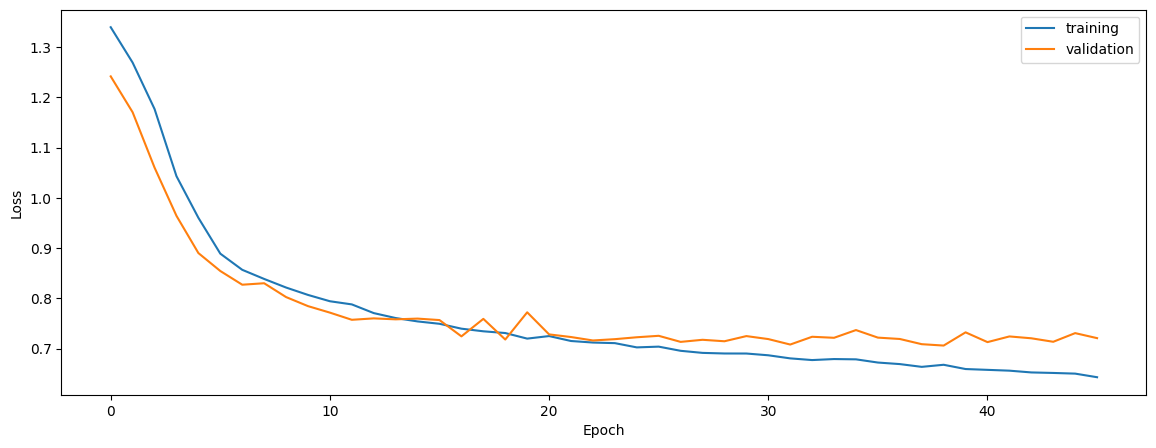

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuracy, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getAccuracy(train[1],train[4]))
print(getAccuracy(val[1],val[4]))
print(getAccuracy(test[1],test[4]))

train
0.7261645964899551
0.7185751936316696
0.705521137821212


In [8]:
print(props['space'])
print(getAccuracy(train[1],train[4],train[3][0]))
print(getAccuracy(val[1],val[4],val[3][0]))
print(getAccuracy(test[1],test[4],test[3][0]))

native
0.7263012826023753
0.7161398253334342
0.7062601796263023


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getAccuracy(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getAccuracy(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getAccuracy(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.7216680438731358
0.7104815194861166
0.7063713518575975


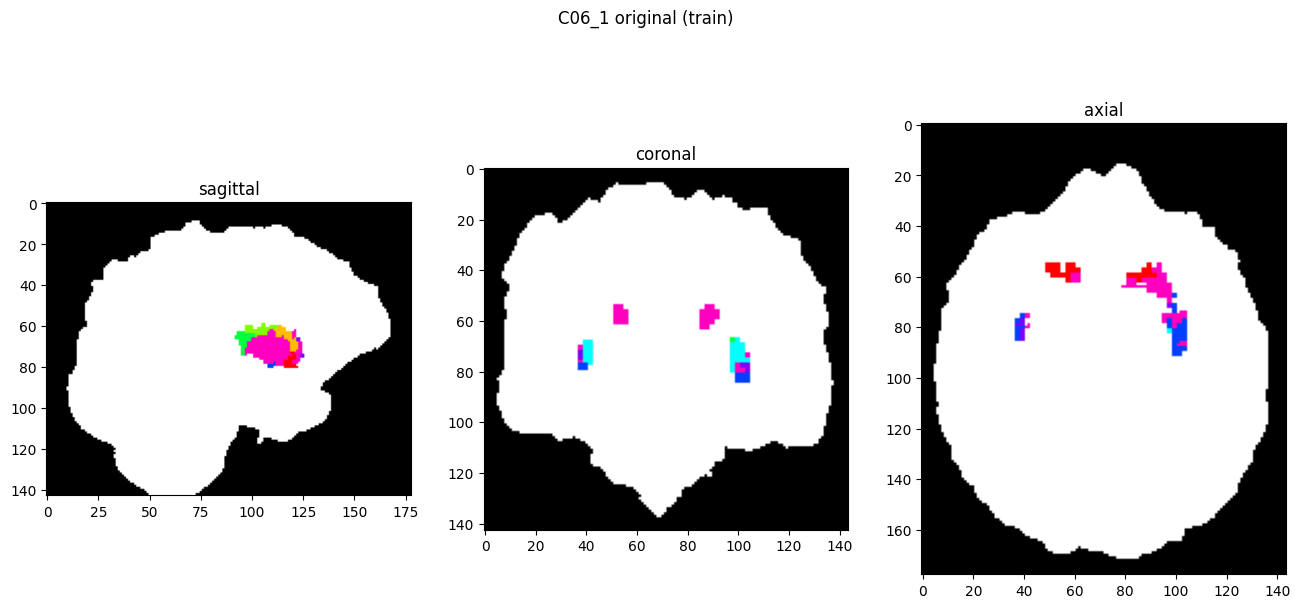

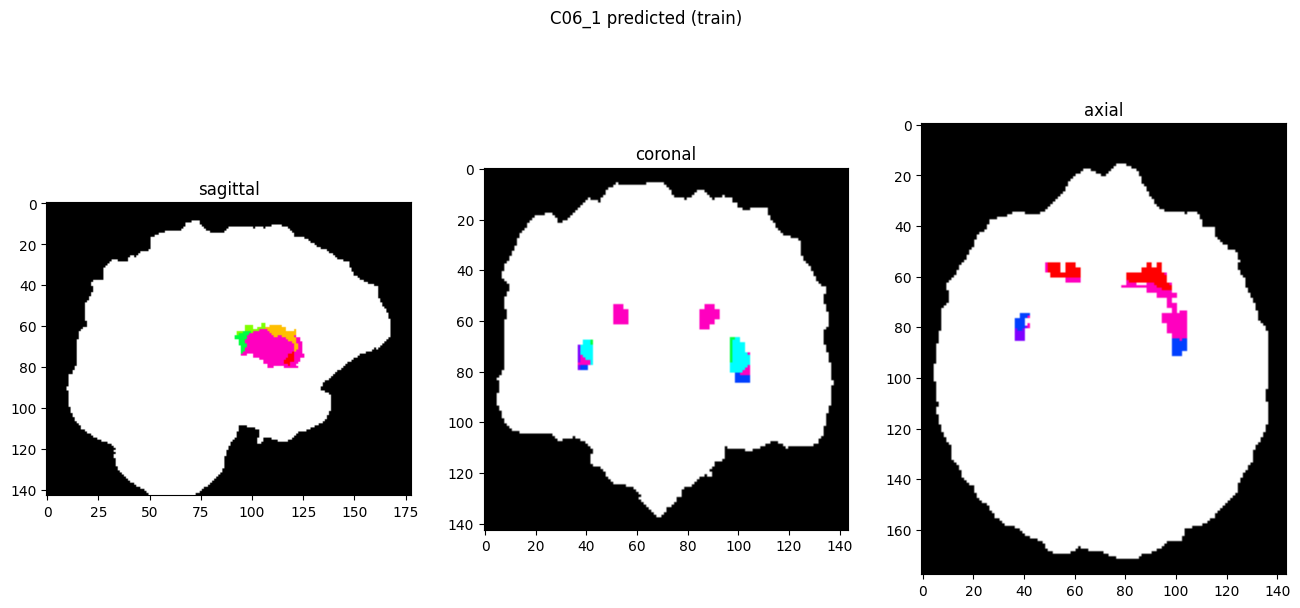

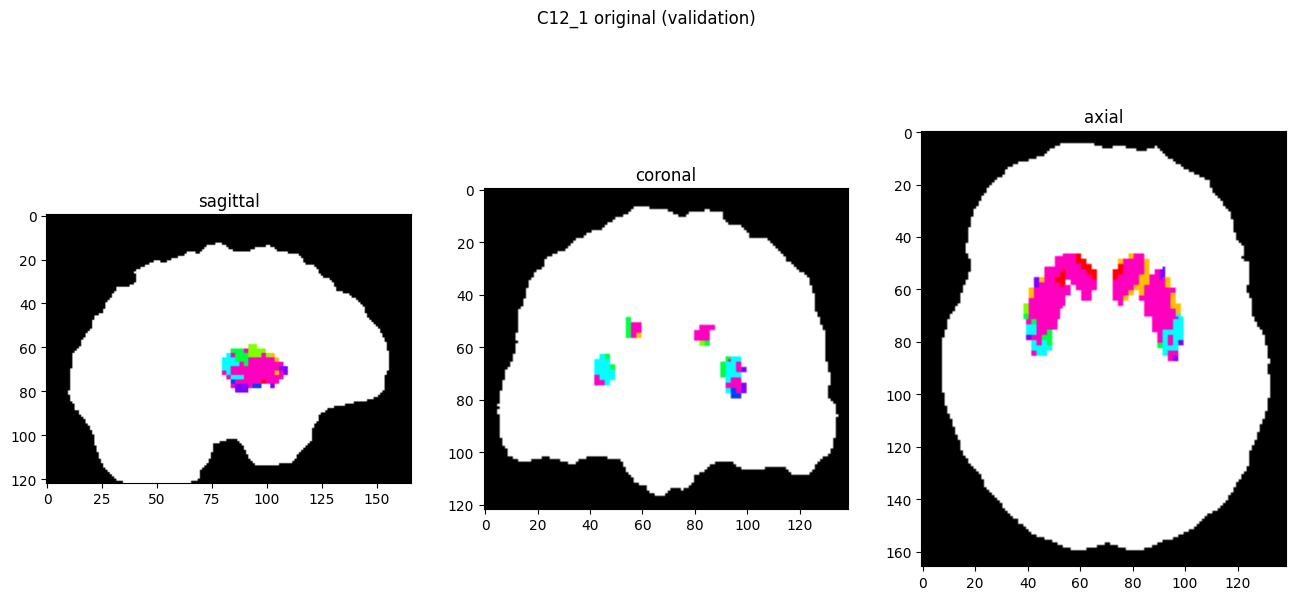

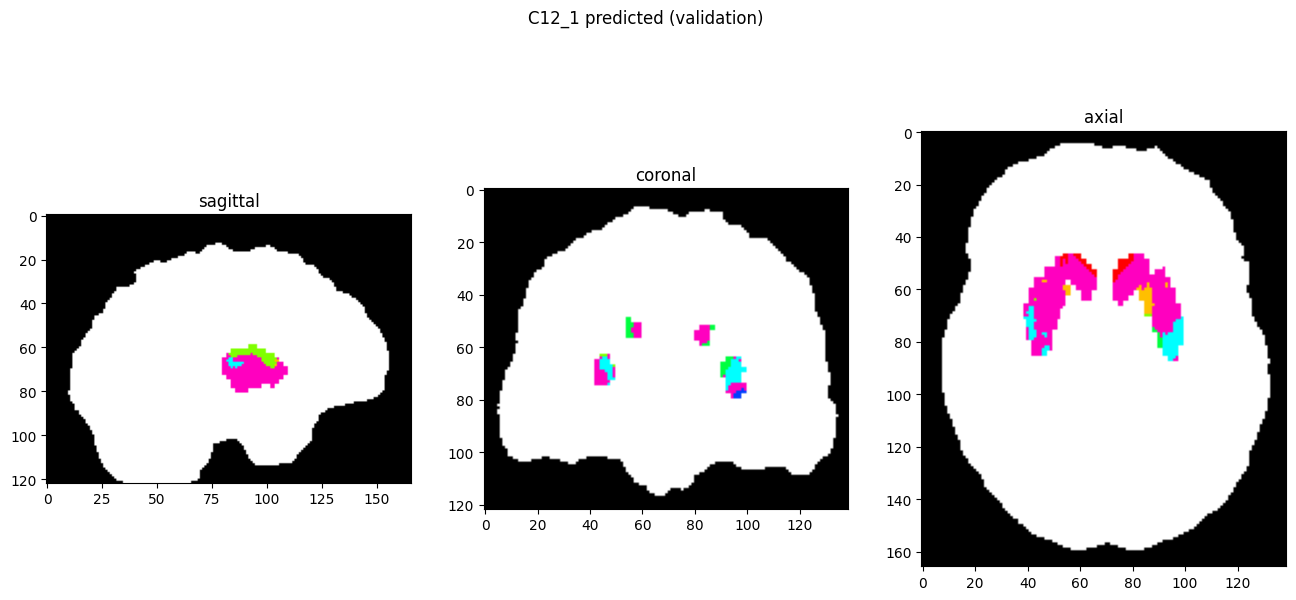

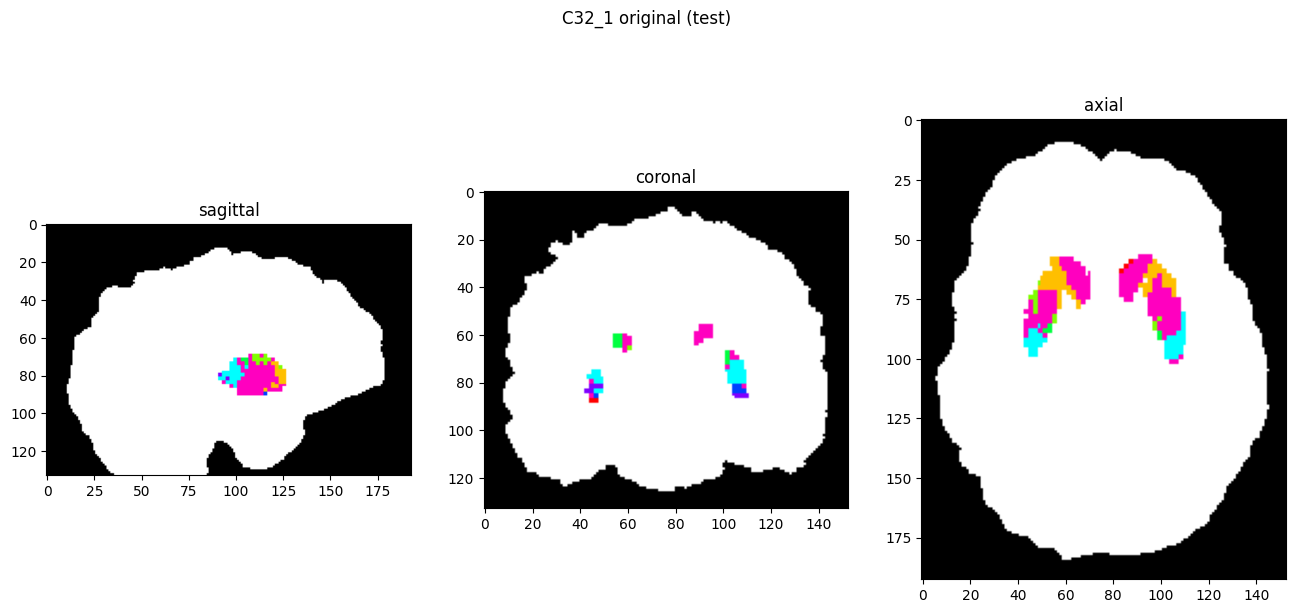

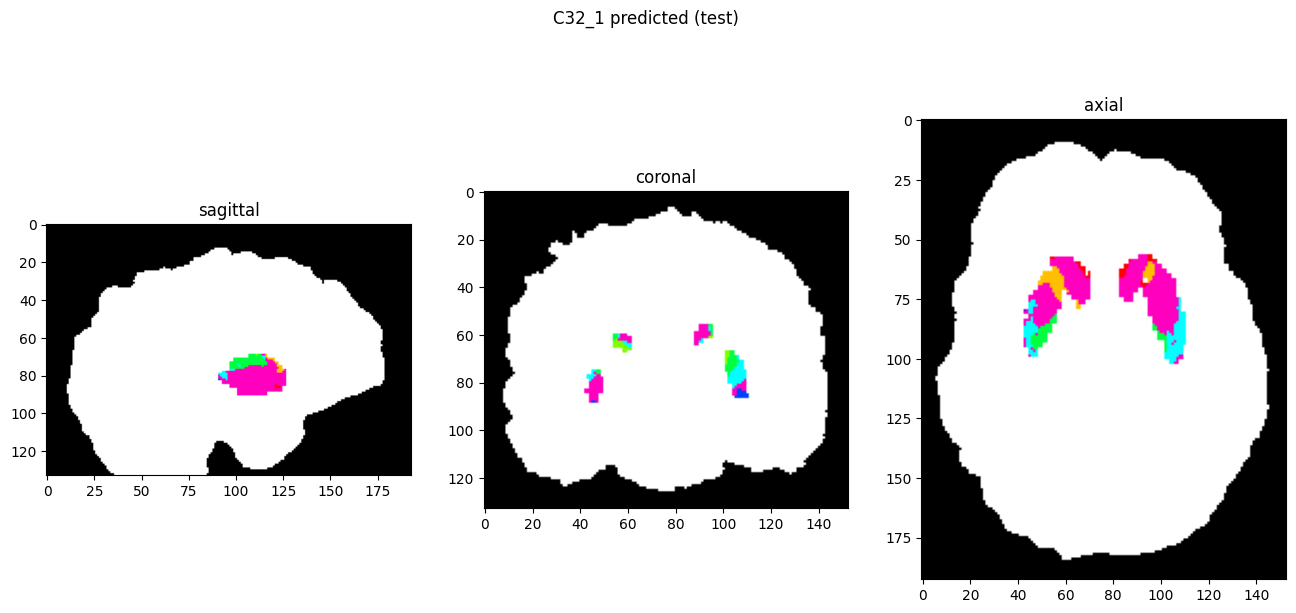

In [10]:
showResults(model, gen, threshold=0)